In [42]:
"""
CatBoost Experiments Serrano/AUDSOME Phase 1
Anomaly Only
Gabriel Iuhasz
"""
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import xgboost as xgb
from catboost import CatBoostClassifier
# from sklearn.externals import joblib
from joblib import dump, load
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from subprocess import check_output
%matplotlib inline

In [43]:
def custom_scoring_reporting(y_pred,
                             y,
                             definitions,
                             prefix):
    """
    Custom function for handling scoring and reporting
    :param y_pred: model predictions
    :param y: ground truth
    :param definitions: variable class definitions (factorize)
    :param prefix: prefix to saved files and images
    :return: 0
    """
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score (micro): {}".format(jaccard_score(y, y_pred, average='micro')))
    print("Jaccard score (macro): {}".format(jaccard_score(y, y_pred, average='macro')))
    print("Jaccard score (weighted): {}".format(jaccard_score(y, y_pred, average='weighted')))


    print("Full classification report")
    print(classification_report(y, y_pred, digits=4, target_names=definitions))
    report = classification_report(y, y_pred, digits=4, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    print("Imbalanced Classification report")
    print(classification_report_imbalanced(y, y_pred, digits=4, target_names=definitions))
    imb_report = classification_report_imbalanced(y, y_pred, digits=4, target_names=definitions, output_dict=True)
    df_imb_classification_report = pd.DataFrame(imb_report).transpose()
    classification_imb_rep_name = "{}_imb_classification_rep_best.csv".format(prefix)
    df_imb_classification_report.to_csv(os.path.join(model_dir,classification_imb_rep_name), index=False)



Common preprocessing for all experiments

In [44]:
print("Checking files in data location ...")
train_dir = '/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node/training'
# train_dir = '/home/gabriel/Research/Aspide/workspace/data_phase'
# train_dir = '/home/gabriel/research/dipet/serrano/data'
print(check_output(["ls", train_dir]).decode("utf8"))

Checking files in data location ...
data
df_anomaly.csv
df_audsome.csv
df_clean_ausdome_single.csv
df_clean_single.csv
models
processed



In [45]:
print("Setting paths and datasets")
# Checking if directory exists for data, modells and processed

data_dir = os.path.join(train_dir,'data')
model_dir = os.path.join(train_dir,'models')
processed_dir = os.path.join(train_dir,'processed')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# if not os.path.exists(processed_dir):
#     os.makedirs(processed_dir)

Setting paths and datasets


In [46]:
df_anomaly = pd.read_csv(os.path.join(train_dir,"df_anomaly.csv"))
df_audsome = pd.read_csv(os.path.join(train_dir,"df_audsome.csv"))
df_clean = pd.read_csv(os.path.join(train_dir,"df_clean_single.csv"))
df_clean_audsome = pd.read_csv(os.path.join(train_dir,"df_clean_ausdome_single.csv"))

# Set index as time
df_anomaly.set_index('time', inplace=True)
df_audsome.set_index('time', inplace=True)
df_clean.set_index('time', inplace=True)
df_clean_audsome.set_index('time', inplace=True)

In [52]:
print("Dataset chosen ...")
data = df_audsome

# Nice print
nice_y = data['target']
data.shape

Dataset chosen ...


(4800, 90)

In [53]:
# Uncomment for removing dummy TODO CHECK if adding back dummy
# data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

In [54]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


Ploting class distribution ..


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


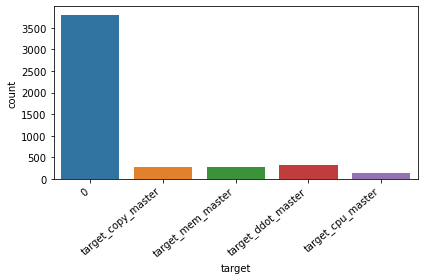

In [55]:
# Plot class distribution
print("Ploting class distribution ..")
pltdist= sns.countplot(nice_y)
pltdist.set_xticklabels(pltdist.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [56]:
print("Scaling dataset")
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # transform back to df

Scaling dataset


Starting of experiment for CatBoost only

Common parameters
loss_function
Command-line: --loss-function

Alias: objective

The metric to use in training. The specified value also determines the machine learning problem to solve. Some metrics support optional parameters (see the Objectives and metrics section for details on each metric).

custom_metric
Command-line: --custom-metric

Metric values to output during training. These functions are not optimized and are displayed for informational purposes only. Some metrics support optional parameters (see the Objectives and metrics section for details on each metric).

eval_metric
Command-line: --eval-metric

The metric used for overfitting detection (if enabled) and best model selection (if enabled). Some metrics support optional parameters (see the Objectives and metrics section for details on each metric).

iterations
Command-line: -i, --iterations

Aliases: num_boost_round, n_estimators, num_trees

The maximum number of trees that can be built when solving machine learning problems.

learning_rate
Command-line: -w, --learning-rate

Alias: eta

The learning rate.

Used for reducing the gradient step.

random_seed
Command-line: -r, --random-seed

Alias:random_state

The random seed used for training.

l2_leaf_reg
Command-line: --l2-leaf-reg, l2-leaf-regularizer

Alias: reg_lambda

Coefficient at the L2 regularization term of the cost function.

bootstrap_type
Command-line: --bootstrap-type

Bootstrap type. Defines the method for sampling the weights of objects.

bagging_temperature
Command-line: --bagging-temperature

Defines the settings of the Bayesian bootstrap. It is used by default in classification and regression modes.

subsample
Command-line: --subsample

Sample rate for bagging.

sampling_frequency
Command-line: --sampling-frequency

Frequency to sample weights and objects when building trees.

sampling_unit
Command-line: --sampling-unit

The sampling scheme.

mvs_reg
Command-line: --mvs-reg

Affects the weight of the denominator and can be used for balancing between the importance and Bernoulli sampling (setting it to 0 implies importance sampling and to \infty∞ - Bernoulli).

random_strength
Command-line: --random-strength

The amount of randomness to use for scoring splits when the tree structure is selected. Use this parameter to avoid overfitting the model.

use_best_model
Command-line: --use-best-model

If this parameter is set, the number of trees that are saved in the resulting model is defined.

best_model_min_trees
Command-line: --best-model-min-trees

The minimal number of trees that the best model should have. If set, the output model contains at least the given number of trees even if the best model is located within these trees.

depth
Command-line: -n, --depth

Alias: max_depth

Depth of the tree.

grow_policy
Command-line: --grow-policy

The tree growing policy. Defines how to perform greedy tree construction.

min_data_in_leaf
Command-line: --min-data-in-leaf

Alias: min_child_samples

The minimum number of training samples in a leaf. CatBoost does not search for new splits in leaves with samples count less than the specified value.

max_leaves
Command-line: --max-leaves

Alias:num_leaves

The maximum number of leafs in the resulting tree. Can be used only with the Lossguide growing policy.

ignored_features
Command-line: -I, --ignore-features

Feature indices or names to exclude from the training. It is assumed that all passed values are feature names if at least one of the passed values can not be converted to a number or a range of numbers. Otherwise, it is assumed that all passed values are feature indices.

Specifics:

Non-negative indices that do not match any features are successfully ignored. For example, if five features are defined for the objects in the dataset and this parameter is set to 42, the corresponding non-existing feature is successfully ignored.

The identifier corresponds to the feature's index. Feature indices used in train and feature importance are numbered from 0 to featureCount – 1. If a file is used as input data then any non-feature column types are ignored when calculating these indices. For example, each row in the input file contains data in the following order: cat feature<\t>label value<\t>num feature. So for the row rock<\t>0<\t>42, the identifier for the rock feature is 0, and for the 42 feature it's 1.

The addition of a non-existing feature name raises an error.

one_hot_max_size
Command-line: --one-hot-max-size

Use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. Ctrs are not calculated for such features.

has_time
Command-line: --has-time

Use the order of objects in the input data (do not perform random permutations during the Transforming categorical features to numerical features and Choosing the tree structure stages).

rsm
Command-line: --rsm

Alias:colsample_bylevel

Random subspace method. The percentage of features to use at each split selection, when features are selected over again at random.

nan_mode
Command-line: --nan-mode

The method for  processing missing values in the input dataset.

input_borders
Command-line: --input-borders-file

Load Custom quantization borders and missing value modes from a file (do not generate them).

output_borders
Command-line: --output-borders-file

Save quantization borders for the current dataset to a file.

fold_permutation_block
Command-line: --fold-permutation-block

Objects in the dataset are grouped in blocks before the random permutations. This parameter defines the size of the blocks.

leaf_estimation_method
Command-line: --leaf-estimation-method

The method used to calculate the values in leaves.

leaf_estimation_iterations
Command-line: --leaf-estimation-iterations

This parameter regulates how many steps are done in every tree when calculating leaf values.

leaf_estimation_backtracking
Command-line: --leaf-estimation-backtracking

When the value of the leaf_estimation_iterations parameter is greater than 1, CatBoost makes several gradient or newton steps when calculating the resulting leaf values of a tree.

fold_len_multiplier
Command-line: --fold-len-multiplier

Coefficient for changing the length of folds.

approx_on_full_history
Command-line:--approx-on-full-history

The principles for calculating the approximated values.

class_weights
Command-line: --class-weights

Class weights. The values are used as multipliers for the object weights. This parameter can be used for solving binary classification and multiclassification problems.

class_names
Classes names. Allows to redefine the default values when using the MultiClass and Logloss metrics.

auto_class_weights
Command-line: --auto-class-weights

Automatically calculate class weights based either on the total weight or the total number of objects in each class. The values are used as multipliers for the object weights.

Supported values:

None — All class weights are set to 1

Balanced:

CW_k=\displaystyle\frac{max_{c=1}^K(\sum_{t_{i}=c}{w_i})}{\sum_{t_{i}=k}{w_{i}}}CW
​k
​​ =
​∑
​t
​i
​​ =k
​​ w
​i
​​
​
​max
​c=1
​K
​​ (∑
​t
​i
​​ =c
​​ w
​i
​​ )
​​

SqrtBalanced:

CW_k=\sqrt{\displaystyle\frac{max_{c=1}^K(\sum_{t_i=c}{w_i})}{\sum_{t_i=k}{w_i}}}CW
​k
​​ =√
​
​∑
​t
​i
​​ =k
​​ w
​i
​​
​
​max
​c=1
​K
​​ (∑
​t
​i
​​ =c
​​ w
​i
​​ )
​​
​
​​

scale_pos_weight
The weight for class 1 in binary classification. The value is used as a multiplier for the weights of objects from class 1.

boosting_type
Command-line: --boosting-type

Boosting scheme.

boost_from_average
Command-line: --boost-from-average

Initialize approximate values by best constant value for the specified loss function.

langevin
Command-line: --langevin

Enables the Stochastic Gradient Langevin Boosting mode.

diffusion_temperature
Command-line: --diffusion-temperature

The diffusion temperature of the Stochastic Gradient Langevin Boosting mode.

posterior_sampling
Command-line: --posterior-sampling

If this parameter is set several options are specified as follows and model parameters are checked to obtain uncertainty predictions with good theoretical properties.

allow_const_label
Command-line: --allow-const-label

Use it to train models with datasets that have equal label values for all objects.

score_function
Command-line: --score-function

The score type used to select the next split during the tree construction.

monotone_constraints
Command-line: --monotone-constraints

Impose monotonic constraints on numerical features.

Possible values:

1 — Increasing constraint on the feature. The algorithm forces the model to be a non-decreasing function of this features.

-1 — Decreasing constraint on the feature. The algorithm forces the model to be a non-increasing function of this features.

0 — constraints are disabled.

feature_weights
Command-line: --feature-weights

Per-feature multiplication weights used when choosing the best split. The score of each candidate is multiplied by the weights of features from the current split.

Non-negative float values are supported for each weight.

Supported formats for setting the value of this parameter:

first_feature_use_penalties
Command-line: --first-feature-use-penalties

Per-feature penalties for the first occurrence of the feature in the model. The given value is subtracted from the score if the current candidate is the first one to include the feature in the model.

Refer to the Per-object and per-feature penalties section for details on applying different score penalties.

Non-negative float values are supported for each penalty.

penalties_coefficient
Command-line: --penalties-coefficient

A single-value common coefficient to multiply all penalties.

per_object_feature_penalties
Command-line: --per-object-feature-penalties

Per-object penalties for the first use of the feature for the object. The given value is multiplied by the number of objects that are divided by the current split and use the feature for the first time.

Refer to the Per-object and per-feature penalties section for details on applying different score penalties.

Non-negative float values are supported for each penalty.

model_shrink_rate
Command-line: --model-shrink-rate

The constant used to calculate the coefficient for multiplying the model on each iteration.

model_shrink_mode
Command-line: model_shrink_mode

Determines how the actual model shrinkage coefficient is calculated at each iteration.

CTR settings
simple_ctr
Quantization settings for simple categorical features. Use this parameter to specify the principles for defining the class of the object for regression tasks. By default, it is considered that an object belongs to the positive class if its' label value is greater than the median of all label values of the dataset.

combinations_ctr
Quantization settings for combinations of categorical features.

per_feature_ctr
Per-feature quantization settings for categorical features.

ctr_target_border_count
The maximum number of borders to use in target quantization for categorical features that need it. Allowed values are integers from 1 to 255 inclusively.

counter_calc_method
The method for calculating the Counter CTR type.

max_ctr_complexity
The maximum number of features that can be combined.

ctr_leaf_count_limit
The maximum number of leaves with categorical features. If the quantity exceeds the specified value a part of leaves is discarded.

store_all_simple_ctr
Ignore categorical features, which are not used in feature combinations, when choosing candidates for exclusion.

final_ctr_computation_mode
Final CTR computation mode.

Input file settings
-f, --learn-set
The path to the input file that contains the dataset description.

-t, --test-set
A comma-separated list of input files that contain the validation dataset description (the format must be the same as used in the training dataset).

--cd, --column-description
The path to the input file that contains the columns description.

--learn-pairs
The path to the input file that contains the pairs description for the training dataset.

--test-pairs
The path to the input file that contains the pairs description for the validation dataset.

--learn-group-weights
The path to the input file that contains the weights of groups. Refer to the Group weights section for format details.

--test-group-weights
The path to the input file that contains the weights of groups for the validation dataset.

--learn-baseline
The path to the input file that contains baseline values for the training dataset.

--test-baseline
The path to the input file that contains baseline values for the validation dataset.

--delimiter
The delimiter character used to separate the data in the dataset description input file.

--has-header
Read the column names from the first line of the dataset description file if this parameter is set.

--params-files
The path to the input JSON file that contains the training parameters, for example:

--nan-mode
The method for processing missing values in the input dataset.

Multiclassification settings
classes_count
Command-line: --classes-count

The upper limit for the numeric class label. Defines the number of classes for multiclassification.

--class-names
This parameter is only for Command-line.

Classes names. Allows to redefine the default values when using the MultiClass and Logloss metrics.

Output settings
logging_level
Command line: --logging-level

The logging level to output to stdout.

metric_period
Command line: --metric-period

The frequency of iterations to calculate the values of objectives and metrics.

The usage of this parameter speeds up the training.

verbose
Command line: --verbose

Alias:verbose_eval

The purpose of this parameter depends on the type of the given value:

train_dir
Command line: --train-dir

The directory for storing the files generated during training.

model_size_reg
Command line: --model-size-reg

The model size regularization coefficient. The larger the value, the smaller the model size. Refer to the Model size regularization coefficient section for details.

This regularization is needed only for models with categorical features (other models are small).

allow_writing_files
Allow to write analytical and snapshot files during training.

save_snapshot
Enable snapshotting for restoring the training progress after an interruption.

snapshot_file
The name of the file to save the training progress information in. This file is used for recovering training after an interruption.

snapshot_interval
The interval between saving snapshots in seconds.

roc_file
The name of the output file to save the ROC curve points to.

Overfitting detection settings
early_stopping_rounds
Sets the overfitting detector type to Iter and stops the training after the specified number of iterations since the iteration with the optimal metric value.

od_type
Command-line: --od-type

The type of the overfitting detector to use.

od_pval
Command-line: --od-pval

The threshold for the IncToDec overfitting detector type.

od_wait
Command-line: --od-wait

The number of iterations to continue the training after the iteration with the optimal metric value.

Performance settings
thread_count
Command-line: -T, --thread-count

The number of threads to use during the training.

used_ram_limit
Command-line: --used-ram-limit

Attempt to limit the amount of used CPU RAM.

gpu_ram_part
Command-line: --gpu-ram-part

How much of the GPU RAM to use for training.

pinned_memory_size
Command-line: --pinned-memory-size

How much pinned (page-locked) CPU RAM to use per GPU.

gpu_cat_features_storage
Command-line: --gpu-cat-features-storage

The method for storing the categorical features' values.

data_partition
Command-line: --data-partition

The method for splitting the input dataset between multiple workers.

Processing unit settings
task_type
Command line: --task-type

The processing unit type to use for training.

devices
Command line: --devices

IDs of the GPU devices to use for training (indices are zero-based).

Quantization settings
target_border
Command-line: --target-border

If set, defines the border for converting target values to 0 and 1.

border_count
Command-line: -x, --border-count

Alias: max_bin

The number of splits for numerical features. Allowed values are integers from 1 to 65535 inclusively.

feature_border_type
Command-line: --feature-border-type

The quantization mode for numerical features.

per_float_feature_quantization
Command-line: --per-float-feature-quantization

The quantization description for the specified feature or list of features.

Text processing parameters
These parameters are only for the Python package and Command-line version.

tokenizers
Command-line: --tokenizers

Tokenizers used to preprocess Text type feature columns before creating the dictionary.

dictionaries
Command-line: --dictionaries

Dictionaries used to preprocess Text type feature columns.

Format:

feature_calcers
Command-line: --feature-calcers

Feature calcers used to calculate new features based on preprocessed Text type feature columns.

Format:




In [57]:
# Name of experiment
# CatBoost
prefix = 'Phase1_cat_evs_audsome'
scorer = make_scorer(jaccard_score, average="micro") # TODO check average
paramgrid = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 1000],
    'max_depth': [3, 4, 6, 25, 50],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2],
    # 'iterations': [10, 20, 30, 40, 70, 100],
    # 'loss_function': ['F1']
    # 'objective': ['MultiClass'],  # error evaluation for multiclass training
    # 'num_class': [len(definitions)],
}
model =  CatBoostClassifier()
model.get_params().keys()

dict_keys([])

In [58]:
#Example of HPO methods https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms/blob/master/HPO_Classification.ipynb
# scorer = make_scorer(accuracy_score, )
scorer = make_scorer(jaccard_score, average="micro") # TODO check average
# scorer = 'accuracy'
n_splits = 4 # default 4

cv_type = StratifiedKFold(n_splits=n_splits)
nj = 1 # Number of jobs set to 1 for Apple Silicone #TODO: find fix
n_iter = 1000 # SPecify the size of the sample to be used


# cv = EvolutionaryAlgorithmSearchCV(estimator=model,
#                                    params=paramgrid,
#                                    scoring=scorer,
#                                    cv=cv_type, # StratifiedKFold not supported for multilabel-indicator (oh encoding)
#                                    verbose=4,
#                                    population_size=40, # 40
#                                    gene_mutation_prob=0.20,
#                                    gene_crossover_prob=0.5,
#                                    tournament_size=4,
#                                    generations_number=30, #10
#                                    n_jobs=nj) # for dnn n_jobs must be set to 1 rest is 8
randomized_search_result = model.randomized_search(paramgrid,
                                                   X=X,
                                                   y=y,
                                                   cv=cv_type,
                                                   plot=True,
                                                   n_iter = n_iter)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6061732	test: 1.6055353	best: 1.6055353 (0)	total: 10.1ms	remaining: 90.8ms
1:	learn: 1.6026635	test: 1.6016000	best: 1.6016000 (1)	total: 13.7ms	remaining: 54.9ms
2:	learn: 1.5992089	test: 1.5976800	best: 1.5976800 (2)	total: 17.1ms	remaining: 39.9ms
3:	learn: 1.5958357	test: 1.5938204	best: 1.5938204 (3)	total: 23.7ms	remaining: 35.5ms
4:	learn: 1.5925463	test: 1.5903985	best: 1.5903985 (4)	total: 27.3ms	remaining: 27.3ms
5:	learn: 1.5891760	test: 1.5866920	best: 1.5866920 (5)	total: 31.2ms	remaining: 20.8ms
6:	learn: 1.5857920	test: 1.5828401	best: 1.5828401 (6)	total: 35ms	remaining: 15ms
7:	learn: 1.5824406	test: 1.5790163	best: 1.5790163 (7)	total: 38.2ms	remaining: 9.55ms
8:	learn: 1.5790799	test: 1.5752082	best: 1.5752082 (8)	total: 41.8ms	remaining: 4.65ms
9:	learn: 1.5757212	test: 1.5714205	best: 1.5714205 (9)	total: 45.4ms	remaining: 0us

bestTest = 1.571420465
bestIteration = 9

0:	loss: 1.5714205	best: 1.5714205 (0)	total: 62.6ms	remaining: 13.1s
0:	learn: 1.57

15:	learn: 1.1970899	test: 1.1481628	best: 1.1481628 (15)	total: 62.8ms	remaining: 133ms
16:	learn: 1.1773681	test: 1.1270412	best: 1.1270412 (16)	total: 70.8ms	remaining: 137ms
17:	learn: 1.1589942	test: 1.1065099	best: 1.1065099 (17)	total: 78.3ms	remaining: 139ms
18:	learn: 1.1409304	test: 1.0866929	best: 1.0866929 (18)	total: 82.9ms	remaining: 135ms
19:	learn: 1.1236633	test: 1.0673716	best: 1.0673716 (19)	total: 87.1ms	remaining: 131ms
20:	learn: 1.1080683	test: 1.0485824	best: 1.0485824 (20)	total: 90ms	remaining: 124ms
21:	learn: 1.0923253	test: 1.0312138	best: 1.0312138 (21)	total: 93.3ms	remaining: 119ms
22:	learn: 1.0757910	test: 1.0134847	best: 1.0134847 (22)	total: 96.8ms	remaining: 114ms
23:	learn: 1.0607935	test: 0.9962666	best: 0.9962666 (23)	total: 102ms	remaining: 111ms
24:	learn: 1.0454223	test: 0.9795099	best: 0.9795099 (24)	total: 105ms	remaining: 105ms
25:	learn: 1.0300884	test: 0.9632064	best: 0.9632064 (25)	total: 109ms	remaining: 101ms
26:	learn: 1.0157876	test:

40:	learn: 0.0574896	test: 0.0188497	best: 0.0188497 (40)	total: 231ms	remaining: 50.8ms
41:	learn: 0.0564452	test: 0.0181998	best: 0.0181998 (41)	total: 237ms	remaining: 45.1ms
42:	learn: 0.0544716	test: 0.0171308	best: 0.0171308 (42)	total: 243ms	remaining: 39.5ms
43:	learn: 0.0537090	test: 0.0162376	best: 0.0162376 (43)	total: 246ms	remaining: 33.6ms
44:	learn: 0.0521673	test: 0.0152929	best: 0.0152929 (44)	total: 249ms	remaining: 27.7ms
45:	learn: 0.0515556	test: 0.0153543	best: 0.0152929 (44)	total: 254ms	remaining: 22.1ms
46:	learn: 0.0502892	test: 0.0147099	best: 0.0147099 (46)	total: 258ms	remaining: 16.4ms
47:	learn: 0.0485726	test: 0.0134924	best: 0.0134924 (47)	total: 261ms	remaining: 10.9ms
48:	learn: 0.0470171	test: 0.0130852	best: 0.0130852 (48)	total: 264ms	remaining: 5.38ms
49:	learn: 0.0458103	test: 0.0123122	best: 0.0123122 (49)	total: 267ms	remaining: 0us

bestTest = 0.01231219326
bestIteration = 49

9:	loss: 0.0123122	best: 0.0123122 (9)	total: 1.28s	remaining: 25.6

0:	learn: 1.6061732	test: 1.6055353	best: 1.6055353 (0)	total: 6.4ms	remaining: 633ms
1:	learn: 1.6026635	test: 1.6016000	best: 1.6016000 (1)	total: 11.6ms	remaining: 567ms
2:	learn: 1.5992089	test: 1.5976800	best: 1.5976800 (2)	total: 15.3ms	remaining: 495ms
3:	learn: 1.5958357	test: 1.5938204	best: 1.5938204 (3)	total: 18.7ms	remaining: 448ms
4:	learn: 1.5925463	test: 1.5903985	best: 1.5903985 (4)	total: 22.7ms	remaining: 431ms
5:	learn: 1.5891760	test: 1.5866920	best: 1.5866920 (5)	total: 28.5ms	remaining: 446ms
6:	learn: 1.5857920	test: 1.5828401	best: 1.5828401 (6)	total: 33.3ms	remaining: 443ms
7:	learn: 1.5824406	test: 1.5790163	best: 1.5790163 (7)	total: 37.7ms	remaining: 434ms
8:	learn: 1.5790799	test: 1.5752082	best: 1.5752082 (8)	total: 44.1ms	remaining: 446ms
9:	learn: 1.5757212	test: 1.5714205	best: 1.5714205 (9)	total: 47.6ms	remaining: 428ms
10:	learn: 1.5724544	test: 1.5676446	best: 1.5676446 (10)	total: 51.5ms	remaining: 417ms
11:	learn: 1.5691026	test: 1.5638901	best:

27:	learn: 1.0015041	test: 0.9324245	best: 0.9324245 (27)	total: 116ms	remaining: 299ms
28:	learn: 0.9880403	test: 0.9173523	best: 0.9173523 (28)	total: 122ms	remaining: 299ms
29:	learn: 0.9744045	test: 0.9040668	best: 0.9040668 (29)	total: 126ms	remaining: 295ms
30:	learn: 0.9607063	test: 0.8896256	best: 0.8896256 (30)	total: 130ms	remaining: 289ms
31:	learn: 0.9472134	test: 0.8755790	best: 0.8755790 (31)	total: 135ms	remaining: 287ms
32:	learn: 0.9343739	test: 0.8619180	best: 0.8619180 (32)	total: 138ms	remaining: 281ms
33:	learn: 0.9216659	test: 0.8485545	best: 0.8485545 (33)	total: 143ms	remaining: 277ms
34:	learn: 0.9094150	test: 0.8355678	best: 0.8355678 (34)	total: 146ms	remaining: 271ms
35:	learn: 0.8972463	test: 0.8227782	best: 0.8227782 (35)	total: 149ms	remaining: 265ms
36:	learn: 0.8855449	test: 0.8102760	best: 0.8102760 (36)	total: 153ms	remaining: 261ms
37:	learn: 0.8737860	test: 0.7980247	best: 0.7980247 (37)	total: 158ms	remaining: 258ms
38:	learn: 0.8621064	test: 0.786

58:	learn: 0.0949888	test: 0.0480295	best: 0.0480295 (58)	total: 260ms	remaining: 181ms
59:	learn: 0.0922121	test: 0.0459136	best: 0.0459136 (59)	total: 266ms	remaining: 178ms
60:	learn: 0.0896554	test: 0.0439674	best: 0.0439674 (60)	total: 271ms	remaining: 174ms
61:	learn: 0.0871699	test: 0.0427204	best: 0.0427204 (61)	total: 275ms	remaining: 168ms
62:	learn: 0.0847438	test: 0.0407662	best: 0.0407662 (62)	total: 278ms	remaining: 164ms
63:	learn: 0.0825967	test: 0.0396778	best: 0.0396778 (63)	total: 288ms	remaining: 162ms
64:	learn: 0.0806347	test: 0.0378801	best: 0.0378801 (64)	total: 293ms	remaining: 158ms
65:	learn: 0.0784623	test: 0.0362798	best: 0.0362798 (65)	total: 297ms	remaining: 153ms
66:	learn: 0.0768402	test: 0.0348369	best: 0.0348369 (66)	total: 311ms	remaining: 153ms
67:	learn: 0.0754815	test: 0.0337041	best: 0.0337041 (67)	total: 318ms	remaining: 150ms
68:	learn: 0.0740520	test: 0.0323692	best: 0.0323692 (68)	total: 323ms	remaining: 145ms
69:	learn: 0.0725885	test: 0.031

87:	learn: 0.0279943	test: 0.0030053	best: 0.0030053 (87)	total: 376ms	remaining: 51.3ms
88:	learn: 0.0277678	test: 0.0029809	best: 0.0029809 (88)	total: 382ms	remaining: 47.2ms
89:	learn: 0.0274574	test: 0.0028653	best: 0.0028653 (89)	total: 385ms	remaining: 42.8ms
90:	learn: 0.0272514	test: 0.0028429	best: 0.0028429 (90)	total: 389ms	remaining: 38.5ms
91:	learn: 0.0271569	test: 0.0028421	best: 0.0028421 (91)	total: 393ms	remaining: 34.2ms
92:	learn: 0.0269763	test: 0.0028062	best: 0.0028062 (92)	total: 400ms	remaining: 30.1ms
93:	learn: 0.0267842	test: 0.0027315	best: 0.0027315 (93)	total: 402ms	remaining: 25.7ms
94:	learn: 0.0267188	test: 0.0027279	best: 0.0027279 (94)	total: 407ms	remaining: 21.4ms
95:	learn: 0.0264369	test: 0.0026037	best: 0.0026037 (95)	total: 410ms	remaining: 17.1ms
96:	learn: 0.0263595	test: 0.0025602	best: 0.0025602 (96)	total: 415ms	remaining: 12.8ms
97:	learn: 0.0263106	test: 0.0025753	best: 0.0025602 (96)	total: 418ms	remaining: 8.53ms
98:	learn: 0.0258712	

86:	learn: 0.0225479	test: 0.0018522	best: 0.0018522 (86)	total: 349ms	remaining: 52.1ms
87:	learn: 0.0224071	test: 0.0018277	best: 0.0018277 (87)	total: 357ms	remaining: 48.6ms
88:	learn: 0.0221816	test: 0.0018046	best: 0.0018046 (88)	total: 361ms	remaining: 44.7ms
89:	learn: 0.0221458	test: 0.0017801	best: 0.0017801 (89)	total: 366ms	remaining: 40.6ms
90:	learn: 0.0221117	test: 0.0017798	best: 0.0017798 (90)	total: 369ms	remaining: 36.5ms
91:	learn: 0.0220578	test: 0.0017802	best: 0.0017798 (90)	total: 373ms	remaining: 32.4ms
92:	learn: 0.0219588	test: 0.0017550	best: 0.0017550 (92)	total: 380ms	remaining: 28.6ms
93:	learn: 0.0218210	test: 0.0017006	best: 0.0017006 (93)	total: 383ms	remaining: 24.4ms
94:	learn: 0.0217840	test: 0.0016893	best: 0.0016893 (94)	total: 387ms	remaining: 20.4ms
95:	learn: 0.0217491	test: 0.0016888	best: 0.0016888 (95)	total: 390ms	remaining: 16.3ms
96:	learn: 0.0216853	test: 0.0016582	best: 0.0016582 (96)	total: 395ms	remaining: 12.2ms
97:	learn: 0.0216392	

11:	learn: 1.5691026	test: 1.5638901	best: 1.5638901 (11)	total: 56.9ms	remaining: 892ms
12:	learn: 1.5657918	test: 1.5601567	best: 1.5601567 (12)	total: 64.1ms	remaining: 922ms
13:	learn: 1.5626538	test: 1.5564433	best: 1.5564433 (13)	total: 67.2ms	remaining: 892ms
14:	learn: 1.5594534	test: 1.5527659	best: 1.5527659 (14)	total: 72.1ms	remaining: 889ms
15:	learn: 1.5563713	test: 1.5491645	best: 1.5491645 (15)	total: 76.4ms	remaining: 878ms
16:	learn: 1.5530930	test: 1.5455000	best: 1.5455000 (16)	total: 79.9ms	remaining: 860ms
17:	learn: 1.5499296	test: 1.5418449	best: 1.5418449 (17)	total: 84.3ms	remaining: 852ms
18:	learn: 1.5467785	test: 1.5382265	best: 1.5382265 (18)	total: 87.8ms	remaining: 836ms
19:	learn: 1.5436554	test: 1.5346085	best: 1.5346085 (19)	total: 92.6ms	remaining: 833ms
20:	learn: 1.5407670	test: 1.5310017	best: 1.5310017 (20)	total: 96.5ms	remaining: 822ms
21:	learn: 1.5377906	test: 1.5274213	best: 1.5274213 (21)	total: 99.9ms	remaining: 808ms
22:	learn: 1.5346109	

136:	learn: 1.2489255	test: 1.2018087	best: 1.2018087 (136)	total: 662ms	remaining: 304ms
137:	learn: 1.2468818	test: 1.1995177	best: 1.1995177 (137)	total: 668ms	remaining: 300ms
138:	learn: 1.2447543	test: 1.1972249	best: 1.1972249 (138)	total: 671ms	remaining: 295ms
139:	learn: 1.2426541	test: 1.1949519	best: 1.1949519 (139)	total: 674ms	remaining: 289ms
140:	learn: 1.2405575	test: 1.1926827	best: 1.1926827 (140)	total: 680ms	remaining: 285ms
141:	learn: 1.2386790	test: 1.1904736	best: 1.1904736 (141)	total: 685ms	remaining: 280ms
142:	learn: 1.2366027	test: 1.1882112	best: 1.1882112 (142)	total: 688ms	remaining: 274ms
143:	learn: 1.2345464	test: 1.1860554	best: 1.1860554 (143)	total: 693ms	remaining: 269ms
144:	learn: 1.2326496	test: 1.1838536	best: 1.1838536 (144)	total: 696ms	remaining: 264ms
145:	learn: 1.2305834	test: 1.1816161	best: 1.1816161 (145)	total: 702ms	remaining: 260ms
146:	learn: 1.2285131	test: 1.1793819	best: 1.1793819 (146)	total: 706ms	remaining: 255ms
147:	learn

32:	learn: 0.9343739	test: 0.8619180	best: 0.8619180 (32)	total: 138ms	remaining: 700ms
33:	learn: 0.9216659	test: 0.8485545	best: 0.8485545 (33)	total: 144ms	remaining: 702ms
34:	learn: 0.9094150	test: 0.8355678	best: 0.8355678 (34)	total: 149ms	remaining: 701ms
35:	learn: 0.8972463	test: 0.8227782	best: 0.8227782 (35)	total: 152ms	remaining: 694ms
36:	learn: 0.8855449	test: 0.8102760	best: 0.8102760 (36)	total: 156ms	remaining: 689ms
37:	learn: 0.8737860	test: 0.7980247	best: 0.7980247 (37)	total: 161ms	remaining: 687ms
38:	learn: 0.8621064	test: 0.7861397	best: 0.7861397 (38)	total: 168ms	remaining: 695ms
39:	learn: 0.8512691	test: 0.7744655	best: 0.7744655 (39)	total: 172ms	remaining: 690ms
40:	learn: 0.8401737	test: 0.7630126	best: 0.7630126 (40)	total: 178ms	remaining: 688ms
41:	learn: 0.8293079	test: 0.7518003	best: 0.7518003 (41)	total: 181ms	remaining: 681ms
42:	learn: 0.8187568	test: 0.7408001	best: 0.7408001 (42)	total: 186ms	remaining: 678ms
43:	learn: 0.8083477	test: 0.730

127:	learn: 0.3323972	test: 0.2585849	best: 0.2585849 (127)	total: 541ms	remaining: 304ms
128:	learn: 0.3294155	test: 0.2558273	best: 0.2558273 (128)	total: 546ms	remaining: 300ms
129:	learn: 0.3263845	test: 0.2529820	best: 0.2529820 (129)	total: 549ms	remaining: 296ms
130:	learn: 0.3233196	test: 0.2501054	best: 0.2501054 (130)	total: 553ms	remaining: 291ms
131:	learn: 0.3202997	test: 0.2472628	best: 0.2472628 (131)	total: 558ms	remaining: 288ms
132:	learn: 0.3174714	test: 0.2445415	best: 0.2445415 (132)	total: 563ms	remaining: 284ms
133:	learn: 0.3146827	test: 0.2418380	best: 0.2418380 (133)	total: 566ms	remaining: 279ms
134:	learn: 0.3118808	test: 0.2391653	best: 0.2391653 (134)	total: 572ms	remaining: 275ms
135:	learn: 0.3089243	test: 0.2364366	best: 0.2364366 (135)	total: 575ms	remaining: 270ms
136:	learn: 0.3061794	test: 0.2338988	best: 0.2338988 (136)	total: 585ms	remaining: 269ms
137:	learn: 0.3035481	test: 0.2312931	best: 0.2312931 (137)	total: 598ms	remaining: 269ms
138:	learn

57:	learn: 0.0977910	test: 0.0504546	best: 0.0504546 (57)	total: 267ms	remaining: 654ms
58:	learn: 0.0949888	test: 0.0480295	best: 0.0480295 (58)	total: 275ms	remaining: 657ms
59:	learn: 0.0922121	test: 0.0459136	best: 0.0459136 (59)	total: 279ms	remaining: 651ms
60:	learn: 0.0896554	test: 0.0439674	best: 0.0439674 (60)	total: 282ms	remaining: 644ms
61:	learn: 0.0871699	test: 0.0427204	best: 0.0427204 (61)	total: 288ms	remaining: 641ms
62:	learn: 0.0847438	test: 0.0407662	best: 0.0407662 (62)	total: 297ms	remaining: 645ms
63:	learn: 0.0825967	test: 0.0396778	best: 0.0396778 (63)	total: 300ms	remaining: 638ms
64:	learn: 0.0806347	test: 0.0378801	best: 0.0378801 (64)	total: 306ms	remaining: 635ms
65:	learn: 0.0784623	test: 0.0362798	best: 0.0362798 (65)	total: 309ms	remaining: 626ms
66:	learn: 0.0768402	test: 0.0348369	best: 0.0348369 (66)	total: 314ms	remaining: 624ms
67:	learn: 0.0754815	test: 0.0337041	best: 0.0337041 (67)	total: 318ms	remaining: 617ms
68:	learn: 0.0740520	test: 0.032

166:	learn: 0.0301409	test: 0.0046454	best: 0.0046280 (165)	total: 891ms	remaining: 176ms
167:	learn: 0.0300202	test: 0.0046130	best: 0.0046130 (167)	total: 896ms	remaining: 171ms
168:	learn: 0.0297154	test: 0.0045638	best: 0.0045638 (168)	total: 900ms	remaining: 165ms
169:	learn: 0.0295826	test: 0.0045042	best: 0.0045042 (169)	total: 905ms	remaining: 160ms
170:	learn: 0.0295010	test: 0.0044657	best: 0.0044657 (170)	total: 909ms	remaining: 154ms
171:	learn: 0.0294663	test: 0.0044543	best: 0.0044543 (171)	total: 914ms	remaining: 149ms
172:	learn: 0.0294406	test: 0.0044229	best: 0.0044229 (172)	total: 917ms	remaining: 143ms
173:	learn: 0.0293453	test: 0.0043779	best: 0.0043779 (173)	total: 922ms	remaining: 138ms
174:	learn: 0.0291314	test: 0.0043125	best: 0.0043125 (174)	total: 924ms	remaining: 132ms
175:	learn: 0.0290387	test: 0.0042625	best: 0.0042625 (175)	total: 929ms	remaining: 127ms
176:	learn: 0.0290030	test: 0.0042357	best: 0.0042357 (176)	total: 935ms	remaining: 121ms
177:	learn

95:	learn: 0.0264369	test: 0.0026037	best: 0.0026037 (95)	total: 473ms	remaining: 513ms
96:	learn: 0.0263595	test: 0.0025602	best: 0.0025602 (96)	total: 479ms	remaining: 508ms
97:	learn: 0.0263106	test: 0.0025753	best: 0.0025602 (96)	total: 484ms	remaining: 504ms
98:	learn: 0.0258712	test: 0.0025242	best: 0.0025242 (98)	total: 489ms	remaining: 499ms
99:	learn: 0.0257996	test: 0.0024970	best: 0.0024970 (99)	total: 495ms	remaining: 495ms
100:	learn: 0.0255180	test: 0.0024334	best: 0.0024334 (100)	total: 501ms	remaining: 491ms
101:	learn: 0.0252885	test: 0.0023644	best: 0.0023644 (101)	total: 505ms	remaining: 485ms
102:	learn: 0.0250680	test: 0.0023131	best: 0.0023131 (102)	total: 509ms	remaining: 479ms
103:	learn: 0.0250248	test: 0.0023139	best: 0.0023131 (102)	total: 515ms	remaining: 475ms
104:	learn: 0.0249836	test: 0.0023145	best: 0.0023131 (102)	total: 520ms	remaining: 471ms
105:	learn: 0.0246893	test: 0.0023467	best: 0.0023131 (102)	total: 524ms	remaining: 464ms
106:	learn: 0.024629

9:	learn: 0.2498415	test: 0.1801308	best: 0.1801308 (9)	total: 50.2ms	remaining: 954ms
10:	learn: 0.2210393	test: 0.1529644	best: 0.1529644 (10)	total: 56.5ms	remaining: 971ms
11:	learn: 0.1973669	test: 0.1309640	best: 0.1309640 (11)	total: 64.8ms	remaining: 1.01s
12:	learn: 0.1763621	test: 0.1130948	best: 0.1130948 (12)	total: 69.2ms	remaining: 996ms
13:	learn: 0.1566095	test: 0.0968628	best: 0.0968628 (13)	total: 72.6ms	remaining: 964ms
14:	learn: 0.1409885	test: 0.0833527	best: 0.0833527 (14)	total: 78.1ms	remaining: 963ms
15:	learn: 0.1273534	test: 0.0714345	best: 0.0714345 (15)	total: 82.5ms	remaining: 948ms
16:	learn: 0.1150633	test: 0.0620144	best: 0.0620144 (16)	total: 87ms	remaining: 936ms
17:	learn: 0.1047902	test: 0.0534548	best: 0.0534548 (17)	total: 92.6ms	remaining: 936ms
18:	learn: 0.0958619	test: 0.0466657	best: 0.0466657 (18)	total: 95.8ms	remaining: 912ms
19:	learn: 0.0883969	test: 0.0404142	best: 0.0404142 (19)	total: 100ms	remaining: 904ms
20:	learn: 0.0817400	test:

119:	learn: 0.0193042	test: 0.0013216	best: 0.0013137 (117)	total: 663ms	remaining: 442ms
120:	learn: 0.0189664	test: 0.0013199	best: 0.0013137 (117)	total: 669ms	remaining: 437ms
121:	learn: 0.0188627	test: 0.0012871	best: 0.0012871 (121)	total: 674ms	remaining: 431ms
122:	learn: 0.0187474	test: 0.0012519	best: 0.0012519 (122)	total: 681ms	remaining: 426ms
123:	learn: 0.0185863	test: 0.0012355	best: 0.0012355 (123)	total: 691ms	remaining: 423ms
124:	learn: 0.0184809	test: 0.0012121	best: 0.0012121 (124)	total: 700ms	remaining: 420ms
125:	learn: 0.0184051	test: 0.0011988	best: 0.0011988 (125)	total: 710ms	remaining: 417ms
126:	learn: 0.0182705	test: 0.0012036	best: 0.0011988 (125)	total: 715ms	remaining: 411ms
127:	learn: 0.0182030	test: 0.0012055	best: 0.0011988 (125)	total: 721ms	remaining: 406ms
128:	learn: 0.0181632	test: 0.0011972	best: 0.0011972 (128)	total: 730ms	remaining: 402ms
129:	learn: 0.0181370	test: 0.0011965	best: 0.0011965 (129)	total: 734ms	remaining: 395ms
130:	learn

37:	learn: 0.0341662	test: 0.0051493	best: 0.0051392 (36)	total: 185ms	remaining: 790ms
38:	learn: 0.0338720	test: 0.0051399	best: 0.0051392 (36)	total: 194ms	remaining: 799ms
39:	learn: 0.0337640	test: 0.0049918	best: 0.0049918 (39)	total: 200ms	remaining: 799ms
40:	learn: 0.0328384	test: 0.0047192	best: 0.0047192 (40)	total: 204ms	remaining: 793ms
41:	learn: 0.0327145	test: 0.0047487	best: 0.0047192 (40)	total: 209ms	remaining: 785ms
42:	learn: 0.0323089	test: 0.0045617	best: 0.0045617 (42)	total: 211ms	remaining: 772ms
43:	learn: 0.0319794	test: 0.0044301	best: 0.0044301 (43)	total: 218ms	remaining: 772ms
44:	learn: 0.0306317	test: 0.0040831	best: 0.0040831 (44)	total: 222ms	remaining: 766ms
45:	learn: 0.0297207	test: 0.0037348	best: 0.0037348 (45)	total: 226ms	remaining: 756ms
46:	learn: 0.0295094	test: 0.0036842	best: 0.0036842 (46)	total: 232ms	remaining: 755ms
47:	learn: 0.0282712	test: 0.0036229	best: 0.0036229 (47)	total: 235ms	remaining: 745ms
48:	learn: 0.0274511	test: 0.003

163:	learn: 0.0120131	test: 0.0007925	best: 0.0007146 (155)	total: 793ms	remaining: 174ms
164:	learn: 0.0119998	test: 0.0007814	best: 0.0007146 (155)	total: 798ms	remaining: 169ms
165:	learn: 0.0119292	test: 0.0007744	best: 0.0007146 (155)	total: 804ms	remaining: 165ms
166:	learn: 0.0118694	test: 0.0007667	best: 0.0007146 (155)	total: 807ms	remaining: 160ms
167:	learn: 0.0117144	test: 0.0008153	best: 0.0007146 (155)	total: 812ms	remaining: 155ms
168:	learn: 0.0117034	test: 0.0007980	best: 0.0007146 (155)	total: 816ms	remaining: 150ms
169:	learn: 0.0116430	test: 0.0007917	best: 0.0007146 (155)	total: 823ms	remaining: 145ms
170:	learn: 0.0116030	test: 0.0007936	best: 0.0007146 (155)	total: 827ms	remaining: 140ms
171:	learn: 0.0115888	test: 0.0008002	best: 0.0007146 (155)	total: 831ms	remaining: 135ms
172:	learn: 0.0115847	test: 0.0008023	best: 0.0007146 (155)	total: 835ms	remaining: 130ms
173:	learn: 0.0115288	test: 0.0008020	best: 0.0007146 (155)	total: 839ms	remaining: 125ms
174:	learn

81:	learn: 1.3731883	test: 1.3400688	best: 1.3400688 (81)	total: 427ms	remaining: 1.14s
82:	learn: 1.3707010	test: 1.3373525	best: 1.3373525 (82)	total: 433ms	remaining: 1.13s
83:	learn: 1.3683594	test: 1.3345923	best: 1.3345923 (83)	total: 439ms	remaining: 1.13s
84:	learn: 1.3658655	test: 1.3318215	best: 1.3318215 (84)	total: 444ms	remaining: 1.12s
85:	learn: 1.3634081	test: 1.3290669	best: 1.3290669 (85)	total: 448ms	remaining: 1.11s
86:	learn: 1.3610138	test: 1.3263449	best: 1.3263449 (86)	total: 455ms	remaining: 1.11s
87:	learn: 1.3585301	test: 1.3236118	best: 1.3236118 (87)	total: 462ms	remaining: 1.11s
88:	learn: 1.3562538	test: 1.3208864	best: 1.3208864 (88)	total: 466ms	remaining: 1.1s
89:	learn: 1.3537897	test: 1.3181684	best: 1.3181684 (89)	total: 471ms	remaining: 1.1s
90:	learn: 1.3513698	test: 1.3154657	best: 1.3154657 (90)	total: 477ms	remaining: 1.09s
91:	learn: 1.3490207	test: 1.3127731	best: 1.3127731 (91)	total: 482ms	remaining: 1.09s
92:	learn: 1.3465843	test: 1.31016

194:	learn: 1.1393041	test: 1.0812625	best: 1.0812625 (194)	total: 1.03s	remaining: 556ms
195:	learn: 1.1377098	test: 1.0793416	best: 1.0793416 (195)	total: 1.04s	remaining: 550ms
196:	learn: 1.1359696	test: 1.0774264	best: 1.0774264 (196)	total: 1.04s	remaining: 545ms
197:	learn: 1.1341926	test: 1.0755125	best: 1.0755125 (197)	total: 1.05s	remaining: 539ms
198:	learn: 1.1323859	test: 1.0736046	best: 1.0736046 (198)	total: 1.05s	remaining: 533ms
199:	learn: 1.1307520	test: 1.0717443	best: 1.0717443 (199)	total: 1.06s	remaining: 528ms
200:	learn: 1.1290109	test: 1.0698469	best: 1.0698469 (200)	total: 1.06s	remaining: 522ms
201:	learn: 1.1272625	test: 1.0679589	best: 1.0679589 (201)	total: 1.06s	remaining: 517ms
202:	learn: 1.1255112	test: 1.0660764	best: 1.0660764 (202)	total: 1.07s	remaining: 511ms
203:	learn: 1.1237724	test: 1.0641981	best: 1.0641981 (203)	total: 1.07s	remaining: 505ms
204:	learn: 1.1221339	test: 1.0623267	best: 1.0623267 (204)	total: 1.08s	remaining: 500ms
205:	learn

6:	learn: 1.3989875	test: 1.3741636	best: 1.3741636 (6)	total: 43.3ms	remaining: 1.81s
7:	learn: 1.3732888	test: 1.3451937	best: 1.3451937 (7)	total: 49.3ms	remaining: 1.8s
8:	learn: 1.3482622	test: 1.3173072	best: 1.3173072 (8)	total: 54.4ms	remaining: 1.76s
9:	learn: 1.3239707	test: 1.2904731	best: 1.2904731 (9)	total: 62.6ms	remaining: 1.81s
10:	learn: 1.3008745	test: 1.2645253	best: 1.2645253 (10)	total: 66.5ms	remaining: 1.75s
11:	learn: 1.2780348	test: 1.2395439	best: 1.2395439 (11)	total: 70.3ms	remaining: 1.69s
12:	learn: 1.2561101	test: 1.2154596	best: 1.2154596 (12)	total: 74.3ms	remaining: 1.64s
13:	learn: 1.2359159	test: 1.1921715	best: 1.1921715 (13)	total: 79.4ms	remaining: 1.62s
14:	learn: 1.2154997	test: 1.1697635	best: 1.1697635 (14)	total: 87.6ms	remaining: 1.66s
15:	learn: 1.1970899	test: 1.1481628	best: 1.1481628 (15)	total: 92.2ms	remaining: 1.64s
16:	learn: 1.1773681	test: 1.1270412	best: 1.1270412 (16)	total: 96.3ms	remaining: 1.6s
17:	learn: 1.1589942	test: 1.10

109:	learn: 0.3942568	test: 0.3168586	best: 0.3168586 (109)	total: 711ms	remaining: 1.23s
110:	learn: 0.3905592	test: 0.3133430	best: 0.3133430 (110)	total: 716ms	remaining: 1.22s
111:	learn: 0.3868928	test: 0.3096089	best: 0.3096089 (111)	total: 720ms	remaining: 1.21s
112:	learn: 0.3832288	test: 0.3060812	best: 0.3060812 (112)	total: 725ms	remaining: 1.2s
113:	learn: 0.3795142	test: 0.3025949	best: 0.3025949 (113)	total: 732ms	remaining: 1.19s
114:	learn: 0.3759548	test: 0.2992776	best: 0.2992776 (114)	total: 738ms	remaining: 1.19s
115:	learn: 0.3722418	test: 0.2957350	best: 0.2957350 (115)	total: 743ms	remaining: 1.18s
116:	learn: 0.3687542	test: 0.2923839	best: 0.2923839 (116)	total: 747ms	remaining: 1.17s
117:	learn: 0.3653051	test: 0.2891675	best: 0.2891675 (117)	total: 750ms	remaining: 1.16s
118:	learn: 0.3618350	test: 0.2859349	best: 0.2859349 (118)	total: 754ms	remaining: 1.15s
119:	learn: 0.3583654	test: 0.2827141	best: 0.2827141 (119)	total: 760ms	remaining: 1.14s
120:	learn:

241:	learn: 0.1334917	test: 0.0798466	best: 0.0798466 (241)	total: 1.34s	remaining: 321ms
242:	learn: 0.1325866	test: 0.0791055	best: 0.0791055 (242)	total: 1.34s	remaining: 315ms
243:	learn: 0.1316448	test: 0.0783122	best: 0.0783122 (243)	total: 1.35s	remaining: 309ms
244:	learn: 0.1307852	test: 0.0775190	best: 0.0775190 (244)	total: 1.35s	remaining: 304ms
245:	learn: 0.1299567	test: 0.0768363	best: 0.0768363 (245)	total: 1.36s	remaining: 298ms
246:	learn: 0.1291636	test: 0.0761190	best: 0.0761190 (246)	total: 1.36s	remaining: 292ms
247:	learn: 0.1283638	test: 0.0756213	best: 0.0756213 (247)	total: 1.36s	remaining: 286ms
248:	learn: 0.1274842	test: 0.0749101	best: 0.0749101 (248)	total: 1.37s	remaining: 280ms
249:	learn: 0.1266726	test: 0.0742544	best: 0.0742544 (249)	total: 1.37s	remaining: 274ms
250:	learn: 0.1258232	test: 0.0735208	best: 0.0735208 (250)	total: 1.38s	remaining: 269ms
251:	learn: 0.1249850	test: 0.0728551	best: 0.0728551 (251)	total: 1.38s	remaining: 263ms
252:	learn

58:	learn: 0.0949888	test: 0.0480295	best: 0.0480295 (58)	total: 320ms	remaining: 1.31s
59:	learn: 0.0922121	test: 0.0459136	best: 0.0459136 (59)	total: 327ms	remaining: 1.31s
60:	learn: 0.0896554	test: 0.0439674	best: 0.0439674 (60)	total: 332ms	remaining: 1.3s
61:	learn: 0.0871699	test: 0.0427204	best: 0.0427204 (61)	total: 339ms	remaining: 1.3s
62:	learn: 0.0847438	test: 0.0407662	best: 0.0407662 (62)	total: 350ms	remaining: 1.32s
63:	learn: 0.0825967	test: 0.0396778	best: 0.0396778 (63)	total: 356ms	remaining: 1.31s
64:	learn: 0.0806347	test: 0.0378801	best: 0.0378801 (64)	total: 360ms	remaining: 1.3s
65:	learn: 0.0784623	test: 0.0362798	best: 0.0362798 (65)	total: 363ms	remaining: 1.29s
66:	learn: 0.0768402	test: 0.0348369	best: 0.0348369 (66)	total: 370ms	remaining: 1.29s
67:	learn: 0.0754815	test: 0.0337041	best: 0.0337041 (67)	total: 378ms	remaining: 1.29s
68:	learn: 0.0740520	test: 0.0323692	best: 0.0323692 (68)	total: 385ms	remaining: 1.29s
69:	learn: 0.0725885	test: 0.031060

177:	learn: 0.0288687	test: 0.0041633	best: 0.0041633 (177)	total: 916ms	remaining: 628ms
178:	learn: 0.0288429	test: 0.0041651	best: 0.0041633 (177)	total: 925ms	remaining: 625ms
179:	learn: 0.0286522	test: 0.0040822	best: 0.0040822 (179)	total: 930ms	remaining: 620ms
180:	learn: 0.0284466	test: 0.0040175	best: 0.0040175 (180)	total: 934ms	remaining: 614ms
181:	learn: 0.0282884	test: 0.0039493	best: 0.0039493 (181)	total: 939ms	remaining: 609ms
182:	learn: 0.0282551	test: 0.0039819	best: 0.0039493 (181)	total: 945ms	remaining: 604ms
183:	learn: 0.0282410	test: 0.0039797	best: 0.0039493 (181)	total: 948ms	remaining: 598ms
184:	learn: 0.0281111	test: 0.0039431	best: 0.0039431 (184)	total: 952ms	remaining: 592ms
185:	learn: 0.0280895	test: 0.0039382	best: 0.0039382 (185)	total: 959ms	remaining: 588ms
186:	learn: 0.0280691	test: 0.0039328	best: 0.0039328 (186)	total: 963ms	remaining: 582ms
187:	learn: 0.0279662	test: 0.0039141	best: 0.0039141 (187)	total: 966ms	remaining: 576ms
188:	learn

292:	learn: 0.0215255	test: 0.0021992	best: 0.0021861 (290)	total: 1.52s	remaining: 36.4ms
293:	learn: 0.0214651	test: 0.0021922	best: 0.0021861 (290)	total: 1.53s	remaining: 31.2ms
294:	learn: 0.0214512	test: 0.0021928	best: 0.0021861 (290)	total: 1.53s	remaining: 26ms
295:	learn: 0.0214347	test: 0.0021865	best: 0.0021861 (290)	total: 1.54s	remaining: 20.8ms
296:	learn: 0.0214192	test: 0.0021860	best: 0.0021860 (296)	total: 1.54s	remaining: 15.6ms
297:	learn: 0.0213754	test: 0.0021661	best: 0.0021661 (297)	total: 1.55s	remaining: 10.4ms
298:	learn: 0.0213606	test: 0.0021580	best: 0.0021580 (298)	total: 1.55s	remaining: 5.19ms
299:	learn: 0.0213017	test: 0.0021312	best: 0.0021312 (299)	total: 1.56s	remaining: 0us

bestTest = 0.002131190828
bestIteration = 299

26:	loss: 0.0021312	best: 0.0006954 (23)	total: 15.5s	remaining: 1m 45s
0:	learn: 1.3003242	test: 1.2398969	best: 1.2398969 (0)	total: 3.73ms	remaining: 1.11s
1:	learn: 1.0849886	test: 1.0101008	best: 1.0101008 (1)	total: 7.88ms	

127:	learn: 0.0219328	test: 0.0018920	best: 0.0018920 (127)	total: 566ms	remaining: 761ms
128:	learn: 0.0218073	test: 0.0018216	best: 0.0018216 (128)	total: 571ms	remaining: 757ms
129:	learn: 0.0217722	test: 0.0018221	best: 0.0018216 (128)	total: 576ms	remaining: 753ms
130:	learn: 0.0217462	test: 0.0018214	best: 0.0018214 (130)	total: 580ms	remaining: 749ms
131:	learn: 0.0215826	test: 0.0017781	best: 0.0017781 (131)	total: 583ms	remaining: 742ms
132:	learn: 0.0214451	test: 0.0017228	best: 0.0017228 (132)	total: 586ms	remaining: 736ms
133:	learn: 0.0213799	test: 0.0017169	best: 0.0017169 (133)	total: 591ms	remaining: 733ms
134:	learn: 0.0213560	test: 0.0017168	best: 0.0017168 (134)	total: 597ms	remaining: 729ms
135:	learn: 0.0213465	test: 0.0017184	best: 0.0017168 (134)	total: 600ms	remaining: 724ms
136:	learn: 0.0212856	test: 0.0017119	best: 0.0017119 (136)	total: 603ms	remaining: 718ms
137:	learn: 0.0212062	test: 0.0016894	best: 0.0016894 (137)	total: 609ms	remaining: 714ms
138:	learn

225:	learn: 0.0165204	test: 0.0010977	best: 0.0010977 (225)	total: 977ms	remaining: 320ms
226:	learn: 0.0165060	test: 0.0010965	best: 0.0010965 (226)	total: 982ms	remaining: 316ms
227:	learn: 0.0164739	test: 0.0010933	best: 0.0010933 (227)	total: 988ms	remaining: 312ms
228:	learn: 0.0164432	test: 0.0010820	best: 0.0010820 (228)	total: 992ms	remaining: 308ms
229:	learn: 0.0164391	test: 0.0010836	best: 0.0010820 (228)	total: 995ms	remaining: 303ms
230:	learn: 0.0163359	test: 0.0010427	best: 0.0010427 (230)	total: 998ms	remaining: 298ms
231:	learn: 0.0163045	test: 0.0010417	best: 0.0010417 (231)	total: 1s	remaining: 294ms
232:	learn: 0.0161716	test: 0.0010586	best: 0.0010417 (231)	total: 1s	remaining: 289ms
233:	learn: 0.0161416	test: 0.0010508	best: 0.0010417 (231)	total: 1.01s	remaining: 285ms
234:	learn: 0.0160722	test: 0.0010414	best: 0.0010414 (234)	total: 1.01s	remaining: 280ms
235:	learn: 0.0160686	test: 0.0010437	best: 0.0010414 (234)	total: 1.02s	remaining: 276ms
236:	learn: 0.01

25:	learn: 0.0579499	test: 0.0183480	best: 0.0183480 (25)	total: 107ms	remaining: 1.13s
26:	learn: 0.0564761	test: 0.0167928	best: 0.0167928 (26)	total: 114ms	remaining: 1.15s
27:	learn: 0.0538094	test: 0.0153969	best: 0.0153969 (27)	total: 118ms	remaining: 1.14s
28:	learn: 0.0513807	test: 0.0141227	best: 0.0141227 (28)	total: 123ms	remaining: 1.15s
29:	learn: 0.0494826	test: 0.0124772	best: 0.0124772 (29)	total: 126ms	remaining: 1.14s
30:	learn: 0.0479008	test: 0.0114327	best: 0.0114327 (30)	total: 130ms	remaining: 1.13s
31:	learn: 0.0469611	test: 0.0106800	best: 0.0106800 (31)	total: 134ms	remaining: 1.12s
32:	learn: 0.0463774	test: 0.0100036	best: 0.0100036 (32)	total: 139ms	remaining: 1.12s
33:	learn: 0.0456931	test: 0.0094399	best: 0.0094399 (33)	total: 143ms	remaining: 1.12s
34:	learn: 0.0447613	test: 0.0088018	best: 0.0088018 (34)	total: 148ms	remaining: 1.12s
35:	learn: 0.0437850	test: 0.0082241	best: 0.0082241 (35)	total: 152ms	remaining: 1.11s
36:	learn: 0.0433323	test: 0.007

162:	learn: 0.0155024	test: 0.0010082	best: 0.0009820 (155)	total: 709ms	remaining: 596ms
163:	learn: 0.0154264	test: 0.0010264	best: 0.0009820 (155)	total: 715ms	remaining: 593ms
164:	learn: 0.0153320	test: 0.0010346	best: 0.0009820 (155)	total: 719ms	remaining: 588ms
165:	learn: 0.0152592	test: 0.0010255	best: 0.0009820 (155)	total: 723ms	remaining: 583ms
166:	learn: 0.0152464	test: 0.0010165	best: 0.0009820 (155)	total: 726ms	remaining: 578ms
167:	learn: 0.0150722	test: 0.0010368	best: 0.0009820 (155)	total: 732ms	remaining: 575ms
168:	learn: 0.0149888	test: 0.0010460	best: 0.0009820 (155)	total: 736ms	remaining: 571ms
169:	learn: 0.0149775	test: 0.0010480	best: 0.0009820 (155)	total: 740ms	remaining: 566ms
170:	learn: 0.0149257	test: 0.0010417	best: 0.0009820 (155)	total: 744ms	remaining: 561ms
171:	learn: 0.0148525	test: 0.0010243	best: 0.0009820 (155)	total: 746ms	remaining: 556ms
172:	learn: 0.0148468	test: 0.0010255	best: 0.0009820 (155)	total: 749ms	remaining: 550ms
173:	learn

254:	learn: 0.0110615	test: 0.0008386	best: 0.0008167 (249)	total: 1.11s	remaining: 195ms
255:	learn: 0.0109618	test: 0.0008572	best: 0.0008167 (249)	total: 1.12s	remaining: 192ms
256:	learn: 0.0109273	test: 0.0008542	best: 0.0008167 (249)	total: 1.13s	remaining: 190ms
257:	learn: 0.0109027	test: 0.0008560	best: 0.0008167 (249)	total: 1.14s	remaining: 186ms
258:	learn: 0.0108999	test: 0.0008567	best: 0.0008167 (249)	total: 1.14s	remaining: 181ms
259:	learn: 0.0108170	test: 0.0008403	best: 0.0008167 (249)	total: 1.15s	remaining: 177ms
260:	learn: 0.0108098	test: 0.0008427	best: 0.0008167 (249)	total: 1.15s	remaining: 172ms
261:	learn: 0.0108027	test: 0.0008427	best: 0.0008167 (249)	total: 1.16s	remaining: 168ms
262:	learn: 0.0107180	test: 0.0008269	best: 0.0008167 (249)	total: 1.16s	remaining: 163ms
263:	learn: 0.0106740	test: 0.0008284	best: 0.0008167 (249)	total: 1.16s	remaining: 159ms
264:	learn: 0.0106026	test: 0.0008105	best: 0.0008105 (264)	total: 1.17s	remaining: 155ms
265:	learn

94:	learn: 0.0181994	test: 0.0011530	best: 0.0011530 (94)	total: 389ms	remaining: 840ms
95:	learn: 0.0181787	test: 0.0011539	best: 0.0011530 (94)	total: 395ms	remaining: 839ms
96:	learn: 0.0181555	test: 0.0011416	best: 0.0011416 (96)	total: 400ms	remaining: 836ms
97:	learn: 0.0181187	test: 0.0011436	best: 0.0011416 (96)	total: 403ms	remaining: 830ms
98:	learn: 0.0177430	test: 0.0011076	best: 0.0011076 (98)	total: 407ms	remaining: 825ms
99:	learn: 0.0177002	test: 0.0010706	best: 0.0010706 (99)	total: 410ms	remaining: 821ms
100:	learn: 0.0176764	test: 0.0010575	best: 0.0010575 (100)	total: 413ms	remaining: 814ms
101:	learn: 0.0176466	test: 0.0010480	best: 0.0010480 (101)	total: 418ms	remaining: 812ms
102:	learn: 0.0175067	test: 0.0010266	best: 0.0010266 (102)	total: 425ms	remaining: 812ms
103:	learn: 0.0173676	test: 0.0010226	best: 0.0010226 (103)	total: 427ms	remaining: 806ms
104:	learn: 0.0173475	test: 0.0010246	best: 0.0010226 (103)	total: 432ms	remaining: 802ms
105:	learn: 0.0171558	

191:	learn: 0.0106131	test: 0.0007285	best: 0.0007146 (155)	total: 799ms	remaining: 450ms
192:	learn: 0.0105973	test: 0.0007117	best: 0.0007117 (192)	total: 805ms	remaining: 446ms
193:	learn: 0.0105887	test: 0.0007114	best: 0.0007114 (193)	total: 809ms	remaining: 442ms
194:	learn: 0.0105485	test: 0.0007011	best: 0.0007011 (194)	total: 812ms	remaining: 437ms
195:	learn: 0.0105322	test: 0.0007051	best: 0.0007011 (194)	total: 818ms	remaining: 434ms
196:	learn: 0.0104336	test: 0.0006954	best: 0.0006954 (196)	total: 821ms	remaining: 429ms
197:	learn: 0.0103571	test: 0.0007142	best: 0.0006954 (196)	total: 824ms	remaining: 425ms
198:	learn: 0.0102968	test: 0.0007116	best: 0.0006954 (196)	total: 829ms	remaining: 421ms
199:	learn: 0.0102730	test: 0.0007129	best: 0.0006954 (196)	total: 833ms	remaining: 417ms
200:	learn: 0.0101876	test: 0.0007066	best: 0.0006954 (196)	total: 836ms	remaining: 412ms
201:	learn: 0.0101365	test: 0.0007025	best: 0.0006954 (196)	total: 844ms	remaining: 410ms
202:	learn

28:	learn: 1.5167498	test: 1.5028046	best: 1.5028046 (28)	total: 120ms	remaining: 1.95s
29:	learn: 1.5139256	test: 1.4996895	best: 1.4996895 (29)	total: 127ms	remaining: 1.99s
30:	learn: 1.5109679	test: 1.4962412	best: 1.4962412 (30)	total: 132ms	remaining: 1.99s
31:	learn: 1.5078892	test: 1.4928172	best: 1.4928172 (31)	total: 136ms	remaining: 2s
32:	learn: 1.5048218	test: 1.4894043	best: 1.4894043 (32)	total: 141ms	remaining: 1.99s
33:	learn: 1.5019732	test: 1.4860077	best: 1.4860077 (33)	total: 145ms	remaining: 1.98s
34:	learn: 1.4991131	test: 1.4826560	best: 1.4826560 (34)	total: 148ms	remaining: 1.97s
35:	learn: 1.4961101	test: 1.4792915	best: 1.4792915 (35)	total: 152ms	remaining: 1.96s
36:	learn: 1.4932354	test: 1.4759545	best: 1.4759545 (36)	total: 156ms	remaining: 1.96s
37:	learn: 1.4902264	test: 1.4726150	best: 1.4726150 (37)	total: 160ms	remaining: 1.95s
38:	learn: 1.4873396	test: 1.4693101	best: 1.4693101 (38)	total: 163ms	remaining: 1.93s
39:	learn: 1.4844949	test: 1.466009

127:	learn: 1.2677851	test: 1.2227831	best: 1.2227831 (127)	total: 537ms	remaining: 1.56s
128:	learn: 1.2658014	test: 1.2204224	best: 1.2204224 (128)	total: 542ms	remaining: 1.56s
129:	learn: 1.2636433	test: 1.2180644	best: 1.2180644 (129)	total: 549ms	remaining: 1.56s
130:	learn: 1.2614829	test: 1.2157094	best: 1.2157094 (130)	total: 552ms	remaining: 1.56s
131:	learn: 1.2593055	test: 1.2133535	best: 1.2133535 (131)	total: 556ms	remaining: 1.55s
132:	learn: 1.2571424	test: 1.2110149	best: 1.2110149 (132)	total: 561ms	remaining: 1.55s
133:	learn: 1.2550957	test: 1.2086873	best: 1.2086873 (133)	total: 566ms	remaining: 1.54s
134:	learn: 1.2529960	test: 1.2063633	best: 1.2063633 (134)	total: 570ms	remaining: 1.54s
135:	learn: 1.2509684	test: 1.2040446	best: 1.2040446 (135)	total: 574ms	remaining: 1.53s
136:	learn: 1.2489255	test: 1.2018087	best: 1.2018087 (136)	total: 578ms	remaining: 1.53s
137:	learn: 1.2468818	test: 1.1995177	best: 1.1995177 (137)	total: 586ms	remaining: 1.54s
138:	learn

250:	learn: 1.0481205	test: 0.9820437	best: 0.9820437 (250)	total: 1.15s	remaining: 1.14s
251:	learn: 1.0465374	test: 0.9803926	best: 0.9803926 (251)	total: 1.15s	remaining: 1.13s
252:	learn: 1.0450026	test: 0.9787479	best: 0.9787479 (252)	total: 1.16s	remaining: 1.13s
253:	learn: 1.0435016	test: 0.9771060	best: 0.9771060 (253)	total: 1.16s	remaining: 1.12s
254:	learn: 1.0419881	test: 0.9754717	best: 0.9754717 (254)	total: 1.16s	remaining: 1.12s
255:	learn: 1.0405791	test: 0.9739024	best: 0.9739024 (255)	total: 1.17s	remaining: 1.11s
256:	learn: 1.0390629	test: 0.9722754	best: 0.9722754 (256)	total: 1.17s	remaining: 1.11s
257:	learn: 1.0375432	test: 0.9706549	best: 0.9706549 (257)	total: 1.18s	remaining: 1.1s
258:	learn: 1.0360186	test: 0.9690393	best: 0.9690393 (258)	total: 1.18s	remaining: 1.1s
259:	learn: 1.0345355	test: 0.9674354	best: 0.9674354 (259)	total: 1.19s	remaining: 1.09s
260:	learn: 1.0330382	test: 0.9658224	best: 0.9658224 (260)	total: 1.19s	remaining: 1.09s
261:	learn: 

345:	learn: 0.9183106	test: 0.8433447	best: 0.8433447 (345)	total: 1.55s	remaining: 691ms
346:	learn: 0.9170556	test: 0.8420385	best: 0.8420385 (346)	total: 1.56s	remaining: 687ms
347:	learn: 0.9158802	test: 0.8407358	best: 0.8407358 (347)	total: 1.56s	remaining: 683ms
348:	learn: 0.9146782	test: 0.8394455	best: 0.8394455 (348)	total: 1.57s	remaining: 679ms
349:	learn: 0.9134775	test: 0.8381492	best: 0.8381492 (349)	total: 1.57s	remaining: 674ms
350:	learn: 0.9122111	test: 0.8368575	best: 0.8368575 (350)	total: 1.57s	remaining: 669ms
351:	learn: 0.9110942	test: 0.8355726	best: 0.8355726 (351)	total: 1.58s	remaining: 664ms
352:	learn: 0.9098745	test: 0.8342864	best: 0.8342864 (352)	total: 1.58s	remaining: 659ms
353:	learn: 0.9086554	test: 0.8330265	best: 0.8330265 (353)	total: 1.58s	remaining: 654ms
354:	learn: 0.9075138	test: 0.8319184	best: 0.8319184 (354)	total: 1.59s	remaining: 649ms
355:	learn: 0.9063107	test: 0.8306361	best: 0.8306361 (355)	total: 1.59s	remaining: 645ms
356:	learn

473:	learn: 0.7794912	test: 0.6987236	best: 0.6987236 (473)	total: 2.16s	remaining: 118ms
474:	learn: 0.7785140	test: 0.6977298	best: 0.6977298 (474)	total: 2.16s	remaining: 114ms
475:	learn: 0.7775423	test: 0.6967358	best: 0.6967358 (475)	total: 2.17s	remaining: 109ms
476:	learn: 0.7766832	test: 0.6957468	best: 0.6957468 (476)	total: 2.17s	remaining: 105ms
477:	learn: 0.7757377	test: 0.6947571	best: 0.6947571 (477)	total: 2.18s	remaining: 100ms
478:	learn: 0.7747714	test: 0.6937745	best: 0.6937745 (478)	total: 2.18s	remaining: 95.6ms
479:	learn: 0.7738913	test: 0.6929172	best: 0.6929172 (479)	total: 2.19s	remaining: 91.1ms
480:	learn: 0.7729400	test: 0.6919352	best: 0.6919352 (480)	total: 2.19s	remaining: 86.5ms
481:	learn: 0.7719742	test: 0.6909346	best: 0.6909346 (481)	total: 2.19s	remaining: 82ms
482:	learn: 0.7709990	test: 0.6899904	best: 0.6899904 (482)	total: 2.2s	remaining: 77.4ms
483:	learn: 0.7700220	test: 0.6890139	best: 0.6890139 (483)	total: 2.2s	remaining: 72.8ms
484:	lea

70:	learn: 0.5887796	test: 0.5077714	best: 0.5077714 (70)	total: 303ms	remaining: 1.83s
71:	learn: 0.5825184	test: 0.5013455	best: 0.5013455 (71)	total: 308ms	remaining: 1.83s
72:	learn: 0.5761825	test: 0.4949780	best: 0.4949780 (72)	total: 314ms	remaining: 1.84s
73:	learn: 0.5698717	test: 0.4887046	best: 0.4887046 (73)	total: 319ms	remaining: 1.84s
74:	learn: 0.5636723	test: 0.4825466	best: 0.4825466 (74)	total: 323ms	remaining: 1.83s
75:	learn: 0.5574891	test: 0.4764961	best: 0.4764961 (75)	total: 327ms	remaining: 1.82s
76:	learn: 0.5514606	test: 0.4705322	best: 0.4705322 (76)	total: 333ms	remaining: 1.83s
77:	learn: 0.5458022	test: 0.4647114	best: 0.4647114 (77)	total: 340ms	remaining: 1.84s
78:	learn: 0.5399903	test: 0.4591315	best: 0.4591315 (78)	total: 343ms	remaining: 1.83s
79:	learn: 0.5342160	test: 0.4534536	best: 0.4534536 (79)	total: 349ms	remaining: 1.83s
80:	learn: 0.5283057	test: 0.4478220	best: 0.4478220 (80)	total: 353ms	remaining: 1.82s
81:	learn: 0.5230806	test: 0.442

162:	learn: 0.2443102	test: 0.1764305	best: 0.1764305 (162)	total: 709ms	remaining: 1.47s
163:	learn: 0.2423019	test: 0.1745643	best: 0.1745643 (163)	total: 714ms	remaining: 1.46s
164:	learn: 0.2402289	test: 0.1727552	best: 0.1727552 (164)	total: 721ms	remaining: 1.46s
165:	learn: 0.2381583	test: 0.1709242	best: 0.1709242 (165)	total: 725ms	remaining: 1.46s
166:	learn: 0.2360998	test: 0.1691084	best: 0.1691084 (166)	total: 731ms	remaining: 1.46s
167:	learn: 0.2341804	test: 0.1673111	best: 0.1673111 (167)	total: 736ms	remaining: 1.45s
168:	learn: 0.2321553	test: 0.1655468	best: 0.1655468 (168)	total: 740ms	remaining: 1.45s
169:	learn: 0.2301511	test: 0.1638022	best: 0.1638022 (169)	total: 743ms	remaining: 1.44s
170:	learn: 0.2281737	test: 0.1620780	best: 0.1620780 (170)	total: 747ms	remaining: 1.44s
171:	learn: 0.2262343	test: 0.1603673	best: 0.1603673 (171)	total: 751ms	remaining: 1.43s
172:	learn: 0.2243162	test: 0.1587010	best: 0.1587010 (172)	total: 755ms	remaining: 1.43s
173:	learn

259:	learn: 0.1186386	test: 0.0679576	best: 0.0679576 (259)	total: 1.11s	remaining: 1.03s
260:	learn: 0.1178579	test: 0.0673302	best: 0.0673302 (260)	total: 1.12s	remaining: 1.02s
261:	learn: 0.1170673	test: 0.0666664	best: 0.0666664 (261)	total: 1.13s	remaining: 1.03s
262:	learn: 0.1163548	test: 0.0661037	best: 0.0661037 (262)	total: 1.14s	remaining: 1.02s
263:	learn: 0.1155644	test: 0.0654577	best: 0.0654577 (263)	total: 1.14s	remaining: 1.02s
264:	learn: 0.1148754	test: 0.0648999	best: 0.0648999 (264)	total: 1.14s	remaining: 1.01s
265:	learn: 0.1140836	test: 0.0642644	best: 0.0642644 (265)	total: 1.15s	remaining: 1.01s
266:	learn: 0.1133995	test: 0.0637151	best: 0.0637151 (266)	total: 1.15s	remaining: 1.01s
267:	learn: 0.1126485	test: 0.0631587	best: 0.0631587 (267)	total: 1.16s	remaining: 1s
268:	learn: 0.1119291	test: 0.0629294	best: 0.0629294 (268)	total: 1.16s	remaining: 996ms
269:	learn: 0.1112436	test: 0.0623801	best: 0.0623801 (269)	total: 1.16s	remaining: 990ms
270:	learn: 0

377:	learn: 0.0642368	test: 0.0258144	best: 0.0258144 (377)	total: 1.72s	remaining: 556ms
378:	learn: 0.0639715	test: 0.0256229	best: 0.0256229 (378)	total: 1.73s	remaining: 552ms
379:	learn: 0.0637554	test: 0.0254028	best: 0.0254028 (379)	total: 1.73s	remaining: 547ms
380:	learn: 0.0635124	test: 0.0252259	best: 0.0252259 (380)	total: 1.74s	remaining: 543ms
381:	learn: 0.0632225	test: 0.0250284	best: 0.0250284 (381)	total: 1.74s	remaining: 538ms
382:	learn: 0.0629518	test: 0.0249562	best: 0.0249562 (382)	total: 1.75s	remaining: 533ms
383:	learn: 0.0626356	test: 0.0247317	best: 0.0247317 (383)	total: 1.75s	remaining: 528ms
384:	learn: 0.0622913	test: 0.0245095	best: 0.0245095 (384)	total: 1.75s	remaining: 524ms
385:	learn: 0.0620205	test: 0.0242901	best: 0.0242901 (385)	total: 1.76s	remaining: 520ms
386:	learn: 0.0618002	test: 0.0241007	best: 0.0241007 (386)	total: 1.76s	remaining: 515ms
387:	learn: 0.0615295	test: 0.0238894	best: 0.0238894 (387)	total: 1.77s	remaining: 510ms
388:	learn

20:	learn: 0.4026320	test: 0.3228774	best: 0.3228774 (20)	total: 77.8ms	remaining: 1.77s
21:	learn: 0.3832483	test: 0.3047441	best: 0.3047441 (21)	total: 82ms	remaining: 1.78s
22:	learn: 0.3650832	test: 0.2876008	best: 0.2876008 (22)	total: 85.7ms	remaining: 1.78s
23:	learn: 0.3480145	test: 0.2715972	best: 0.2715972 (23)	total: 89.5ms	remaining: 1.77s
24:	learn: 0.3325945	test: 0.2568417	best: 0.2568417 (24)	total: 93.5ms	remaining: 1.78s
25:	learn: 0.3178138	test: 0.2428587	best: 0.2428587 (25)	total: 98.6ms	remaining: 1.8s
26:	learn: 0.3040066	test: 0.2300015	best: 0.2300015 (26)	total: 102ms	remaining: 1.78s
27:	learn: 0.2910357	test: 0.2176575	best: 0.2176575 (27)	total: 105ms	remaining: 1.77s
28:	learn: 0.2787254	test: 0.2060142	best: 0.2060142 (28)	total: 109ms	remaining: 1.76s
29:	learn: 0.2673754	test: 0.1959662	best: 0.1959662 (29)	total: 112ms	remaining: 1.75s
30:	learn: 0.2565147	test: 0.1858438	best: 0.1858438 (30)	total: 115ms	remaining: 1.74s
31:	learn: 0.2460067	test: 0.

115:	learn: 0.0382300	test: 0.0082495	best: 0.0082495 (115)	total: 499ms	remaining: 1.65s
116:	learn: 0.0380485	test: 0.0081620	best: 0.0081620 (116)	total: 502ms	remaining: 1.64s
117:	learn: 0.0376662	test: 0.0078787	best: 0.0078787 (117)	total: 505ms	remaining: 1.64s
118:	learn: 0.0374890	test: 0.0077651	best: 0.0077651 (118)	total: 509ms	remaining: 1.63s
119:	learn: 0.0371947	test: 0.0076133	best: 0.0076133 (119)	total: 513ms	remaining: 1.62s
120:	learn: 0.0368254	test: 0.0075652	best: 0.0075652 (120)	total: 519ms	remaining: 1.63s
121:	learn: 0.0363719	test: 0.0074920	best: 0.0074920 (121)	total: 526ms	remaining: 1.63s
122:	learn: 0.0362738	test: 0.0073975	best: 0.0073975 (122)	total: 530ms	remaining: 1.62s
123:	learn: 0.0357213	test: 0.0073399	best: 0.0073399 (123)	total: 533ms	remaining: 1.62s
124:	learn: 0.0356413	test: 0.0072810	best: 0.0072810 (124)	total: 538ms	remaining: 1.61s
125:	learn: 0.0354622	test: 0.0071545	best: 0.0071545 (125)	total: 544ms	remaining: 1.61s
126:	learn

217:	learn: 0.0256130	test: 0.0031987	best: 0.0031672 (214)	total: 898ms	remaining: 1.16s
218:	learn: 0.0255165	test: 0.0031574	best: 0.0031574 (218)	total: 903ms	remaining: 1.16s
219:	learn: 0.0254431	test: 0.0031276	best: 0.0031276 (219)	total: 906ms	remaining: 1.15s
220:	learn: 0.0253706	test: 0.0030858	best: 0.0030858 (220)	total: 911ms	remaining: 1.15s
221:	learn: 0.0253518	test: 0.0030908	best: 0.0030858 (220)	total: 914ms	remaining: 1.14s
222:	learn: 0.0252294	test: 0.0030585	best: 0.0030585 (222)	total: 917ms	remaining: 1.14s
223:	learn: 0.0252097	test: 0.0030543	best: 0.0030543 (223)	total: 921ms	remaining: 1.13s
224:	learn: 0.0251052	test: 0.0030109	best: 0.0030109 (224)	total: 925ms	remaining: 1.13s
225:	learn: 0.0248994	test: 0.0029756	best: 0.0029756 (225)	total: 928ms	remaining: 1.13s
226:	learn: 0.0248812	test: 0.0029745	best: 0.0029745 (226)	total: 931ms	remaining: 1.12s
227:	learn: 0.0248574	test: 0.0029671	best: 0.0029671 (227)	total: 934ms	remaining: 1.11s
228:	learn

334:	learn: 0.0198130	test: 0.0017681	best: 0.0017675 (333)	total: 1.3s	remaining: 642ms
335:	learn: 0.0197578	test: 0.0017434	best: 0.0017434 (335)	total: 1.31s	remaining: 638ms
336:	learn: 0.0197347	test: 0.0017363	best: 0.0017363 (336)	total: 1.31s	remaining: 634ms
337:	learn: 0.0196901	test: 0.0017221	best: 0.0017221 (337)	total: 1.31s	remaining: 630ms
338:	learn: 0.0196728	test: 0.0017205	best: 0.0017205 (338)	total: 1.32s	remaining: 627ms
339:	learn: 0.0196473	test: 0.0017166	best: 0.0017166 (339)	total: 1.32s	remaining: 623ms
340:	learn: 0.0196399	test: 0.0017165	best: 0.0017165 (340)	total: 1.32s	remaining: 618ms
341:	learn: 0.0196077	test: 0.0017161	best: 0.0017161 (341)	total: 1.33s	remaining: 614ms
342:	learn: 0.0195939	test: 0.0017140	best: 0.0017140 (342)	total: 1.33s	remaining: 610ms
343:	learn: 0.0194417	test: 0.0017371	best: 0.0017140 (342)	total: 1.33s	remaining: 606ms
344:	learn: 0.0194146	test: 0.0017210	best: 0.0017140 (342)	total: 1.34s	remaining: 602ms
345:	learn:

442:	learn: 0.0163929	test: 0.0012147	best: 0.0012147 (442)	total: 1.7s	remaining: 219ms
443:	learn: 0.0163699	test: 0.0012138	best: 0.0012138 (443)	total: 1.71s	remaining: 215ms
444:	learn: 0.0163251	test: 0.0011920	best: 0.0011920 (444)	total: 1.71s	remaining: 211ms
445:	learn: 0.0163051	test: 0.0011889	best: 0.0011889 (445)	total: 1.71s	remaining: 207ms
446:	learn: 0.0163004	test: 0.0011858	best: 0.0011858 (446)	total: 1.72s	remaining: 204ms
447:	learn: 0.0162875	test: 0.0011898	best: 0.0011858 (446)	total: 1.72s	remaining: 200ms
448:	learn: 0.0162854	test: 0.0011903	best: 0.0011858 (446)	total: 1.73s	remaining: 196ms
449:	learn: 0.0162703	test: 0.0011847	best: 0.0011847 (449)	total: 1.73s	remaining: 192ms
450:	learn: 0.0162200	test: 0.0011827	best: 0.0011827 (450)	total: 1.73s	remaining: 188ms
451:	learn: 0.0162147	test: 0.0011826	best: 0.0011826 (451)	total: 1.74s	remaining: 184ms
452:	learn: 0.0162062	test: 0.0011729	best: 0.0011729 (452)	total: 1.74s	remaining: 180ms
453:	learn:

39:	learn: 0.0597204	test: 0.0200513	best: 0.0200513 (39)	total: 197ms	remaining: 2.27s
40:	learn: 0.0574896	test: 0.0188497	best: 0.0188497 (40)	total: 202ms	remaining: 2.27s
41:	learn: 0.0564452	test: 0.0181998	best: 0.0181998 (41)	total: 207ms	remaining: 2.26s
42:	learn: 0.0544716	test: 0.0171308	best: 0.0171308 (42)	total: 214ms	remaining: 2.27s
43:	learn: 0.0537090	test: 0.0162376	best: 0.0162376 (43)	total: 220ms	remaining: 2.28s
44:	learn: 0.0521673	test: 0.0152929	best: 0.0152929 (44)	total: 226ms	remaining: 2.28s
45:	learn: 0.0515556	test: 0.0153543	best: 0.0152929 (44)	total: 230ms	remaining: 2.27s
46:	learn: 0.0502892	test: 0.0147099	best: 0.0147099 (46)	total: 234ms	remaining: 2.25s
47:	learn: 0.0485726	test: 0.0134924	best: 0.0134924 (47)	total: 236ms	remaining: 2.22s
48:	learn: 0.0470171	test: 0.0130852	best: 0.0130852 (48)	total: 239ms	remaining: 2.2s
49:	learn: 0.0458103	test: 0.0123122	best: 0.0123122 (49)	total: 242ms	remaining: 2.18s
50:	learn: 0.0443278	test: 0.0114

154:	learn: 0.0197773	test: 0.0015963	best: 0.0015599 (145)	total: 600ms	remaining: 1.34s
155:	learn: 0.0197237	test: 0.0015752	best: 0.0015599 (145)	total: 605ms	remaining: 1.33s
156:	learn: 0.0196520	test: 0.0015687	best: 0.0015599 (145)	total: 608ms	remaining: 1.33s
157:	learn: 0.0196441	test: 0.0015702	best: 0.0015599 (145)	total: 611ms	remaining: 1.32s
158:	learn: 0.0195440	test: 0.0015651	best: 0.0015599 (145)	total: 614ms	remaining: 1.32s
159:	learn: 0.0195234	test: 0.0015657	best: 0.0015599 (145)	total: 617ms	remaining: 1.31s
160:	learn: 0.0193235	test: 0.0015645	best: 0.0015599 (145)	total: 621ms	remaining: 1.31s
161:	learn: 0.0192352	test: 0.0015378	best: 0.0015378 (161)	total: 624ms	remaining: 1.3s
162:	learn: 0.0192052	test: 0.0015345	best: 0.0015345 (162)	total: 628ms	remaining: 1.3s
163:	learn: 0.0191370	test: 0.0015420	best: 0.0015345 (162)	total: 631ms	remaining: 1.29s
164:	learn: 0.0190701	test: 0.0015485	best: 0.0015345 (162)	total: 634ms	remaining: 1.29s
165:	learn: 

264:	learn: 0.0148524	test: 0.0009842	best: 0.0009661 (261)	total: 1s	remaining: 891ms
265:	learn: 0.0147786	test: 0.0009831	best: 0.0009661 (261)	total: 1.01s	remaining: 887ms
266:	learn: 0.0147135	test: 0.0009750	best: 0.0009661 (261)	total: 1.01s	remaining: 883ms
267:	learn: 0.0146970	test: 0.0009737	best: 0.0009661 (261)	total: 1.01s	remaining: 879ms
268:	learn: 0.0146348	test: 0.0009668	best: 0.0009661 (261)	total: 1.02s	remaining: 874ms
269:	learn: 0.0145645	test: 0.0009690	best: 0.0009661 (261)	total: 1.02s	remaining: 870ms
270:	learn: 0.0145551	test: 0.0009652	best: 0.0009652 (270)	total: 1.02s	remaining: 866ms
271:	learn: 0.0145112	test: 0.0009646	best: 0.0009646 (271)	total: 1.03s	remaining: 862ms
272:	learn: 0.0145016	test: 0.0009657	best: 0.0009646 (271)	total: 1.03s	remaining: 858ms
273:	learn: 0.0144956	test: 0.0009659	best: 0.0009646 (271)	total: 1.03s	remaining: 854ms
274:	learn: 0.0144234	test: 0.0009609	best: 0.0009609 (274)	total: 1.04s	remaining: 852ms
275:	learn: 0

381:	learn: 0.0110548	test: 0.0006885	best: 0.0006849 (379)	total: 1.41s	remaining: 434ms
382:	learn: 0.0110391	test: 0.0006888	best: 0.0006849 (379)	total: 1.41s	remaining: 430ms
383:	learn: 0.0109849	test: 0.0006812	best: 0.0006812 (383)	total: 1.41s	remaining: 426ms
384:	learn: 0.0109492	test: 0.0006830	best: 0.0006812 (383)	total: 1.41s	remaining: 422ms
385:	learn: 0.0109373	test: 0.0006847	best: 0.0006812 (383)	total: 1.42s	remaining: 419ms
386:	learn: 0.0108931	test: 0.0006920	best: 0.0006812 (383)	total: 1.42s	remaining: 415ms
387:	learn: 0.0108744	test: 0.0006858	best: 0.0006812 (383)	total: 1.43s	remaining: 411ms
388:	learn: 0.0108362	test: 0.0006829	best: 0.0006812 (383)	total: 1.43s	remaining: 408ms
389:	learn: 0.0108125	test: 0.0006842	best: 0.0006812 (383)	total: 1.43s	remaining: 404ms
390:	learn: 0.0107788	test: 0.0006849	best: 0.0006812 (383)	total: 1.44s	remaining: 401ms
391:	learn: 0.0107608	test: 0.0006949	best: 0.0006812 (383)	total: 1.44s	remaining: 398ms
392:	learn

490:	learn: 0.0084710	test: 0.0006332	best: 0.0006331 (484)	total: 1.8s	remaining: 33.1ms
491:	learn: 0.0084400	test: 0.0006353	best: 0.0006331 (484)	total: 1.81s	remaining: 29.4ms
492:	learn: 0.0084240	test: 0.0006292	best: 0.0006292 (492)	total: 1.81s	remaining: 25.7ms
493:	learn: 0.0083872	test: 0.0006215	best: 0.0006215 (493)	total: 1.82s	remaining: 22.1ms
494:	learn: 0.0083629	test: 0.0006189	best: 0.0006189 (494)	total: 1.82s	remaining: 18.4ms
495:	learn: 0.0083389	test: 0.0006156	best: 0.0006156 (495)	total: 1.82s	remaining: 14.7ms
496:	learn: 0.0083157	test: 0.0006132	best: 0.0006132 (496)	total: 1.83s	remaining: 11ms
497:	learn: 0.0082866	test: 0.0006155	best: 0.0006132 (496)	total: 1.83s	remaining: 7.35ms
498:	learn: 0.0082800	test: 0.0006130	best: 0.0006130 (498)	total: 1.83s	remaining: 3.67ms
499:	learn: 0.0082563	test: 0.0006068	best: 0.0006068 (499)	total: 1.84s	remaining: 0us

bestTest = 0.0006068260371
bestIteration = 499

33:	loss: 0.0006068	best: 0.0005251 (29)	total:

115:	learn: 0.0195704	test: 0.0013493	best: 0.0013440 (112)	total: 602ms	remaining: 1.99s
116:	learn: 0.0195595	test: 0.0013494	best: 0.0013440 (112)	total: 648ms	remaining: 2.12s
117:	learn: 0.0193625	test: 0.0013137	best: 0.0013137 (117)	total: 661ms	remaining: 2.14s
118:	learn: 0.0193547	test: 0.0013172	best: 0.0013137 (117)	total: 695ms	remaining: 2.22s
119:	learn: 0.0193042	test: 0.0013216	best: 0.0013137 (117)	total: 704ms	remaining: 2.23s
120:	learn: 0.0189664	test: 0.0013199	best: 0.0013137 (117)	total: 717ms	remaining: 2.25s
121:	learn: 0.0188627	test: 0.0012871	best: 0.0012871 (121)	total: 725ms	remaining: 2.25s
122:	learn: 0.0187474	test: 0.0012519	best: 0.0012519 (122)	total: 738ms	remaining: 2.26s
123:	learn: 0.0185863	test: 0.0012355	best: 0.0012355 (123)	total: 749ms	remaining: 2.27s
124:	learn: 0.0184809	test: 0.0012121	best: 0.0012121 (124)	total: 764ms	remaining: 2.29s
125:	learn: 0.0184051	test: 0.0011988	best: 0.0011988 (125)	total: 771ms	remaining: 2.29s
126:	learn

223:	learn: 0.0123804	test: 0.0008899	best: 0.0008899 (223)	total: 1.21s	remaining: 1.49s
224:	learn: 0.0123706	test: 0.0008892	best: 0.0008892 (224)	total: 1.21s	remaining: 1.48s
225:	learn: 0.0122630	test: 0.0008796	best: 0.0008796 (225)	total: 1.21s	remaining: 1.47s
226:	learn: 0.0122171	test: 0.0008618	best: 0.0008618 (226)	total: 1.22s	remaining: 1.46s
227:	learn: 0.0121979	test: 0.0008581	best: 0.0008581 (227)	total: 1.22s	remaining: 1.46s
228:	learn: 0.0121698	test: 0.0008500	best: 0.0008500 (228)	total: 1.22s	remaining: 1.45s
229:	learn: 0.0121185	test: 0.0008469	best: 0.0008469 (229)	total: 1.23s	remaining: 1.44s
230:	learn: 0.0120992	test: 0.0008373	best: 0.0008373 (230)	total: 1.23s	remaining: 1.44s
231:	learn: 0.0120553	test: 0.0008360	best: 0.0008360 (231)	total: 1.24s	remaining: 1.43s
232:	learn: 0.0119518	test: 0.0008683	best: 0.0008360 (231)	total: 1.24s	remaining: 1.42s
233:	learn: 0.0118908	test: 0.0008467	best: 0.0008360 (231)	total: 1.24s	remaining: 1.41s
234:	learn

332:	learn: 0.0084400	test: 0.0007339	best: 0.0006395 (316)	total: 1.6s	remaining: 804ms
333:	learn: 0.0083679	test: 0.0007162	best: 0.0006395 (316)	total: 1.61s	remaining: 801ms
334:	learn: 0.0083183	test: 0.0007149	best: 0.0006395 (316)	total: 1.61s	remaining: 796ms
335:	learn: 0.0082737	test: 0.0007019	best: 0.0006395 (316)	total: 1.62s	remaining: 791ms
336:	learn: 0.0082607	test: 0.0006991	best: 0.0006395 (316)	total: 1.62s	remaining: 785ms
337:	learn: 0.0082249	test: 0.0006943	best: 0.0006395 (316)	total: 1.63s	remaining: 781ms
338:	learn: 0.0081907	test: 0.0006894	best: 0.0006395 (316)	total: 1.63s	remaining: 776ms
339:	learn: 0.0081761	test: 0.0006810	best: 0.0006395 (316)	total: 1.64s	remaining: 770ms
340:	learn: 0.0081433	test: 0.0006802	best: 0.0006395 (316)	total: 1.64s	remaining: 765ms
341:	learn: 0.0080999	test: 0.0006651	best: 0.0006395 (316)	total: 1.64s	remaining: 760ms
342:	learn: 0.0080910	test: 0.0006672	best: 0.0006395 (316)	total: 1.65s	remaining: 755ms
343:	learn:

432:	learn: 0.0058431	test: 0.0006460	best: 0.0005904 (421)	total: 2s	remaining: 310ms
433:	learn: 0.0058222	test: 0.0006512	best: 0.0005904 (421)	total: 2s	remaining: 305ms
434:	learn: 0.0057680	test: 0.0006651	best: 0.0005904 (421)	total: 2.01s	remaining: 300ms
435:	learn: 0.0057627	test: 0.0006654	best: 0.0005904 (421)	total: 2.01s	remaining: 296ms
436:	learn: 0.0057388	test: 0.0006606	best: 0.0005904 (421)	total: 2.02s	remaining: 291ms
437:	learn: 0.0057153	test: 0.0006622	best: 0.0005904 (421)	total: 2.02s	remaining: 286ms
438:	learn: 0.0057047	test: 0.0006569	best: 0.0005904 (421)	total: 2.03s	remaining: 282ms
439:	learn: 0.0056632	test: 0.0006548	best: 0.0005904 (421)	total: 2.03s	remaining: 277ms
440:	learn: 0.0056497	test: 0.0006623	best: 0.0005904 (421)	total: 2.03s	remaining: 272ms
441:	learn: 0.0056097	test: 0.0006490	best: 0.0005904 (421)	total: 2.04s	remaining: 267ms
442:	learn: 0.0056065	test: 0.0006486	best: 0.0005904 (421)	total: 2.04s	remaining: 263ms
443:	learn: 0.00

35:	learn: 0.0345464	test: 0.0053739	best: 0.0053739 (35)	total: 134ms	remaining: 1.73s
36:	learn: 0.0343974	test: 0.0051392	best: 0.0051392 (36)	total: 138ms	remaining: 1.73s
37:	learn: 0.0341662	test: 0.0051493	best: 0.0051392 (36)	total: 141ms	remaining: 1.71s
38:	learn: 0.0338720	test: 0.0051399	best: 0.0051392 (36)	total: 144ms	remaining: 1.71s
39:	learn: 0.0337640	test: 0.0049918	best: 0.0049918 (39)	total: 148ms	remaining: 1.7s
40:	learn: 0.0328384	test: 0.0047192	best: 0.0047192 (40)	total: 151ms	remaining: 1.7s
41:	learn: 0.0327145	test: 0.0047487	best: 0.0047192 (40)	total: 154ms	remaining: 1.68s
42:	learn: 0.0323089	test: 0.0045617	best: 0.0045617 (42)	total: 157ms	remaining: 1.67s
43:	learn: 0.0319794	test: 0.0044301	best: 0.0044301 (43)	total: 161ms	remaining: 1.66s
44:	learn: 0.0306317	test: 0.0040831	best: 0.0040831 (44)	total: 165ms	remaining: 1.66s
45:	learn: 0.0297207	test: 0.0037348	best: 0.0037348 (45)	total: 168ms	remaining: 1.66s
46:	learn: 0.0295094	test: 0.00368

147:	learn: 0.0128836	test: 0.0007776	best: 0.0007384 (145)	total: 536ms	remaining: 1.27s
148:	learn: 0.0128671	test: 0.0007677	best: 0.0007384 (145)	total: 539ms	remaining: 1.27s
149:	learn: 0.0128176	test: 0.0007649	best: 0.0007384 (145)	total: 542ms	remaining: 1.26s
150:	learn: 0.0128023	test: 0.0007506	best: 0.0007384 (145)	total: 551ms	remaining: 1.27s
151:	learn: 0.0127018	test: 0.0007423	best: 0.0007384 (145)	total: 556ms	remaining: 1.27s
152:	learn: 0.0126965	test: 0.0007446	best: 0.0007384 (145)	total: 559ms	remaining: 1.27s
153:	learn: 0.0126612	test: 0.0007363	best: 0.0007363 (153)	total: 562ms	remaining: 1.26s
154:	learn: 0.0125982	test: 0.0007208	best: 0.0007208 (154)	total: 565ms	remaining: 1.26s
155:	learn: 0.0125743	test: 0.0007146	best: 0.0007146 (155)	total: 568ms	remaining: 1.25s
156:	learn: 0.0125583	test: 0.0007186	best: 0.0007146 (155)	total: 578ms	remaining: 1.26s
157:	learn: 0.0125203	test: 0.0007187	best: 0.0007146 (155)	total: 582ms	remaining: 1.26s
158:	learn

241:	learn: 0.0083683	test: 0.0006493	best: 0.0006156 (231)	total: 939ms	remaining: 1s
242:	learn: 0.0083192	test: 0.0006483	best: 0.0006156 (231)	total: 942ms	remaining: 996ms
243:	learn: 0.0082639	test: 0.0006389	best: 0.0006156 (231)	total: 945ms	remaining: 991ms
244:	learn: 0.0082231	test: 0.0006360	best: 0.0006156 (231)	total: 949ms	remaining: 988ms
245:	learn: 0.0082003	test: 0.0006332	best: 0.0006156 (231)	total: 954ms	remaining: 985ms
246:	learn: 0.0081545	test: 0.0006326	best: 0.0006156 (231)	total: 958ms	remaining: 981ms
247:	learn: 0.0081375	test: 0.0006187	best: 0.0006156 (231)	total: 961ms	remaining: 976ms
248:	learn: 0.0080887	test: 0.0006103	best: 0.0006103 (248)	total: 967ms	remaining: 975ms
249:	learn: 0.0080438	test: 0.0006065	best: 0.0006065 (249)	total: 970ms	remaining: 970ms
250:	learn: 0.0080329	test: 0.0006106	best: 0.0006065 (249)	total: 974ms	remaining: 967ms
251:	learn: 0.0080081	test: 0.0006286	best: 0.0006065 (249)	total: 978ms	remaining: 962ms
252:	learn: 0

349:	learn: 0.0051409	test: 0.0005309	best: 0.0005251 (295)	total: 1.34s	remaining: 573ms
350:	learn: 0.0051231	test: 0.0005364	best: 0.0005251 (295)	total: 1.34s	remaining: 569ms
351:	learn: 0.0050972	test: 0.0005312	best: 0.0005251 (295)	total: 1.34s	remaining: 565ms
352:	learn: 0.0050737	test: 0.0005345	best: 0.0005251 (295)	total: 1.35s	remaining: 561ms
353:	learn: 0.0050550	test: 0.0005282	best: 0.0005251 (295)	total: 1.35s	remaining: 558ms
354:	learn: 0.0050427	test: 0.0005296	best: 0.0005251 (295)	total: 1.35s	remaining: 553ms
355:	learn: 0.0050376	test: 0.0005279	best: 0.0005251 (295)	total: 1.36s	remaining: 550ms
356:	learn: 0.0049876	test: 0.0005318	best: 0.0005251 (295)	total: 1.36s	remaining: 546ms
357:	learn: 0.0049751	test: 0.0005279	best: 0.0005251 (295)	total: 1.37s	remaining: 542ms
358:	learn: 0.0049626	test: 0.0005320	best: 0.0005251 (295)	total: 1.37s	remaining: 538ms
359:	learn: 0.0049370	test: 0.0005305	best: 0.0005251 (295)	total: 1.37s	remaining: 534ms
360:	learn

455:	learn: 0.0033365	test: 0.0004515	best: 0.0004314 (453)	total: 1.74s	remaining: 168ms
456:	learn: 0.0033310	test: 0.0004477	best: 0.0004314 (453)	total: 1.74s	remaining: 164ms
457:	learn: 0.0033080	test: 0.0004527	best: 0.0004314 (453)	total: 1.74s	remaining: 160ms
458:	learn: 0.0032946	test: 0.0004497	best: 0.0004314 (453)	total: 1.75s	remaining: 156ms
459:	learn: 0.0032931	test: 0.0004471	best: 0.0004314 (453)	total: 1.75s	remaining: 152ms
460:	learn: 0.0032924	test: 0.0004473	best: 0.0004314 (453)	total: 1.75s	remaining: 148ms
461:	learn: 0.0032731	test: 0.0004484	best: 0.0004314 (453)	total: 1.76s	remaining: 145ms
462:	learn: 0.0032717	test: 0.0004462	best: 0.0004314 (453)	total: 1.76s	remaining: 141ms
463:	learn: 0.0032600	test: 0.0004417	best: 0.0004314 (453)	total: 1.77s	remaining: 137ms
464:	learn: 0.0032489	test: 0.0004379	best: 0.0004314 (453)	total: 1.77s	remaining: 133ms
465:	learn: 0.0032389	test: 0.0004296	best: 0.0004296 (465)	total: 1.77s	remaining: 129ms
466:	learn

62:	learn: 1.4209632	test: 1.3945069	best: 1.3945069 (62)	total: 231ms	remaining: 3.44s
63:	learn: 1.4183003	test: 1.3915109	best: 1.3915109 (63)	total: 235ms	remaining: 3.44s
64:	learn: 1.4156989	test: 1.3885228	best: 1.3885228 (64)	total: 240ms	remaining: 3.44s
65:	learn: 1.4130252	test: 1.3855505	best: 1.3855505 (65)	total: 244ms	remaining: 3.45s
66:	learn: 1.4105760	test: 1.3828491	best: 1.3828491 (66)	total: 247ms	remaining: 3.43s
67:	learn: 1.4078908	test: 1.3798955	best: 1.3798955 (67)	total: 251ms	remaining: 3.43s
68:	learn: 1.4054222	test: 1.3769582	best: 1.3769582 (68)	total: 254ms	remaining: 3.43s
69:	learn: 1.4028220	test: 1.3740400	best: 1.3740400 (69)	total: 257ms	remaining: 3.42s
70:	learn: 1.4002915	test: 1.3711251	best: 1.3711251 (70)	total: 262ms	remaining: 3.43s
71:	learn: 1.3977038	test: 1.3682593	best: 1.3682593 (71)	total: 266ms	remaining: 3.43s
72:	learn: 1.3952280	test: 1.3653677	best: 1.3653677 (72)	total: 271ms	remaining: 3.44s
73:	learn: 1.3927921	test: 1.362

165:	learn: 1.1919252	test: 1.1390611	best: 1.1390611 (165)	total: 635ms	remaining: 3.19s
166:	learn: 1.1899645	test: 1.1369660	best: 1.1369660 (166)	total: 639ms	remaining: 3.19s
167:	learn: 1.1880532	test: 1.1348717	best: 1.1348717 (167)	total: 642ms	remaining: 3.18s
168:	learn: 1.1861473	test: 1.1327850	best: 1.1327850 (168)	total: 646ms	remaining: 3.18s
169:	learn: 1.1842963	test: 1.1307096	best: 1.1307096 (169)	total: 649ms	remaining: 3.17s
170:	learn: 1.1823599	test: 1.1286364	best: 1.1286364 (170)	total: 652ms	remaining: 3.16s
171:	learn: 1.1805274	test: 1.1265812	best: 1.1265812 (171)	total: 656ms	remaining: 3.16s
172:	learn: 1.1786866	test: 1.1245219	best: 1.1245219 (172)	total: 660ms	remaining: 3.15s
173:	learn: 1.1769622	test: 1.1224713	best: 1.1224713 (173)	total: 664ms	remaining: 3.15s
174:	learn: 1.1751157	test: 1.1204270	best: 1.1204270 (174)	total: 668ms	remaining: 3.15s
175:	learn: 1.1732242	test: 1.1183876	best: 1.1183876 (175)	total: 671ms	remaining: 3.14s
176:	learn

264:	learn: 1.0272098	test: 0.9594307	best: 0.9594307 (264)	total: 1.04s	remaining: 2.87s
265:	learn: 1.0257233	test: 0.9578437	best: 0.9578437 (265)	total: 1.04s	remaining: 2.87s
266:	learn: 1.0243079	test: 0.9562619	best: 0.9562619 (266)	total: 1.04s	remaining: 2.87s
267:	learn: 1.0228028	test: 0.9546792	best: 0.9546792 (267)	total: 1.05s	remaining: 2.86s
268:	learn: 1.0213050	test: 0.9531026	best: 0.9531026 (268)	total: 1.05s	remaining: 2.86s
269:	learn: 1.0198434	test: 0.9515318	best: 0.9515318 (269)	total: 1.05s	remaining: 2.85s
270:	learn: 1.0183881	test: 0.9499637	best: 0.9499637 (270)	total: 1.06s	remaining: 2.85s
271:	learn: 1.0169033	test: 0.9484628	best: 0.9484628 (271)	total: 1.06s	remaining: 2.84s
272:	learn: 1.0154167	test: 0.9469013	best: 0.9469013 (272)	total: 1.06s	remaining: 2.83s
273:	learn: 1.0140333	test: 0.9453475	best: 0.9453475 (273)	total: 1.07s	remaining: 2.83s
274:	learn: 1.0125648	test: 0.9437920	best: 0.9437920 (274)	total: 1.07s	remaining: 2.82s
275:	learn

392:	learn: 0.8633352	test: 0.7856036	best: 0.7856036 (392)	total: 1.64s	remaining: 2.54s
393:	learn: 0.8621994	test: 0.7844300	best: 0.7844300 (393)	total: 1.65s	remaining: 2.53s
394:	learn: 0.8610722	test: 0.7832409	best: 0.7832409 (394)	total: 1.65s	remaining: 2.53s
395:	learn: 0.8599507	test: 0.7821110	best: 0.7821110 (395)	total: 1.65s	remaining: 2.52s
396:	learn: 0.8588574	test: 0.7809444	best: 0.7809444 (396)	total: 1.66s	remaining: 2.51s
397:	learn: 0.8577436	test: 0.7797802	best: 0.7797802 (397)	total: 1.66s	remaining: 2.51s
398:	learn: 0.8565856	test: 0.7786182	best: 0.7786182 (398)	total: 1.66s	remaining: 2.5s
399:	learn: 0.8554315	test: 0.7774587	best: 0.7774587 (399)	total: 1.67s	remaining: 2.5s
400:	learn: 0.8543697	test: 0.7763039	best: 0.7763039 (400)	total: 1.67s	remaining: 2.5s
401:	learn: 0.8532665	test: 0.7751539	best: 0.7751539 (401)	total: 1.67s	remaining: 2.49s
402:	learn: 0.8521463	test: 0.7740003	best: 0.7740003 (402)	total: 1.68s	remaining: 2.48s
403:	learn: 0

484:	learn: 0.7690954	test: 0.6880619	best: 0.6880619 (484)	total: 2.05s	remaining: 2.17s
485:	learn: 0.7681531	test: 0.6870930	best: 0.6870930 (485)	total: 2.05s	remaining: 2.17s
486:	learn: 0.7672150	test: 0.6861193	best: 0.6861193 (486)	total: 2.06s	remaining: 2.17s
487:	learn: 0.7662823	test: 0.6851518	best: 0.6851518 (487)	total: 2.06s	remaining: 2.16s
488:	learn: 0.7654059	test: 0.6841861	best: 0.6841861 (488)	total: 2.06s	remaining: 2.16s
489:	learn: 0.7644530	test: 0.6832244	best: 0.6832244 (489)	total: 2.07s	remaining: 2.15s
490:	learn: 0.7635125	test: 0.6822619	best: 0.6822619 (490)	total: 2.07s	remaining: 2.15s
491:	learn: 0.7625805	test: 0.6813008	best: 0.6813008 (491)	total: 2.08s	remaining: 2.14s
492:	learn: 0.7616899	test: 0.6803396	best: 0.6803396 (492)	total: 2.08s	remaining: 2.14s
493:	learn: 0.7607655	test: 0.6793795	best: 0.6793795 (493)	total: 2.08s	remaining: 2.13s
494:	learn: 0.7598432	test: 0.6784239	best: 0.6784239 (494)	total: 2.09s	remaining: 2.13s
495:	learn

591:	learn: 0.6775192	test: 0.5942956	best: 0.5942956 (591)	total: 2.45s	remaining: 1.69s
592:	learn: 0.6767758	test: 0.5935279	best: 0.5935279 (592)	total: 2.46s	remaining: 1.68s
593:	learn: 0.6759967	test: 0.5927309	best: 0.5927309 (593)	total: 2.46s	remaining: 1.68s
594:	learn: 0.6752043	test: 0.5919371	best: 0.5919371 (594)	total: 2.46s	remaining: 1.68s
595:	learn: 0.6744097	test: 0.5911492	best: 0.5911492 (595)	total: 2.46s	remaining: 1.67s
596:	learn: 0.6736219	test: 0.5903743	best: 0.5903743 (596)	total: 2.47s	remaining: 1.67s
597:	learn: 0.6728390	test: 0.5895847	best: 0.5895847 (597)	total: 2.47s	remaining: 1.66s
598:	learn: 0.6720472	test: 0.5887833	best: 0.5887833 (598)	total: 2.48s	remaining: 1.66s
599:	learn: 0.6712890	test: 0.5879957	best: 0.5879957 (599)	total: 2.48s	remaining: 1.65s
600:	learn: 0.6705098	test: 0.5872084	best: 0.5872084 (600)	total: 2.48s	remaining: 1.65s
601:	learn: 0.6697043	test: 0.5864232	best: 0.5864232 (601)	total: 2.48s	remaining: 1.64s
602:	learn

694:	learn: 0.6033298	test: 0.5193025	best: 0.5193025 (694)	total: 2.85s	remaining: 1.25s
695:	learn: 0.6026522	test: 0.5186353	best: 0.5186353 (695)	total: 2.85s	remaining: 1.25s
696:	learn: 0.6019763	test: 0.5179685	best: 0.5179685 (696)	total: 2.86s	remaining: 1.24s
697:	learn: 0.6013135	test: 0.5173144	best: 0.5173144 (697)	total: 2.86s	remaining: 1.24s
698:	learn: 0.6006569	test: 0.5166483	best: 0.5166483 (698)	total: 2.86s	remaining: 1.23s
699:	learn: 0.6000344	test: 0.5159944	best: 0.5159944 (699)	total: 2.87s	remaining: 1.23s
700:	learn: 0.5993460	test: 0.5153199	best: 0.5153199 (700)	total: 2.87s	remaining: 1.22s
701:	learn: 0.5986839	test: 0.5146686	best: 0.5146686 (701)	total: 2.87s	remaining: 1.22s
702:	learn: 0.5980033	test: 0.5139913	best: 0.5139913 (702)	total: 2.88s	remaining: 1.22s
703:	learn: 0.5973456	test: 0.5133327	best: 0.5133327 (703)	total: 2.88s	remaining: 1.21s
704:	learn: 0.5966961	test: 0.5126860	best: 0.5126860 (704)	total: 2.88s	remaining: 1.21s
705:	learn

803:	learn: 0.5361512	test: 0.4528968	best: 0.4528968 (803)	total: 3.25s	remaining: 792ms
804:	learn: 0.5355800	test: 0.4523345	best: 0.4523345 (804)	total: 3.25s	remaining: 787ms
805:	learn: 0.5350184	test: 0.4517880	best: 0.4517880 (805)	total: 3.25s	remaining: 783ms
806:	learn: 0.5344736	test: 0.4512270	best: 0.4512270 (806)	total: 3.26s	remaining: 779ms
807:	learn: 0.5339136	test: 0.4506775	best: 0.4506775 (807)	total: 3.26s	remaining: 775ms
808:	learn: 0.5333534	test: 0.4501186	best: 0.4501186 (808)	total: 3.27s	remaining: 771ms
809:	learn: 0.5328092	test: 0.4495608	best: 0.4495608 (809)	total: 3.27s	remaining: 767ms
810:	learn: 0.5322413	test: 0.4489994	best: 0.4489994 (810)	total: 3.27s	remaining: 763ms
811:	learn: 0.5316897	test: 0.4484439	best: 0.4484439 (811)	total: 3.27s	remaining: 758ms
812:	learn: 0.5311186	test: 0.4478886	best: 0.4478886 (812)	total: 3.28s	remaining: 754ms
813:	learn: 0.5305409	test: 0.4473161	best: 0.4473161 (813)	total: 3.28s	remaining: 750ms
814:	learn

908:	learn: 0.4807151	test: 0.3985349	best: 0.3985349 (908)	total: 3.65s	remaining: 365ms
909:	learn: 0.4802184	test: 0.3980559	best: 0.3980559 (909)	total: 3.65s	remaining: 361ms
910:	learn: 0.4797238	test: 0.3975775	best: 0.3975775 (910)	total: 3.65s	remaining: 357ms
911:	learn: 0.4792260	test: 0.3970998	best: 0.3970998 (911)	total: 3.66s	remaining: 353ms
912:	learn: 0.4787387	test: 0.3966202	best: 0.3966202 (912)	total: 3.66s	remaining: 349ms
913:	learn: 0.4782366	test: 0.3961438	best: 0.3961438 (913)	total: 3.66s	remaining: 345ms
914:	learn: 0.4777409	test: 0.3956797	best: 0.3956797 (914)	total: 3.67s	remaining: 341ms
915:	learn: 0.4772679	test: 0.3952051	best: 0.3952051 (915)	total: 3.67s	remaining: 337ms
916:	learn: 0.4768063	test: 0.3947303	best: 0.3947303 (916)	total: 3.68s	remaining: 333ms
917:	learn: 0.4763183	test: 0.3942565	best: 0.3942565 (917)	total: 3.68s	remaining: 329ms
918:	learn: 0.4758223	test: 0.3937815	best: 0.3937815 (918)	total: 3.69s	remaining: 325ms
919:	learn

14:	learn: 1.2154997	test: 1.1697635	best: 1.1697635 (14)	total: 52.1ms	remaining: 3.42s
15:	learn: 1.1970899	test: 1.1481628	best: 1.1481628 (15)	total: 56ms	remaining: 3.44s
16:	learn: 1.1773681	test: 1.1270412	best: 1.1270412 (16)	total: 58.9ms	remaining: 3.4s
17:	learn: 1.1589942	test: 1.1065099	best: 1.1065099 (17)	total: 63ms	remaining: 3.44s
18:	learn: 1.1409304	test: 1.0866929	best: 1.0866929 (18)	total: 66.3ms	remaining: 3.42s
19:	learn: 1.1236633	test: 1.0673716	best: 1.0673716 (19)	total: 69.2ms	remaining: 3.39s
20:	learn: 1.1080683	test: 1.0485824	best: 1.0485824 (20)	total: 72.3ms	remaining: 3.37s
21:	learn: 1.0923253	test: 1.0312138	best: 1.0312138 (21)	total: 75.8ms	remaining: 3.37s
22:	learn: 1.0757910	test: 1.0134847	best: 1.0134847 (22)	total: 79.7ms	remaining: 3.38s
23:	learn: 1.0607935	test: 0.9962666	best: 0.9962666 (23)	total: 84ms	remaining: 3.42s
24:	learn: 1.0454223	test: 0.9795099	best: 0.9795099 (24)	total: 87.9ms	remaining: 3.43s
25:	learn: 1.0300884	test: 0

125:	learn: 0.3387614	test: 0.2645713	best: 0.2645713 (125)	total: 683ms	remaining: 4.74s
126:	learn: 0.3355189	test: 0.2615039	best: 0.2615039 (126)	total: 688ms	remaining: 4.73s
127:	learn: 0.3323972	test: 0.2585849	best: 0.2585849 (127)	total: 691ms	remaining: 4.71s
128:	learn: 0.3294155	test: 0.2558273	best: 0.2558273 (128)	total: 695ms	remaining: 4.69s
129:	learn: 0.3263845	test: 0.2529820	best: 0.2529820 (129)	total: 699ms	remaining: 4.68s
130:	learn: 0.3233196	test: 0.2501054	best: 0.2501054 (130)	total: 704ms	remaining: 4.67s
131:	learn: 0.3202997	test: 0.2472628	best: 0.2472628 (131)	total: 708ms	remaining: 4.65s
132:	learn: 0.3174714	test: 0.2445415	best: 0.2445415 (132)	total: 711ms	remaining: 4.63s
133:	learn: 0.3146827	test: 0.2418380	best: 0.2418380 (133)	total: 714ms	remaining: 4.62s
134:	learn: 0.3118808	test: 0.2391653	best: 0.2391653 (134)	total: 719ms	remaining: 4.6s
135:	learn: 0.3089243	test: 0.2364366	best: 0.2364366 (135)	total: 724ms	remaining: 4.6s
136:	learn: 

229:	learn: 0.1451767	test: 0.0894074	best: 0.0894074 (229)	total: 1.08s	remaining: 3.61s
230:	learn: 0.1441157	test: 0.0887159	best: 0.0887159 (230)	total: 1.08s	remaining: 3.6s
231:	learn: 0.1431482	test: 0.0879139	best: 0.0879139 (231)	total: 1.08s	remaining: 3.59s
232:	learn: 0.1421219	test: 0.0872204	best: 0.0872204 (232)	total: 1.09s	remaining: 3.58s
233:	learn: 0.1410082	test: 0.0862991	best: 0.0862991 (233)	total: 1.09s	remaining: 3.57s
234:	learn: 0.1400277	test: 0.0854581	best: 0.0854581 (234)	total: 1.09s	remaining: 3.56s
235:	learn: 0.1390115	test: 0.0846149	best: 0.0846149 (235)	total: 1.1s	remaining: 3.55s
236:	learn: 0.1380649	test: 0.0837772	best: 0.0837772 (236)	total: 1.1s	remaining: 3.54s
237:	learn: 0.1371334	test: 0.0829692	best: 0.0829692 (237)	total: 1.1s	remaining: 3.53s
238:	learn: 0.1361708	test: 0.0821395	best: 0.0821395 (238)	total: 1.11s	remaining: 3.52s
239:	learn: 0.1352690	test: 0.0813296	best: 0.0813296 (239)	total: 1.11s	remaining: 3.52s
240:	learn: 0.

341:	learn: 0.0749437	test: 0.0335312	best: 0.0335312 (341)	total: 1.48s	remaining: 2.85s
342:	learn: 0.0745240	test: 0.0332400	best: 0.0332400 (342)	total: 1.48s	remaining: 2.84s
343:	learn: 0.0741652	test: 0.0329733	best: 0.0329733 (343)	total: 1.49s	remaining: 2.83s
344:	learn: 0.0738259	test: 0.0327357	best: 0.0327357 (344)	total: 1.49s	remaining: 2.83s
345:	learn: 0.0734820	test: 0.0324702	best: 0.0324702 (345)	total: 1.49s	remaining: 2.83s
346:	learn: 0.0730984	test: 0.0323018	best: 0.0323018 (346)	total: 1.5s	remaining: 2.82s
347:	learn: 0.0727578	test: 0.0320133	best: 0.0320133 (347)	total: 1.5s	remaining: 2.81s
348:	learn: 0.0724604	test: 0.0317974	best: 0.0317974 (348)	total: 1.5s	remaining: 2.81s
349:	learn: 0.0720926	test: 0.0316311	best: 0.0316311 (349)	total: 1.51s	remaining: 2.8s
350:	learn: 0.0718143	test: 0.0313754	best: 0.0313754 (350)	total: 1.51s	remaining: 2.79s
351:	learn: 0.0714432	test: 0.0311319	best: 0.0311319 (351)	total: 1.51s	remaining: 2.79s
352:	learn: 0.

441:	learn: 0.0515889	test: 0.0166640	best: 0.0166640 (441)	total: 1.88s	remaining: 2.37s
442:	learn: 0.0515300	test: 0.0165813	best: 0.0165813 (442)	total: 1.88s	remaining: 2.37s
443:	learn: 0.0513687	test: 0.0164350	best: 0.0164350 (443)	total: 1.89s	remaining: 2.36s
444:	learn: 0.0513169	test: 0.0163492	best: 0.0163492 (444)	total: 1.89s	remaining: 2.36s
445:	learn: 0.0511640	test: 0.0162667	best: 0.0162667 (445)	total: 1.89s	remaining: 2.35s
446:	learn: 0.0509657	test: 0.0161556	best: 0.0161556 (446)	total: 1.9s	remaining: 2.35s
447:	learn: 0.0508765	test: 0.0160897	best: 0.0160897 (447)	total: 1.9s	remaining: 2.34s
448:	learn: 0.0507009	test: 0.0159543	best: 0.0159543 (448)	total: 1.9s	remaining: 2.34s
449:	learn: 0.0506166	test: 0.0158767	best: 0.0158767 (449)	total: 1.91s	remaining: 2.33s
450:	learn: 0.0505322	test: 0.0157871	best: 0.0157871 (450)	total: 1.91s	remaining: 2.33s
451:	learn: 0.0503672	test: 0.0156845	best: 0.0156845 (451)	total: 1.92s	remaining: 2.32s
452:	learn: 0

555:	learn: 0.0413633	test: 0.0094031	best: 0.0094031 (555)	total: 2.28s	remaining: 1.82s
556:	learn: 0.0412857	test: 0.0093922	best: 0.0093922 (556)	total: 2.28s	remaining: 1.81s
557:	learn: 0.0411793	test: 0.0093394	best: 0.0093394 (557)	total: 2.29s	remaining: 1.81s
558:	learn: 0.0410651	test: 0.0092691	best: 0.0092691 (558)	total: 2.29s	remaining: 1.81s
559:	learn: 0.0409386	test: 0.0092178	best: 0.0092178 (559)	total: 2.3s	remaining: 1.8s
560:	learn: 0.0408878	test: 0.0091849	best: 0.0091849 (560)	total: 2.3s	remaining: 1.8s
561:	learn: 0.0408188	test: 0.0091415	best: 0.0091415 (561)	total: 2.31s	remaining: 1.8s
562:	learn: 0.0407481	test: 0.0091020	best: 0.0091020 (562)	total: 2.31s	remaining: 1.79s
563:	learn: 0.0407186	test: 0.0090745	best: 0.0090745 (563)	total: 2.31s	remaining: 1.79s
564:	learn: 0.0406257	test: 0.0090162	best: 0.0090162 (564)	total: 2.32s	remaining: 1.78s
565:	learn: 0.0405992	test: 0.0089832	best: 0.0089832 (565)	total: 2.32s	remaining: 1.78s
566:	learn: 0.0

662:	learn: 0.0353185	test: 0.0062488	best: 0.0062488 (662)	total: 2.68s	remaining: 1.36s
663:	learn: 0.0352754	test: 0.0062380	best: 0.0062380 (663)	total: 2.68s	remaining: 1.36s
664:	learn: 0.0352215	test: 0.0062128	best: 0.0062128 (664)	total: 2.69s	remaining: 1.35s
665:	learn: 0.0351876	test: 0.0062044	best: 0.0062044 (665)	total: 2.69s	remaining: 1.35s
666:	learn: 0.0351820	test: 0.0061994	best: 0.0061994 (666)	total: 2.69s	remaining: 1.34s
667:	learn: 0.0351405	test: 0.0061972	best: 0.0061972 (667)	total: 2.7s	remaining: 1.34s
668:	learn: 0.0350763	test: 0.0062038	best: 0.0061972 (667)	total: 2.7s	remaining: 1.34s
669:	learn: 0.0350582	test: 0.0061905	best: 0.0061905 (669)	total: 2.71s	remaining: 1.33s
670:	learn: 0.0350523	test: 0.0061819	best: 0.0061819 (670)	total: 2.71s	remaining: 1.33s
671:	learn: 0.0350083	test: 0.0061499	best: 0.0061499 (671)	total: 2.71s	remaining: 1.32s
672:	learn: 0.0349848	test: 0.0061407	best: 0.0061407 (672)	total: 2.72s	remaining: 1.32s
673:	learn: 

774:	learn: 0.0313734	test: 0.0047087	best: 0.0047087 (774)	total: 3.08s	remaining: 894ms
775:	learn: 0.0313030	test: 0.0046935	best: 0.0046935 (775)	total: 3.08s	remaining: 890ms
776:	learn: 0.0312880	test: 0.0046851	best: 0.0046851 (776)	total: 3.08s	remaining: 885ms
777:	learn: 0.0312368	test: 0.0046521	best: 0.0046521 (777)	total: 3.09s	remaining: 881ms
778:	learn: 0.0311999	test: 0.0046343	best: 0.0046343 (778)	total: 3.09s	remaining: 877ms
779:	learn: 0.0311669	test: 0.0046093	best: 0.0046093 (779)	total: 3.09s	remaining: 873ms
780:	learn: 0.0311466	test: 0.0046056	best: 0.0046056 (780)	total: 3.1s	remaining: 869ms
781:	learn: 0.0310934	test: 0.0045906	best: 0.0045906 (781)	total: 3.1s	remaining: 865ms
782:	learn: 0.0310866	test: 0.0045819	best: 0.0045819 (782)	total: 3.1s	remaining: 860ms
783:	learn: 0.0310270	test: 0.0045643	best: 0.0045643 (783)	total: 3.11s	remaining: 856ms
784:	learn: 0.0309718	test: 0.0045467	best: 0.0045467 (784)	total: 3.11s	remaining: 852ms
785:	learn: 0

884:	learn: 0.0284850	test: 0.0037106	best: 0.0037019 (882)	total: 3.47s	remaining: 451ms
885:	learn: 0.0284450	test: 0.0036986	best: 0.0036986 (885)	total: 3.48s	remaining: 447ms
886:	learn: 0.0284170	test: 0.0036862	best: 0.0036862 (886)	total: 3.48s	remaining: 443ms
887:	learn: 0.0284054	test: 0.0036801	best: 0.0036801 (887)	total: 3.48s	remaining: 439ms
888:	learn: 0.0283960	test: 0.0036733	best: 0.0036733 (888)	total: 3.49s	remaining: 435ms
889:	learn: 0.0283929	test: 0.0036725	best: 0.0036725 (889)	total: 3.49s	remaining: 431ms
890:	learn: 0.0283716	test: 0.0036662	best: 0.0036662 (890)	total: 3.49s	remaining: 427ms
891:	learn: 0.0283458	test: 0.0036491	best: 0.0036491 (891)	total: 3.5s	remaining: 424ms
892:	learn: 0.0283065	test: 0.0036363	best: 0.0036363 (892)	total: 3.5s	remaining: 419ms
893:	learn: 0.0282840	test: 0.0036292	best: 0.0036292 (893)	total: 3.5s	remaining: 415ms
894:	learn: 0.0282416	test: 0.0036192	best: 0.0036192 (894)	total: 3.51s	remaining: 412ms
895:	learn: 0

987:	learn: 0.0265683	test: 0.0031953	best: 0.0031953 (987)	total: 3.88s	remaining: 47.1ms
988:	learn: 0.0265507	test: 0.0031871	best: 0.0031871 (988)	total: 3.88s	remaining: 43.1ms
989:	learn: 0.0265468	test: 0.0031870	best: 0.0031870 (989)	total: 3.88s	remaining: 39.2ms
990:	learn: 0.0265409	test: 0.0031852	best: 0.0031852 (990)	total: 3.89s	remaining: 35.3ms
991:	learn: 0.0265219	test: 0.0031825	best: 0.0031825 (991)	total: 3.89s	remaining: 31.4ms
992:	learn: 0.0265029	test: 0.0031774	best: 0.0031774 (992)	total: 3.9s	remaining: 27.5ms
993:	learn: 0.0264777	test: 0.0031742	best: 0.0031742 (993)	total: 3.9s	remaining: 23.5ms
994:	learn: 0.0264636	test: 0.0031748	best: 0.0031742 (993)	total: 3.9s	remaining: 19.6ms
995:	learn: 0.0264213	test: 0.0031737	best: 0.0031737 (995)	total: 3.9s	remaining: 15.7ms
996:	learn: 0.0264051	test: 0.0031681	best: 0.0031681 (996)	total: 3.91s	remaining: 11.8ms
997:	learn: 0.0264020	test: 0.0031648	best: 0.0031648 (997)	total: 3.91s	remaining: 7.84ms
998

100:	learn: 0.0445643	test: 0.0120381	best: 0.0120381 (100)	total: 350ms	remaining: 3.12s
101:	learn: 0.0442776	test: 0.0118105	best: 0.0118105 (101)	total: 354ms	remaining: 3.12s
102:	learn: 0.0437322	test: 0.0115864	best: 0.0115864 (102)	total: 357ms	remaining: 3.11s
103:	learn: 0.0430534	test: 0.0112447	best: 0.0112447 (103)	total: 361ms	remaining: 3.11s
104:	learn: 0.0425892	test: 0.0109347	best: 0.0109347 (104)	total: 365ms	remaining: 3.11s
105:	learn: 0.0422781	test: 0.0107025	best: 0.0107025 (105)	total: 368ms	remaining: 3.1s
106:	learn: 0.0417209	test: 0.0102602	best: 0.0102602 (106)	total: 372ms	remaining: 3.11s
107:	learn: 0.0411719	test: 0.0099723	best: 0.0099723 (107)	total: 376ms	remaining: 3.11s
108:	learn: 0.0405956	test: 0.0097410	best: 0.0097410 (108)	total: 380ms	remaining: 3.1s
109:	learn: 0.0400994	test: 0.0095132	best: 0.0095132 (109)	total: 383ms	remaining: 3.1s
110:	learn: 0.0394861	test: 0.0091833	best: 0.0091833 (110)	total: 386ms	remaining: 3.09s
111:	learn: 0

200:	learn: 0.0269983	test: 0.0036357	best: 0.0036357 (200)	total: 750ms	remaining: 2.98s
201:	learn: 0.0269004	test: 0.0035515	best: 0.0035515 (201)	total: 755ms	remaining: 2.98s
202:	learn: 0.0267178	test: 0.0034806	best: 0.0034806 (202)	total: 759ms	remaining: 2.98s
203:	learn: 0.0265992	test: 0.0034419	best: 0.0034419 (203)	total: 763ms	remaining: 2.98s
204:	learn: 0.0264888	test: 0.0034158	best: 0.0034158 (204)	total: 766ms	remaining: 2.97s
205:	learn: 0.0264742	test: 0.0033998	best: 0.0033998 (205)	total: 770ms	remaining: 2.97s
206:	learn: 0.0263419	test: 0.0033723	best: 0.0033723 (206)	total: 773ms	remaining: 2.96s
207:	learn: 0.0262359	test: 0.0033185	best: 0.0033185 (207)	total: 776ms	remaining: 2.96s
208:	learn: 0.0260804	test: 0.0032927	best: 0.0032927 (208)	total: 781ms	remaining: 2.96s
209:	learn: 0.0260612	test: 0.0032923	best: 0.0032923 (209)	total: 784ms	remaining: 2.95s
210:	learn: 0.0259465	test: 0.0032541	best: 0.0032541 (210)	total: 787ms	remaining: 2.94s
211:	learn

316:	learn: 0.0203964	test: 0.0018873	best: 0.0018873 (316)	total: 1.15s	remaining: 2.47s
317:	learn: 0.0203929	test: 0.0018884	best: 0.0018873 (316)	total: 1.15s	remaining: 2.47s
318:	learn: 0.0203891	test: 0.0018897	best: 0.0018873 (316)	total: 1.16s	remaining: 2.47s
319:	learn: 0.0202768	test: 0.0018876	best: 0.0018873 (316)	total: 1.16s	remaining: 2.46s
320:	learn: 0.0202674	test: 0.0018874	best: 0.0018873 (316)	total: 1.16s	remaining: 2.46s
321:	learn: 0.0202523	test: 0.0018849	best: 0.0018849 (321)	total: 1.16s	remaining: 2.45s
322:	learn: 0.0201405	test: 0.0018835	best: 0.0018835 (322)	total: 1.17s	remaining: 2.45s
323:	learn: 0.0201076	test: 0.0018661	best: 0.0018661 (323)	total: 1.17s	remaining: 2.45s
324:	learn: 0.0201012	test: 0.0018667	best: 0.0018661 (323)	total: 1.18s	remaining: 2.44s
325:	learn: 0.0200883	test: 0.0018680	best: 0.0018661 (323)	total: 1.18s	remaining: 2.44s
326:	learn: 0.0200793	test: 0.0018677	best: 0.0018661 (323)	total: 1.18s	remaining: 2.43s
327:	learn

433:	learn: 0.0166728	test: 0.0012676	best: 0.0012666 (432)	total: 1.54s	remaining: 2.01s
434:	learn: 0.0166579	test: 0.0012590	best: 0.0012590 (434)	total: 1.55s	remaining: 2.02s
435:	learn: 0.0166512	test: 0.0012545	best: 0.0012545 (435)	total: 1.56s	remaining: 2.02s
436:	learn: 0.0166467	test: 0.0012556	best: 0.0012545 (435)	total: 1.57s	remaining: 2.02s
437:	learn: 0.0165955	test: 0.0012488	best: 0.0012488 (437)	total: 1.57s	remaining: 2.02s
438:	learn: 0.0165784	test: 0.0012438	best: 0.0012438 (438)	total: 1.57s	remaining: 2.01s
439:	learn: 0.0164993	test: 0.0012307	best: 0.0012307 (439)	total: 1.58s	remaining: 2.01s
440:	learn: 0.0164684	test: 0.0012185	best: 0.0012185 (440)	total: 1.58s	remaining: 2.01s
441:	learn: 0.0164157	test: 0.0012220	best: 0.0012185 (440)	total: 1.59s	remaining: 2.01s
442:	learn: 0.0163929	test: 0.0012147	best: 0.0012147 (442)	total: 1.59s	remaining: 2s
443:	learn: 0.0163699	test: 0.0012138	best: 0.0012138 (443)	total: 1.59s	remaining: 2s
444:	learn: 0.01

537:	learn: 0.0143515	test: 0.0009826	best: 0.0009826 (537)	total: 1.95s	remaining: 1.67s
538:	learn: 0.0143166	test: 0.0009779	best: 0.0009779 (538)	total: 1.95s	remaining: 1.67s
539:	learn: 0.0143134	test: 0.0009765	best: 0.0009765 (539)	total: 1.95s	remaining: 1.67s
540:	learn: 0.0142806	test: 0.0009756	best: 0.0009756 (540)	total: 1.96s	remaining: 1.66s
541:	learn: 0.0142768	test: 0.0009756	best: 0.0009756 (541)	total: 1.96s	remaining: 1.66s
542:	learn: 0.0142568	test: 0.0009684	best: 0.0009684 (542)	total: 1.96s	remaining: 1.65s
543:	learn: 0.0142432	test: 0.0009643	best: 0.0009643 (543)	total: 1.97s	remaining: 1.65s
544:	learn: 0.0142191	test: 0.0009589	best: 0.0009589 (544)	total: 1.97s	remaining: 1.64s
545:	learn: 0.0142144	test: 0.0009561	best: 0.0009561 (545)	total: 1.97s	remaining: 1.64s
546:	learn: 0.0141866	test: 0.0009573	best: 0.0009561 (545)	total: 1.98s	remaining: 1.64s
547:	learn: 0.0141460	test: 0.0009597	best: 0.0009561 (545)	total: 1.98s	remaining: 1.63s
548:	learn

653:	learn: 0.0121863	test: 0.0008377	best: 0.0008375 (642)	total: 2.34s	remaining: 1.24s
654:	learn: 0.0121822	test: 0.0008391	best: 0.0008375 (642)	total: 2.35s	remaining: 1.24s
655:	learn: 0.0121562	test: 0.0008376	best: 0.0008375 (642)	total: 2.35s	remaining: 1.23s
656:	learn: 0.0121536	test: 0.0008377	best: 0.0008375 (642)	total: 2.35s	remaining: 1.23s
657:	learn: 0.0121387	test: 0.0008424	best: 0.0008375 (642)	total: 2.36s	remaining: 1.23s
658:	learn: 0.0121061	test: 0.0008479	best: 0.0008375 (642)	total: 2.36s	remaining: 1.22s
659:	learn: 0.0120811	test: 0.0008433	best: 0.0008375 (642)	total: 2.37s	remaining: 1.22s
660:	learn: 0.0120789	test: 0.0008414	best: 0.0008375 (642)	total: 2.37s	remaining: 1.22s
661:	learn: 0.0120703	test: 0.0008395	best: 0.0008375 (642)	total: 2.37s	remaining: 1.21s
662:	learn: 0.0120562	test: 0.0008425	best: 0.0008375 (642)	total: 2.38s	remaining: 1.21s
663:	learn: 0.0120551	test: 0.0008430	best: 0.0008375 (642)	total: 2.38s	remaining: 1.2s
664:	learn:

762:	learn: 0.0106387	test: 0.0007351	best: 0.0007351 (762)	total: 2.75s	remaining: 854ms
763:	learn: 0.0106158	test: 0.0007323	best: 0.0007323 (763)	total: 2.75s	remaining: 850ms
764:	learn: 0.0106070	test: 0.0007299	best: 0.0007299 (764)	total: 2.75s	remaining: 846ms
765:	learn: 0.0105935	test: 0.0007269	best: 0.0007269 (765)	total: 2.76s	remaining: 843ms
766:	learn: 0.0105832	test: 0.0007298	best: 0.0007269 (765)	total: 2.76s	remaining: 839ms
767:	learn: 0.0105559	test: 0.0007399	best: 0.0007269 (765)	total: 2.77s	remaining: 836ms
768:	learn: 0.0105472	test: 0.0007399	best: 0.0007269 (765)	total: 2.77s	remaining: 832ms
769:	learn: 0.0105263	test: 0.0007376	best: 0.0007269 (765)	total: 2.77s	remaining: 829ms
770:	learn: 0.0104986	test: 0.0007451	best: 0.0007269 (765)	total: 2.78s	remaining: 825ms
771:	learn: 0.0104886	test: 0.0007420	best: 0.0007269 (765)	total: 2.78s	remaining: 821ms
772:	learn: 0.0104845	test: 0.0007423	best: 0.0007269 (765)	total: 2.78s	remaining: 817ms
773:	learn

874:	learn: 0.0092859	test: 0.0007101	best: 0.0006943 (825)	total: 3.15s	remaining: 450ms
875:	learn: 0.0092760	test: 0.0007085	best: 0.0006943 (825)	total: 3.15s	remaining: 446ms
876:	learn: 0.0092641	test: 0.0007091	best: 0.0006943 (825)	total: 3.15s	remaining: 443ms
877:	learn: 0.0092498	test: 0.0007069	best: 0.0006943 (825)	total: 3.16s	remaining: 439ms
878:	learn: 0.0092194	test: 0.0007047	best: 0.0006943 (825)	total: 3.16s	remaining: 435ms
879:	learn: 0.0092121	test: 0.0007031	best: 0.0006943 (825)	total: 3.17s	remaining: 432ms
880:	learn: 0.0091951	test: 0.0006995	best: 0.0006943 (825)	total: 3.17s	remaining: 428ms
881:	learn: 0.0091912	test: 0.0006952	best: 0.0006943 (825)	total: 3.17s	remaining: 425ms
882:	learn: 0.0091818	test: 0.0006911	best: 0.0006911 (882)	total: 3.18s	remaining: 421ms
883:	learn: 0.0091490	test: 0.0006865	best: 0.0006865 (883)	total: 3.18s	remaining: 417ms
884:	learn: 0.0091473	test: 0.0006864	best: 0.0006864 (884)	total: 3.18s	remaining: 414ms
885:	learn

985:	learn: 0.0081654	test: 0.0006741	best: 0.0006578 (915)	total: 3.55s	remaining: 50.4ms
986:	learn: 0.0081633	test: 0.0006735	best: 0.0006578 (915)	total: 3.55s	remaining: 46.8ms
987:	learn: 0.0081454	test: 0.0006762	best: 0.0006578 (915)	total: 3.55s	remaining: 43.2ms
988:	learn: 0.0081370	test: 0.0006737	best: 0.0006578 (915)	total: 3.56s	remaining: 39.6ms
989:	learn: 0.0081294	test: 0.0006784	best: 0.0006578 (915)	total: 3.56s	remaining: 36ms
990:	learn: 0.0081183	test: 0.0006831	best: 0.0006578 (915)	total: 3.57s	remaining: 32.4ms
991:	learn: 0.0080981	test: 0.0006778	best: 0.0006578 (915)	total: 3.57s	remaining: 28.8ms
992:	learn: 0.0080939	test: 0.0006772	best: 0.0006578 (915)	total: 3.58s	remaining: 25.2ms
993:	learn: 0.0080864	test: 0.0006735	best: 0.0006578 (915)	total: 3.58s	remaining: 21.6ms
994:	learn: 0.0080739	test: 0.0006720	best: 0.0006578 (915)	total: 3.58s	remaining: 18ms
995:	learn: 0.0080631	test: 0.0006701	best: 0.0006578 (915)	total: 3.59s	remaining: 14.4ms
996

88:	learn: 0.0277678	test: 0.0029809	best: 0.0029809 (88)	total: 339ms	remaining: 3.47s
89:	learn: 0.0274574	test: 0.0028653	best: 0.0028653 (89)	total: 345ms	remaining: 3.48s
90:	learn: 0.0272514	test: 0.0028429	best: 0.0028429 (90)	total: 348ms	remaining: 3.47s
91:	learn: 0.0271569	test: 0.0028421	best: 0.0028421 (91)	total: 351ms	remaining: 3.46s
92:	learn: 0.0269763	test: 0.0028062	best: 0.0028062 (92)	total: 355ms	remaining: 3.46s
93:	learn: 0.0267842	test: 0.0027315	best: 0.0027315 (93)	total: 359ms	remaining: 3.46s
94:	learn: 0.0267188	test: 0.0027279	best: 0.0027279 (94)	total: 362ms	remaining: 3.45s
95:	learn: 0.0264369	test: 0.0026037	best: 0.0026037 (95)	total: 365ms	remaining: 3.44s
96:	learn: 0.0263595	test: 0.0025602	best: 0.0025602 (96)	total: 369ms	remaining: 3.44s
97:	learn: 0.0263106	test: 0.0025753	best: 0.0025602 (96)	total: 372ms	remaining: 3.43s
98:	learn: 0.0258712	test: 0.0025242	best: 0.0025242 (98)	total: 376ms	remaining: 3.42s
99:	learn: 0.0257996	test: 0.002

197:	learn: 0.0175160	test: 0.0012566	best: 0.0012566 (197)	total: 739ms	remaining: 2.99s
198:	learn: 0.0175100	test: 0.0012584	best: 0.0012566 (197)	total: 742ms	remaining: 2.98s
199:	learn: 0.0174945	test: 0.0012587	best: 0.0012566 (197)	total: 745ms	remaining: 2.98s
200:	learn: 0.0173996	test: 0.0012611	best: 0.0012566 (197)	total: 749ms	remaining: 2.98s
201:	learn: 0.0173883	test: 0.0012544	best: 0.0012544 (201)	total: 751ms	remaining: 2.97s
202:	learn: 0.0173120	test: 0.0012397	best: 0.0012397 (202)	total: 754ms	remaining: 2.96s
203:	learn: 0.0172730	test: 0.0012277	best: 0.0012277 (203)	total: 758ms	remaining: 2.96s
204:	learn: 0.0172203	test: 0.0012188	best: 0.0012188 (204)	total: 762ms	remaining: 2.96s
205:	learn: 0.0171174	test: 0.0011864	best: 0.0011864 (205)	total: 765ms	remaining: 2.95s
206:	learn: 0.0170355	test: 0.0011871	best: 0.0011864 (205)	total: 768ms	remaining: 2.94s
207:	learn: 0.0169966	test: 0.0011814	best: 0.0011814 (207)	total: 771ms	remaining: 2.94s
208:	learn

300:	learn: 0.0136670	test: 0.0008628	best: 0.0008628 (300)	total: 1.14s	remaining: 2.64s
301:	learn: 0.0136603	test: 0.0008636	best: 0.0008628 (300)	total: 1.14s	remaining: 2.64s
302:	learn: 0.0136079	test: 0.0008521	best: 0.0008521 (302)	total: 1.14s	remaining: 2.63s
303:	learn: 0.0135531	test: 0.0008280	best: 0.0008280 (303)	total: 1.15s	remaining: 2.63s
304:	learn: 0.0134523	test: 0.0008232	best: 0.0008232 (304)	total: 1.15s	remaining: 2.62s
305:	learn: 0.0134449	test: 0.0008254	best: 0.0008232 (304)	total: 1.15s	remaining: 2.62s
306:	learn: 0.0133477	test: 0.0008106	best: 0.0008106 (306)	total: 1.16s	remaining: 2.62s
307:	learn: 0.0133411	test: 0.0008065	best: 0.0008065 (307)	total: 1.17s	remaining: 2.62s
308:	learn: 0.0132933	test: 0.0008019	best: 0.0008019 (308)	total: 1.17s	remaining: 2.62s
309:	learn: 0.0132710	test: 0.0007977	best: 0.0007977 (309)	total: 1.17s	remaining: 2.61s
310:	learn: 0.0132321	test: 0.0007972	best: 0.0007972 (310)	total: 1.18s	remaining: 2.61s
311:	learn

402:	learn: 0.0104671	test: 0.0007108	best: 0.0006812 (383)	total: 1.54s	remaining: 2.28s
403:	learn: 0.0104313	test: 0.0007068	best: 0.0006812 (383)	total: 1.54s	remaining: 2.27s
404:	learn: 0.0103803	test: 0.0006953	best: 0.0006812 (383)	total: 1.54s	remaining: 2.27s
405:	learn: 0.0103763	test: 0.0006927	best: 0.0006812 (383)	total: 1.55s	remaining: 2.27s
406:	learn: 0.0103590	test: 0.0006873	best: 0.0006812 (383)	total: 1.55s	remaining: 2.26s
407:	learn: 0.0103124	test: 0.0006628	best: 0.0006628 (407)	total: 1.55s	remaining: 2.26s
408:	learn: 0.0102833	test: 0.0006654	best: 0.0006628 (407)	total: 1.56s	remaining: 2.25s
409:	learn: 0.0102225	test: 0.0006753	best: 0.0006628 (407)	total: 1.56s	remaining: 2.25s
410:	learn: 0.0101652	test: 0.0006846	best: 0.0006628 (407)	total: 1.56s	remaining: 2.24s
411:	learn: 0.0101478	test: 0.0006854	best: 0.0006628 (407)	total: 1.57s	remaining: 2.24s
412:	learn: 0.0101093	test: 0.0006785	best: 0.0006628 (407)	total: 1.57s	remaining: 2.24s
413:	learn

509:	learn: 0.0080146	test: 0.0006123	best: 0.0006068 (499)	total: 1.94s	remaining: 1.86s
510:	learn: 0.0079943	test: 0.0006100	best: 0.0006068 (499)	total: 1.94s	remaining: 1.86s
511:	learn: 0.0079914	test: 0.0006120	best: 0.0006068 (499)	total: 1.95s	remaining: 1.86s
512:	learn: 0.0079804	test: 0.0006091	best: 0.0006068 (499)	total: 1.95s	remaining: 1.85s
513:	learn: 0.0079664	test: 0.0006117	best: 0.0006068 (499)	total: 1.96s	remaining: 1.85s
514:	learn: 0.0079548	test: 0.0006154	best: 0.0006068 (499)	total: 1.96s	remaining: 1.84s
515:	learn: 0.0079328	test: 0.0006132	best: 0.0006068 (499)	total: 1.96s	remaining: 1.84s
516:	learn: 0.0079251	test: 0.0006137	best: 0.0006068 (499)	total: 1.97s	remaining: 1.84s
517:	learn: 0.0078983	test: 0.0006080	best: 0.0006068 (499)	total: 1.97s	remaining: 1.83s
518:	learn: 0.0078699	test: 0.0006018	best: 0.0006018 (518)	total: 1.97s	remaining: 1.83s
519:	learn: 0.0078561	test: 0.0006041	best: 0.0006018 (518)	total: 1.98s	remaining: 1.82s
520:	learn

620:	learn: 0.0061634	test: 0.0005912	best: 0.0005633 (612)	total: 2.34s	remaining: 1.43s
621:	learn: 0.0061444	test: 0.0005905	best: 0.0005633 (612)	total: 2.34s	remaining: 1.42s
622:	learn: 0.0061208	test: 0.0006100	best: 0.0005633 (612)	total: 2.35s	remaining: 1.42s
623:	learn: 0.0061159	test: 0.0006120	best: 0.0005633 (612)	total: 2.35s	remaining: 1.42s
624:	learn: 0.0060867	test: 0.0006081	best: 0.0005633 (612)	total: 2.35s	remaining: 1.41s
625:	learn: 0.0060686	test: 0.0006050	best: 0.0005633 (612)	total: 2.36s	remaining: 1.41s
626:	learn: 0.0060508	test: 0.0006005	best: 0.0005633 (612)	total: 2.36s	remaining: 1.4s
627:	learn: 0.0060502	test: 0.0006026	best: 0.0005633 (612)	total: 2.36s	remaining: 1.4s
628:	learn: 0.0060478	test: 0.0006027	best: 0.0005633 (612)	total: 2.37s	remaining: 1.4s
629:	learn: 0.0060296	test: 0.0005995	best: 0.0005633 (612)	total: 2.37s	remaining: 1.39s
630:	learn: 0.0060158	test: 0.0005982	best: 0.0005633 (612)	total: 2.37s	remaining: 1.39s
631:	learn: 0

734:	learn: 0.0047329	test: 0.0005288	best: 0.0005288 (734)	total: 2.74s	remaining: 988ms
735:	learn: 0.0047281	test: 0.0005298	best: 0.0005288 (734)	total: 2.75s	remaining: 985ms
736:	learn: 0.0047199	test: 0.0005309	best: 0.0005288 (734)	total: 2.75s	remaining: 981ms
737:	learn: 0.0047194	test: 0.0005310	best: 0.0005288 (734)	total: 2.75s	remaining: 977ms
738:	learn: 0.0046954	test: 0.0005282	best: 0.0005282 (738)	total: 2.75s	remaining: 973ms
739:	learn: 0.0046813	test: 0.0005272	best: 0.0005272 (739)	total: 2.76s	remaining: 969ms
740:	learn: 0.0046792	test: 0.0005263	best: 0.0005263 (740)	total: 2.76s	remaining: 965ms
741:	learn: 0.0046668	test: 0.0005248	best: 0.0005248 (741)	total: 2.76s	remaining: 961ms
742:	learn: 0.0046658	test: 0.0005245	best: 0.0005245 (742)	total: 2.77s	remaining: 957ms
743:	learn: 0.0046625	test: 0.0005252	best: 0.0005245 (742)	total: 2.77s	remaining: 953ms
744:	learn: 0.0046483	test: 0.0005219	best: 0.0005219 (744)	total: 2.77s	remaining: 949ms
745:	learn

860:	learn: 0.0036420	test: 0.0004546	best: 0.0004432 (808)	total: 3.35s	remaining: 541ms
861:	learn: 0.0036385	test: 0.0004568	best: 0.0004432 (808)	total: 3.35s	remaining: 537ms
862:	learn: 0.0036377	test: 0.0004572	best: 0.0004432 (808)	total: 3.36s	remaining: 533ms
863:	learn: 0.0036326	test: 0.0004582	best: 0.0004432 (808)	total: 3.36s	remaining: 529ms
864:	learn: 0.0036251	test: 0.0004576	best: 0.0004432 (808)	total: 3.36s	remaining: 525ms
865:	learn: 0.0036225	test: 0.0004564	best: 0.0004432 (808)	total: 3.37s	remaining: 521ms
866:	learn: 0.0036186	test: 0.0004569	best: 0.0004432 (808)	total: 3.37s	remaining: 517ms
867:	learn: 0.0036151	test: 0.0004550	best: 0.0004432 (808)	total: 3.37s	remaining: 513ms
868:	learn: 0.0036097	test: 0.0004541	best: 0.0004432 (808)	total: 3.38s	remaining: 509ms
869:	learn: 0.0036094	test: 0.0004547	best: 0.0004432 (808)	total: 3.38s	remaining: 505ms
870:	learn: 0.0036039	test: 0.0004505	best: 0.0004432 (808)	total: 3.38s	remaining: 501ms
871:	learn

977:	learn: 0.0029859	test: 0.0003917	best: 0.0003892 (931)	total: 3.76s	remaining: 84.5ms
978:	learn: 0.0029838	test: 0.0003912	best: 0.0003892 (931)	total: 3.76s	remaining: 80.7ms
979:	learn: 0.0029832	test: 0.0003912	best: 0.0003892 (931)	total: 3.77s	remaining: 76.8ms
980:	learn: 0.0029826	test: 0.0003912	best: 0.0003892 (931)	total: 3.77s	remaining: 73ms
981:	learn: 0.0029805	test: 0.0003909	best: 0.0003892 (931)	total: 3.77s	remaining: 69.1ms
982:	learn: 0.0029781	test: 0.0003913	best: 0.0003892 (931)	total: 3.77s	remaining: 65.3ms
983:	learn: 0.0029738	test: 0.0003877	best: 0.0003877 (983)	total: 3.78s	remaining: 61.4ms
984:	learn: 0.0029717	test: 0.0003860	best: 0.0003860 (984)	total: 3.78s	remaining: 57.6ms
985:	learn: 0.0029703	test: 0.0003850	best: 0.0003850 (985)	total: 3.79s	remaining: 53.8ms
986:	learn: 0.0029695	test: 0.0003849	best: 0.0003849 (986)	total: 3.79s	remaining: 49.9ms
987:	learn: 0.0029605	test: 0.0003862	best: 0.0003849 (986)	total: 3.79s	remaining: 46.1ms
9

114:	learn: 0.0195819	test: 0.0013491	best: 0.0013440 (112)	total: 525ms	remaining: 4.04s
115:	learn: 0.0195704	test: 0.0013493	best: 0.0013440 (112)	total: 528ms	remaining: 4.03s
116:	learn: 0.0195595	test: 0.0013494	best: 0.0013440 (112)	total: 531ms	remaining: 4.01s
117:	learn: 0.0193625	test: 0.0013137	best: 0.0013137 (117)	total: 534ms	remaining: 3.99s
118:	learn: 0.0193547	test: 0.0013172	best: 0.0013137 (117)	total: 538ms	remaining: 3.98s
119:	learn: 0.0193042	test: 0.0013216	best: 0.0013137 (117)	total: 541ms	remaining: 3.97s
120:	learn: 0.0189664	test: 0.0013199	best: 0.0013137 (117)	total: 545ms	remaining: 3.96s
121:	learn: 0.0188627	test: 0.0012871	best: 0.0012871 (121)	total: 549ms	remaining: 3.95s
122:	learn: 0.0187474	test: 0.0012519	best: 0.0012519 (122)	total: 552ms	remaining: 3.94s
123:	learn: 0.0185863	test: 0.0012355	best: 0.0012355 (123)	total: 555ms	remaining: 3.92s
124:	learn: 0.0184809	test: 0.0012121	best: 0.0012121 (124)	total: 558ms	remaining: 3.9s
125:	learn:

232:	learn: 0.0119518	test: 0.0008683	best: 0.0008360 (231)	total: 920ms	remaining: 3.03s
233:	learn: 0.0118908	test: 0.0008467	best: 0.0008360 (231)	total: 923ms	remaining: 3.02s
234:	learn: 0.0118388	test: 0.0008430	best: 0.0008360 (231)	total: 926ms	remaining: 3.01s
235:	learn: 0.0118355	test: 0.0008469	best: 0.0008360 (231)	total: 929ms	remaining: 3.01s
236:	learn: 0.0117892	test: 0.0008394	best: 0.0008360 (231)	total: 932ms	remaining: 3s
237:	learn: 0.0117049	test: 0.0008422	best: 0.0008360 (231)	total: 935ms	remaining: 2.99s
238:	learn: 0.0116613	test: 0.0008439	best: 0.0008360 (231)	total: 939ms	remaining: 2.99s
239:	learn: 0.0116551	test: 0.0008454	best: 0.0008360 (231)	total: 942ms	remaining: 2.98s
240:	learn: 0.0116057	test: 0.0008405	best: 0.0008360 (231)	total: 946ms	remaining: 2.98s
241:	learn: 0.0115532	test: 0.0008424	best: 0.0008360 (231)	total: 949ms	remaining: 2.97s
242:	learn: 0.0115034	test: 0.0008440	best: 0.0008360 (231)	total: 953ms	remaining: 2.97s
243:	learn: 0

328:	learn: 0.0085011	test: 0.0007510	best: 0.0006395 (316)	total: 1.32s	remaining: 2.69s
329:	learn: 0.0084915	test: 0.0007559	best: 0.0006395 (316)	total: 1.32s	remaining: 2.69s
330:	learn: 0.0084515	test: 0.0007478	best: 0.0006395 (316)	total: 1.32s	remaining: 2.68s
331:	learn: 0.0084414	test: 0.0007327	best: 0.0006395 (316)	total: 1.33s	remaining: 2.67s
332:	learn: 0.0084400	test: 0.0007339	best: 0.0006395 (316)	total: 1.33s	remaining: 2.67s
333:	learn: 0.0083679	test: 0.0007162	best: 0.0006395 (316)	total: 1.33s	remaining: 2.66s
334:	learn: 0.0083183	test: 0.0007149	best: 0.0006395 (316)	total: 1.34s	remaining: 2.66s
335:	learn: 0.0082737	test: 0.0007019	best: 0.0006395 (316)	total: 1.34s	remaining: 2.65s
336:	learn: 0.0082607	test: 0.0006991	best: 0.0006395 (316)	total: 1.34s	remaining: 2.65s
337:	learn: 0.0082249	test: 0.0006943	best: 0.0006395 (316)	total: 1.35s	remaining: 2.64s
338:	learn: 0.0081907	test: 0.0006894	best: 0.0006395 (316)	total: 1.35s	remaining: 2.64s
339:	learn

440:	learn: 0.0056497	test: 0.0006623	best: 0.0005904 (421)	total: 1.72s	remaining: 2.18s
441:	learn: 0.0056097	test: 0.0006490	best: 0.0005904 (421)	total: 1.72s	remaining: 2.17s
442:	learn: 0.0056065	test: 0.0006486	best: 0.0005904 (421)	total: 1.73s	remaining: 2.17s
443:	learn: 0.0055864	test: 0.0006486	best: 0.0005904 (421)	total: 1.73s	remaining: 2.16s
444:	learn: 0.0055788	test: 0.0006480	best: 0.0005904 (421)	total: 1.75s	remaining: 2.18s
445:	learn: 0.0055697	test: 0.0006503	best: 0.0005904 (421)	total: 1.75s	remaining: 2.17s
446:	learn: 0.0055639	test: 0.0006399	best: 0.0005904 (421)	total: 1.75s	remaining: 2.17s
447:	learn: 0.0055479	test: 0.0006411	best: 0.0005904 (421)	total: 1.76s	remaining: 2.16s
448:	learn: 0.0055052	test: 0.0006303	best: 0.0005904 (421)	total: 1.76s	remaining: 2.16s
449:	learn: 0.0054938	test: 0.0006275	best: 0.0005904 (421)	total: 1.76s	remaining: 2.15s
450:	learn: 0.0054672	test: 0.0006262	best: 0.0005904 (421)	total: 1.76s	remaining: 2.15s
451:	learn

540:	learn: 0.0040776	test: 0.0006043	best: 0.0005625 (519)	total: 2.12s	remaining: 1.8s
541:	learn: 0.0040762	test: 0.0006044	best: 0.0005625 (519)	total: 2.13s	remaining: 1.79s
542:	learn: 0.0040691	test: 0.0005997	best: 0.0005625 (519)	total: 2.13s	remaining: 1.79s
543:	learn: 0.0040651	test: 0.0006017	best: 0.0005625 (519)	total: 2.13s	remaining: 1.79s
544:	learn: 0.0040545	test: 0.0006018	best: 0.0005625 (519)	total: 2.13s	remaining: 1.78s
545:	learn: 0.0040525	test: 0.0006002	best: 0.0005625 (519)	total: 2.14s	remaining: 1.78s
546:	learn: 0.0040299	test: 0.0006051	best: 0.0005625 (519)	total: 2.14s	remaining: 1.77s
547:	learn: 0.0040237	test: 0.0006045	best: 0.0005625 (519)	total: 2.15s	remaining: 1.77s
548:	learn: 0.0040192	test: 0.0006069	best: 0.0005625 (519)	total: 2.15s	remaining: 1.77s
549:	learn: 0.0039984	test: 0.0005889	best: 0.0005625 (519)	total: 2.16s	remaining: 1.76s
550:	learn: 0.0039801	test: 0.0005831	best: 0.0005625 (519)	total: 2.16s	remaining: 1.76s
551:	learn:

650:	learn: 0.0030610	test: 0.0005058	best: 0.0004655 (613)	total: 2.52s	remaining: 1.35s
651:	learn: 0.0030441	test: 0.0005017	best: 0.0004655 (613)	total: 2.52s	remaining: 1.34s
652:	learn: 0.0030409	test: 0.0004940	best: 0.0004655 (613)	total: 2.52s	remaining: 1.34s
653:	learn: 0.0030356	test: 0.0004913	best: 0.0004655 (613)	total: 2.53s	remaining: 1.34s
654:	learn: 0.0030343	test: 0.0004915	best: 0.0004655 (613)	total: 2.53s	remaining: 1.33s
655:	learn: 0.0030277	test: 0.0004881	best: 0.0004655 (613)	total: 2.53s	remaining: 1.33s
656:	learn: 0.0030269	test: 0.0004877	best: 0.0004655 (613)	total: 2.54s	remaining: 1.32s
657:	learn: 0.0030236	test: 0.0004873	best: 0.0004655 (613)	total: 2.54s	remaining: 1.32s
658:	learn: 0.0030129	test: 0.0004877	best: 0.0004655 (613)	total: 2.54s	remaining: 1.31s
659:	learn: 0.0030059	test: 0.0004818	best: 0.0004655 (613)	total: 2.54s	remaining: 1.31s
660:	learn: 0.0030050	test: 0.0004801	best: 0.0004655 (613)	total: 2.55s	remaining: 1.31s
661:	learn

759:	learn: 0.0024712	test: 0.0003699	best: 0.0003699 (759)	total: 2.92s	remaining: 921ms
760:	learn: 0.0024615	test: 0.0003682	best: 0.0003682 (760)	total: 2.92s	remaining: 917ms
761:	learn: 0.0024572	test: 0.0003674	best: 0.0003674 (761)	total: 2.92s	remaining: 913ms
762:	learn: 0.0024532	test: 0.0003655	best: 0.0003655 (762)	total: 2.93s	remaining: 909ms
763:	learn: 0.0024510	test: 0.0003631	best: 0.0003631 (763)	total: 2.93s	remaining: 905ms
764:	learn: 0.0024461	test: 0.0003623	best: 0.0003623 (764)	total: 2.93s	remaining: 901ms
765:	learn: 0.0024430	test: 0.0003617	best: 0.0003617 (765)	total: 2.94s	remaining: 897ms
766:	learn: 0.0024318	test: 0.0003704	best: 0.0003617 (765)	total: 2.94s	remaining: 893ms
767:	learn: 0.0024293	test: 0.0003738	best: 0.0003617 (765)	total: 2.94s	remaining: 889ms
768:	learn: 0.0024271	test: 0.0003741	best: 0.0003617 (765)	total: 2.94s	remaining: 885ms
769:	learn: 0.0024169	test: 0.0003759	best: 0.0003617 (765)	total: 2.95s	remaining: 881ms
770:	learn

907:	learn: 0.0019151	test: 0.0003075	best: 0.0003074 (906)	total: 3.52s	remaining: 356ms
908:	learn: 0.0019140	test: 0.0003069	best: 0.0003069 (908)	total: 3.52s	remaining: 352ms
909:	learn: 0.0019113	test: 0.0003063	best: 0.0003063 (909)	total: 3.52s	remaining: 349ms
910:	learn: 0.0019107	test: 0.0003057	best: 0.0003057 (910)	total: 3.53s	remaining: 345ms
911:	learn: 0.0019083	test: 0.0003061	best: 0.0003057 (910)	total: 3.53s	remaining: 341ms
912:	learn: 0.0019063	test: 0.0003054	best: 0.0003054 (912)	total: 3.53s	remaining: 337ms
913:	learn: 0.0019039	test: 0.0003032	best: 0.0003032 (913)	total: 3.54s	remaining: 333ms
914:	learn: 0.0019032	test: 0.0003036	best: 0.0003032 (913)	total: 3.54s	remaining: 329ms
915:	learn: 0.0019012	test: 0.0003014	best: 0.0003014 (915)	total: 3.54s	remaining: 325ms
916:	learn: 0.0018991	test: 0.0002988	best: 0.0002988 (916)	total: 3.54s	remaining: 321ms
917:	learn: 0.0018979	test: 0.0002969	best: 0.0002969 (917)	total: 3.55s	remaining: 317ms
918:	learn

23:	learn: 0.0471436	test: 0.0129967	best: 0.0129967 (23)	total: 82.3ms	remaining: 3.35s
24:	learn: 0.0455982	test: 0.0123591	best: 0.0123591 (24)	total: 86.5ms	remaining: 3.37s
25:	learn: 0.0425224	test: 0.0104605	best: 0.0104605 (25)	total: 89.8ms	remaining: 3.36s
26:	learn: 0.0415035	test: 0.0096441	best: 0.0096441 (26)	total: 92.4ms	remaining: 3.33s
27:	learn: 0.0408089	test: 0.0092527	best: 0.0092527 (27)	total: 95.6ms	remaining: 3.32s
28:	learn: 0.0388869	test: 0.0080695	best: 0.0080695 (28)	total: 98.6ms	remaining: 3.3s
29:	learn: 0.0380687	test: 0.0074114	best: 0.0074114 (29)	total: 102ms	remaining: 3.3s
30:	learn: 0.0368881	test: 0.0068066	best: 0.0068066 (30)	total: 105ms	remaining: 3.29s
31:	learn: 0.0360951	test: 0.0063602	best: 0.0063602 (31)	total: 110ms	remaining: 3.32s
32:	learn: 0.0358148	test: 0.0060657	best: 0.0060657 (32)	total: 113ms	remaining: 3.31s
33:	learn: 0.0356449	test: 0.0058672	best: 0.0058672 (33)	total: 122ms	remaining: 3.46s
34:	learn: 0.0352362	test: 0

136:	learn: 0.0139984	test: 0.0008017	best: 0.0008017 (136)	total: 486ms	remaining: 3.06s
137:	learn: 0.0139017	test: 0.0007899	best: 0.0007899 (137)	total: 490ms	remaining: 3.06s
138:	learn: 0.0138481	test: 0.0007841	best: 0.0007841 (138)	total: 495ms	remaining: 3.06s
139:	learn: 0.0137642	test: 0.0007910	best: 0.0007841 (138)	total: 498ms	remaining: 3.06s
140:	learn: 0.0137409	test: 0.0007981	best: 0.0007841 (138)	total: 502ms	remaining: 3.06s
141:	learn: 0.0136509	test: 0.0007881	best: 0.0007841 (138)	total: 505ms	remaining: 3.05s
142:	learn: 0.0135165	test: 0.0008216	best: 0.0007841 (138)	total: 508ms	remaining: 3.05s
143:	learn: 0.0134371	test: 0.0008120	best: 0.0007841 (138)	total: 511ms	remaining: 3.04s
144:	learn: 0.0133148	test: 0.0007493	best: 0.0007493 (144)	total: 514ms	remaining: 3.03s
145:	learn: 0.0131379	test: 0.0007384	best: 0.0007384 (145)	total: 519ms	remaining: 3.03s
146:	learn: 0.0129330	test: 0.0007781	best: 0.0007384 (145)	total: 522ms	remaining: 3.03s
147:	learn

252:	learn: 0.0079612	test: 0.0006436	best: 0.0006065 (249)	total: 885ms	remaining: 2.61s
253:	learn: 0.0079345	test: 0.0006449	best: 0.0006065 (249)	total: 888ms	remaining: 2.61s
254:	learn: 0.0078774	test: 0.0006355	best: 0.0006065 (249)	total: 891ms	remaining: 2.6s
255:	learn: 0.0077508	test: 0.0006276	best: 0.0006065 (249)	total: 895ms	remaining: 2.6s
256:	learn: 0.0077283	test: 0.0006283	best: 0.0006065 (249)	total: 898ms	remaining: 2.6s
257:	learn: 0.0077201	test: 0.0006289	best: 0.0006065 (249)	total: 902ms	remaining: 2.59s
258:	learn: 0.0077179	test: 0.0006303	best: 0.0006065 (249)	total: 905ms	remaining: 2.59s
259:	learn: 0.0076823	test: 0.0006197	best: 0.0006065 (249)	total: 908ms	remaining: 2.58s
260:	learn: 0.0076758	test: 0.0006180	best: 0.0006065 (249)	total: 911ms	remaining: 2.58s
261:	learn: 0.0076589	test: 0.0006216	best: 0.0006065 (249)	total: 915ms	remaining: 2.58s
262:	learn: 0.0076149	test: 0.0006190	best: 0.0006065 (249)	total: 918ms	remaining: 2.57s
263:	learn: 0

360:	learn: 0.0049236	test: 0.0005331	best: 0.0005251 (295)	total: 1.28s	remaining: 2.27s
361:	learn: 0.0049076	test: 0.0005294	best: 0.0005251 (295)	total: 1.29s	remaining: 2.27s
362:	learn: 0.0049030	test: 0.0005315	best: 0.0005251 (295)	total: 1.29s	remaining: 2.27s
363:	learn: 0.0048804	test: 0.0005249	best: 0.0005249 (363)	total: 1.29s	remaining: 2.26s
364:	learn: 0.0048711	test: 0.0005273	best: 0.0005249 (363)	total: 1.3s	remaining: 2.26s
365:	learn: 0.0048344	test: 0.0005235	best: 0.0005235 (365)	total: 1.3s	remaining: 2.25s
366:	learn: 0.0048138	test: 0.0005171	best: 0.0005171 (366)	total: 1.3s	remaining: 2.25s
367:	learn: 0.0047932	test: 0.0005095	best: 0.0005095 (367)	total: 1.31s	remaining: 2.24s
368:	learn: 0.0047902	test: 0.0005117	best: 0.0005095 (367)	total: 1.31s	remaining: 2.24s
369:	learn: 0.0047705	test: 0.0005020	best: 0.0005020 (369)	total: 1.31s	remaining: 2.23s
370:	learn: 0.0047253	test: 0.0005346	best: 0.0005020 (369)	total: 1.32s	remaining: 2.23s
371:	learn: 0

476:	learn: 0.0031503	test: 0.0004067	best: 0.0004057 (471)	total: 1.68s	remaining: 1.84s
477:	learn: 0.0031480	test: 0.0004054	best: 0.0004054 (477)	total: 1.68s	remaining: 1.84s
478:	learn: 0.0031349	test: 0.0004019	best: 0.0004019 (478)	total: 1.69s	remaining: 1.83s
479:	learn: 0.0031128	test: 0.0004216	best: 0.0004019 (478)	total: 1.69s	remaining: 1.83s
480:	learn: 0.0031028	test: 0.0004211	best: 0.0004019 (478)	total: 1.69s	remaining: 1.83s
481:	learn: 0.0030992	test: 0.0004235	best: 0.0004019 (478)	total: 1.7s	remaining: 1.82s
482:	learn: 0.0030888	test: 0.0004203	best: 0.0004019 (478)	total: 1.7s	remaining: 1.82s
483:	learn: 0.0030811	test: 0.0004214	best: 0.0004019 (478)	total: 1.7s	remaining: 1.82s
484:	learn: 0.0030728	test: 0.0004187	best: 0.0004019 (478)	total: 1.71s	remaining: 1.81s
485:	learn: 0.0030521	test: 0.0004146	best: 0.0004019 (478)	total: 1.71s	remaining: 1.81s
486:	learn: 0.0030434	test: 0.0004133	best: 0.0004019 (478)	total: 1.72s	remaining: 1.81s
487:	learn: 0

593:	learn: 0.0022875	test: 0.0003587	best: 0.0003515 (580)	total: 2.08s	remaining: 1.42s
594:	learn: 0.0022872	test: 0.0003595	best: 0.0003515 (580)	total: 2.08s	remaining: 1.42s
595:	learn: 0.0022767	test: 0.0003578	best: 0.0003515 (580)	total: 2.09s	remaining: 1.42s
596:	learn: 0.0022753	test: 0.0003572	best: 0.0003515 (580)	total: 2.09s	remaining: 1.41s
597:	learn: 0.0022626	test: 0.0003511	best: 0.0003511 (597)	total: 2.1s	remaining: 1.41s
598:	learn: 0.0022489	test: 0.0003503	best: 0.0003503 (598)	total: 2.1s	remaining: 1.41s
599:	learn: 0.0022438	test: 0.0003497	best: 0.0003497 (599)	total: 2.1s	remaining: 1.4s
600:	learn: 0.0022281	test: 0.0003498	best: 0.0003497 (599)	total: 2.11s	remaining: 1.4s
601:	learn: 0.0022267	test: 0.0003495	best: 0.0003495 (601)	total: 2.11s	remaining: 1.4s
602:	learn: 0.0022218	test: 0.0003493	best: 0.0003493 (602)	total: 2.12s	remaining: 1.39s
603:	learn: 0.0022032	test: 0.0003554	best: 0.0003493 (602)	total: 2.12s	remaining: 1.39s
604:	learn: 0.00

701:	learn: 0.0017808	test: 0.0002696	best: 0.0002671 (697)	total: 2.48s	remaining: 1.05s
702:	learn: 0.0017791	test: 0.0002695	best: 0.0002671 (697)	total: 2.48s	remaining: 1.05s
703:	learn: 0.0017773	test: 0.0002717	best: 0.0002671 (697)	total: 2.48s	remaining: 1.04s
704:	learn: 0.0017736	test: 0.0002708	best: 0.0002671 (697)	total: 2.49s	remaining: 1.04s
705:	learn: 0.0017713	test: 0.0002678	best: 0.0002671 (697)	total: 2.49s	remaining: 1.04s
706:	learn: 0.0017686	test: 0.0002673	best: 0.0002671 (697)	total: 2.5s	remaining: 1.03s
707:	learn: 0.0017670	test: 0.0002667	best: 0.0002667 (707)	total: 2.5s	remaining: 1.03s
708:	learn: 0.0017654	test: 0.0002685	best: 0.0002667 (707)	total: 2.5s	remaining: 1.03s
709:	learn: 0.0017609	test: 0.0002672	best: 0.0002667 (707)	total: 2.51s	remaining: 1.02s
710:	learn: 0.0017600	test: 0.0002680	best: 0.0002667 (707)	total: 2.51s	remaining: 1.02s
711:	learn: 0.0017471	test: 0.0002606	best: 0.0002606 (711)	total: 2.51s	remaining: 1.02s
712:	learn: 0

819:	learn: 0.0014633	test: 0.0002142	best: 0.0002130 (808)	total: 2.88s	remaining: 631ms
820:	learn: 0.0014590	test: 0.0002137	best: 0.0002130 (808)	total: 2.88s	remaining: 628ms
821:	learn: 0.0014575	test: 0.0002130	best: 0.0002130 (808)	total: 2.88s	remaining: 624ms
822:	learn: 0.0014559	test: 0.0002129	best: 0.0002129 (822)	total: 2.88s	remaining: 620ms
823:	learn: 0.0014524	test: 0.0002119	best: 0.0002119 (823)	total: 2.89s	remaining: 617ms
824:	learn: 0.0014516	test: 0.0002120	best: 0.0002119 (823)	total: 2.89s	remaining: 614ms
825:	learn: 0.0014502	test: 0.0002111	best: 0.0002111 (825)	total: 2.9s	remaining: 610ms
826:	learn: 0.0014465	test: 0.0002156	best: 0.0002111 (825)	total: 2.9s	remaining: 606ms
827:	learn: 0.0014450	test: 0.0002145	best: 0.0002111 (825)	total: 2.9s	remaining: 603ms
828:	learn: 0.0014430	test: 0.0002143	best: 0.0002111 (825)	total: 2.9s	remaining: 599ms
829:	learn: 0.0014415	test: 0.0002142	best: 0.0002111 (825)	total: 2.91s	remaining: 596ms
830:	learn: 0.

925:	learn: 0.0012705	test: 0.0001988	best: 0.0001984 (922)	total: 3.27s	remaining: 262ms
926:	learn: 0.0012691	test: 0.0001966	best: 0.0001966 (926)	total: 3.28s	remaining: 258ms
927:	learn: 0.0012678	test: 0.0001963	best: 0.0001963 (927)	total: 3.28s	remaining: 255ms
928:	learn: 0.0012666	test: 0.0001958	best: 0.0001958 (928)	total: 3.29s	remaining: 251ms
929:	learn: 0.0012649	test: 0.0001967	best: 0.0001958 (928)	total: 3.29s	remaining: 248ms
930:	learn: 0.0012576	test: 0.0001962	best: 0.0001958 (928)	total: 3.29s	remaining: 244ms
931:	learn: 0.0012557	test: 0.0001962	best: 0.0001958 (928)	total: 3.3s	remaining: 241ms
932:	learn: 0.0012513	test: 0.0001978	best: 0.0001958 (928)	total: 3.3s	remaining: 237ms
933:	learn: 0.0012493	test: 0.0001976	best: 0.0001958 (928)	total: 3.3s	remaining: 234ms
934:	learn: 0.0012456	test: 0.0001968	best: 0.0001958 (928)	total: 3.31s	remaining: 230ms
935:	learn: 0.0012455	test: 0.0001969	best: 0.0001958 (928)	total: 3.31s	remaining: 226ms
936:	learn: 0

7:	learn: 0.8118711	test: 0.7510425	best: 0.7510425 (7)	total: 39ms	remaining: 9.74ms
8:	learn: 0.7572142	test: 0.6971272	best: 0.6971272 (8)	total: 42.9ms	remaining: 4.77ms
9:	learn: 0.7089050	test: 0.6487143	best: 0.6487143 (9)	total: 47.3ms	remaining: 0us

bestTest = 0.6487142793
bestIteration = 9

44:	loss: 0.6487143	best: 0.0001742 (41)	total: 55.7s	remaining: 3m 24s
0:	learn: 1.2744922	test: 1.2398969	best: 1.2398969 (0)	total: 3.66ms	remaining: 33ms
1:	learn: 1.0566230	test: 1.0102172	best: 1.0102172 (1)	total: 7.67ms	remaining: 30.7ms
2:	learn: 0.9097701	test: 0.8466857	best: 0.8466857 (2)	total: 12ms	remaining: 28ms
3:	learn: 0.7843516	test: 0.7215634	best: 0.7215634 (3)	total: 17ms	remaining: 25.5ms
4:	learn: 0.6868296	test: 0.6224311	best: 0.6224311 (4)	total: 24.4ms	remaining: 24.4ms
5:	learn: 0.6117513	test: 0.5436966	best: 0.5436966 (5)	total: 29.3ms	remaining: 19.5ms
6:	learn: 0.5435426	test: 0.4778522	best: 0.4778522 (6)	total: 33.6ms	remaining: 14.4ms
7:	learn: 0.48393

42:	learn: 0.7953884	test: 0.7374829	best: 0.7374829 (42)	total: 199ms	remaining: 32.3ms
43:	learn: 0.7851056	test: 0.7267613	best: 0.7267613 (43)	total: 203ms	remaining: 27.7ms
44:	learn: 0.7746358	test: 0.7160955	best: 0.7160955 (44)	total: 210ms	remaining: 23.4ms
45:	learn: 0.7644481	test: 0.7057938	best: 0.7057938 (45)	total: 215ms	remaining: 18.7ms
46:	learn: 0.7547847	test: 0.6957235	best: 0.6957235 (46)	total: 224ms	remaining: 14.3ms
47:	learn: 0.7447749	test: 0.6858189	best: 0.6858189 (47)	total: 228ms	remaining: 9.51ms
48:	learn: 0.7350934	test: 0.6761107	best: 0.6761107 (48)	total: 233ms	remaining: 4.75ms
49:	learn: 0.7253150	test: 0.6666006	best: 0.6666006 (49)	total: 237ms	remaining: 0us

bestTest = 0.6666005861
bestIteration = 49

49:	loss: 0.6666006	best: 0.0001742 (41)	total: 56.3s	remaining: 3m
0:	learn: 1.4370423	test: 1.4192094	best: 1.4192094 (0)	total: 4.28ms	remaining: 210ms
1:	learn: 1.2963688	test: 1.2684542	best: 1.2684542 (1)	total: 8.61ms	remaining: 207ms
2:	l

46:	learn: 0.0421714	test: 0.0134619	best: 0.0134619 (46)	total: 211ms	remaining: 13.5ms
47:	learn: 0.0408532	test: 0.0123494	best: 0.0123494 (47)	total: 216ms	remaining: 8.99ms
48:	learn: 0.0403078	test: 0.0118621	best: 0.0118621 (48)	total: 219ms	remaining: 4.47ms
49:	learn: 0.0395416	test: 0.0111409	best: 0.0111409 (49)	total: 223ms	remaining: 0us

bestTest = 0.01114092673
bestIteration = 49

51:	loss: 0.0111409	best: 0.0001742 (41)	total: 56.9s	remaining: 2m 53s
0:	learn: 1.1229489	test: 1.0728174	best: 1.0728174 (0)	total: 4.48ms	remaining: 220ms
1:	learn: 0.8697910	test: 0.8103770	best: 0.8103770 (1)	total: 8.41ms	remaining: 202ms
2:	learn: 0.6951177	test: 0.6389437	best: 0.6389437 (2)	total: 12.3ms	remaining: 193ms
3:	learn: 0.5731549	test: 0.5161213	best: 0.5161213 (3)	total: 16.4ms	remaining: 189ms
4:	learn: 0.4843373	test: 0.4241148	best: 0.4241148 (4)	total: 20.4ms	remaining: 184ms
5:	learn: 0.4145144	test: 0.3509301	best: 0.3509301 (5)	total: 24.1ms	remaining: 177ms
6:	lear

13:	learn: 1.5615523	test: 1.5561562	best: 1.5561562 (13)	total: 62.9ms	remaining: 386ms
14:	learn: 1.5580965	test: 1.5524486	best: 1.5524486 (14)	total: 67.9ms	remaining: 385ms
15:	learn: 1.5547732	test: 1.5488110	best: 1.5488110 (15)	total: 72.1ms	remaining: 379ms
16:	learn: 1.5514169	test: 1.5451636	best: 1.5451636 (16)	total: 77ms	remaining: 376ms
17:	learn: 1.5482735	test: 1.5415161	best: 1.5415161 (17)	total: 80.5ms	remaining: 367ms
18:	learn: 1.5451492	test: 1.5379214	best: 1.5379214 (18)	total: 85ms	remaining: 363ms
19:	learn: 1.5419887	test: 1.5343102	best: 1.5343102 (19)	total: 89.4ms	remaining: 358ms
20:	learn: 1.5387672	test: 1.5307097	best: 1.5307097 (20)	total: 94.3ms	remaining: 355ms
21:	learn: 1.5358547	test: 1.5274697	best: 1.5274697 (21)	total: 98.9ms	remaining: 351ms
22:	learn: 1.5325048	test: 1.5239023	best: 1.5239023 (22)	total: 103ms	remaining: 344ms
23:	learn: 1.5292753	test: 1.5203472	best: 1.5203472 (23)	total: 107ms	remaining: 338ms
24:	learn: 1.5261486	test: 

42:	learn: 0.7953884	test: 0.7374829	best: 0.7374829 (42)	total: 204ms	remaining: 271ms
43:	learn: 0.7851056	test: 0.7267613	best: 0.7267613 (43)	total: 209ms	remaining: 266ms
44:	learn: 0.7746358	test: 0.7160955	best: 0.7160955 (44)	total: 213ms	remaining: 260ms
45:	learn: 0.7644481	test: 0.7057938	best: 0.7057938 (45)	total: 217ms	remaining: 255ms
46:	learn: 0.7547847	test: 0.6957235	best: 0.6957235 (46)	total: 222ms	remaining: 251ms
47:	learn: 0.7447749	test: 0.6858189	best: 0.6858189 (47)	total: 227ms	remaining: 246ms
48:	learn: 0.7350934	test: 0.6761107	best: 0.6761107 (48)	total: 231ms	remaining: 241ms
49:	learn: 0.7253150	test: 0.6666006	best: 0.6666006 (49)	total: 235ms	remaining: 235ms
50:	learn: 0.7160421	test: 0.6572787	best: 0.6572787 (50)	total: 240ms	remaining: 230ms
51:	learn: 0.7070049	test: 0.6481333	best: 0.6481333 (51)	total: 244ms	remaining: 225ms
52:	learn: 0.6979663	test: 0.6391669	best: 0.6391669 (52)	total: 249ms	remaining: 221ms
53:	learn: 0.6893150	test: 0.630

73:	learn: 0.0552976	test: 0.0237492	best: 0.0237492 (73)	total: 328ms	remaining: 115ms
74:	learn: 0.0540593	test: 0.0226926	best: 0.0226926 (74)	total: 332ms	remaining: 111ms
75:	learn: 0.0529195	test: 0.0216866	best: 0.0216866 (75)	total: 337ms	remaining: 107ms
76:	learn: 0.0518268	test: 0.0207245	best: 0.0207245 (76)	total: 341ms	remaining: 102ms
77:	learn: 0.0511481	test: 0.0201100	best: 0.0201100 (77)	total: 345ms	remaining: 97.4ms
78:	learn: 0.0501447	test: 0.0199269	best: 0.0199269 (78)	total: 349ms	remaining: 92.7ms
79:	learn: 0.0492190	test: 0.0191542	best: 0.0191542 (79)	total: 352ms	remaining: 88.1ms
80:	learn: 0.0483269	test: 0.0182970	best: 0.0182970 (80)	total: 357ms	remaining: 83.7ms
81:	learn: 0.0477353	test: 0.0179926	best: 0.0179926 (81)	total: 362ms	remaining: 79.4ms
82:	learn: 0.0470305	test: 0.0172047	best: 0.0172047 (82)	total: 366ms	remaining: 75ms
83:	learn: 0.0461173	test: 0.0165232	best: 0.0165232 (83)	total: 370ms	remaining: 70.5ms
84:	learn: 0.0458122	test: 

98:	learn: 0.0243990	test: 0.0030858	best: 0.0030858 (98)	total: 481ms	remaining: 4.86ms
99:	learn: 0.0242021	test: 0.0029945	best: 0.0029945 (99)	total: 487ms	remaining: 0us

bestTest = 0.002994476572
bestIteration = 99

57:	loss: 0.0029945	best: 0.0001742 (41)	total: 59.4s	remaining: 2m 35s
0:	learn: 1.1229489	test: 1.0728174	best: 1.0728174 (0)	total: 5.66ms	remaining: 560ms
1:	learn: 0.8697910	test: 0.8103770	best: 0.8103770 (1)	total: 10.8ms	remaining: 527ms
2:	learn: 0.6951177	test: 0.6389437	best: 0.6389437 (2)	total: 14.8ms	remaining: 479ms
3:	learn: 0.5731549	test: 0.5161213	best: 0.5161213 (3)	total: 19.8ms	remaining: 475ms
4:	learn: 0.4843373	test: 0.4241148	best: 0.4241148 (4)	total: 24.2ms	remaining: 459ms
5:	learn: 0.4145144	test: 0.3509301	best: 0.3509301 (5)	total: 28.5ms	remaining: 447ms
6:	learn: 0.3548304	test: 0.2943586	best: 0.2943586 (6)	total: 33.9ms	remaining: 450ms
7:	learn: 0.3034762	test: 0.2471010	best: 0.2471010 (7)	total: 38.2ms	remaining: 439ms
8:	learn: 

31:	learn: 0.0319795	test: 0.0068789	best: 0.0068789 (31)	total: 139ms	remaining: 296ms
32:	learn: 0.0314054	test: 0.0065978	best: 0.0065978 (32)	total: 143ms	remaining: 291ms
33:	learn: 0.0309981	test: 0.0066854	best: 0.0065978 (32)	total: 147ms	remaining: 285ms
34:	learn: 0.0304275	test: 0.0067756	best: 0.0065978 (32)	total: 151ms	remaining: 281ms
35:	learn: 0.0300833	test: 0.0068139	best: 0.0065978 (32)	total: 155ms	remaining: 276ms
36:	learn: 0.0294541	test: 0.0065225	best: 0.0065225 (36)	total: 159ms	remaining: 271ms
37:	learn: 0.0290486	test: 0.0063975	best: 0.0063975 (37)	total: 164ms	remaining: 267ms
38:	learn: 0.0281079	test: 0.0063604	best: 0.0063604 (38)	total: 169ms	remaining: 264ms
39:	learn: 0.0273005	test: 0.0058254	best: 0.0058254 (39)	total: 173ms	remaining: 259ms
40:	learn: 0.0266171	test: 0.0053622	best: 0.0053622 (40)	total: 177ms	remaining: 255ms
41:	learn: 0.0262554	test: 0.0050550	best: 0.0050550 (41)	total: 181ms	remaining: 250ms
42:	learn: 0.0258789	test: 0.004

60:	learn: 1.4188334	test: 1.4002470	best: 1.4002470 (60)	total: 276ms	remaining: 628ms
61:	learn: 1.4160922	test: 1.3972275	best: 1.3972275 (61)	total: 280ms	remaining: 622ms
62:	learn: 1.4134484	test: 1.3942086	best: 1.3942086 (62)	total: 284ms	remaining: 618ms
63:	learn: 1.4105967	test: 1.3912111	best: 1.3912111 (63)	total: 287ms	remaining: 611ms
64:	learn: 1.4079055	test: 1.3882253	best: 1.3882253 (64)	total: 291ms	remaining: 605ms
65:	learn: 1.4052044	test: 1.3852854	best: 1.3852854 (65)	total: 297ms	remaining: 603ms
66:	learn: 1.4024829	test: 1.3823242	best: 1.3823242 (66)	total: 302ms	remaining: 599ms
67:	learn: 1.3996997	test: 1.3793728	best: 1.3793728 (67)	total: 305ms	remaining: 593ms
68:	learn: 1.3969034	test: 1.3764345	best: 1.3764345 (68)	total: 309ms	remaining: 587ms
69:	learn: 1.3941334	test: 1.3735059	best: 1.3735059 (69)	total: 314ms	remaining: 582ms
70:	learn: 1.3914802	test: 1.3705966	best: 1.3705966 (70)	total: 317ms	remaining: 576ms
71:	learn: 1.3886768	test: 1.367

153:	learn: 1.1997262	test: 1.1651719	best: 1.1651719 (153)	total: 673ms	remaining: 201ms
154:	learn: 1.1976446	test: 1.1630011	best: 1.1630011 (154)	total: 677ms	remaining: 197ms
155:	learn: 1.1957253	test: 1.1608311	best: 1.1608311 (155)	total: 682ms	remaining: 192ms
156:	learn: 1.1936613	test: 1.1586729	best: 1.1586729 (156)	total: 686ms	remaining: 188ms
157:	learn: 1.1917248	test: 1.1565162	best: 1.1565162 (157)	total: 690ms	remaining: 184ms
158:	learn: 1.1898195	test: 1.1543717	best: 1.1543717 (158)	total: 695ms	remaining: 179ms
159:	learn: 1.1877614	test: 1.1522287	best: 1.1522287 (159)	total: 700ms	remaining: 175ms
160:	learn: 1.1858830	test: 1.1501581	best: 1.1501581 (160)	total: 704ms	remaining: 170ms
161:	learn: 1.1839674	test: 1.1480322	best: 1.1480322 (161)	total: 710ms	remaining: 166ms
162:	learn: 1.1819618	test: 1.1459123	best: 1.1459123 (162)	total: 714ms	remaining: 162ms
163:	learn: 1.1801562	test: 1.1438019	best: 1.1438019 (163)	total: 718ms	remaining: 158ms
164:	learn

79:	learn: 0.5058780	test: 0.4527034	best: 0.4527034 (79)	total: 369ms	remaining: 553ms
80:	learn: 0.5006173	test: 0.4470963	best: 0.4470963 (80)	total: 373ms	remaining: 548ms
81:	learn: 0.4957426	test: 0.4417179	best: 0.4417179 (81)	total: 377ms	remaining: 542ms
82:	learn: 0.4900627	test: 0.4362904	best: 0.4362904 (82)	total: 381ms	remaining: 537ms
83:	learn: 0.4848089	test: 0.4309580	best: 0.4309580 (83)	total: 385ms	remaining: 532ms
84:	learn: 0.4796422	test: 0.4256916	best: 0.4256916 (84)	total: 389ms	remaining: 527ms
85:	learn: 0.4743824	test: 0.4205226	best: 0.4205226 (85)	total: 393ms	remaining: 521ms
86:	learn: 0.4692026	test: 0.4153011	best: 0.4153011 (86)	total: 397ms	remaining: 516ms
87:	learn: 0.4640839	test: 0.4101816	best: 0.4101816 (87)	total: 402ms	remaining: 512ms
88:	learn: 0.4589924	test: 0.4052287	best: 0.4052287 (88)	total: 407ms	remaining: 507ms
89:	learn: 0.4541655	test: 0.4003518	best: 0.4003518 (89)	total: 410ms	remaining: 502ms
90:	learn: 0.4493230	test: 0.395

5:	learn: 0.9347770	test: 0.8772226	best: 0.8772226 (5)	total: 31.9ms	remaining: 1.03s
6:	learn: 0.8709890	test: 0.8112510	best: 0.8112510 (6)	total: 37.4ms	remaining: 1.03s
7:	learn: 0.8118711	test: 0.7510425	best: 0.7510425 (7)	total: 41.9ms	remaining: 1.01s
8:	learn: 0.7572142	test: 0.6971272	best: 0.6971272 (8)	total: 45.9ms	remaining: 974ms
9:	learn: 0.7089050	test: 0.6487143	best: 0.6487143 (9)	total: 49.9ms	remaining: 947ms
10:	learn: 0.6658946	test: 0.6048212	best: 0.6048212 (10)	total: 53.9ms	remaining: 925ms
11:	learn: 0.6279757	test: 0.5649577	best: 0.5649577 (11)	total: 58.5ms	remaining: 917ms
12:	learn: 0.5927394	test: 0.5284098	best: 0.5284098 (12)	total: 63.2ms	remaining: 908ms
13:	learn: 0.5629749	test: 0.4950202	best: 0.4950202 (13)	total: 70ms	remaining: 930ms
14:	learn: 0.5303888	test: 0.4641876	best: 0.4641876 (14)	total: 74.9ms	remaining: 924ms
15:	learn: 0.5023701	test: 0.4420116	best: 0.4420116 (15)	total: 79.3ms	remaining: 912ms
16:	learn: 0.4748139	test: 0.4154

139:	learn: 0.0293495	test: 0.0054042	best: 0.0054042 (139)	total: 629ms	remaining: 270ms
140:	learn: 0.0291459	test: 0.0053120	best: 0.0053120 (140)	total: 634ms	remaining: 265ms
141:	learn: 0.0290592	test: 0.0052507	best: 0.0052507 (141)	total: 639ms	remaining: 261ms
142:	learn: 0.0289982	test: 0.0052869	best: 0.0052507 (141)	total: 643ms	remaining: 256ms
143:	learn: 0.0289500	test: 0.0053054	best: 0.0052507 (141)	total: 647ms	remaining: 252ms
144:	learn: 0.0288710	test: 0.0053181	best: 0.0052507 (141)	total: 651ms	remaining: 247ms
145:	learn: 0.0288335	test: 0.0053035	best: 0.0052507 (141)	total: 654ms	remaining: 242ms
146:	learn: 0.0285214	test: 0.0052640	best: 0.0052507 (141)	total: 658ms	remaining: 237ms
147:	learn: 0.0283106	test: 0.0051341	best: 0.0051341 (147)	total: 663ms	remaining: 233ms
148:	learn: 0.0282210	test: 0.0050842	best: 0.0050842 (148)	total: 667ms	remaining: 228ms
149:	learn: 0.0279200	test: 0.0050977	best: 0.0050842 (148)	total: 672ms	remaining: 224ms
150:	learn

62:	learn: 0.0332980	test: 0.0067849	best: 0.0067849 (62)	total: 304ms	remaining: 661ms
63:	learn: 0.0331939	test: 0.0068507	best: 0.0067849 (62)	total: 310ms	remaining: 658ms
64:	learn: 0.0327416	test: 0.0066160	best: 0.0066160 (64)	total: 314ms	remaining: 653ms
65:	learn: 0.0326332	test: 0.0065909	best: 0.0065909 (65)	total: 318ms	remaining: 646ms
66:	learn: 0.0323087	test: 0.0065737	best: 0.0065737 (66)	total: 324ms	remaining: 644ms
67:	learn: 0.0321057	test: 0.0062901	best: 0.0062901 (67)	total: 328ms	remaining: 636ms
68:	learn: 0.0318461	test: 0.0061938	best: 0.0061938 (68)	total: 332ms	remaining: 631ms
69:	learn: 0.0314128	test: 0.0059555	best: 0.0059555 (69)	total: 336ms	remaining: 624ms
70:	learn: 0.0311310	test: 0.0059214	best: 0.0059214 (70)	total: 341ms	remaining: 620ms
71:	learn: 0.0307301	test: 0.0057589	best: 0.0057589 (71)	total: 345ms	remaining: 613ms
72:	learn: 0.0303509	test: 0.0055902	best: 0.0055902 (72)	total: 349ms	remaining: 607ms
73:	learn: 0.0299468	test: 0.005

155:	learn: 0.0171068	test: 0.0015431	best: 0.0015431 (155)	total: 706ms	remaining: 199ms
156:	learn: 0.0169173	test: 0.0015408	best: 0.0015408 (156)	total: 710ms	remaining: 194ms
157:	learn: 0.0168672	test: 0.0015130	best: 0.0015130 (157)	total: 715ms	remaining: 190ms
158:	learn: 0.0166803	test: 0.0014835	best: 0.0014835 (158)	total: 720ms	remaining: 186ms
159:	learn: 0.0165948	test: 0.0014640	best: 0.0014640 (159)	total: 724ms	remaining: 181ms
160:	learn: 0.0165038	test: 0.0014607	best: 0.0014607 (160)	total: 729ms	remaining: 177ms
161:	learn: 0.0164906	test: 0.0014544	best: 0.0014544 (161)	total: 733ms	remaining: 172ms
162:	learn: 0.0164124	test: 0.0014464	best: 0.0014464 (162)	total: 737ms	remaining: 167ms
163:	learn: 0.0163063	test: 0.0014332	best: 0.0014332 (163)	total: 741ms	remaining: 163ms
164:	learn: 0.0162797	test: 0.0014360	best: 0.0014332 (163)	total: 746ms	remaining: 158ms
165:	learn: 0.0160324	test: 0.0014261	best: 0.0014261 (165)	total: 750ms	remaining: 154ms
166:	learn

87:	learn: 0.0203839	test: 0.0017541	best: 0.0017541 (87)	total: 409ms	remaining: 521ms
88:	learn: 0.0198313	test: 0.0016966	best: 0.0016966 (88)	total: 414ms	remaining: 516ms
89:	learn: 0.0197563	test: 0.0016850	best: 0.0016850 (89)	total: 419ms	remaining: 512ms
90:	learn: 0.0194831	test: 0.0016535	best: 0.0016535 (90)	total: 423ms	remaining: 506ms
91:	learn: 0.0190962	test: 0.0016403	best: 0.0016403 (91)	total: 426ms	remaining: 500ms
92:	learn: 0.0188739	test: 0.0015503	best: 0.0015503 (92)	total: 430ms	remaining: 495ms
93:	learn: 0.0188047	test: 0.0015156	best: 0.0015156 (93)	total: 434ms	remaining: 489ms
94:	learn: 0.0184860	test: 0.0015319	best: 0.0015156 (93)	total: 438ms	remaining: 484ms
95:	learn: 0.0184363	test: 0.0015433	best: 0.0015156 (93)	total: 442ms	remaining: 479ms
96:	learn: 0.0182158	test: 0.0015093	best: 0.0015093 (96)	total: 446ms	remaining: 473ms
97:	learn: 0.0179164	test: 0.0014667	best: 0.0014667 (97)	total: 450ms	remaining: 468ms
98:	learn: 0.0178662	test: 0.001

181:	learn: 0.0109483	test: 0.0007830	best: 0.0007830 (181)	total: 805ms	remaining: 79.7ms
182:	learn: 0.0108777	test: 0.0007825	best: 0.0007825 (182)	total: 810ms	remaining: 75.2ms
183:	learn: 0.0107311	test: 0.0007708	best: 0.0007708 (183)	total: 815ms	remaining: 70.8ms
184:	learn: 0.0106909	test: 0.0007750	best: 0.0007708 (183)	total: 818ms	remaining: 66.3ms
185:	learn: 0.0106623	test: 0.0007692	best: 0.0007692 (185)	total: 822ms	remaining: 61.9ms
186:	learn: 0.0105778	test: 0.0007957	best: 0.0007692 (185)	total: 826ms	remaining: 57.4ms
187:	learn: 0.0105505	test: 0.0007899	best: 0.0007692 (185)	total: 830ms	remaining: 53ms
188:	learn: 0.0104876	test: 0.0007831	best: 0.0007692 (185)	total: 834ms	remaining: 48.6ms
189:	learn: 0.0104783	test: 0.0007873	best: 0.0007692 (185)	total: 839ms	remaining: 44.1ms
190:	learn: 0.0103931	test: 0.0007842	best: 0.0007692 (185)	total: 844ms	remaining: 39.8ms
191:	learn: 0.0103483	test: 0.0007903	best: 0.0007692 (185)	total: 848ms	remaining: 35.3ms
1

105:	learn: 0.0146792	test: 0.0020251	best: 0.0020251 (105)	total: 522ms	remaining: 463ms
106:	learn: 0.0145154	test: 0.0020115	best: 0.0020115 (106)	total: 526ms	remaining: 457ms
107:	learn: 0.0143221	test: 0.0019793	best: 0.0019793 (107)	total: 530ms	remaining: 452ms
108:	learn: 0.0141224	test: 0.0019625	best: 0.0019625 (108)	total: 535ms	remaining: 447ms
109:	learn: 0.0140126	test: 0.0019067	best: 0.0019067 (109)	total: 539ms	remaining: 441ms
110:	learn: 0.0139381	test: 0.0018833	best: 0.0018833 (110)	total: 545ms	remaining: 437ms
111:	learn: 0.0139188	test: 0.0018916	best: 0.0018833 (110)	total: 549ms	remaining: 432ms
112:	learn: 0.0138732	test: 0.0018794	best: 0.0018794 (112)	total: 554ms	remaining: 427ms
113:	learn: 0.0137351	test: 0.0018767	best: 0.0018767 (113)	total: 559ms	remaining: 422ms
114:	learn: 0.0137180	test: 0.0018852	best: 0.0018767 (113)	total: 563ms	remaining: 416ms
115:	learn: 0.0135362	test: 0.0018549	best: 0.0018549 (115)	total: 567ms	remaining: 411ms
116:	learn

196:	learn: 0.0078703	test: 0.0013950	best: 0.0012784 (185)	total: 921ms	remaining: 14ms
197:	learn: 0.0078227	test: 0.0014102	best: 0.0012784 (185)	total: 926ms	remaining: 9.35ms
198:	learn: 0.0078041	test: 0.0014259	best: 0.0012784 (185)	total: 929ms	remaining: 4.67ms
199:	learn: 0.0077537	test: 0.0014017	best: 0.0012784 (185)	total: 934ms	remaining: 0us

bestTest = 0.001278447651
bestIteration = 185

65:	loss: 0.0012784	best: 0.0001742 (41)	total: 1m 5s	remaining: 2m 23s
0:	learn: 1.6059014	test: 1.6055353	best: 1.6055353 (0)	total: 5.11ms	remaining: 1.53s
1:	learn: 1.6023422	test: 1.6016100	best: 1.6016100 (1)	total: 9.58ms	remaining: 1.43s
2:	learn: 1.5989444	test: 1.5977109	best: 1.5977109 (2)	total: 13.5ms	remaining: 1.34s
3:	learn: 1.5953359	test: 1.5938116	best: 1.5938116 (3)	total: 18.3ms	remaining: 1.36s
4:	learn: 1.5920501	test: 1.5899504	best: 1.5899504 (4)	total: 22.5ms	remaining: 1.32s
5:	learn: 1.5886741	test: 1.5860903	best: 1.5860903 (5)	total: 26.3ms	remaining: 1.29s

122:	learn: 1.2648706	test: 1.2354627	best: 1.2354627 (122)	total: 583ms	remaining: 838ms
123:	learn: 1.2627348	test: 1.2332067	best: 1.2332067 (123)	total: 588ms	remaining: 834ms
124:	learn: 1.2605180	test: 1.2308066	best: 1.2308066 (124)	total: 592ms	remaining: 829ms
125:	learn: 1.2583136	test: 1.2284104	best: 1.2284104 (125)	total: 596ms	remaining: 823ms
126:	learn: 1.2560040	test: 1.2260217	best: 1.2260217 (126)	total: 601ms	remaining: 819ms
127:	learn: 1.2538390	test: 1.2237154	best: 1.2237154 (127)	total: 606ms	remaining: 814ms
128:	learn: 1.2515919	test: 1.2213992	best: 1.2213992 (128)	total: 610ms	remaining: 809ms
129:	learn: 1.2494188	test: 1.2190526	best: 1.2190526 (129)	total: 615ms	remaining: 804ms
130:	learn: 1.2472153	test: 1.2166955	best: 1.2166955 (130)	total: 621ms	remaining: 801ms
131:	learn: 1.2450732	test: 1.2143500	best: 1.2143500 (131)	total: 625ms	remaining: 795ms
132:	learn: 1.2428791	test: 1.2120281	best: 1.2120281 (132)	total: 629ms	remaining: 790ms
133:	learn

252:	learn: 1.0249297	test: 0.9806102	best: 0.9806102 (252)	total: 1.18s	remaining: 220ms
253:	learn: 1.0233370	test: 0.9789687	best: 0.9789687 (253)	total: 1.19s	remaining: 215ms
254:	learn: 1.0217136	test: 0.9773320	best: 0.9773320 (254)	total: 1.19s	remaining: 211ms
255:	learn: 1.0200848	test: 0.9757008	best: 0.9757008 (255)	total: 1.2s	remaining: 206ms
256:	learn: 1.0184995	test: 0.9740731	best: 0.9740731 (256)	total: 1.2s	remaining: 201ms
257:	learn: 1.0169472	test: 0.9724506	best: 0.9724506 (257)	total: 1.21s	remaining: 197ms
258:	learn: 1.0153919	test: 0.9708303	best: 0.9708303 (258)	total: 1.22s	remaining: 192ms
259:	learn: 1.0137818	test: 0.9692147	best: 0.9692147 (259)	total: 1.22s	remaining: 188ms
260:	learn: 1.0122933	test: 0.9676018	best: 0.9676018 (260)	total: 1.22s	remaining: 183ms
261:	learn: 1.0107388	test: 0.9660080	best: 0.9660080 (261)	total: 1.23s	remaining: 178ms
262:	learn: 1.0092473	test: 0.9644088	best: 0.9644088 (262)	total: 1.23s	remaining: 173ms
263:	learn: 

68:	learn: 0.5743566	test: 0.5196943	best: 0.5196943 (68)	total: 353ms	remaining: 1.18s
69:	learn: 0.5678486	test: 0.5130199	best: 0.5130199 (69)	total: 357ms	remaining: 1.17s
70:	learn: 0.5610374	test: 0.5064564	best: 0.5064564 (70)	total: 361ms	remaining: 1.16s
71:	learn: 0.5543791	test: 0.4999860	best: 0.4999860 (71)	total: 366ms	remaining: 1.16s
72:	learn: 0.5479910	test: 0.4936259	best: 0.4936259 (72)	total: 370ms	remaining: 1.15s
73:	learn: 0.5415528	test: 0.4873808	best: 0.4873808 (73)	total: 375ms	remaining: 1.14s
74:	learn: 0.5351108	test: 0.4812317	best: 0.4812317 (74)	total: 379ms	remaining: 1.14s
75:	learn: 0.5291358	test: 0.4754120	best: 0.4754120 (75)	total: 384ms	remaining: 1.13s
76:	learn: 0.5232766	test: 0.4700051	best: 0.4700051 (76)	total: 389ms	remaining: 1.13s
77:	learn: 0.5172843	test: 0.4641412	best: 0.4641412 (77)	total: 394ms	remaining: 1.12s
78:	learn: 0.5113098	test: 0.4583658	best: 0.4583658 (78)	total: 398ms	remaining: 1.11s
79:	learn: 0.5058780	test: 0.452

196:	learn: 0.1660435	test: 0.1227321	best: 0.1227321 (196)	total: 950ms	remaining: 497ms
197:	learn: 0.1645733	test: 0.1214598	best: 0.1214598 (197)	total: 955ms	remaining: 492ms
198:	learn: 0.1632464	test: 0.1204970	best: 0.1204970 (198)	total: 960ms	remaining: 487ms
199:	learn: 0.1620437	test: 0.1192708	best: 0.1192708 (199)	total: 965ms	remaining: 482ms
200:	learn: 0.1607302	test: 0.1180123	best: 0.1180123 (200)	total: 969ms	remaining: 477ms
201:	learn: 0.1593649	test: 0.1167899	best: 0.1167899 (201)	total: 973ms	remaining: 472ms
202:	learn: 0.1581379	test: 0.1155927	best: 0.1155927 (202)	total: 978ms	remaining: 467ms
203:	learn: 0.1568966	test: 0.1144222	best: 0.1144222 (203)	total: 983ms	remaining: 462ms
204:	learn: 0.1556673	test: 0.1132544	best: 0.1132544 (204)	total: 987ms	remaining: 457ms
205:	learn: 0.1543584	test: 0.1120947	best: 0.1120947 (205)	total: 991ms	remaining: 452ms
206:	learn: 0.1530667	test: 0.1109618	best: 0.1109618 (206)	total: 994ms	remaining: 447ms
207:	learn

29:	learn: 0.2466764	test: 0.1971858	best: 0.1971858 (29)	total: 134ms	remaining: 1.21s
30:	learn: 0.2364205	test: 0.1866744	best: 0.1866744 (30)	total: 139ms	remaining: 1.21s
31:	learn: 0.2261413	test: 0.1769133	best: 0.1769133 (31)	total: 143ms	remaining: 1.2s
32:	learn: 0.2161037	test: 0.1676137	best: 0.1676137 (32)	total: 148ms	remaining: 1.2s
33:	learn: 0.2071936	test: 0.1589279	best: 0.1589279 (33)	total: 153ms	remaining: 1.2s
34:	learn: 0.1988578	test: 0.1506586	best: 0.1506586 (34)	total: 157ms	remaining: 1.19s
35:	learn: 0.1899277	test: 0.1428639	best: 0.1428639 (35)	total: 161ms	remaining: 1.18s
36:	learn: 0.1814741	test: 0.1355170	best: 0.1355170 (36)	total: 167ms	remaining: 1.18s
37:	learn: 0.1737815	test: 0.1286280	best: 0.1286280 (37)	total: 170ms	remaining: 1.17s
38:	learn: 0.1669218	test: 0.1222726	best: 0.1222726 (38)	total: 174ms	remaining: 1.16s
39:	learn: 0.1601449	test: 0.1159191	best: 0.1159191 (39)	total: 179ms	remaining: 1.16s
40:	learn: 0.1538572	test: 0.110079

154:	learn: 0.0272390	test: 0.0048912	best: 0.0048912 (154)	total: 735ms	remaining: 687ms
155:	learn: 0.0271526	test: 0.0048782	best: 0.0048782 (155)	total: 739ms	remaining: 682ms
156:	learn: 0.0270382	test: 0.0048788	best: 0.0048782 (155)	total: 743ms	remaining: 676ms
157:	learn: 0.0269455	test: 0.0047681	best: 0.0047681 (157)	total: 747ms	remaining: 671ms
158:	learn: 0.0269143	test: 0.0047585	best: 0.0047585 (158)	total: 751ms	remaining: 666ms
159:	learn: 0.0267470	test: 0.0046197	best: 0.0046197 (159)	total: 755ms	remaining: 661ms
160:	learn: 0.0265991	test: 0.0045514	best: 0.0045514 (160)	total: 760ms	remaining: 656ms
161:	learn: 0.0264890	test: 0.0044946	best: 0.0044946 (161)	total: 763ms	remaining: 650ms
162:	learn: 0.0263319	test: 0.0043758	best: 0.0043758 (162)	total: 767ms	remaining: 645ms
163:	learn: 0.0262021	test: 0.0042932	best: 0.0042932 (163)	total: 771ms	remaining: 640ms
164:	learn: 0.0259535	test: 0.0042447	best: 0.0042447 (164)	total: 776ms	remaining: 635ms
165:	learn

285:	learn: 0.0173695	test: 0.0019543	best: 0.0019503 (284)	total: 1.33s	remaining: 65ms
286:	learn: 0.0173352	test: 0.0019400	best: 0.0019400 (286)	total: 1.33s	remaining: 60.4ms
287:	learn: 0.0173197	test: 0.0019388	best: 0.0019388 (287)	total: 1.34s	remaining: 55.7ms
288:	learn: 0.0173099	test: 0.0019379	best: 0.0019379 (288)	total: 1.34s	remaining: 51.1ms
289:	learn: 0.0172656	test: 0.0019399	best: 0.0019379 (288)	total: 1.34s	remaining: 46.4ms
290:	learn: 0.0172313	test: 0.0019429	best: 0.0019379 (288)	total: 1.35s	remaining: 41.8ms
291:	learn: 0.0172138	test: 0.0019350	best: 0.0019350 (291)	total: 1.35s	remaining: 37.1ms
292:	learn: 0.0171249	test: 0.0019222	best: 0.0019222 (292)	total: 1.36s	remaining: 32.4ms
293:	learn: 0.0170858	test: 0.0019212	best: 0.0019212 (293)	total: 1.36s	remaining: 27.8ms
294:	learn: 0.0169687	test: 0.0019158	best: 0.0019158 (294)	total: 1.37s	remaining: 23.2ms
295:	learn: 0.0169601	test: 0.0019168	best: 0.0019158 (294)	total: 1.37s	remaining: 18.5ms
2

117:	learn: 0.0209334	test: 0.0022309	best: 0.0022309 (117)	total: 528ms	remaining: 815ms
118:	learn: 0.0207166	test: 0.0021882	best: 0.0021882 (118)	total: 535ms	remaining: 813ms
119:	learn: 0.0205001	test: 0.0021790	best: 0.0021790 (119)	total: 540ms	remaining: 809ms
120:	learn: 0.0203157	test: 0.0021419	best: 0.0021419 (120)	total: 543ms	remaining: 804ms
121:	learn: 0.0201837	test: 0.0020997	best: 0.0020997 (121)	total: 547ms	remaining: 798ms
122:	learn: 0.0201130	test: 0.0020742	best: 0.0020742 (122)	total: 551ms	remaining: 793ms
123:	learn: 0.0199152	test: 0.0020373	best: 0.0020373 (123)	total: 559ms	remaining: 794ms
124:	learn: 0.0198721	test: 0.0020337	best: 0.0020337 (124)	total: 564ms	remaining: 789ms
125:	learn: 0.0196781	test: 0.0019972	best: 0.0019972 (125)	total: 569ms	remaining: 785ms
126:	learn: 0.0196488	test: 0.0020148	best: 0.0019972 (125)	total: 573ms	remaining: 780ms
127:	learn: 0.0195970	test: 0.0019911	best: 0.0019911 (127)	total: 578ms	remaining: 776ms
128:	learn

246:	learn: 0.0123498	test: 0.0009830	best: 0.0009830 (246)	total: 1.14s	remaining: 244ms
247:	learn: 0.0123104	test: 0.0009919	best: 0.0009830 (246)	total: 1.14s	remaining: 239ms
248:	learn: 0.0122807	test: 0.0009761	best: 0.0009761 (248)	total: 1.15s	remaining: 235ms
249:	learn: 0.0122474	test: 0.0009677	best: 0.0009677 (249)	total: 1.15s	remaining: 230ms
250:	learn: 0.0122330	test: 0.0009521	best: 0.0009521 (250)	total: 1.16s	remaining: 226ms
251:	learn: 0.0122205	test: 0.0009493	best: 0.0009493 (251)	total: 1.16s	remaining: 221ms
252:	learn: 0.0121991	test: 0.0009549	best: 0.0009493 (251)	total: 1.16s	remaining: 216ms
253:	learn: 0.0121852	test: 0.0009492	best: 0.0009492 (253)	total: 1.17s	remaining: 211ms
254:	learn: 0.0121528	test: 0.0009444	best: 0.0009444 (254)	total: 1.17s	remaining: 207ms
255:	learn: 0.0121076	test: 0.0009415	best: 0.0009415 (255)	total: 1.18s	remaining: 203ms
256:	learn: 0.0120490	test: 0.0009298	best: 0.0009298 (256)	total: 1.18s	remaining: 198ms
257:	learn

37:	learn: 0.0356268	test: 0.0079103	best: 0.0079103 (37)	total: 164ms	remaining: 1.13s
38:	learn: 0.0349143	test: 0.0074598	best: 0.0074598 (38)	total: 168ms	remaining: 1.12s
39:	learn: 0.0338563	test: 0.0068667	best: 0.0068667 (39)	total: 172ms	remaining: 1.12s
40:	learn: 0.0329140	test: 0.0063344	best: 0.0063344 (40)	total: 177ms	remaining: 1.11s
41:	learn: 0.0322217	test: 0.0060133	best: 0.0060133 (41)	total: 180ms	remaining: 1.11s
42:	learn: 0.0317871	test: 0.0059426	best: 0.0059426 (42)	total: 184ms	remaining: 1.1s
43:	learn: 0.0315091	test: 0.0056555	best: 0.0056555 (43)	total: 188ms	remaining: 1.09s
44:	learn: 0.0310900	test: 0.0052097	best: 0.0052097 (44)	total: 192ms	remaining: 1.09s
45:	learn: 0.0306754	test: 0.0049587	best: 0.0049587 (45)	total: 196ms	remaining: 1.08s
46:	learn: 0.0301226	test: 0.0048656	best: 0.0048656 (46)	total: 200ms	remaining: 1.08s
47:	learn: 0.0299977	test: 0.0048148	best: 0.0048148 (47)	total: 206ms	remaining: 1.08s
48:	learn: 0.0297615	test: 0.0047

166:	learn: 0.0118193	test: 0.0008471	best: 0.0008471 (166)	total: 763ms	remaining: 608ms
167:	learn: 0.0117975	test: 0.0008427	best: 0.0008427 (167)	total: 767ms	remaining: 603ms
168:	learn: 0.0117900	test: 0.0008466	best: 0.0008427 (167)	total: 772ms	remaining: 598ms
169:	learn: 0.0117055	test: 0.0008491	best: 0.0008427 (167)	total: 778ms	remaining: 595ms
170:	learn: 0.0116611	test: 0.0008507	best: 0.0008427 (167)	total: 782ms	remaining: 590ms
171:	learn: 0.0116245	test: 0.0008385	best: 0.0008385 (171)	total: 786ms	remaining: 585ms
172:	learn: 0.0116122	test: 0.0008392	best: 0.0008385 (171)	total: 789ms	remaining: 580ms
173:	learn: 0.0115700	test: 0.0008310	best: 0.0008310 (173)	total: 794ms	remaining: 575ms
174:	learn: 0.0115030	test: 0.0008139	best: 0.0008139 (174)	total: 798ms	remaining: 570ms
175:	learn: 0.0114218	test: 0.0008039	best: 0.0008039 (175)	total: 802ms	remaining: 565ms
176:	learn: 0.0113538	test: 0.0007988	best: 0.0007988 (176)	total: 806ms	remaining: 560ms
177:	learn

296:	learn: 0.0062396	test: 0.0006268	best: 0.0006268 (296)	total: 1.36s	remaining: 13.7ms
297:	learn: 0.0062184	test: 0.0006277	best: 0.0006268 (296)	total: 1.36s	remaining: 9.14ms
298:	learn: 0.0061977	test: 0.0006206	best: 0.0006206 (298)	total: 1.37s	remaining: 4.57ms
299:	learn: 0.0061532	test: 0.0006423	best: 0.0006206 (298)	total: 1.37s	remaining: 0us

bestTest = 0.0006206364952
bestIteration = 298

70:	loss: 0.0006206	best: 0.0001742 (41)	total: 1m 13s	remaining: 2m 22s
0:	learn: 0.9834278	test: 0.9191171	best: 0.9191171 (0)	total: 10.6ms	remaining: 3.16s
1:	learn: 0.7216271	test: 0.6523839	best: 0.6523839 (1)	total: 17.1ms	remaining: 2.54s
2:	learn: 0.5501982	test: 0.4882311	best: 0.4882311 (2)	total: 22.7ms	remaining: 2.25s
3:	learn: 0.4336234	test: 0.3758043	best: 0.3758043 (3)	total: 28.1ms	remaining: 2.08s
4:	learn: 0.3550452	test: 0.2951405	best: 0.2951405 (4)	total: 34.9ms	remaining: 2.06s
5:	learn: 0.2922600	test: 0.2341415	best: 0.2341415 (5)	total: 40.2ms	remaining: 1

121:	learn: 0.0130145	test: 0.0017294	best: 0.0017294 (121)	total: 584ms	remaining: 852ms
122:	learn: 0.0129047	test: 0.0017200	best: 0.0017200 (122)	total: 588ms	remaining: 846ms
123:	learn: 0.0128274	test: 0.0016956	best: 0.0016956 (123)	total: 591ms	remaining: 840ms
124:	learn: 0.0126787	test: 0.0016962	best: 0.0016956 (123)	total: 596ms	remaining: 835ms
125:	learn: 0.0125365	test: 0.0017732	best: 0.0016956 (123)	total: 601ms	remaining: 830ms
126:	learn: 0.0124145	test: 0.0017965	best: 0.0016956 (123)	total: 606ms	remaining: 825ms
127:	learn: 0.0123241	test: 0.0017734	best: 0.0016956 (123)	total: 609ms	remaining: 819ms
128:	learn: 0.0122407	test: 0.0017290	best: 0.0016956 (123)	total: 614ms	remaining: 813ms
129:	learn: 0.0121438	test: 0.0016900	best: 0.0016900 (129)	total: 617ms	remaining: 807ms
130:	learn: 0.0121279	test: 0.0016943	best: 0.0016900 (129)	total: 621ms	remaining: 801ms
131:	learn: 0.0120176	test: 0.0016408	best: 0.0016408 (131)	total: 625ms	remaining: 795ms
132:	learn

215:	learn: 0.0071145	test: 0.0013529	best: 0.0012784 (185)	total: 985ms	remaining: 383ms
216:	learn: 0.0070679	test: 0.0013491	best: 0.0012784 (185)	total: 994ms	remaining: 380ms
217:	learn: 0.0070526	test: 0.0013482	best: 0.0012784 (185)	total: 1s	remaining: 376ms
218:	learn: 0.0070236	test: 0.0013472	best: 0.0012784 (185)	total: 1s	remaining: 372ms
219:	learn: 0.0069887	test: 0.0013256	best: 0.0012784 (185)	total: 1.01s	remaining: 367ms
220:	learn: 0.0069384	test: 0.0013111	best: 0.0012784 (185)	total: 1.01s	remaining: 363ms
221:	learn: 0.0069196	test: 0.0013270	best: 0.0012784 (185)	total: 1.02s	remaining: 358ms
222:	learn: 0.0068743	test: 0.0013058	best: 0.0012784 (185)	total: 1.02s	remaining: 354ms
223:	learn: 0.0068091	test: 0.0014130	best: 0.0012784 (185)	total: 1.03s	remaining: 349ms
224:	learn: 0.0068036	test: 0.0014206	best: 0.0012784 (185)	total: 1.03s	remaining: 344ms
225:	learn: 0.0067453	test: 0.0015159	best: 0.0012784 (185)	total: 1.04s	remaining: 340ms
226:	learn: 0.00

47:	learn: 1.4565655	test: 1.4405445	best: 1.4405445 (47)	total: 211ms	remaining: 1.98s
48:	learn: 1.4535704	test: 1.4373549	best: 1.4373549 (48)	total: 215ms	remaining: 1.98s
49:	learn: 1.4505379	test: 1.4341807	best: 1.4341807 (49)	total: 219ms	remaining: 1.97s
50:	learn: 1.4476115	test: 1.4310202	best: 1.4310202 (50)	total: 222ms	remaining: 1.96s
51:	learn: 1.4447069	test: 1.4278745	best: 1.4278745 (51)	total: 227ms	remaining: 1.96s
52:	learn: 1.4417333	test: 1.4247405	best: 1.4247405 (52)	total: 231ms	remaining: 1.95s
53:	learn: 1.4388468	test: 1.4217237	best: 1.4217237 (53)	total: 235ms	remaining: 1.94s
54:	learn: 1.4359924	test: 1.4186164	best: 1.4186164 (54)	total: 239ms	remaining: 1.93s
55:	learn: 1.4331247	test: 1.4155211	best: 1.4155211 (55)	total: 243ms	remaining: 1.93s
56:	learn: 1.4301816	test: 1.4124389	best: 1.4124389 (56)	total: 248ms	remaining: 1.92s
57:	learn: 1.4272759	test: 1.4093680	best: 1.4093680 (57)	total: 252ms	remaining: 1.92s
58:	learn: 1.4243407	test: 1.406

166:	learn: 1.1742820	test: 1.1375196	best: 1.1375196 (166)	total: 812ms	remaining: 1.62s
167:	learn: 1.1722528	test: 1.1354288	best: 1.1354288 (167)	total: 820ms	remaining: 1.62s
168:	learn: 1.1702873	test: 1.1333509	best: 1.1333509 (168)	total: 827ms	remaining: 1.62s
169:	learn: 1.1684359	test: 1.1312765	best: 1.1312765 (169)	total: 833ms	remaining: 1.62s
170:	learn: 1.1664179	test: 1.1292372	best: 1.1292372 (170)	total: 841ms	remaining: 1.62s
171:	learn: 1.1643965	test: 1.1271715	best: 1.1271715 (171)	total: 847ms	remaining: 1.61s
172:	learn: 1.1623709	test: 1.1251123	best: 1.1251123 (172)	total: 855ms	remaining: 1.61s
173:	learn: 1.1605723	test: 1.1230614	best: 1.1230614 (173)	total: 868ms	remaining: 1.63s
174:	learn: 1.1586648	test: 1.1210101	best: 1.1210101 (174)	total: 893ms	remaining: 1.66s
175:	learn: 1.1566788	test: 1.1189696	best: 1.1189696 (175)	total: 918ms	remaining: 1.69s
176:	learn: 1.1548083	test: 1.1169411	best: 1.1169411 (176)	total: 926ms	remaining: 1.69s
177:	learn

269:	learn: 0.9988601	test: 0.9534479	best: 0.9534479 (269)	total: 1.41s	remaining: 1.2s
270:	learn: 0.9974043	test: 0.9518813	best: 0.9518813 (270)	total: 1.42s	remaining: 1.2s
271:	learn: 0.9958683	test: 0.9503146	best: 0.9503146 (271)	total: 1.42s	remaining: 1.19s
272:	learn: 0.9944037	test: 0.9487589	best: 0.9487589 (272)	total: 1.42s	remaining: 1.18s
273:	learn: 0.9929713	test: 0.9472041	best: 0.9472041 (273)	total: 1.43s	remaining: 1.18s
274:	learn: 0.9914559	test: 0.9456495	best: 0.9456495 (274)	total: 1.43s	remaining: 1.17s
275:	learn: 0.9899324	test: 0.9440998	best: 0.9440998 (275)	total: 1.44s	remaining: 1.17s
276:	learn: 0.9886123	test: 0.9425575	best: 0.9425575 (276)	total: 1.44s	remaining: 1.16s
277:	learn: 0.9871963	test: 0.9410182	best: 0.9410182 (277)	total: 1.45s	remaining: 1.16s
278:	learn: 0.9857246	test: 0.9394835	best: 0.9394835 (278)	total: 1.45s	remaining: 1.15s
279:	learn: 0.9842319	test: 0.9379527	best: 0.9379527 (279)	total: 1.46s	remaining: 1.14s
280:	learn: 

395:	learn: 0.8359153	test: 0.7837913	best: 0.7837913 (395)	total: 2.01s	remaining: 528ms
396:	learn: 0.8347777	test: 0.7826146	best: 0.7826146 (396)	total: 2.02s	remaining: 523ms
397:	learn: 0.8336368	test: 0.7815626	best: 0.7815626 (397)	total: 2.02s	remaining: 518ms
398:	learn: 0.8325009	test: 0.7803970	best: 0.7803970 (398)	total: 2.02s	remaining: 512ms
399:	learn: 0.8314051	test: 0.7792521	best: 0.7792521 (399)	total: 2.03s	remaining: 507ms
400:	learn: 0.8302214	test: 0.7780906	best: 0.7780906 (400)	total: 2.03s	remaining: 502ms
401:	learn: 0.8291852	test: 0.7769382	best: 0.7769382 (401)	total: 2.04s	remaining: 497ms
402:	learn: 0.8280564	test: 0.7758053	best: 0.7758053 (402)	total: 2.04s	remaining: 492ms
403:	learn: 0.8269778	test: 0.7746539	best: 0.7746539 (403)	total: 2.05s	remaining: 486ms
404:	learn: 0.8258760	test: 0.7735047	best: 0.7735047 (404)	total: 2.05s	remaining: 481ms
405:	learn: 0.8247133	test: 0.7723563	best: 0.7723563 (405)	total: 2.06s	remaining: 476ms
406:	learn

26:	learn: 0.9957575	test: 0.9453895	best: 0.9453895 (26)	total: 126ms	remaining: 2.21s
27:	learn: 0.9803575	test: 0.9296892	best: 0.9296892 (27)	total: 130ms	remaining: 2.19s
28:	learn: 0.9658011	test: 0.9146199	best: 0.9146199 (28)	total: 135ms	remaining: 2.19s
29:	learn: 0.9515811	test: 0.8999153	best: 0.8999153 (29)	total: 144ms	remaining: 2.25s
30:	learn: 0.9379893	test: 0.8855246	best: 0.8855246 (30)	total: 148ms	remaining: 2.25s
31:	learn: 0.9256846	test: 0.8715889	best: 0.8715889 (31)	total: 154ms	remaining: 2.25s
32:	learn: 0.9122295	test: 0.8579051	best: 0.8579051 (32)	total: 159ms	remaining: 2.24s
33:	learn: 0.8991512	test: 0.8445437	best: 0.8445437 (33)	total: 162ms	remaining: 2.22s
34:	learn: 0.8866961	test: 0.8314963	best: 0.8314963 (34)	total: 168ms	remaining: 2.23s
35:	learn: 0.8737221	test: 0.8187372	best: 0.8187372 (35)	total: 176ms	remaining: 2.27s
36:	learn: 0.8622528	test: 0.8064558	best: 0.8064558 (36)	total: 181ms	remaining: 2.26s
37:	learn: 0.8509389	test: 0.794

141:	learn: 0.2694184	test: 0.2200067	best: 0.2200067 (141)	total: 724ms	remaining: 1.82s
142:	learn: 0.2670458	test: 0.2175977	best: 0.2175977 (142)	total: 732ms	remaining: 1.83s
143:	learn: 0.2644693	test: 0.2151687	best: 0.2151687 (143)	total: 736ms	remaining: 1.82s
144:	learn: 0.2620378	test: 0.2127614	best: 0.2127614 (144)	total: 740ms	remaining: 1.81s
145:	learn: 0.2597281	test: 0.2107046	best: 0.2107046 (145)	total: 744ms	remaining: 1.8s
146:	learn: 0.2574596	test: 0.2087716	best: 0.2087716 (146)	total: 749ms	remaining: 1.8s
147:	learn: 0.2551955	test: 0.2065160	best: 0.2065160 (147)	total: 753ms	remaining: 1.79s
148:	learn: 0.2528786	test: 0.2042767	best: 0.2042767 (148)	total: 756ms	remaining: 1.78s
149:	learn: 0.2505590	test: 0.2021112	best: 0.2021112 (149)	total: 767ms	remaining: 1.79s
150:	learn: 0.2483154	test: 0.1999541	best: 0.1999541 (150)	total: 772ms	remaining: 1.78s
151:	learn: 0.2460412	test: 0.1977981	best: 0.1977981 (151)	total: 780ms	remaining: 1.79s
152:	learn: 

259:	learn: 0.1028380	test: 0.0668979	best: 0.0668979 (259)	total: 1.33s	remaining: 1.23s
260:	learn: 0.1020997	test: 0.0662376	best: 0.0662376 (260)	total: 1.34s	remaining: 1.23s
261:	learn: 0.1013477	test: 0.0655788	best: 0.0655788 (261)	total: 1.34s	remaining: 1.22s
262:	learn: 0.1006394	test: 0.0649358	best: 0.0649358 (262)	total: 1.35s	remaining: 1.21s
263:	learn: 0.0999859	test: 0.0642851	best: 0.0642851 (263)	total: 1.35s	remaining: 1.21s
264:	learn: 0.0992297	test: 0.0636515	best: 0.0636515 (264)	total: 1.36s	remaining: 1.21s
265:	learn: 0.0985695	test: 0.0630439	best: 0.0630439 (265)	total: 1.36s	remaining: 1.2s
266:	learn: 0.0978751	test: 0.0624205	best: 0.0624205 (266)	total: 1.37s	remaining: 1.19s
267:	learn: 0.0972001	test: 0.0618393	best: 0.0618393 (267)	total: 1.37s	remaining: 1.19s
268:	learn: 0.0965676	test: 0.0612532	best: 0.0612532 (268)	total: 1.38s	remaining: 1.18s
269:	learn: 0.0959228	test: 0.0606552	best: 0.0606552 (269)	total: 1.38s	remaining: 1.18s
270:	learn:

382:	learn: 0.0536076	test: 0.0232610	best: 0.0232610 (382)	total: 1.94s	remaining: 591ms
383:	learn: 0.0533671	test: 0.0230654	best: 0.0230654 (383)	total: 1.94s	remaining: 586ms
384:	learn: 0.0531174	test: 0.0229357	best: 0.0229357 (384)	total: 1.95s	remaining: 581ms
385:	learn: 0.0528837	test: 0.0228188	best: 0.0228188 (385)	total: 1.95s	remaining: 576ms
386:	learn: 0.0527344	test: 0.0226720	best: 0.0226720 (386)	total: 1.95s	remaining: 570ms
387:	learn: 0.0524978	test: 0.0225553	best: 0.0225553 (387)	total: 1.96s	remaining: 565ms
388:	learn: 0.0523073	test: 0.0223829	best: 0.0223829 (388)	total: 1.96s	remaining: 560ms
389:	learn: 0.0521439	test: 0.0222265	best: 0.0222265 (389)	total: 1.97s	remaining: 555ms
390:	learn: 0.0518984	test: 0.0220284	best: 0.0220284 (390)	total: 1.97s	remaining: 550ms
391:	learn: 0.0517071	test: 0.0218378	best: 0.0218378 (391)	total: 1.98s	remaining: 545ms
392:	learn: 0.0515464	test: 0.0216585	best: 0.0216585 (392)	total: 1.98s	remaining: 540ms
393:	learn

7:	learn: 0.8118711	test: 0.7510425	best: 0.7510425 (7)	total: 36.2ms	remaining: 2.23s
8:	learn: 0.7572142	test: 0.6971272	best: 0.6971272 (8)	total: 40.7ms	remaining: 2.22s
9:	learn: 0.7089050	test: 0.6487143	best: 0.6487143 (9)	total: 44.8ms	remaining: 2.2s
10:	learn: 0.6658946	test: 0.6048212	best: 0.6048212 (10)	total: 48.7ms	remaining: 2.17s
11:	learn: 0.6279757	test: 0.5649577	best: 0.5649577 (11)	total: 52.7ms	remaining: 2.14s
12:	learn: 0.5927394	test: 0.5284098	best: 0.5284098 (12)	total: 58.2ms	remaining: 2.18s
13:	learn: 0.5629749	test: 0.4950202	best: 0.4950202 (13)	total: 62.3ms	remaining: 2.16s
14:	learn: 0.5303888	test: 0.4641876	best: 0.4641876 (14)	total: 67.5ms	remaining: 2.18s
15:	learn: 0.5023701	test: 0.4420116	best: 0.4420116 (15)	total: 71.1ms	remaining: 2.15s
16:	learn: 0.4748139	test: 0.4154247	best: 0.4154247 (16)	total: 75.5ms	remaining: 2.14s
17:	learn: 0.4494743	test: 0.3908379	best: 0.3908379 (17)	total: 79.5ms	remaining: 2.13s
18:	learn: 0.4255837	test: 0

136:	learn: 0.0298231	test: 0.0056239	best: 0.0056239 (136)	total: 629ms	remaining: 1.67s
137:	learn: 0.0295763	test: 0.0055857	best: 0.0055857 (137)	total: 634ms	remaining: 1.66s
138:	learn: 0.0293902	test: 0.0054940	best: 0.0054940 (138)	total: 638ms	remaining: 1.66s
139:	learn: 0.0293495	test: 0.0054042	best: 0.0054042 (139)	total: 643ms	remaining: 1.65s
140:	learn: 0.0291459	test: 0.0053120	best: 0.0053120 (140)	total: 648ms	remaining: 1.65s
141:	learn: 0.0290592	test: 0.0052507	best: 0.0052507 (141)	total: 652ms	remaining: 1.64s
142:	learn: 0.0289982	test: 0.0052869	best: 0.0052507 (141)	total: 656ms	remaining: 1.64s
143:	learn: 0.0289500	test: 0.0053054	best: 0.0052507 (141)	total: 660ms	remaining: 1.63s
144:	learn: 0.0288710	test: 0.0053181	best: 0.0052507 (141)	total: 664ms	remaining: 1.63s
145:	learn: 0.0288335	test: 0.0053035	best: 0.0052507 (141)	total: 668ms	remaining: 1.62s
146:	learn: 0.0285214	test: 0.0052640	best: 0.0052507 (141)	total: 673ms	remaining: 1.61s
147:	learn

268:	learn: 0.0183146	test: 0.0021120	best: 0.0021120 (268)	total: 1.23s	remaining: 1.06s
269:	learn: 0.0182523	test: 0.0021062	best: 0.0021062 (269)	total: 1.24s	remaining: 1.05s
270:	learn: 0.0181865	test: 0.0020821	best: 0.0020821 (270)	total: 1.24s	remaining: 1.05s
271:	learn: 0.0181582	test: 0.0020759	best: 0.0020759 (271)	total: 1.24s	remaining: 1.04s
272:	learn: 0.0180527	test: 0.0020872	best: 0.0020759 (271)	total: 1.25s	remaining: 1.04s
273:	learn: 0.0179877	test: 0.0020778	best: 0.0020759 (271)	total: 1.25s	remaining: 1.03s
274:	learn: 0.0179132	test: 0.0020686	best: 0.0020686 (274)	total: 1.26s	remaining: 1.03s
275:	learn: 0.0178508	test: 0.0020411	best: 0.0020411 (275)	total: 1.26s	remaining: 1.03s
276:	learn: 0.0178111	test: 0.0020180	best: 0.0020180 (276)	total: 1.27s	remaining: 1.02s
277:	learn: 0.0177431	test: 0.0020385	best: 0.0020180 (276)	total: 1.27s	remaining: 1.02s
278:	learn: 0.0176981	test: 0.0020050	best: 0.0020050 (278)	total: 1.28s	remaining: 1.01s
279:	learn

401:	learn: 0.0136429	test: 0.0014190	best: 0.0014092 (399)	total: 1.83s	remaining: 447ms
402:	learn: 0.0136290	test: 0.0014214	best: 0.0014092 (399)	total: 1.84s	remaining: 442ms
403:	learn: 0.0136197	test: 0.0014229	best: 0.0014092 (399)	total: 1.84s	remaining: 438ms
404:	learn: 0.0135858	test: 0.0014200	best: 0.0014092 (399)	total: 1.85s	remaining: 433ms
405:	learn: 0.0135408	test: 0.0014148	best: 0.0014092 (399)	total: 1.85s	remaining: 428ms
406:	learn: 0.0135205	test: 0.0014052	best: 0.0014052 (406)	total: 1.85s	remaining: 424ms
407:	learn: 0.0134879	test: 0.0013988	best: 0.0013988 (407)	total: 1.86s	remaining: 419ms
408:	learn: 0.0134534	test: 0.0014070	best: 0.0013988 (407)	total: 1.86s	remaining: 415ms
409:	learn: 0.0134447	test: 0.0014052	best: 0.0013988 (407)	total: 1.87s	remaining: 410ms
410:	learn: 0.0134293	test: 0.0014029	best: 0.0013988 (407)	total: 1.87s	remaining: 405ms
411:	learn: 0.0133818	test: 0.0014082	best: 0.0013988 (407)	total: 1.88s	remaining: 400ms
412:	learn

495:	learn: 0.0116002	test: 0.0013452	best: 0.0013281 (494)	total: 2.23s	remaining: 18ms
496:	learn: 0.0115894	test: 0.0013487	best: 0.0013281 (494)	total: 2.23s	remaining: 13.5ms
497:	learn: 0.0115747	test: 0.0013500	best: 0.0013281 (494)	total: 2.24s	remaining: 8.99ms
498:	learn: 0.0115593	test: 0.0013490	best: 0.0013281 (494)	total: 2.25s	remaining: 4.5ms
499:	learn: 0.0115522	test: 0.0013504	best: 0.0013281 (494)	total: 2.25s	remaining: 0us

bestTest = 0.001328056653
bestIteration = 494

74:	loss: 0.0013281	best: 0.0001742 (41)	total: 1m 21s	remaining: 2m 27s
0:	learn: 1.2744922	test: 1.2398969	best: 1.2398969 (0)	total: 4.83ms	remaining: 2.41s
1:	learn: 1.0566230	test: 1.0102172	best: 1.0102172 (1)	total: 9.35ms	remaining: 2.33s
2:	learn: 0.9097701	test: 0.8466857	best: 0.8466857 (2)	total: 13.4ms	remaining: 2.22s
3:	learn: 0.7843516	test: 0.7215634	best: 0.7215634 (3)	total: 17.7ms	remaining: 2.19s
4:	learn: 0.6868296	test: 0.6224311	best: 0.6224311 (4)	total: 21.9ms	remaining: 2

130:	learn: 0.0191351	test: 0.0019151	best: 0.0019151 (130)	total: 575ms	remaining: 1.62s
131:	learn: 0.0190317	test: 0.0018736	best: 0.0018736 (131)	total: 580ms	remaining: 1.62s
132:	learn: 0.0188945	test: 0.0018600	best: 0.0018600 (132)	total: 585ms	remaining: 1.61s
133:	learn: 0.0186841	test: 0.0018038	best: 0.0018038 (133)	total: 588ms	remaining: 1.61s
134:	learn: 0.0186492	test: 0.0017983	best: 0.0017983 (134)	total: 593ms	remaining: 1.6s
135:	learn: 0.0185304	test: 0.0017694	best: 0.0017694 (135)	total: 596ms	remaining: 1.59s
136:	learn: 0.0184686	test: 0.0017654	best: 0.0017654 (136)	total: 601ms	remaining: 1.59s
137:	learn: 0.0184319	test: 0.0017643	best: 0.0017643 (137)	total: 604ms	remaining: 1.58s
138:	learn: 0.0183547	test: 0.0017377	best: 0.0017377 (138)	total: 607ms	remaining: 1.58s
139:	learn: 0.0183118	test: 0.0017441	best: 0.0017377 (138)	total: 612ms	remaining: 1.57s
140:	learn: 0.0182269	test: 0.0017090	best: 0.0017090 (140)	total: 617ms	remaining: 1.57s
141:	learn:

224:	learn: 0.0133616	test: 0.0010672	best: 0.0010598 (222)	total: 975ms	remaining: 1.19s
225:	learn: 0.0132920	test: 0.0010628	best: 0.0010598 (222)	total: 980ms	remaining: 1.19s
226:	learn: 0.0132713	test: 0.0010600	best: 0.0010598 (222)	total: 984ms	remaining: 1.18s
227:	learn: 0.0131903	test: 0.0010518	best: 0.0010518 (227)	total: 989ms	remaining: 1.18s
228:	learn: 0.0131453	test: 0.0010520	best: 0.0010518 (227)	total: 992ms	remaining: 1.17s
229:	learn: 0.0130689	test: 0.0010524	best: 0.0010518 (227)	total: 997ms	remaining: 1.17s
230:	learn: 0.0130219	test: 0.0010530	best: 0.0010518 (227)	total: 1s	remaining: 1.17s
231:	learn: 0.0129990	test: 0.0010435	best: 0.0010435 (231)	total: 1s	remaining: 1.16s
232:	learn: 0.0129028	test: 0.0010627	best: 0.0010435 (231)	total: 1.01s	remaining: 1.16s
233:	learn: 0.0128537	test: 0.0010586	best: 0.0010435 (231)	total: 1.01s	remaining: 1.15s
234:	learn: 0.0127882	test: 0.0010418	best: 0.0010418 (234)	total: 1.02s	remaining: 1.15s
235:	learn: 0.01

352:	learn: 0.0085870	test: 0.0009244	best: 0.0008792 (312)	total: 1.57s	remaining: 655ms
353:	learn: 0.0085831	test: 0.0009210	best: 0.0008792 (312)	total: 1.58s	remaining: 651ms
354:	learn: 0.0085702	test: 0.0009276	best: 0.0008792 (312)	total: 1.58s	remaining: 646ms
355:	learn: 0.0085295	test: 0.0009552	best: 0.0008792 (312)	total: 1.58s	remaining: 641ms
356:	learn: 0.0084812	test: 0.0009749	best: 0.0008792 (312)	total: 1.59s	remaining: 637ms
357:	learn: 0.0084333	test: 0.0010041	best: 0.0008792 (312)	total: 1.59s	remaining: 633ms
358:	learn: 0.0083785	test: 0.0009968	best: 0.0008792 (312)	total: 1.6s	remaining: 628ms
359:	learn: 0.0083408	test: 0.0009858	best: 0.0008792 (312)	total: 1.6s	remaining: 624ms
360:	learn: 0.0083081	test: 0.0009739	best: 0.0008792 (312)	total: 1.61s	remaining: 619ms
361:	learn: 0.0082500	test: 0.0009629	best: 0.0008792 (312)	total: 1.61s	remaining: 615ms
362:	learn: 0.0082293	test: 0.0009629	best: 0.0008792 (312)	total: 1.62s	remaining: 611ms
363:	learn: 

465:	learn: 0.0059827	test: 0.0009264	best: 0.0008792 (312)	total: 2.17s	remaining: 159ms
466:	learn: 0.0059391	test: 0.0009200	best: 0.0008792 (312)	total: 2.18s	remaining: 154ms
467:	learn: 0.0059214	test: 0.0009151	best: 0.0008792 (312)	total: 2.18s	remaining: 149ms
468:	learn: 0.0059010	test: 0.0009124	best: 0.0008792 (312)	total: 2.19s	remaining: 145ms
469:	learn: 0.0058916	test: 0.0009105	best: 0.0008792 (312)	total: 2.19s	remaining: 140ms
470:	learn: 0.0058898	test: 0.0009139	best: 0.0008792 (312)	total: 2.19s	remaining: 135ms
471:	learn: 0.0058737	test: 0.0009090	best: 0.0008792 (312)	total: 2.2s	remaining: 130ms
472:	learn: 0.0058656	test: 0.0009110	best: 0.0008792 (312)	total: 2.2s	remaining: 126ms
473:	learn: 0.0058565	test: 0.0009094	best: 0.0008792 (312)	total: 2.21s	remaining: 121ms
474:	learn: 0.0058319	test: 0.0009077	best: 0.0008792 (312)	total: 2.21s	remaining: 116ms
475:	learn: 0.0057982	test: 0.0009055	best: 0.0008792 (312)	total: 2.22s	remaining: 112ms
476:	learn: 

82:	learn: 0.0212495	test: 0.0018700	best: 0.0018700 (82)	total: 445ms	remaining: 2.23s
83:	learn: 0.0212274	test: 0.0018716	best: 0.0018700 (82)	total: 448ms	remaining: 2.22s
84:	learn: 0.0209966	test: 0.0018148	best: 0.0018148 (84)	total: 453ms	remaining: 2.21s
85:	learn: 0.0207809	test: 0.0018253	best: 0.0018148 (84)	total: 457ms	remaining: 2.2s
86:	learn: 0.0207083	test: 0.0018146	best: 0.0018146 (86)	total: 461ms	remaining: 2.19s
87:	learn: 0.0203839	test: 0.0017541	best: 0.0017541 (87)	total: 464ms	remaining: 2.17s
88:	learn: 0.0198313	test: 0.0016966	best: 0.0016966 (88)	total: 469ms	remaining: 2.16s
89:	learn: 0.0197563	test: 0.0016850	best: 0.0016850 (89)	total: 473ms	remaining: 2.16s
90:	learn: 0.0194831	test: 0.0016535	best: 0.0016535 (90)	total: 480ms	remaining: 2.15s
91:	learn: 0.0190962	test: 0.0016403	best: 0.0016403 (91)	total: 484ms	remaining: 2.14s
92:	learn: 0.0188739	test: 0.0015503	best: 0.0015503 (92)	total: 488ms	remaining: 2.13s
93:	learn: 0.0188047	test: 0.0015

210:	learn: 0.0093277	test: 0.0008275	best: 0.0007685 (205)	total: 1.05s	remaining: 1.44s
211:	learn: 0.0093256	test: 0.0008290	best: 0.0007685 (205)	total: 1.05s	remaining: 1.43s
212:	learn: 0.0092649	test: 0.0008200	best: 0.0007685 (205)	total: 1.06s	remaining: 1.43s
213:	learn: 0.0092101	test: 0.0007985	best: 0.0007685 (205)	total: 1.07s	remaining: 1.43s
214:	learn: 0.0091791	test: 0.0007929	best: 0.0007685 (205)	total: 1.07s	remaining: 1.42s
215:	learn: 0.0090949	test: 0.0007831	best: 0.0007685 (205)	total: 1.08s	remaining: 1.42s
216:	learn: 0.0090534	test: 0.0007828	best: 0.0007685 (205)	total: 1.08s	remaining: 1.41s
217:	learn: 0.0090362	test: 0.0007798	best: 0.0007685 (205)	total: 1.09s	remaining: 1.41s
218:	learn: 0.0090144	test: 0.0007796	best: 0.0007685 (205)	total: 1.09s	remaining: 1.4s
219:	learn: 0.0090005	test: 0.0007649	best: 0.0007649 (219)	total: 1.09s	remaining: 1.39s
220:	learn: 0.0089917	test: 0.0007645	best: 0.0007645 (220)	total: 1.1s	remaining: 1.39s
221:	learn: 

345:	learn: 0.0049819	test: 0.0005341	best: 0.0005284 (340)	total: 1.66s	remaining: 737ms
346:	learn: 0.0049543	test: 0.0005316	best: 0.0005284 (340)	total: 1.66s	remaining: 732ms
347:	learn: 0.0049244	test: 0.0005201	best: 0.0005201 (347)	total: 1.66s	remaining: 727ms
348:	learn: 0.0049116	test: 0.0005169	best: 0.0005169 (348)	total: 1.67s	remaining: 722ms
349:	learn: 0.0048867	test: 0.0005179	best: 0.0005169 (348)	total: 1.67s	remaining: 717ms
350:	learn: 0.0048581	test: 0.0005183	best: 0.0005169 (348)	total: 1.68s	remaining: 712ms
351:	learn: 0.0048572	test: 0.0005204	best: 0.0005169 (348)	total: 1.68s	remaining: 707ms
352:	learn: 0.0048046	test: 0.0005131	best: 0.0005131 (352)	total: 1.69s	remaining: 702ms
353:	learn: 0.0047804	test: 0.0005087	best: 0.0005087 (353)	total: 1.69s	remaining: 697ms
354:	learn: 0.0047451	test: 0.0005312	best: 0.0005087 (353)	total: 1.69s	remaining: 692ms
355:	learn: 0.0047189	test: 0.0005262	best: 0.0005087 (353)	total: 1.7s	remaining: 687ms
356:	learn:

467:	learn: 0.0030200	test: 0.0004465	best: 0.0004464 (466)	total: 2.25s	remaining: 154ms
468:	learn: 0.0030166	test: 0.0004451	best: 0.0004451 (468)	total: 2.26s	remaining: 149ms
469:	learn: 0.0030155	test: 0.0004436	best: 0.0004436 (469)	total: 2.27s	remaining: 145ms
470:	learn: 0.0030037	test: 0.0004529	best: 0.0004436 (469)	total: 2.28s	remaining: 140ms
471:	learn: 0.0029981	test: 0.0004521	best: 0.0004436 (469)	total: 2.28s	remaining: 136ms
472:	learn: 0.0029881	test: 0.0004516	best: 0.0004436 (469)	total: 2.29s	remaining: 131ms
473:	learn: 0.0029757	test: 0.0004606	best: 0.0004436 (469)	total: 2.3s	remaining: 126ms
474:	learn: 0.0029752	test: 0.0004616	best: 0.0004436 (469)	total: 2.3s	remaining: 121ms
475:	learn: 0.0029631	test: 0.0004646	best: 0.0004436 (469)	total: 2.31s	remaining: 116ms
476:	learn: 0.0029560	test: 0.0004592	best: 0.0004436 (469)	total: 2.31s	remaining: 111ms
477:	learn: 0.0029469	test: 0.0004570	best: 0.0004436 (469)	total: 2.31s	remaining: 107ms
478:	learn: 

99:	learn: 0.0151935	test: 0.0022715	best: 0.0022715 (99)	total: 442ms	remaining: 1.77s
100:	learn: 0.0151512	test: 0.0021814	best: 0.0021814 (100)	total: 455ms	remaining: 1.79s
101:	learn: 0.0150200	test: 0.0021551	best: 0.0021551 (101)	total: 461ms	remaining: 1.8s
102:	learn: 0.0149547	test: 0.0021441	best: 0.0021441 (102)	total: 466ms	remaining: 1.79s
103:	learn: 0.0148577	test: 0.0021125	best: 0.0021125 (103)	total: 470ms	remaining: 1.79s
104:	learn: 0.0148285	test: 0.0020831	best: 0.0020831 (104)	total: 476ms	remaining: 1.79s
105:	learn: 0.0146792	test: 0.0020251	best: 0.0020251 (105)	total: 481ms	remaining: 1.79s
106:	learn: 0.0145154	test: 0.0020115	best: 0.0020115 (106)	total: 485ms	remaining: 1.78s
107:	learn: 0.0143221	test: 0.0019793	best: 0.0019793 (107)	total: 489ms	remaining: 1.77s
108:	learn: 0.0141224	test: 0.0019625	best: 0.0019625 (108)	total: 493ms	remaining: 1.77s
109:	learn: 0.0140126	test: 0.0019067	best: 0.0019067 (109)	total: 498ms	remaining: 1.76s
110:	learn: 0

232:	learn: 0.0063862	test: 0.0015179	best: 0.0012784 (185)	total: 1.04s	remaining: 1.2s
233:	learn: 0.0063426	test: 0.0014992	best: 0.0012784 (185)	total: 1.05s	remaining: 1.19s
234:	learn: 0.0062975	test: 0.0015043	best: 0.0012784 (185)	total: 1.05s	remaining: 1.18s
235:	learn: 0.0062566	test: 0.0014850	best: 0.0012784 (185)	total: 1.05s	remaining: 1.18s
236:	learn: 0.0061927	test: 0.0014810	best: 0.0012784 (185)	total: 1.06s	remaining: 1.17s
237:	learn: 0.0061760	test: 0.0014656	best: 0.0012784 (185)	total: 1.06s	remaining: 1.17s
238:	learn: 0.0061127	test: 0.0014979	best: 0.0012784 (185)	total: 1.07s	remaining: 1.16s
239:	learn: 0.0060651	test: 0.0014957	best: 0.0012784 (185)	total: 1.07s	remaining: 1.16s
240:	learn: 0.0060577	test: 0.0015097	best: 0.0012784 (185)	total: 1.07s	remaining: 1.15s
241:	learn: 0.0060222	test: 0.0015069	best: 0.0012784 (185)	total: 1.08s	remaining: 1.15s
242:	learn: 0.0059981	test: 0.0015048	best: 0.0012784 (185)	total: 1.09s	remaining: 1.15s
243:	learn:

361:	learn: 0.0030548	test: 0.0007579	best: 0.0007579 (361)	total: 1.64s	remaining: 626ms
362:	learn: 0.0030301	test: 0.0007719	best: 0.0007579 (361)	total: 1.65s	remaining: 621ms
363:	learn: 0.0030143	test: 0.0007946	best: 0.0007579 (361)	total: 1.65s	remaining: 617ms
364:	learn: 0.0030035	test: 0.0007873	best: 0.0007579 (361)	total: 1.66s	remaining: 613ms
365:	learn: 0.0029919	test: 0.0007813	best: 0.0007579 (361)	total: 1.66s	remaining: 608ms
366:	learn: 0.0029821	test: 0.0007787	best: 0.0007579 (361)	total: 1.67s	remaining: 604ms
367:	learn: 0.0029711	test: 0.0007760	best: 0.0007579 (361)	total: 1.67s	remaining: 599ms
368:	learn: 0.0029632	test: 0.0007728	best: 0.0007579 (361)	total: 1.67s	remaining: 595ms
369:	learn: 0.0029552	test: 0.0007828	best: 0.0007579 (361)	total: 1.68s	remaining: 590ms
370:	learn: 0.0029479	test: 0.0007761	best: 0.0007579 (361)	total: 1.68s	remaining: 585ms
371:	learn: 0.0029271	test: 0.0007735	best: 0.0007579 (361)	total: 1.69s	remaining: 580ms
372:	learn

454:	learn: 0.0021393	test: 0.0007660	best: 0.0007283 (439)	total: 2.04s	remaining: 202ms
455:	learn: 0.0021330	test: 0.0007631	best: 0.0007283 (439)	total: 2.05s	remaining: 197ms
456:	learn: 0.0021239	test: 0.0007528	best: 0.0007283 (439)	total: 2.05s	remaining: 193ms
457:	learn: 0.0021210	test: 0.0007504	best: 0.0007283 (439)	total: 2.05s	remaining: 188ms
458:	learn: 0.0021148	test: 0.0007493	best: 0.0007283 (439)	total: 2.06s	remaining: 184ms
459:	learn: 0.0020948	test: 0.0007579	best: 0.0007283 (439)	total: 2.06s	remaining: 179ms
460:	learn: 0.0020899	test: 0.0007482	best: 0.0007283 (439)	total: 2.07s	remaining: 175ms
461:	learn: 0.0020844	test: 0.0007449	best: 0.0007283 (439)	total: 2.07s	remaining: 170ms
462:	learn: 0.0020816	test: 0.0007416	best: 0.0007283 (439)	total: 2.08s	remaining: 166ms
463:	learn: 0.0020735	test: 0.0007303	best: 0.0007283 (439)	total: 2.08s	remaining: 161ms
464:	learn: 0.0020638	test: 0.0007340	best: 0.0007283 (439)	total: 2.09s	remaining: 157ms
465:	learn

84:	learn: 1.3551485	test: 1.3328845	best: 1.3328845 (84)	total: 411ms	remaining: 4.42s
85:	learn: 1.3525778	test: 1.3301517	best: 1.3301517 (85)	total: 417ms	remaining: 4.43s
86:	learn: 1.3499792	test: 1.3274077	best: 1.3274077 (86)	total: 422ms	remaining: 4.42s
87:	learn: 1.3473912	test: 1.3246746	best: 1.3246746 (87)	total: 427ms	remaining: 4.43s
88:	learn: 1.3450100	test: 1.3219436	best: 1.3219436 (88)	total: 431ms	remaining: 4.42s
89:	learn: 1.3424878	test: 1.3192292	best: 1.3192292 (89)	total: 436ms	remaining: 4.41s
90:	learn: 1.3399639	test: 1.3165239	best: 1.3165239 (90)	total: 442ms	remaining: 4.41s
91:	learn: 1.3374396	test: 1.3138436	best: 1.3138436 (91)	total: 446ms	remaining: 4.4s
92:	learn: 1.3351779	test: 1.3112327	best: 1.3112327 (92)	total: 451ms	remaining: 4.4s
93:	learn: 1.3327150	test: 1.3085667	best: 1.3085667 (93)	total: 456ms	remaining: 4.39s
94:	learn: 1.3301471	test: 1.3059020	best: 1.3059020 (94)	total: 460ms	remaining: 4.38s
95:	learn: 1.3276112	test: 1.30324

210:	learn: 1.0938787	test: 1.0525938	best: 1.0525938 (210)	total: 1.01s	remaining: 3.79s
211:	learn: 1.0921336	test: 1.0508186	best: 1.0508186 (211)	total: 1.02s	remaining: 3.79s
212:	learn: 1.0904625	test: 1.0490433	best: 1.0490433 (212)	total: 1.02s	remaining: 3.78s
213:	learn: 1.0888270	test: 1.0472575	best: 1.0472575 (213)	total: 1.03s	remaining: 3.77s
214:	learn: 1.0871172	test: 1.0454478	best: 1.0454478 (214)	total: 1.03s	remaining: 3.77s
215:	learn: 1.0853790	test: 1.0436598	best: 1.0436598 (215)	total: 1.03s	remaining: 3.76s
216:	learn: 1.0837358	test: 1.0418536	best: 1.0418536 (216)	total: 1.04s	remaining: 3.75s
217:	learn: 1.0820474	test: 1.0400272	best: 1.0400272 (217)	total: 1.04s	remaining: 3.75s
218:	learn: 1.0802879	test: 1.0382211	best: 1.0382211 (218)	total: 1.05s	remaining: 3.74s
219:	learn: 1.0786247	test: 1.0364306	best: 1.0364306 (219)	total: 1.05s	remaining: 3.73s
220:	learn: 1.0769163	test: 1.0346722	best: 1.0346722 (220)	total: 1.06s	remaining: 3.73s
221:	learn

336:	learn: 0.9064547	test: 0.8570637	best: 0.8570637 (336)	total: 1.61s	remaining: 3.18s
337:	learn: 0.9052682	test: 0.8557308	best: 0.8557308 (337)	total: 1.62s	remaining: 3.17s
338:	learn: 0.9040596	test: 0.8544226	best: 0.8544226 (338)	total: 1.62s	remaining: 3.17s
339:	learn: 0.9028369	test: 0.8530912	best: 0.8530912 (339)	total: 1.63s	remaining: 3.16s
340:	learn: 0.9016746	test: 0.8517676	best: 0.8517676 (340)	total: 1.63s	remaining: 3.15s
341:	learn: 0.9003852	test: 0.8504453	best: 0.8504453 (341)	total: 1.64s	remaining: 3.15s
342:	learn: 0.8991151	test: 0.8491264	best: 0.8491264 (342)	total: 1.64s	remaining: 3.15s
343:	learn: 0.8978025	test: 0.8478101	best: 0.8478101 (343)	total: 1.65s	remaining: 3.14s
344:	learn: 0.8965613	test: 0.8464817	best: 0.8464817 (344)	total: 1.65s	remaining: 3.14s
345:	learn: 0.8953195	test: 0.8452059	best: 0.8452059 (345)	total: 1.66s	remaining: 3.13s
346:	learn: 0.8940648	test: 0.8438960	best: 0.8438960 (346)	total: 1.66s	remaining: 3.13s
347:	learn

465:	learn: 0.7620188	test: 0.7082735	best: 0.7082735 (465)	total: 2.22s	remaining: 2.54s
466:	learn: 0.7610261	test: 0.7072717	best: 0.7072717 (466)	total: 2.23s	remaining: 2.54s
467:	learn: 0.7600783	test: 0.7062640	best: 0.7062640 (467)	total: 2.23s	remaining: 2.53s
468:	learn: 0.7590908	test: 0.7052602	best: 0.7052602 (468)	total: 2.23s	remaining: 2.53s
469:	learn: 0.7580857	test: 0.7042501	best: 0.7042501 (469)	total: 2.24s	remaining: 2.52s
470:	learn: 0.7571016	test: 0.7032446	best: 0.7032446 (470)	total: 2.25s	remaining: 2.52s
471:	learn: 0.7561707	test: 0.7022424	best: 0.7022424 (471)	total: 2.25s	remaining: 2.52s
472:	learn: 0.7551787	test: 0.7012460	best: 0.7012460 (472)	total: 2.25s	remaining: 2.51s
473:	learn: 0.7542187	test: 0.7002285	best: 0.7002285 (473)	total: 2.26s	remaining: 2.51s
474:	learn: 0.7532600	test: 0.6992377	best: 0.6992377 (474)	total: 2.26s	remaining: 2.5s
475:	learn: 0.7523167	test: 0.6982700	best: 0.6982700 (475)	total: 2.27s	remaining: 2.5s
476:	learn: 

597:	learn: 0.6459429	test: 0.5902316	best: 0.5902316 (597)	total: 2.82s	remaining: 1.89s
598:	learn: 0.6451425	test: 0.5894411	best: 0.5894411 (598)	total: 2.82s	remaining: 1.89s
599:	learn: 0.6443639	test: 0.5886652	best: 0.5886652 (599)	total: 2.83s	remaining: 1.89s
600:	learn: 0.6435550	test: 0.5878770	best: 0.5878770 (600)	total: 2.83s	remaining: 1.88s
601:	learn: 0.6427665	test: 0.5871139	best: 0.5871139 (601)	total: 2.83s	remaining: 1.87s
602:	learn: 0.6419970	test: 0.5863331	best: 0.5863331 (602)	total: 2.84s	remaining: 1.87s
603:	learn: 0.6412312	test: 0.5855600	best: 0.5855600 (603)	total: 2.84s	remaining: 1.86s
604:	learn: 0.6404454	test: 0.5847774	best: 0.5847774 (604)	total: 2.85s	remaining: 1.86s
605:	learn: 0.6396443	test: 0.5839879	best: 0.5839879 (605)	total: 2.85s	remaining: 1.85s
606:	learn: 0.6388674	test: 0.5832085	best: 0.5832085 (606)	total: 2.86s	remaining: 1.85s
607:	learn: 0.6380688	test: 0.5824399	best: 0.5824399 (607)	total: 2.86s	remaining: 1.84s
608:	learn

729:	learn: 0.5524206	test: 0.4970281	best: 0.4970281 (729)	total: 3.42s	remaining: 1.26s
730:	learn: 0.5517781	test: 0.4963951	best: 0.4963951 (730)	total: 3.42s	remaining: 1.26s
731:	learn: 0.5511433	test: 0.4957983	best: 0.4957983 (731)	total: 3.43s	remaining: 1.25s
732:	learn: 0.5505077	test: 0.4951679	best: 0.4951679 (732)	total: 3.43s	remaining: 1.25s
733:	learn: 0.5498785	test: 0.4945512	best: 0.4945512 (733)	total: 3.44s	remaining: 1.25s
734:	learn: 0.5492350	test: 0.4939248	best: 0.4939248 (734)	total: 3.44s	remaining: 1.24s
735:	learn: 0.5485870	test: 0.4932971	best: 0.4932971 (735)	total: 3.44s	remaining: 1.24s
736:	learn: 0.5479589	test: 0.4926691	best: 0.4926691 (736)	total: 3.45s	remaining: 1.23s
737:	learn: 0.5473337	test: 0.4920423	best: 0.4920423 (737)	total: 3.46s	remaining: 1.23s
738:	learn: 0.5466937	test: 0.4914171	best: 0.4914171 (738)	total: 3.46s	remaining: 1.22s
739:	learn: 0.5460660	test: 0.4907942	best: 0.4907942 (739)	total: 3.46s	remaining: 1.22s
740:	learn

865:	learn: 0.4746638	test: 0.4199133	best: 0.4199133 (865)	total: 4.01s	remaining: 621ms
866:	learn: 0.4741370	test: 0.4194014	best: 0.4194014 (866)	total: 4.02s	remaining: 617ms
867:	learn: 0.4736320	test: 0.4188962	best: 0.4188962 (867)	total: 4.02s	remaining: 612ms
868:	learn: 0.4731187	test: 0.4183421	best: 0.4183421 (868)	total: 4.03s	remaining: 607ms
869:	learn: 0.4725946	test: 0.4178321	best: 0.4178321 (869)	total: 4.03s	remaining: 603ms
870:	learn: 0.4720522	test: 0.4173225	best: 0.4173225 (870)	total: 4.04s	remaining: 598ms
871:	learn: 0.4715205	test: 0.4168204	best: 0.4168204 (871)	total: 4.04s	remaining: 593ms
872:	learn: 0.4710029	test: 0.4163181	best: 0.4163181 (872)	total: 4.05s	remaining: 589ms
873:	learn: 0.4704793	test: 0.4158027	best: 0.4158027 (873)	total: 4.05s	remaining: 584ms
874:	learn: 0.4699366	test: 0.4152859	best: 0.4152859 (874)	total: 4.06s	remaining: 580ms
875:	learn: 0.4694240	test: 0.4147810	best: 0.4147810 (875)	total: 4.06s	remaining: 575ms
876:	learn

992:	learn: 0.4144691	test: 0.3606735	best: 0.3606735 (992)	total: 4.61s	remaining: 32.5ms
993:	learn: 0.4140487	test: 0.3602521	best: 0.3602521 (993)	total: 4.62s	remaining: 27.9ms
994:	learn: 0.4136014	test: 0.3598261	best: 0.3598261 (994)	total: 4.62s	remaining: 23.2ms
995:	learn: 0.4131800	test: 0.3594087	best: 0.3594087 (995)	total: 4.63s	remaining: 18.6ms
996:	learn: 0.4127291	test: 0.3589843	best: 0.3589843 (996)	total: 4.63s	remaining: 13.9ms
997:	learn: 0.4122856	test: 0.3585564	best: 0.3585564 (997)	total: 4.64s	remaining: 9.29ms
998:	learn: 0.4118536	test: 0.3581305	best: 0.3581305 (998)	total: 4.64s	remaining: 4.64ms
999:	learn: 0.4114199	test: 0.3577067	best: 0.3577067 (999)	total: 4.64s	remaining: 0us

bestTest = 0.3577066644
bestIteration = 999

78:	loss: 0.3577067	best: 0.0001742 (41)	total: 1m 33s	remaining: 2m 35s
0:	learn: 1.5742295	test: 1.5705852	best: 1.5705852 (0)	total: 3.73ms	remaining: 3.73s
1:	learn: 1.5402270	test: 1.5331942	best: 1.5331942 (1)	total: 8.27ms

122:	learn: 0.3232181	test: 0.2719623	best: 0.2719623 (122)	total: 562ms	remaining: 4.01s
123:	learn: 0.3201135	test: 0.2689095	best: 0.2689095 (123)	total: 567ms	remaining: 4.01s
124:	learn: 0.3170020	test: 0.2658742	best: 0.2658742 (124)	total: 572ms	remaining: 4.01s
125:	learn: 0.3141698	test: 0.2629077	best: 0.2629077 (125)	total: 577ms	remaining: 4s
126:	learn: 0.3110076	test: 0.2599694	best: 0.2599694 (126)	total: 582ms	remaining: 4s
127:	learn: 0.3079834	test: 0.2570401	best: 0.2570401 (127)	total: 587ms	remaining: 4s
128:	learn: 0.3049619	test: 0.2541605	best: 0.2541605 (128)	total: 591ms	remaining: 3.99s
129:	learn: 0.3019467	test: 0.2512525	best: 0.2512525 (129)	total: 596ms	remaining: 3.99s
130:	learn: 0.2990276	test: 0.2484532	best: 0.2484532 (130)	total: 601ms	remaining: 3.99s
131:	learn: 0.2961997	test: 0.2457414	best: 0.2457414 (131)	total: 608ms	remaining: 4s
132:	learn: 0.2933369	test: 0.2429529	best: 0.2429529 (132)	total: 614ms	remaining: 4s
133:	learn: 0.2904644	tes

253:	learn: 0.1071405	test: 0.0708916	best: 0.0708916 (253)	total: 1.16s	remaining: 3.42s
254:	learn: 0.1064706	test: 0.0702071	best: 0.0702071 (254)	total: 1.17s	remaining: 3.41s
255:	learn: 0.1057300	test: 0.0695186	best: 0.0695186 (255)	total: 1.17s	remaining: 3.4s
256:	learn: 0.1049621	test: 0.0688263	best: 0.0688263 (256)	total: 1.18s	remaining: 3.4s
257:	learn: 0.1043073	test: 0.0682084	best: 0.0682084 (257)	total: 1.18s	remaining: 3.4s
258:	learn: 0.1035816	test: 0.0675666	best: 0.0675666 (258)	total: 1.19s	remaining: 3.39s
259:	learn: 0.1028380	test: 0.0668979	best: 0.0668979 (259)	total: 1.19s	remaining: 3.39s
260:	learn: 0.1020997	test: 0.0662376	best: 0.0662376 (260)	total: 1.19s	remaining: 3.38s
261:	learn: 0.1013477	test: 0.0655788	best: 0.0655788 (261)	total: 1.2s	remaining: 3.37s
262:	learn: 0.1006394	test: 0.0649358	best: 0.0649358 (262)	total: 1.2s	remaining: 3.37s
263:	learn: 0.0999859	test: 0.0642851	best: 0.0642851 (263)	total: 1.21s	remaining: 3.36s
264:	learn: 0.0

375:	learn: 0.0549642	test: 0.0243533	best: 0.0243533 (375)	total: 1.77s	remaining: 2.94s
376:	learn: 0.0547970	test: 0.0242519	best: 0.0242519 (376)	total: 1.77s	remaining: 2.93s
377:	learn: 0.0545837	test: 0.0240649	best: 0.0240649 (377)	total: 1.78s	remaining: 2.93s
378:	learn: 0.0544058	test: 0.0238683	best: 0.0238683 (378)	total: 1.78s	remaining: 2.92s
379:	learn: 0.0542079	test: 0.0236945	best: 0.0236945 (379)	total: 1.79s	remaining: 2.92s
380:	learn: 0.0539897	test: 0.0235142	best: 0.0235142 (380)	total: 1.79s	remaining: 2.91s
381:	learn: 0.0537749	test: 0.0233055	best: 0.0233055 (381)	total: 1.8s	remaining: 2.91s
382:	learn: 0.0536076	test: 0.0232610	best: 0.0232610 (382)	total: 1.8s	remaining: 2.9s
383:	learn: 0.0533671	test: 0.0230654	best: 0.0230654 (383)	total: 1.8s	remaining: 2.89s
384:	learn: 0.0531174	test: 0.0229357	best: 0.0229357 (384)	total: 1.81s	remaining: 2.89s
385:	learn: 0.0528837	test: 0.0228188	best: 0.0228188 (385)	total: 1.81s	remaining: 2.88s
386:	learn: 0.

510:	learn: 0.0378841	test: 0.0106714	best: 0.0106714 (510)	total: 2.38s	remaining: 2.27s
511:	learn: 0.0377803	test: 0.0106304	best: 0.0106304 (511)	total: 2.38s	remaining: 2.27s
512:	learn: 0.0376773	test: 0.0105620	best: 0.0105620 (512)	total: 2.39s	remaining: 2.27s
513:	learn: 0.0376037	test: 0.0105198	best: 0.0105198 (513)	total: 2.39s	remaining: 2.26s
514:	learn: 0.0375755	test: 0.0104759	best: 0.0104759 (514)	total: 2.4s	remaining: 2.26s
515:	learn: 0.0374713	test: 0.0104259	best: 0.0104259 (515)	total: 2.4s	remaining: 2.25s
516:	learn: 0.0373788	test: 0.0104188	best: 0.0104188 (516)	total: 2.41s	remaining: 2.25s
517:	learn: 0.0372583	test: 0.0103526	best: 0.0103526 (517)	total: 2.41s	remaining: 2.24s
518:	learn: 0.0372060	test: 0.0103472	best: 0.0103472 (518)	total: 2.42s	remaining: 2.24s
519:	learn: 0.0371624	test: 0.0103125	best: 0.0103125 (519)	total: 2.42s	remaining: 2.23s
520:	learn: 0.0371138	test: 0.0102900	best: 0.0102900 (520)	total: 2.42s	remaining: 2.23s
521:	learn: 

645:	learn: 0.0311012	test: 0.0062979	best: 0.0062979 (645)	total: 2.98s	remaining: 1.63s
646:	learn: 0.0310446	test: 0.0062521	best: 0.0062521 (646)	total: 2.98s	remaining: 1.63s
647:	learn: 0.0310192	test: 0.0062319	best: 0.0062319 (647)	total: 2.98s	remaining: 1.62s
648:	learn: 0.0309733	test: 0.0062143	best: 0.0062143 (648)	total: 2.99s	remaining: 1.61s
649:	learn: 0.0309382	test: 0.0061940	best: 0.0061940 (649)	total: 2.99s	remaining: 1.61s
650:	learn: 0.0308703	test: 0.0061733	best: 0.0061733 (650)	total: 3s	remaining: 1.61s
651:	learn: 0.0308329	test: 0.0061663	best: 0.0061663 (651)	total: 3s	remaining: 1.6s
652:	learn: 0.0307871	test: 0.0061455	best: 0.0061455 (652)	total: 3.01s	remaining: 1.6s
653:	learn: 0.0307487	test: 0.0061297	best: 0.0061297 (653)	total: 3.01s	remaining: 1.59s
654:	learn: 0.0306927	test: 0.0060948	best: 0.0060948 (654)	total: 3.02s	remaining: 1.59s
655:	learn: 0.0306599	test: 0.0060811	best: 0.0060811 (655)	total: 3.02s	remaining: 1.58s
656:	learn: 0.0306

767:	learn: 0.0269677	test: 0.0044024	best: 0.0044024 (767)	total: 3.57s	remaining: 1.08s
768:	learn: 0.0269527	test: 0.0044070	best: 0.0044024 (767)	total: 3.58s	remaining: 1.07s
769:	learn: 0.0269461	test: 0.0044002	best: 0.0044002 (769)	total: 3.58s	remaining: 1.07s
770:	learn: 0.0269353	test: 0.0043771	best: 0.0043771 (770)	total: 3.59s	remaining: 1.06s
771:	learn: 0.0269248	test: 0.0043704	best: 0.0043704 (771)	total: 3.59s	remaining: 1.06s
772:	learn: 0.0268992	test: 0.0043702	best: 0.0043702 (772)	total: 3.6s	remaining: 1.06s
773:	learn: 0.0268662	test: 0.0043638	best: 0.0043638 (773)	total: 3.6s	remaining: 1.05s
774:	learn: 0.0268543	test: 0.0043631	best: 0.0043631 (774)	total: 3.6s	remaining: 1.05s
775:	learn: 0.0268403	test: 0.0043605	best: 0.0043605 (775)	total: 3.61s	remaining: 1.04s
776:	learn: 0.0267934	test: 0.0043418	best: 0.0043418 (776)	total: 3.62s	remaining: 1.04s
777:	learn: 0.0267720	test: 0.0043337	best: 0.0043337 (777)	total: 3.62s	remaining: 1.03s
778:	learn: 0

902:	learn: 0.0241019	test: 0.0034382	best: 0.0034329 (900)	total: 4.17s	remaining: 448ms
903:	learn: 0.0240844	test: 0.0034298	best: 0.0034298 (903)	total: 4.17s	remaining: 443ms
904:	learn: 0.0240807	test: 0.0034292	best: 0.0034292 (904)	total: 4.18s	remaining: 439ms
905:	learn: 0.0240521	test: 0.0034145	best: 0.0034145 (905)	total: 4.18s	remaining: 434ms
906:	learn: 0.0240410	test: 0.0034164	best: 0.0034145 (905)	total: 4.19s	remaining: 430ms
907:	learn: 0.0240349	test: 0.0034143	best: 0.0034143 (907)	total: 4.19s	remaining: 425ms
908:	learn: 0.0240253	test: 0.0034106	best: 0.0034106 (908)	total: 4.2s	remaining: 420ms
909:	learn: 0.0240035	test: 0.0034039	best: 0.0034039 (909)	total: 4.2s	remaining: 416ms
910:	learn: 0.0239941	test: 0.0033986	best: 0.0033986 (910)	total: 4.21s	remaining: 411ms
911:	learn: 0.0239721	test: 0.0033898	best: 0.0033898 (911)	total: 4.21s	remaining: 406ms
912:	learn: 0.0239411	test: 0.0033878	best: 0.0033878 (912)	total: 4.21s	remaining: 402ms
913:	learn: 

14:	learn: 0.5303888	test: 0.4641876	best: 0.4641876 (14)	total: 68.6ms	remaining: 4.51s
15:	learn: 0.5023701	test: 0.4420116	best: 0.4420116 (15)	total: 86ms	remaining: 5.29s
16:	learn: 0.4748139	test: 0.4154247	best: 0.4154247 (16)	total: 93.3ms	remaining: 5.4s
17:	learn: 0.4494743	test: 0.3908379	best: 0.3908379 (17)	total: 99.4ms	remaining: 5.42s
18:	learn: 0.4255837	test: 0.3679767	best: 0.3679767 (18)	total: 104ms	remaining: 5.37s
19:	learn: 0.4040134	test: 0.3467152	best: 0.3467152 (19)	total: 109ms	remaining: 5.32s
20:	learn: 0.3834839	test: 0.3294304	best: 0.3294304 (20)	total: 113ms	remaining: 5.28s
21:	learn: 0.3647625	test: 0.3107644	best: 0.3107644 (21)	total: 118ms	remaining: 5.22s
22:	learn: 0.3469094	test: 0.2934519	best: 0.2934519 (22)	total: 121ms	remaining: 5.13s
23:	learn: 0.3296955	test: 0.2771755	best: 0.2771755 (23)	total: 126ms	remaining: 5.14s
24:	learn: 0.3137679	test: 0.2614675	best: 0.2614675 (24)	total: 131ms	remaining: 5.09s
25:	learn: 0.2989690	test: 0.24

134:	learn: 0.0303048	test: 0.0059705	best: 0.0059705 (134)	total: 665ms	remaining: 4.26s
135:	learn: 0.0300211	test: 0.0057707	best: 0.0057707 (135)	total: 670ms	remaining: 4.25s
136:	learn: 0.0298231	test: 0.0056239	best: 0.0056239 (136)	total: 676ms	remaining: 4.26s
137:	learn: 0.0295763	test: 0.0055857	best: 0.0055857 (137)	total: 682ms	remaining: 4.26s
138:	learn: 0.0293902	test: 0.0054940	best: 0.0054940 (138)	total: 687ms	remaining: 4.25s
139:	learn: 0.0293495	test: 0.0054042	best: 0.0054042 (139)	total: 691ms	remaining: 4.24s
140:	learn: 0.0291459	test: 0.0053120	best: 0.0053120 (140)	total: 699ms	remaining: 4.26s
141:	learn: 0.0290592	test: 0.0052507	best: 0.0052507 (141)	total: 703ms	remaining: 4.25s
142:	learn: 0.0289982	test: 0.0052869	best: 0.0052507 (141)	total: 707ms	remaining: 4.24s
143:	learn: 0.0289500	test: 0.0053054	best: 0.0052507 (141)	total: 715ms	remaining: 4.25s
144:	learn: 0.0288710	test: 0.0053181	best: 0.0052507 (141)	total: 719ms	remaining: 4.24s
145:	learn

263:	learn: 0.0185654	test: 0.0021845	best: 0.0021845 (263)	total: 1.27s	remaining: 3.54s
264:	learn: 0.0185184	test: 0.0021624	best: 0.0021624 (264)	total: 1.27s	remaining: 3.53s
265:	learn: 0.0184597	test: 0.0021561	best: 0.0021561 (265)	total: 1.28s	remaining: 3.53s
266:	learn: 0.0183571	test: 0.0021317	best: 0.0021317 (266)	total: 1.28s	remaining: 3.52s
267:	learn: 0.0183488	test: 0.0021321	best: 0.0021317 (266)	total: 1.29s	remaining: 3.52s
268:	learn: 0.0183146	test: 0.0021120	best: 0.0021120 (268)	total: 1.29s	remaining: 3.51s
269:	learn: 0.0182523	test: 0.0021062	best: 0.0021062 (269)	total: 1.3s	remaining: 3.51s
270:	learn: 0.0181865	test: 0.0020821	best: 0.0020821 (270)	total: 1.3s	remaining: 3.5s
271:	learn: 0.0181582	test: 0.0020759	best: 0.0020759 (271)	total: 1.31s	remaining: 3.5s
272:	learn: 0.0180527	test: 0.0020872	best: 0.0020759 (271)	total: 1.31s	remaining: 3.49s
273:	learn: 0.0179877	test: 0.0020778	best: 0.0020759 (271)	total: 1.32s	remaining: 3.49s
274:	learn: 0.

386:	learn: 0.0140513	test: 0.0014740	best: 0.0014737 (383)	total: 1.87s	remaining: 2.96s
387:	learn: 0.0140419	test: 0.0014699	best: 0.0014699 (387)	total: 1.87s	remaining: 2.96s
388:	learn: 0.0139927	test: 0.0014816	best: 0.0014699 (387)	total: 1.88s	remaining: 2.95s
389:	learn: 0.0139431	test: 0.0014732	best: 0.0014699 (387)	total: 1.89s	remaining: 2.95s
390:	learn: 0.0139405	test: 0.0014747	best: 0.0014699 (387)	total: 1.89s	remaining: 2.94s
391:	learn: 0.0139041	test: 0.0014804	best: 0.0014699 (387)	total: 1.9s	remaining: 2.94s
392:	learn: 0.0138912	test: 0.0014756	best: 0.0014699 (387)	total: 1.91s	remaining: 2.95s
393:	learn: 0.0138572	test: 0.0014678	best: 0.0014678 (393)	total: 1.92s	remaining: 2.95s
394:	learn: 0.0138436	test: 0.0014649	best: 0.0014649 (394)	total: 1.92s	remaining: 2.95s
395:	learn: 0.0138167	test: 0.0014524	best: 0.0014524 (395)	total: 1.93s	remaining: 2.95s
396:	learn: 0.0137961	test: 0.0014434	best: 0.0014434 (396)	total: 1.94s	remaining: 2.95s
397:	learn:

514:	learn: 0.0112256	test: 0.0013748	best: 0.0013281 (494)	total: 2.47s	remaining: 2.33s
515:	learn: 0.0111925	test: 0.0013742	best: 0.0013281 (494)	total: 2.48s	remaining: 2.32s
516:	learn: 0.0111863	test: 0.0013741	best: 0.0013281 (494)	total: 2.48s	remaining: 2.32s
517:	learn: 0.0111740	test: 0.0013685	best: 0.0013281 (494)	total: 2.48s	remaining: 2.31s
518:	learn: 0.0111543	test: 0.0013651	best: 0.0013281 (494)	total: 2.49s	remaining: 2.31s
519:	learn: 0.0111498	test: 0.0013652	best: 0.0013281 (494)	total: 2.49s	remaining: 2.3s
520:	learn: 0.0111271	test: 0.0013606	best: 0.0013281 (494)	total: 2.5s	remaining: 2.29s
521:	learn: 0.0111135	test: 0.0013609	best: 0.0013281 (494)	total: 2.5s	remaining: 2.29s
522:	learn: 0.0111030	test: 0.0013568	best: 0.0013281 (494)	total: 2.51s	remaining: 2.29s
523:	learn: 0.0110944	test: 0.0013538	best: 0.0013281 (494)	total: 2.51s	remaining: 2.28s
524:	learn: 0.0110738	test: 0.0013498	best: 0.0013281 (494)	total: 2.51s	remaining: 2.27s
525:	learn: 0

639:	learn: 0.0091018	test: 0.0013345	best: 0.0012544 (632)	total: 3.07s	remaining: 1.73s
640:	learn: 0.0090979	test: 0.0013319	best: 0.0012544 (632)	total: 3.08s	remaining: 1.72s
641:	learn: 0.0090690	test: 0.0013219	best: 0.0012544 (632)	total: 3.08s	remaining: 1.72s
642:	learn: 0.0090341	test: 0.0013241	best: 0.0012544 (632)	total: 3.09s	remaining: 1.71s
643:	learn: 0.0090143	test: 0.0013198	best: 0.0012544 (632)	total: 3.09s	remaining: 1.71s
644:	learn: 0.0090089	test: 0.0013226	best: 0.0012544 (632)	total: 3.1s	remaining: 1.7s
645:	learn: 0.0090075	test: 0.0013246	best: 0.0012544 (632)	total: 3.1s	remaining: 1.7s
646:	learn: 0.0089834	test: 0.0013453	best: 0.0012544 (632)	total: 3.1s	remaining: 1.69s
647:	learn: 0.0089690	test: 0.0013470	best: 0.0012544 (632)	total: 3.11s	remaining: 1.69s
648:	learn: 0.0089401	test: 0.0013689	best: 0.0012544 (632)	total: 3.12s	remaining: 1.68s
649:	learn: 0.0089354	test: 0.0013570	best: 0.0012544 (632)	total: 3.12s	remaining: 1.68s
650:	learn: 0.0

767:	learn: 0.0073848	test: 0.0013232	best: 0.0012544 (632)	total: 3.69s	remaining: 1.11s
768:	learn: 0.0073832	test: 0.0013245	best: 0.0012544 (632)	total: 3.7s	remaining: 1.11s
769:	learn: 0.0073754	test: 0.0013226	best: 0.0012544 (632)	total: 3.7s	remaining: 1.1s
770:	learn: 0.0073637	test: 0.0013177	best: 0.0012544 (632)	total: 3.71s	remaining: 1.1s
771:	learn: 0.0073523	test: 0.0013187	best: 0.0012544 (632)	total: 3.71s	remaining: 1.1s
772:	learn: 0.0073397	test: 0.0013182	best: 0.0012544 (632)	total: 3.72s	remaining: 1.09s
773:	learn: 0.0073238	test: 0.0013174	best: 0.0012544 (632)	total: 3.72s	remaining: 1.09s
774:	learn: 0.0073102	test: 0.0013196	best: 0.0012544 (632)	total: 3.73s	remaining: 1.08s
775:	learn: 0.0072886	test: 0.0013227	best: 0.0012544 (632)	total: 3.73s	remaining: 1.08s
776:	learn: 0.0072704	test: 0.0013106	best: 0.0012544 (632)	total: 3.74s	remaining: 1.07s
777:	learn: 0.0072599	test: 0.0013051	best: 0.0012544 (632)	total: 3.74s	remaining: 1.07s
778:	learn: 0.0

895:	learn: 0.0060740	test: 0.0013004	best: 0.0012455 (832)	total: 4.29s	remaining: 498ms
896:	learn: 0.0060634	test: 0.0012954	best: 0.0012455 (832)	total: 4.3s	remaining: 493ms
897:	learn: 0.0060522	test: 0.0012951	best: 0.0012455 (832)	total: 4.3s	remaining: 489ms
898:	learn: 0.0060375	test: 0.0013191	best: 0.0012455 (832)	total: 4.31s	remaining: 484ms
899:	learn: 0.0060252	test: 0.0013324	best: 0.0012455 (832)	total: 4.31s	remaining: 479ms
900:	learn: 0.0060175	test: 0.0013287	best: 0.0012455 (832)	total: 4.32s	remaining: 474ms
901:	learn: 0.0060005	test: 0.0013244	best: 0.0012455 (832)	total: 4.32s	remaining: 469ms
902:	learn: 0.0059907	test: 0.0013219	best: 0.0012455 (832)	total: 4.32s	remaining: 464ms
903:	learn: 0.0059874	test: 0.0013178	best: 0.0012455 (832)	total: 4.33s	remaining: 460ms
904:	learn: 0.0059691	test: 0.0013135	best: 0.0012455 (832)	total: 4.33s	remaining: 455ms
905:	learn: 0.0059565	test: 0.0013121	best: 0.0012455 (832)	total: 4.33s	remaining: 450ms
906:	learn: 

11:	learn: 0.3197947	test: 0.2613484	best: 0.2613484 (11)	total: 58.5ms	remaining: 4.82s
12:	learn: 0.2885765	test: 0.2333895	best: 0.2333895 (12)	total: 63.3ms	remaining: 4.81s
13:	learn: 0.2630201	test: 0.2093977	best: 0.2093977 (13)	total: 69ms	remaining: 4.86s
14:	learn: 0.2391215	test: 0.1869805	best: 0.1869805 (14)	total: 74ms	remaining: 4.86s
15:	learn: 0.2191793	test: 0.1678881	best: 0.1678881 (15)	total: 77.7ms	remaining: 4.78s
16:	learn: 0.2016886	test: 0.1509052	best: 0.1509052 (16)	total: 81.9ms	remaining: 4.74s
17:	learn: 0.1845503	test: 0.1356559	best: 0.1356559 (17)	total: 87ms	remaining: 4.75s
18:	learn: 0.1692585	test: 0.1221207	best: 0.1221207 (18)	total: 93.4ms	remaining: 4.82s
19:	learn: 0.1558954	test: 0.1100499	best: 0.1100499 (19)	total: 98.4ms	remaining: 4.82s
20:	learn: 0.1443416	test: 0.0995022	best: 0.0995022 (20)	total: 103ms	remaining: 4.79s
21:	learn: 0.1346207	test: 0.0900391	best: 0.0900391 (21)	total: 106ms	remaining: 4.72s
22:	learn: 0.1248942	test: 0.

147:	learn: 0.0176192	test: 0.0015997	best: 0.0015997 (147)	total: 654ms	remaining: 3.76s
148:	learn: 0.0175830	test: 0.0015832	best: 0.0015832 (148)	total: 663ms	remaining: 3.79s
149:	learn: 0.0174096	test: 0.0015972	best: 0.0015832 (148)	total: 670ms	remaining: 3.8s
150:	learn: 0.0173517	test: 0.0015657	best: 0.0015657 (150)	total: 681ms	remaining: 3.83s
151:	learn: 0.0172691	test: 0.0015595	best: 0.0015595 (151)	total: 687ms	remaining: 3.83s
152:	learn: 0.0172591	test: 0.0015648	best: 0.0015595 (151)	total: 691ms	remaining: 3.83s
153:	learn: 0.0172283	test: 0.0015616	best: 0.0015595 (151)	total: 696ms	remaining: 3.82s
154:	learn: 0.0171407	test: 0.0015440	best: 0.0015440 (154)	total: 700ms	remaining: 3.82s
155:	learn: 0.0171068	test: 0.0015431	best: 0.0015431 (155)	total: 704ms	remaining: 3.81s
156:	learn: 0.0169173	test: 0.0015408	best: 0.0015408 (156)	total: 709ms	remaining: 3.81s
157:	learn: 0.0168672	test: 0.0015130	best: 0.0015130 (157)	total: 713ms	remaining: 3.8s
158:	learn: 

271:	learn: 0.0113024	test: 0.0009172	best: 0.0008996 (270)	total: 1.25s	remaining: 3.35s
272:	learn: 0.0112345	test: 0.0009206	best: 0.0008996 (270)	total: 1.25s	remaining: 3.34s
273:	learn: 0.0111551	test: 0.0009180	best: 0.0008996 (270)	total: 1.26s	remaining: 3.34s
274:	learn: 0.0111292	test: 0.0009101	best: 0.0008996 (270)	total: 1.26s	remaining: 3.33s
275:	learn: 0.0111184	test: 0.0009102	best: 0.0008996 (270)	total: 1.27s	remaining: 3.33s
276:	learn: 0.0110230	test: 0.0009323	best: 0.0008996 (270)	total: 1.27s	remaining: 3.32s
277:	learn: 0.0109650	test: 0.0009222	best: 0.0008996 (270)	total: 1.28s	remaining: 3.33s
278:	learn: 0.0109421	test: 0.0009181	best: 0.0008996 (270)	total: 1.29s	remaining: 3.33s
279:	learn: 0.0109102	test: 0.0009259	best: 0.0008996 (270)	total: 1.29s	remaining: 3.32s
280:	learn: 0.0108773	test: 0.0009236	best: 0.0008996 (270)	total: 1.29s	remaining: 3.31s
281:	learn: 0.0108648	test: 0.0009171	best: 0.0008996 (270)	total: 1.3s	remaining: 3.31s
282:	learn:

395:	learn: 0.0074759	test: 0.0009074	best: 0.0008792 (312)	total: 1.85s	remaining: 2.83s
396:	learn: 0.0074605	test: 0.0009105	best: 0.0008792 (312)	total: 1.86s	remaining: 2.82s
397:	learn: 0.0074464	test: 0.0009111	best: 0.0008792 (312)	total: 1.86s	remaining: 2.82s
398:	learn: 0.0074050	test: 0.0009141	best: 0.0008792 (312)	total: 1.87s	remaining: 2.81s
399:	learn: 0.0073925	test: 0.0009087	best: 0.0008792 (312)	total: 1.87s	remaining: 2.81s
400:	learn: 0.0073566	test: 0.0009431	best: 0.0008792 (312)	total: 1.88s	remaining: 2.8s
401:	learn: 0.0073396	test: 0.0009457	best: 0.0008792 (312)	total: 1.88s	remaining: 2.8s
402:	learn: 0.0073265	test: 0.0009408	best: 0.0008792 (312)	total: 1.89s	remaining: 2.79s
403:	learn: 0.0073185	test: 0.0009421	best: 0.0008792 (312)	total: 1.89s	remaining: 2.79s
404:	learn: 0.0072916	test: 0.0009392	best: 0.0008792 (312)	total: 1.89s	remaining: 2.78s
405:	learn: 0.0072613	test: 0.0009378	best: 0.0008792 (312)	total: 1.9s	remaining: 2.78s
406:	learn: 0

521:	learn: 0.0050269	test: 0.0008368	best: 0.0008368 (521)	total: 2.45s	remaining: 2.24s
522:	learn: 0.0050180	test: 0.0008337	best: 0.0008337 (522)	total: 2.46s	remaining: 2.24s
523:	learn: 0.0050132	test: 0.0008326	best: 0.0008326 (523)	total: 2.46s	remaining: 2.23s
524:	learn: 0.0050076	test: 0.0008245	best: 0.0008245 (524)	total: 2.47s	remaining: 2.23s
525:	learn: 0.0049985	test: 0.0008278	best: 0.0008245 (524)	total: 2.48s	remaining: 2.23s
526:	learn: 0.0049829	test: 0.0008169	best: 0.0008169 (526)	total: 2.48s	remaining: 2.23s
527:	learn: 0.0049645	test: 0.0008174	best: 0.0008169 (526)	total: 2.49s	remaining: 2.23s
528:	learn: 0.0049599	test: 0.0008163	best: 0.0008163 (528)	total: 2.5s	remaining: 2.22s
529:	learn: 0.0049494	test: 0.0008154	best: 0.0008154 (529)	total: 2.5s	remaining: 2.22s
530:	learn: 0.0049393	test: 0.0008148	best: 0.0008148 (530)	total: 2.51s	remaining: 2.21s
531:	learn: 0.0049307	test: 0.0008163	best: 0.0008148 (530)	total: 2.52s	remaining: 2.21s
532:	learn: 

629:	learn: 0.0036903	test: 0.0007308	best: 0.0006896 (611)	total: 3.05s	remaining: 1.79s
630:	learn: 0.0036775	test: 0.0007273	best: 0.0006896 (611)	total: 3.06s	remaining: 1.79s
631:	learn: 0.0036665	test: 0.0007201	best: 0.0006896 (611)	total: 3.06s	remaining: 1.78s
632:	learn: 0.0036541	test: 0.0007276	best: 0.0006896 (611)	total: 3.07s	remaining: 1.78s
633:	learn: 0.0036395	test: 0.0007194	best: 0.0006896 (611)	total: 3.07s	remaining: 1.77s
634:	learn: 0.0036216	test: 0.0007156	best: 0.0006896 (611)	total: 3.08s	remaining: 1.77s
635:	learn: 0.0036182	test: 0.0007158	best: 0.0006896 (611)	total: 3.08s	remaining: 1.76s
636:	learn: 0.0036097	test: 0.0007176	best: 0.0006896 (611)	total: 3.09s	remaining: 1.76s
637:	learn: 0.0036010	test: 0.0007169	best: 0.0006896 (611)	total: 3.09s	remaining: 1.75s
638:	learn: 0.0035896	test: 0.0007144	best: 0.0006896 (611)	total: 3.1s	remaining: 1.75s
639:	learn: 0.0035772	test: 0.0007347	best: 0.0006896 (611)	total: 3.1s	remaining: 1.74s
640:	learn: 

764:	learn: 0.0027106	test: 0.0005989	best: 0.0005982 (763)	total: 3.65s	remaining: 1.12s
765:	learn: 0.0027098	test: 0.0005964	best: 0.0005964 (765)	total: 3.65s	remaining: 1.12s
766:	learn: 0.0027048	test: 0.0005945	best: 0.0005945 (766)	total: 3.66s	remaining: 1.11s
767:	learn: 0.0027024	test: 0.0005971	best: 0.0005945 (766)	total: 3.67s	remaining: 1.11s
768:	learn: 0.0027018	test: 0.0005970	best: 0.0005945 (766)	total: 3.67s	remaining: 1.1s
769:	learn: 0.0026975	test: 0.0005957	best: 0.0005945 (766)	total: 3.67s	remaining: 1.1s
770:	learn: 0.0026926	test: 0.0005938	best: 0.0005938 (770)	total: 3.68s	remaining: 1.09s
771:	learn: 0.0026828	test: 0.0005887	best: 0.0005887 (771)	total: 3.68s	remaining: 1.09s
772:	learn: 0.0026617	test: 0.0005979	best: 0.0005887 (771)	total: 3.69s	remaining: 1.08s
773:	learn: 0.0026531	test: 0.0005956	best: 0.0005887 (771)	total: 3.69s	remaining: 1.08s
774:	learn: 0.0026452	test: 0.0005960	best: 0.0005887 (771)	total: 3.7s	remaining: 1.07s
775:	learn: 0

896:	learn: 0.0021623	test: 0.0004886	best: 0.0004859 (892)	total: 4.25s	remaining: 488ms
897:	learn: 0.0021578	test: 0.0004895	best: 0.0004859 (892)	total: 4.26s	remaining: 484ms
898:	learn: 0.0021552	test: 0.0004874	best: 0.0004859 (892)	total: 4.26s	remaining: 479ms
899:	learn: 0.0021524	test: 0.0004881	best: 0.0004859 (892)	total: 4.27s	remaining: 474ms
900:	learn: 0.0021521	test: 0.0004883	best: 0.0004859 (892)	total: 4.27s	remaining: 470ms
901:	learn: 0.0021454	test: 0.0004864	best: 0.0004859 (892)	total: 4.28s	remaining: 465ms
902:	learn: 0.0021425	test: 0.0004858	best: 0.0004858 (902)	total: 4.28s	remaining: 460ms
903:	learn: 0.0021403	test: 0.0004843	best: 0.0004843 (903)	total: 4.29s	remaining: 455ms
904:	learn: 0.0021342	test: 0.0004833	best: 0.0004833 (904)	total: 4.29s	remaining: 450ms
905:	learn: 0.0021303	test: 0.0004910	best: 0.0004833 (904)	total: 4.29s	remaining: 446ms
906:	learn: 0.0021277	test: 0.0004895	best: 0.0004833 (904)	total: 4.3s	remaining: 441ms
907:	learn:

28:	learn: 0.0461666	test: 0.0146371	best: 0.0146371 (28)	total: 135ms	remaining: 4.52s
29:	learn: 0.0444909	test: 0.0131666	best: 0.0131666 (29)	total: 139ms	remaining: 4.48s
30:	learn: 0.0426937	test: 0.0120451	best: 0.0120451 (30)	total: 143ms	remaining: 4.47s
31:	learn: 0.0407665	test: 0.0106206	best: 0.0106206 (31)	total: 149ms	remaining: 4.52s
32:	learn: 0.0395747	test: 0.0097171	best: 0.0097171 (32)	total: 153ms	remaining: 4.49s
33:	learn: 0.0388286	test: 0.0090380	best: 0.0090380 (33)	total: 159ms	remaining: 4.51s
34:	learn: 0.0379384	test: 0.0087193	best: 0.0087193 (34)	total: 163ms	remaining: 4.5s
35:	learn: 0.0367643	test: 0.0089540	best: 0.0087193 (34)	total: 167ms	remaining: 4.47s
36:	learn: 0.0364415	test: 0.0084990	best: 0.0084990 (36)	total: 172ms	remaining: 4.46s
37:	learn: 0.0356268	test: 0.0079103	best: 0.0079103 (37)	total: 176ms	remaining: 4.46s
38:	learn: 0.0349143	test: 0.0074598	best: 0.0074598 (38)	total: 182ms	remaining: 4.47s
39:	learn: 0.0338563	test: 0.0068

163:	learn: 0.0120831	test: 0.0008576	best: 0.0008576 (163)	total: 729ms	remaining: 3.72s
164:	learn: 0.0119943	test: 0.0008553	best: 0.0008553 (164)	total: 733ms	remaining: 3.71s
165:	learn: 0.0118980	test: 0.0008598	best: 0.0008553 (164)	total: 737ms	remaining: 3.7s
166:	learn: 0.0118193	test: 0.0008471	best: 0.0008471 (166)	total: 742ms	remaining: 3.7s
167:	learn: 0.0117975	test: 0.0008427	best: 0.0008427 (167)	total: 747ms	remaining: 3.7s
168:	learn: 0.0117900	test: 0.0008466	best: 0.0008427 (167)	total: 751ms	remaining: 3.69s
169:	learn: 0.0117055	test: 0.0008491	best: 0.0008427 (167)	total: 755ms	remaining: 3.69s
170:	learn: 0.0116611	test: 0.0008507	best: 0.0008427 (167)	total: 759ms	remaining: 3.68s
171:	learn: 0.0116245	test: 0.0008385	best: 0.0008385 (171)	total: 763ms	remaining: 3.67s
172:	learn: 0.0116122	test: 0.0008392	best: 0.0008385 (171)	total: 767ms	remaining: 3.67s
173:	learn: 0.0115700	test: 0.0008310	best: 0.0008310 (173)	total: 772ms	remaining: 3.67s
174:	learn: 0

288:	learn: 0.0065196	test: 0.0006637	best: 0.0006637 (288)	total: 1.33s	remaining: 3.27s
289:	learn: 0.0064837	test: 0.0006537	best: 0.0006537 (289)	total: 1.33s	remaining: 3.26s
290:	learn: 0.0064493	test: 0.0006523	best: 0.0006523 (290)	total: 1.34s	remaining: 3.26s
291:	learn: 0.0063891	test: 0.0006362	best: 0.0006362 (291)	total: 1.34s	remaining: 3.25s
292:	learn: 0.0063741	test: 0.0006346	best: 0.0006346 (292)	total: 1.35s	remaining: 3.25s
293:	learn: 0.0063352	test: 0.0006365	best: 0.0006346 (292)	total: 1.35s	remaining: 3.25s
294:	learn: 0.0063084	test: 0.0006364	best: 0.0006346 (292)	total: 1.35s	remaining: 3.24s
295:	learn: 0.0062740	test: 0.0006342	best: 0.0006342 (295)	total: 1.36s	remaining: 3.23s
296:	learn: 0.0062396	test: 0.0006268	best: 0.0006268 (296)	total: 1.36s	remaining: 3.23s
297:	learn: 0.0062184	test: 0.0006277	best: 0.0006268 (296)	total: 1.37s	remaining: 3.23s
298:	learn: 0.0061977	test: 0.0006206	best: 0.0006206 (298)	total: 1.37s	remaining: 3.22s
299:	learn

419:	learn: 0.0035121	test: 0.0004801	best: 0.0004801 (419)	total: 1.93s	remaining: 2.67s
420:	learn: 0.0035115	test: 0.0004815	best: 0.0004801 (419)	total: 1.94s	remaining: 2.66s
421:	learn: 0.0034990	test: 0.0004792	best: 0.0004792 (421)	total: 1.94s	remaining: 2.66s
422:	learn: 0.0034897	test: 0.0004769	best: 0.0004769 (422)	total: 1.94s	remaining: 2.65s
423:	learn: 0.0034817	test: 0.0004775	best: 0.0004769 (422)	total: 1.95s	remaining: 2.65s
424:	learn: 0.0034754	test: 0.0004699	best: 0.0004699 (424)	total: 1.95s	remaining: 2.64s
425:	learn: 0.0034722	test: 0.0004687	best: 0.0004687 (425)	total: 1.96s	remaining: 2.64s
426:	learn: 0.0034659	test: 0.0004679	best: 0.0004679 (426)	total: 1.96s	remaining: 2.63s
427:	learn: 0.0034624	test: 0.0004687	best: 0.0004679 (426)	total: 1.97s	remaining: 2.63s
428:	learn: 0.0034427	test: 0.0004617	best: 0.0004617 (428)	total: 1.97s	remaining: 2.63s
429:	learn: 0.0034379	test: 0.0004620	best: 0.0004617 (428)	total: 1.98s	remaining: 2.62s
430:	learn

553:	learn: 0.0023990	test: 0.0003768	best: 0.0003768 (553)	total: 2.53s	remaining: 2.04s
554:	learn: 0.0023929	test: 0.0003770	best: 0.0003768 (553)	total: 2.54s	remaining: 2.03s
555:	learn: 0.0023892	test: 0.0003776	best: 0.0003768 (553)	total: 2.54s	remaining: 2.03s
556:	learn: 0.0023840	test: 0.0003748	best: 0.0003748 (556)	total: 2.55s	remaining: 2.03s
557:	learn: 0.0023760	test: 0.0003737	best: 0.0003737 (557)	total: 2.55s	remaining: 2.02s
558:	learn: 0.0023749	test: 0.0003736	best: 0.0003736 (558)	total: 2.56s	remaining: 2.02s
559:	learn: 0.0023624	test: 0.0003776	best: 0.0003736 (558)	total: 2.56s	remaining: 2.01s
560:	learn: 0.0023449	test: 0.0003768	best: 0.0003736 (558)	total: 2.57s	remaining: 2.01s
561:	learn: 0.0023377	test: 0.0003839	best: 0.0003736 (558)	total: 2.57s	remaining: 2s
562:	learn: 0.0023320	test: 0.0003821	best: 0.0003736 (558)	total: 2.58s	remaining: 2s
563:	learn: 0.0023259	test: 0.0003790	best: 0.0003736 (558)	total: 2.58s	remaining: 1.99s
564:	learn: 0.00

673:	learn: 0.0018263	test: 0.0002746	best: 0.0002746 (673)	total: 3.13s	remaining: 1.51s
674:	learn: 0.0018251	test: 0.0002743	best: 0.0002743 (674)	total: 3.13s	remaining: 1.51s
675:	learn: 0.0018216	test: 0.0002742	best: 0.0002742 (675)	total: 3.14s	remaining: 1.5s
676:	learn: 0.0018162	test: 0.0002738	best: 0.0002738 (676)	total: 3.15s	remaining: 1.5s
677:	learn: 0.0018111	test: 0.0002712	best: 0.0002712 (677)	total: 3.16s	remaining: 1.5s
678:	learn: 0.0018080	test: 0.0002689	best: 0.0002689 (678)	total: 3.16s	remaining: 1.49s
679:	learn: 0.0018059	test: 0.0002687	best: 0.0002687 (679)	total: 3.17s	remaining: 1.49s
680:	learn: 0.0017967	test: 0.0002630	best: 0.0002630 (680)	total: 3.18s	remaining: 1.49s
681:	learn: 0.0017922	test: 0.0002629	best: 0.0002629 (681)	total: 3.19s	remaining: 1.49s
682:	learn: 0.0017889	test: 0.0002616	best: 0.0002616 (682)	total: 3.2s	remaining: 1.48s
683:	learn: 0.0017851	test: 0.0002617	best: 0.0002616 (682)	total: 3.21s	remaining: 1.48s
684:	learn: 0.

803:	learn: 0.0014647	test: 0.0001922	best: 0.0001919 (798)	total: 3.73s	remaining: 909ms
804:	learn: 0.0014636	test: 0.0001929	best: 0.0001919 (798)	total: 3.73s	remaining: 904ms
805:	learn: 0.0014621	test: 0.0001918	best: 0.0001918 (805)	total: 3.74s	remaining: 899ms
806:	learn: 0.0014620	test: 0.0001917	best: 0.0001917 (806)	total: 3.74s	remaining: 894ms
807:	learn: 0.0014603	test: 0.0001905	best: 0.0001905 (807)	total: 3.74s	remaining: 890ms
808:	learn: 0.0014556	test: 0.0001909	best: 0.0001905 (807)	total: 3.75s	remaining: 885ms
809:	learn: 0.0014529	test: 0.0001909	best: 0.0001905 (807)	total: 3.75s	remaining: 880ms
810:	learn: 0.0014495	test: 0.0001893	best: 0.0001893 (810)	total: 3.76s	remaining: 875ms
811:	learn: 0.0014476	test: 0.0001886	best: 0.0001886 (811)	total: 3.76s	remaining: 871ms
812:	learn: 0.0014410	test: 0.0001882	best: 0.0001882 (812)	total: 3.76s	remaining: 866ms
813:	learn: 0.0014408	test: 0.0001884	best: 0.0001882 (812)	total: 3.77s	remaining: 861ms
814:	learn

924:	learn: 0.0012112	test: 0.0001603	best: 0.0001594 (917)	total: 4.33s	remaining: 351ms
925:	learn: 0.0012107	test: 0.0001603	best: 0.0001594 (917)	total: 4.34s	remaining: 347ms
926:	learn: 0.0012077	test: 0.0001596	best: 0.0001594 (917)	total: 4.34s	remaining: 342ms
927:	learn: 0.0012034	test: 0.0001583	best: 0.0001583 (927)	total: 4.35s	remaining: 337ms
928:	learn: 0.0012022	test: 0.0001585	best: 0.0001583 (927)	total: 4.35s	remaining: 332ms
929:	learn: 0.0011995	test: 0.0001579	best: 0.0001579 (929)	total: 4.36s	remaining: 328ms
930:	learn: 0.0011993	test: 0.0001579	best: 0.0001579 (930)	total: 4.36s	remaining: 323ms
931:	learn: 0.0011975	test: 0.0001573	best: 0.0001573 (931)	total: 4.36s	remaining: 318ms
932:	learn: 0.0011958	test: 0.0001566	best: 0.0001566 (932)	total: 4.37s	remaining: 314ms
933:	learn: 0.0011936	test: 0.0001554	best: 0.0001554 (933)	total: 4.37s	remaining: 309ms
934:	learn: 0.0011898	test: 0.0001547	best: 0.0001547 (934)	total: 4.38s	remaining: 304ms
935:	learn

15:	learn: 0.0687433	test: 0.0352766	best: 0.0352766 (15)	total: 70.6ms	remaining: 4.34s
16:	learn: 0.0639382	test: 0.0300911	best: 0.0300911 (16)	total: 74.7ms	remaining: 4.32s
17:	learn: 0.0588975	test: 0.0272244	best: 0.0272244 (17)	total: 78.7ms	remaining: 4.29s
18:	learn: 0.0546088	test: 0.0245960	best: 0.0245960 (18)	total: 82.7ms	remaining: 4.27s
19:	learn: 0.0509488	test: 0.0211616	best: 0.0211616 (19)	total: 86.7ms	remaining: 4.25s
20:	learn: 0.0474081	test: 0.0183119	best: 0.0183119 (20)	total: 90.5ms	remaining: 4.22s
21:	learn: 0.0455712	test: 0.0163797	best: 0.0163797 (21)	total: 94.5ms	remaining: 4.2s
22:	learn: 0.0433718	test: 0.0146730	best: 0.0146730 (22)	total: 98.4ms	remaining: 4.18s
23:	learn: 0.0419893	test: 0.0147864	best: 0.0146730 (22)	total: 103ms	remaining: 4.17s
24:	learn: 0.0410824	test: 0.0128813	best: 0.0128813 (24)	total: 109ms	remaining: 4.25s
25:	learn: 0.0393400	test: 0.0112034	best: 0.0112034 (25)	total: 113ms	remaining: 4.23s
26:	learn: 0.0376218	test

137:	learn: 0.0115580	test: 0.0014461	best: 0.0014461 (137)	total: 669ms	remaining: 4.18s
138:	learn: 0.0114805	test: 0.0014199	best: 0.0014199 (138)	total: 673ms	remaining: 4.17s
139:	learn: 0.0113753	test: 0.0013969	best: 0.0013969 (139)	total: 677ms	remaining: 4.16s
140:	learn: 0.0113597	test: 0.0013927	best: 0.0013927 (140)	total: 682ms	remaining: 4.15s
141:	learn: 0.0112844	test: 0.0013754	best: 0.0013754 (141)	total: 686ms	remaining: 4.15s
142:	learn: 0.0111974	test: 0.0013870	best: 0.0013754 (141)	total: 691ms	remaining: 4.14s
143:	learn: 0.0111571	test: 0.0013853	best: 0.0013754 (141)	total: 696ms	remaining: 4.14s
144:	learn: 0.0110787	test: 0.0014103	best: 0.0013754 (141)	total: 699ms	remaining: 4.12s
145:	learn: 0.0109615	test: 0.0013879	best: 0.0013754 (141)	total: 704ms	remaining: 4.12s
146:	learn: 0.0109505	test: 0.0013930	best: 0.0013754 (141)	total: 707ms	remaining: 4.1s
147:	learn: 0.0108851	test: 0.0014005	best: 0.0013754 (141)	total: 711ms	remaining: 4.09s
148:	learn:

267:	learn: 0.0051334	test: 0.0013277	best: 0.0012784 (185)	total: 1.26s	remaining: 3.46s
268:	learn: 0.0050812	test: 0.0013224	best: 0.0012784 (185)	total: 1.27s	remaining: 3.45s
269:	learn: 0.0050494	test: 0.0013242	best: 0.0012784 (185)	total: 1.27s	remaining: 3.44s
270:	learn: 0.0050322	test: 0.0013325	best: 0.0012784 (185)	total: 1.28s	remaining: 3.44s
271:	learn: 0.0050177	test: 0.0013302	best: 0.0012784 (185)	total: 1.28s	remaining: 3.44s
272:	learn: 0.0049844	test: 0.0013392	best: 0.0012784 (185)	total: 1.29s	remaining: 3.43s
273:	learn: 0.0049696	test: 0.0013158	best: 0.0012784 (185)	total: 1.29s	remaining: 3.42s
274:	learn: 0.0049587	test: 0.0012958	best: 0.0012784 (185)	total: 1.3s	remaining: 3.42s
275:	learn: 0.0049456	test: 0.0012575	best: 0.0012575 (275)	total: 1.3s	remaining: 3.42s
276:	learn: 0.0049333	test: 0.0012400	best: 0.0012400 (276)	total: 1.31s	remaining: 3.42s
277:	learn: 0.0049169	test: 0.0012335	best: 0.0012335 (277)	total: 1.32s	remaining: 3.42s
278:	learn: 

403:	learn: 0.0025230	test: 0.0008621	best: 0.0007579 (361)	total: 1.86s	remaining: 2.75s
404:	learn: 0.0025080	test: 0.0008987	best: 0.0007579 (361)	total: 1.87s	remaining: 2.75s
405:	learn: 0.0025052	test: 0.0009013	best: 0.0007579 (361)	total: 1.87s	remaining: 2.74s
406:	learn: 0.0024966	test: 0.0008941	best: 0.0007579 (361)	total: 1.88s	remaining: 2.74s
407:	learn: 0.0024892	test: 0.0008833	best: 0.0007579 (361)	total: 1.88s	remaining: 2.73s
408:	learn: 0.0024810	test: 0.0008778	best: 0.0007579 (361)	total: 1.89s	remaining: 2.73s
409:	learn: 0.0024795	test: 0.0008712	best: 0.0007579 (361)	total: 1.89s	remaining: 2.72s
410:	learn: 0.0024736	test: 0.0008715	best: 0.0007579 (361)	total: 1.9s	remaining: 2.72s
411:	learn: 0.0024654	test: 0.0008594	best: 0.0007579 (361)	total: 1.9s	remaining: 2.71s
412:	learn: 0.0024532	test: 0.0008257	best: 0.0007579 (361)	total: 1.9s	remaining: 2.71s
413:	learn: 0.0024446	test: 0.0008435	best: 0.0007579 (361)	total: 1.91s	remaining: 2.7s
414:	learn: 0.

535:	learn: 0.0017185	test: 0.0006782	best: 0.0006764 (530)	total: 2.46s	remaining: 2.13s
536:	learn: 0.0017133	test: 0.0006681	best: 0.0006681 (536)	total: 2.47s	remaining: 2.13s
537:	learn: 0.0017104	test: 0.0006638	best: 0.0006638 (537)	total: 2.48s	remaining: 2.13s
538:	learn: 0.0017072	test: 0.0006615	best: 0.0006615 (538)	total: 2.48s	remaining: 2.12s
539:	learn: 0.0017058	test: 0.0006642	best: 0.0006615 (538)	total: 2.48s	remaining: 2.12s
540:	learn: 0.0017009	test: 0.0006617	best: 0.0006615 (538)	total: 2.49s	remaining: 2.11s
541:	learn: 0.0016968	test: 0.0006612	best: 0.0006612 (541)	total: 2.49s	remaining: 2.11s
542:	learn: 0.0016922	test: 0.0006552	best: 0.0006552 (542)	total: 2.5s	remaining: 2.1s
543:	learn: 0.0016919	test: 0.0006561	best: 0.0006552 (542)	total: 2.5s	remaining: 2.1s
544:	learn: 0.0016900	test: 0.0006550	best: 0.0006550 (544)	total: 2.51s	remaining: 2.09s
545:	learn: 0.0016826	test: 0.0006491	best: 0.0006491 (545)	total: 2.51s	remaining: 2.09s
546:	learn: 0.

670:	learn: 0.0012664	test: 0.0004627	best: 0.0004627 (670)	total: 3.07s	remaining: 1.51s
671:	learn: 0.0012644	test: 0.0004609	best: 0.0004609 (671)	total: 3.08s	remaining: 1.5s
672:	learn: 0.0012621	test: 0.0004562	best: 0.0004562 (672)	total: 3.08s	remaining: 1.5s
673:	learn: 0.0012598	test: 0.0004532	best: 0.0004532 (673)	total: 3.09s	remaining: 1.49s
674:	learn: 0.0012589	test: 0.0004527	best: 0.0004527 (674)	total: 3.09s	remaining: 1.49s
675:	learn: 0.0012572	test: 0.0004524	best: 0.0004524 (675)	total: 3.09s	remaining: 1.48s
676:	learn: 0.0012524	test: 0.0004492	best: 0.0004492 (676)	total: 3.1s	remaining: 1.48s
677:	learn: 0.0012491	test: 0.0004447	best: 0.0004447 (677)	total: 3.1s	remaining: 1.47s
678:	learn: 0.0012469	test: 0.0004403	best: 0.0004403 (678)	total: 3.11s	remaining: 1.47s
679:	learn: 0.0012453	test: 0.0004402	best: 0.0004402 (679)	total: 3.11s	remaining: 1.46s
680:	learn: 0.0012447	test: 0.0004395	best: 0.0004395 (680)	total: 3.12s	remaining: 1.46s
681:	learn: 0.

794:	learn: 0.0010267	test: 0.0003549	best: 0.0003519 (784)	total: 3.68s	remaining: 949ms
795:	learn: 0.0010239	test: 0.0003540	best: 0.0003519 (784)	total: 3.68s	remaining: 944ms
796:	learn: 0.0010234	test: 0.0003549	best: 0.0003519 (784)	total: 3.69s	remaining: 940ms
797:	learn: 0.0010192	test: 0.0003530	best: 0.0003519 (784)	total: 3.69s	remaining: 935ms
798:	learn: 0.0010173	test: 0.0003512	best: 0.0003512 (798)	total: 3.7s	remaining: 930ms
799:	learn: 0.0010153	test: 0.0003497	best: 0.0003497 (799)	total: 3.7s	remaining: 926ms
800:	learn: 0.0010147	test: 0.0003488	best: 0.0003488 (800)	total: 3.71s	remaining: 921ms
801:	learn: 0.0010140	test: 0.0003485	best: 0.0003485 (801)	total: 3.71s	remaining: 916ms
802:	learn: 0.0010138	test: 0.0003478	best: 0.0003478 (802)	total: 3.71s	remaining: 912ms
803:	learn: 0.0010125	test: 0.0003477	best: 0.0003477 (803)	total: 3.72s	remaining: 907ms
804:	learn: 0.0010118	test: 0.0003493	best: 0.0003477 (803)	total: 3.72s	remaining: 902ms
805:	learn: 

918:	learn: 0.0008556	test: 0.0003027	best: 0.0002972 (877)	total: 4.29s	remaining: 378ms
919:	learn: 0.0008552	test: 0.0003020	best: 0.0002972 (877)	total: 4.29s	remaining: 373ms
920:	learn: 0.0008495	test: 0.0003059	best: 0.0002972 (877)	total: 4.3s	remaining: 369ms
921:	learn: 0.0008483	test: 0.0003048	best: 0.0002972 (877)	total: 4.3s	remaining: 364ms
922:	learn: 0.0008461	test: 0.0003032	best: 0.0002972 (877)	total: 4.31s	remaining: 360ms
923:	learn: 0.0008453	test: 0.0003035	best: 0.0002972 (877)	total: 4.31s	remaining: 355ms
924:	learn: 0.0008443	test: 0.0003036	best: 0.0002972 (877)	total: 4.32s	remaining: 350ms
925:	learn: 0.0008440	test: 0.0003034	best: 0.0002972 (877)	total: 4.32s	remaining: 345ms
926:	learn: 0.0008427	test: 0.0003033	best: 0.0002972 (877)	total: 4.33s	remaining: 341ms
927:	learn: 0.0008419	test: 0.0003027	best: 0.0002972 (877)	total: 4.33s	remaining: 336ms
928:	learn: 0.0008410	test: 0.0003034	best: 0.0002972 (877)	total: 4.33s	remaining: 331ms
929:	learn: 

7:	learn: 1.3631628	test: 1.3430027	best: 1.3430027 (7)	total: 109ms	remaining: 27.3ms
8:	learn: 1.3388560	test: 1.3152202	best: 1.3152202 (8)	total: 120ms	remaining: 13.3ms
9:	learn: 1.3134680	test: 1.2883826	best: 1.2883826 (9)	total: 132ms	remaining: 0us

bestTest = 1.288382636
bestIteration = 9

85:	loss: 1.2883826	best: 0.0001438 (82)	total: 1m 57s	remaining: 2m 50s
0:	learn: 1.4403983	test: 1.4200568	best: 1.4200568 (0)	total: 13.4ms	remaining: 121ms
1:	learn: 1.3005455	test: 1.2714765	best: 1.2714765 (1)	total: 22.7ms	remaining: 90.9ms
2:	learn: 1.1818999	test: 1.1500964	best: 1.1500964 (2)	total: 32.6ms	remaining: 76.1ms
3:	learn: 1.0831188	test: 1.0461413	best: 1.0461413 (3)	total: 40.5ms	remaining: 60.7ms
4:	learn: 0.9984112	test: 0.9577971	best: 0.9577971 (4)	total: 48.3ms	remaining: 48.3ms
5:	learn: 0.9234293	test: 0.8802595	best: 0.8802595 (5)	total: 56.3ms	remaining: 37.5ms
6:	learn: 0.8569067	test: 0.8120723	best: 0.8120723 (6)	total: 66.8ms	remaining: 28.6ms
7:	learn: 0

11:	learn: 1.2645620	test: 1.2376950	best: 1.2376950 (11)	total: 107ms	remaining: 339ms
12:	learn: 1.2422290	test: 1.2136300	best: 1.2136300 (12)	total: 117ms	remaining: 332ms
13:	learn: 1.2203846	test: 1.1908908	best: 1.1908908 (13)	total: 126ms	remaining: 323ms
14:	learn: 1.1999785	test: 1.1736370	best: 1.1736370 (14)	total: 135ms	remaining: 314ms
15:	learn: 1.1787363	test: 1.1517678	best: 1.1517678 (15)	total: 144ms	remaining: 305ms
16:	learn: 1.1592509	test: 1.1307826	best: 1.1307826 (16)	total: 153ms	remaining: 297ms
17:	learn: 1.1396454	test: 1.1106222	best: 1.1106222 (17)	total: 163ms	remaining: 290ms
18:	learn: 1.1215571	test: 1.0907174	best: 1.0907174 (18)	total: 179ms	remaining: 292ms
19:	learn: 1.1029789	test: 1.0845147	best: 1.0845147 (19)	total: 191ms	remaining: 287ms
20:	learn: 1.0848726	test: 1.0655347	best: 1.0655347 (20)	total: 203ms	remaining: 280ms
21:	learn: 1.0679596	test: 1.0471615	best: 1.0471615 (21)	total: 218ms	remaining: 278ms
22:	learn: 1.0505861	test: 1.029

19:	learn: 0.1468169	test: 0.1137392	best: 0.1137392 (19)	total: 177ms	remaining: 265ms
20:	learn: 0.1354292	test: 0.1031119	best: 0.1031119 (20)	total: 187ms	remaining: 259ms
21:	learn: 0.1248128	test: 0.0931899	best: 0.0931899 (21)	total: 195ms	remaining: 249ms
22:	learn: 0.1149497	test: 0.0843519	best: 0.0843519 (22)	total: 205ms	remaining: 241ms
23:	learn: 0.1065377	test: 0.0765082	best: 0.0765082 (23)	total: 217ms	remaining: 235ms
24:	learn: 0.0985782	test: 0.0735907	best: 0.0735907 (24)	total: 226ms	remaining: 226ms
25:	learn: 0.0913811	test: 0.0668847	best: 0.0668847 (25)	total: 237ms	remaining: 219ms
26:	learn: 0.0845723	test: 0.0605627	best: 0.0605627 (26)	total: 247ms	remaining: 211ms
27:	learn: 0.0792630	test: 0.0548976	best: 0.0548976 (27)	total: 256ms	remaining: 201ms
28:	learn: 0.0743188	test: 0.0499884	best: 0.0499884 (28)	total: 268ms	remaining: 194ms
29:	learn: 0.0698411	test: 0.0467519	best: 0.0467519 (29)	total: 280ms	remaining: 187ms
30:	learn: 0.0655772	test: 0.042

31:	learn: 0.0257668	test: 0.0055912	best: 0.0055912 (31)	total: 282ms	remaining: 159ms
32:	learn: 0.0249764	test: 0.0049336	best: 0.0049336 (32)	total: 293ms	remaining: 151ms
33:	learn: 0.0245797	test: 0.0044828	best: 0.0044828 (33)	total: 305ms	remaining: 144ms
34:	learn: 0.0236701	test: 0.0041606	best: 0.0041606 (34)	total: 313ms	remaining: 134ms
35:	learn: 0.0230860	test: 0.0039510	best: 0.0039510 (35)	total: 323ms	remaining: 126ms
36:	learn: 0.0225275	test: 0.0036470	best: 0.0036470 (36)	total: 332ms	remaining: 117ms
37:	learn: 0.0219621	test: 0.0033871	best: 0.0033871 (37)	total: 346ms	remaining: 109ms
38:	learn: 0.0213747	test: 0.0031447	best: 0.0031447 (38)	total: 355ms	remaining: 100ms
39:	learn: 0.0210009	test: 0.0029886	best: 0.0029886 (39)	total: 364ms	remaining: 91.1ms
40:	learn: 0.0207294	test: 0.0029389	best: 0.0029389 (40)	total: 372ms	remaining: 81.7ms
41:	learn: 0.0203927	test: 0.0028221	best: 0.0028221 (41)	total: 381ms	remaining: 72.6ms
42:	learn: 0.0198503	test: 0.

92:	learn: 1.3324352	test: 1.3265387	best: 1.3265387 (92)	total: 837ms	remaining: 63ms
93:	learn: 1.3300039	test: 1.3238744	best: 1.3238744 (93)	total: 846ms	remaining: 54ms
94:	learn: 1.3274995	test: 1.3211901	best: 1.3211901 (94)	total: 856ms	remaining: 45.1ms
95:	learn: 1.3250327	test: 1.3186297	best: 1.3186297 (95)	total: 866ms	remaining: 36.1ms
96:	learn: 1.3224994	test: 1.3167718	best: 1.3167718 (96)	total: 877ms	remaining: 27.1ms
97:	learn: 1.3200713	test: 1.3141198	best: 1.3141198 (97)	total: 885ms	remaining: 18.1ms
98:	learn: 1.3175375	test: 1.3114711	best: 1.3114711 (98)	total: 893ms	remaining: 9.02ms
99:	learn: 1.3151023	test: 1.3088421	best: 1.3088421 (99)	total: 903ms	remaining: 0us

bestTest = 1.308842059
bestIteration = 99

96:	loss: 1.3088421	best: 0.0001438 (82)	total: 2m 2s	remaining: 2m 22s
0:	learn: 1.5749373	test: 1.5707577	best: 1.5707577 (0)	total: 8.6ms	remaining: 852ms
1:	learn: 1.5408841	test: 1.5339515	best: 1.5339515 (1)	total: 16.6ms	remaining: 815ms
2:	lea

95:	learn: 0.4148381	test: 0.4058001	best: 0.4058001 (95)	total: 960ms	remaining: 40ms
96:	learn: 0.4103710	test: 0.4011527	best: 0.4011527 (96)	total: 969ms	remaining: 30ms
97:	learn: 0.4060842	test: 0.3965028	best: 0.3965028 (97)	total: 978ms	remaining: 20ms
98:	learn: 0.4017023	test: 0.3918839	best: 0.3918839 (98)	total: 989ms	remaining: 9.99ms
99:	learn: 0.3974197	test: 0.3873386	best: 0.3873386 (99)	total: 999ms	remaining: 0us

bestTest = 0.387338636
bestIteration = 99

97:	loss: 0.3873386	best: 0.0001438 (82)	total: 2m 3s	remaining: 2m 20s
0:	learn: 1.4403983	test: 1.4200568	best: 1.4200568 (0)	total: 9.52ms	remaining: 943ms
1:	learn: 1.3005455	test: 1.2714765	best: 1.2714765 (1)	total: 20.4ms	remaining: 998ms
2:	learn: 1.1818999	test: 1.1500964	best: 1.1500964 (2)	total: 30.4ms	remaining: 984ms
3:	learn: 1.0831188	test: 1.0461413	best: 1.0461413 (3)	total: 39ms	remaining: 935ms
4:	learn: 0.9984112	test: 0.9577971	best: 0.9577971 (4)	total: 48.6ms	remaining: 923ms
5:	learn: 0.923

2:	learn: 0.8991036	test: 0.8493447	best: 0.8493447 (2)	total: 30.2ms	remaining: 976ms
3:	learn: 0.7744393	test: 0.7234426	best: 0.7234426 (3)	total: 38.4ms	remaining: 921ms
4:	learn: 0.6756224	test: 0.6244870	best: 0.6244870 (4)	total: 46ms	remaining: 875ms
5:	learn: 0.5930773	test: 0.5417361	best: 0.5417361 (5)	total: 54.6ms	remaining: 855ms
6:	learn: 0.5276238	test: 0.4745394	best: 0.4745394 (6)	total: 63.9ms	remaining: 849ms
7:	learn: 0.4704057	test: 0.4184588	best: 0.4184588 (7)	total: 71.8ms	remaining: 826ms
8:	learn: 0.4198372	test: 0.3696568	best: 0.3696568 (8)	total: 82ms	remaining: 829ms
9:	learn: 0.3744956	test: 0.3277841	best: 0.3277841 (9)	total: 91.1ms	remaining: 820ms
10:	learn: 0.3382577	test: 0.2989257	best: 0.2989257 (10)	total: 102ms	remaining: 822ms
11:	learn: 0.3043306	test: 0.2661701	best: 0.2661701 (11)	total: 112ms	remaining: 819ms
12:	learn: 0.2758155	test: 0.2378639	best: 0.2378639 (12)	total: 120ms	remaining: 806ms
13:	learn: 0.2497228	test: 0.2135855	best: 0

9:	learn: 0.2194245	test: 0.1925849	best: 0.1925849 (9)	total: 131ms	remaining: 1.18s
10:	learn: 0.1929428	test: 0.1717736	best: 0.1717736 (10)	total: 140ms	remaining: 1.13s
11:	learn: 0.1694329	test: 0.1464193	best: 0.1464193 (11)	total: 150ms	remaining: 1.1s
12:	learn: 0.1498916	test: 0.1255834	best: 0.1255834 (12)	total: 162ms	remaining: 1.09s
13:	learn: 0.1322833	test: 0.1074428	best: 0.1074428 (13)	total: 174ms	remaining: 1.07s
14:	learn: 0.1183553	test: 0.0926229	best: 0.0926229 (14)	total: 185ms	remaining: 1.05s
15:	learn: 0.1053571	test: 0.0797167	best: 0.0797167 (15)	total: 196ms	remaining: 1.03s
16:	learn: 0.0953200	test: 0.0689491	best: 0.0689491 (16)	total: 203ms	remaining: 992ms
17:	learn: 0.0859252	test: 0.0621998	best: 0.0621998 (17)	total: 214ms	remaining: 973ms
18:	learn: 0.0780974	test: 0.0540633	best: 0.0540633 (18)	total: 223ms	remaining: 952ms
19:	learn: 0.0717546	test: 0.0467530	best: 0.0467530 (19)	total: 232ms	remaining: 928ms
20:	learn: 0.0657405	test: 0.040484

17:	learn: 0.0509185	test: 0.0261446	best: 0.0261446 (17)	total: 173ms	remaining: 789ms
18:	learn: 0.0471571	test: 0.0217781	best: 0.0217781 (18)	total: 185ms	remaining: 787ms
19:	learn: 0.0435545	test: 0.0192913	best: 0.0192913 (19)	total: 197ms	remaining: 788ms
20:	learn: 0.0406961	test: 0.0162546	best: 0.0162546 (20)	total: 206ms	remaining: 774ms
21:	learn: 0.0379326	test: 0.0137432	best: 0.0137432 (21)	total: 214ms	remaining: 760ms
22:	learn: 0.0354270	test: 0.0118208	best: 0.0118208 (22)	total: 223ms	remaining: 748ms
23:	learn: 0.0344056	test: 0.0110230	best: 0.0110230 (23)	total: 232ms	remaining: 735ms
24:	learn: 0.0337474	test: 0.0100801	best: 0.0100801 (24)	total: 243ms	remaining: 729ms
25:	learn: 0.0317441	test: 0.0094419	best: 0.0094419 (25)	total: 252ms	remaining: 716ms
26:	learn: 0.0298986	test: 0.0082158	best: 0.0082158 (26)	total: 260ms	remaining: 702ms
27:	learn: 0.0289602	test: 0.0073500	best: 0.0073500 (27)	total: 269ms	remaining: 692ms
28:	learn: 0.0279981	test: 0.006

25:	learn: 1.5218226	test: 1.5189927	best: 1.5189927 (25)	total: 265ms	remaining: 1.78s
26:	learn: 1.5185282	test: 1.5154994	best: 1.5154994 (26)	total: 283ms	remaining: 1.81s
27:	learn: 1.5153328	test: 1.5127191	best: 1.5127191 (27)	total: 299ms	remaining: 1.84s
28:	learn: 1.5121512	test: 1.5092513	best: 1.5092513 (28)	total: 309ms	remaining: 1.82s
29:	learn: 1.5091380	test: 1.5059583	best: 1.5059583 (29)	total: 319ms	remaining: 1.81s
30:	learn: 1.5060104	test: 1.5025254	best: 1.5025254 (30)	total: 327ms	remaining: 1.78s
31:	learn: 1.5029405	test: 1.4991695	best: 1.4991695 (31)	total: 336ms	remaining: 1.76s
32:	learn: 1.4999044	test: 1.4957830	best: 1.4957830 (32)	total: 346ms	remaining: 1.75s
33:	learn: 1.4968340	test: 1.4923957	best: 1.4923957 (33)	total: 355ms	remaining: 1.73s
34:	learn: 1.4937106	test: 1.4890170	best: 1.4890170 (34)	total: 365ms	remaining: 1.72s
35:	learn: 1.4905116	test: 1.4856392	best: 1.4856392 (35)	total: 371ms	remaining: 1.69s
36:	learn: 1.4874956	test: 1.482

125:	learn: 1.2546582	test: 1.2477854	best: 1.2477854 (125)	total: 1.28s	remaining: 750ms
126:	learn: 1.2524382	test: 1.2453846	best: 1.2453846 (126)	total: 1.28s	remaining: 739ms
127:	learn: 1.2501780	test: 1.2429877	best: 1.2429877 (127)	total: 1.29s	remaining: 728ms
128:	learn: 1.2479954	test: 1.2406059	best: 1.2406059 (128)	total: 1.3s	remaining: 717ms
129:	learn: 1.2457582	test: 1.2383311	best: 1.2383311 (129)	total: 1.31s	remaining: 706ms
130:	learn: 1.2435136	test: 1.2359881	best: 1.2359881 (130)	total: 1.32s	remaining: 696ms
131:	learn: 1.2413047	test: 1.2336646	best: 1.2336646 (131)	total: 1.33s	remaining: 686ms
132:	learn: 1.2390845	test: 1.2313065	best: 1.2313065 (132)	total: 1.34s	remaining: 675ms
133:	learn: 1.2368578	test: 1.2290078	best: 1.2290078 (133)	total: 1.35s	remaining: 664ms
134:	learn: 1.2346376	test: 1.2266801	best: 1.2266801 (134)	total: 1.36s	remaining: 653ms
135:	learn: 1.2324662	test: 1.2243418	best: 1.2243418 (135)	total: 1.37s	remaining: 643ms
136:	learn:

36:	learn: 0.8521486	test: 0.8354678	best: 0.8354678 (36)	total: 345ms	remaining: 1.52s
37:	learn: 0.8400425	test: 0.8230436	best: 0.8230436 (37)	total: 357ms	remaining: 1.52s
38:	learn: 0.8281287	test: 0.8180834	best: 0.8180834 (38)	total: 365ms	remaining: 1.51s
39:	learn: 0.8166331	test: 0.8059433	best: 0.8059433 (39)	total: 375ms	remaining: 1.5s
40:	learn: 0.8048636	test: 0.7941086	best: 0.7941086 (40)	total: 384ms	remaining: 1.49s
41:	learn: 0.7939319	test: 0.7828995	best: 0.7828995 (41)	total: 393ms	remaining: 1.48s
42:	learn: 0.7834083	test: 0.7717440	best: 0.7717440 (42)	total: 402ms	remaining: 1.47s
43:	learn: 0.7727920	test: 0.7624719	best: 0.7624719 (43)	total: 413ms	remaining: 1.46s
44:	learn: 0.7625118	test: 0.7516581	best: 0.7516581 (44)	total: 422ms	remaining: 1.46s
45:	learn: 0.7518849	test: 0.7409568	best: 0.7409568 (45)	total: 430ms	remaining: 1.44s
46:	learn: 0.7419124	test: 0.7305349	best: 0.7305349 (46)	total: 438ms	remaining: 1.43s
47:	learn: 0.7321332	test: 0.7203

149:	learn: 0.2399759	test: 0.2357093	best: 0.2357093 (149)	total: 1.37s	remaining: 456ms
150:	learn: 0.2377325	test: 0.2336257	best: 0.2336257 (150)	total: 1.38s	remaining: 447ms
151:	learn: 0.2355711	test: 0.2313289	best: 0.2313289 (151)	total: 1.39s	remaining: 438ms
152:	learn: 0.2332954	test: 0.2288212	best: 0.2288212 (152)	total: 1.39s	remaining: 428ms
153:	learn: 0.2310877	test: 0.2263952	best: 0.2263952 (153)	total: 1.4s	remaining: 419ms
154:	learn: 0.2288951	test: 0.2240475	best: 0.2240475 (154)	total: 1.41s	remaining: 410ms
155:	learn: 0.2267795	test: 0.2216658	best: 0.2216658 (155)	total: 1.42s	remaining: 401ms
156:	learn: 0.2247123	test: 0.2194073	best: 0.2194073 (156)	total: 1.43s	remaining: 392ms
157:	learn: 0.2225458	test: 0.2170982	best: 0.2170982 (157)	total: 1.44s	remaining: 382ms
158:	learn: 0.2205331	test: 0.2148114	best: 0.2148114 (158)	total: 1.45s	remaining: 373ms
159:	learn: 0.2184456	test: 0.2125022	best: 0.2125022 (159)	total: 1.46s	remaining: 364ms
160:	learn:

40:	learn: 0.1437365	test: 0.1270184	best: 0.1270184 (40)	total: 374ms	remaining: 1.45s
41:	learn: 0.1377531	test: 0.1226587	best: 0.1226587 (41)	total: 383ms	remaining: 1.44s
42:	learn: 0.1318493	test: 0.1165500	best: 0.1165500 (42)	total: 394ms	remaining: 1.44s
43:	learn: 0.1261001	test: 0.1107562	best: 0.1107562 (43)	total: 403ms	remaining: 1.43s
44:	learn: 0.1208994	test: 0.1052672	best: 0.1052672 (44)	total: 414ms	remaining: 1.43s
45:	learn: 0.1161545	test: 0.1003156	best: 0.1003156 (45)	total: 423ms	remaining: 1.42s
46:	learn: 0.1116224	test: 0.0957512	best: 0.0957512 (46)	total: 434ms	remaining: 1.41s
47:	learn: 0.1071347	test: 0.0910730	best: 0.0910730 (47)	total: 443ms	remaining: 1.4s
48:	learn: 0.1030984	test: 0.0867236	best: 0.0867236 (48)	total: 453ms	remaining: 1.39s
49:	learn: 0.0995173	test: 0.0825371	best: 0.0825371 (49)	total: 461ms	remaining: 1.38s
50:	learn: 0.0958650	test: 0.0785389	best: 0.0785389 (50)	total: 470ms	remaining: 1.37s
51:	learn: 0.0922567	test: 0.0747

150:	learn: 0.0212621	test: 0.0053738	best: 0.0053738 (150)	total: 1.38s	remaining: 447ms
151:	learn: 0.0211721	test: 0.0053398	best: 0.0053398 (151)	total: 1.39s	remaining: 438ms
152:	learn: 0.0210740	test: 0.0052897	best: 0.0052897 (152)	total: 1.39s	remaining: 428ms
153:	learn: 0.0209828	test: 0.0052121	best: 0.0052121 (153)	total: 1.4s	remaining: 419ms
154:	learn: 0.0207808	test: 0.0050590	best: 0.0050590 (154)	total: 1.41s	remaining: 410ms
155:	learn: 0.0207206	test: 0.0050139	best: 0.0050139 (155)	total: 1.42s	remaining: 400ms
156:	learn: 0.0205510	test: 0.0049776	best: 0.0049776 (156)	total: 1.43s	remaining: 391ms
157:	learn: 0.0204925	test: 0.0049517	best: 0.0049517 (157)	total: 1.44s	remaining: 382ms
158:	learn: 0.0203457	test: 0.0048154	best: 0.0048154 (158)	total: 1.45s	remaining: 373ms
159:	learn: 0.0202439	test: 0.0047915	best: 0.0047915 (159)	total: 1.46s	remaining: 364ms
160:	learn: 0.0201414	test: 0.0047883	best: 0.0047883 (160)	total: 1.46s	remaining: 355ms
161:	learn:

62:	learn: 0.0262388	test: 0.0064781	best: 0.0064781 (62)	total: 574ms	remaining: 1.25s
63:	learn: 0.0258239	test: 0.0061413	best: 0.0061413 (63)	total: 584ms	remaining: 1.24s
64:	learn: 0.0256211	test: 0.0061507	best: 0.0061413 (63)	total: 596ms	remaining: 1.24s
65:	learn: 0.0254440	test: 0.0060036	best: 0.0060036 (65)	total: 606ms	remaining: 1.23s
66:	learn: 0.0252683	test: 0.0059353	best: 0.0059353 (66)	total: 615ms	remaining: 1.22s
67:	learn: 0.0249073	test: 0.0056830	best: 0.0056830 (67)	total: 624ms	remaining: 1.21s
68:	learn: 0.0246828	test: 0.0056093	best: 0.0056093 (68)	total: 633ms	remaining: 1.2s
69:	learn: 0.0242502	test: 0.0053118	best: 0.0053118 (69)	total: 642ms	remaining: 1.19s
70:	learn: 0.0239184	test: 0.0052606	best: 0.0052606 (70)	total: 651ms	remaining: 1.18s
71:	learn: 0.0236316	test: 0.0051951	best: 0.0051951 (71)	total: 660ms	remaining: 1.17s
72:	learn: 0.0234690	test: 0.0050660	best: 0.0050660 (72)	total: 670ms	remaining: 1.17s
73:	learn: 0.0233590	test: 0.0050

171:	learn: 0.0111043	test: 0.0017835	best: 0.0017764 (169)	total: 1.6s	remaining: 261ms
172:	learn: 0.0110059	test: 0.0017541	best: 0.0017541 (172)	total: 1.61s	remaining: 252ms
173:	learn: 0.0109690	test: 0.0017342	best: 0.0017342 (173)	total: 1.62s	remaining: 242ms
174:	learn: 0.0108639	test: 0.0017117	best: 0.0017117 (174)	total: 1.63s	remaining: 233ms
175:	learn: 0.0108049	test: 0.0017061	best: 0.0017061 (175)	total: 1.64s	remaining: 224ms
176:	learn: 0.0107010	test: 0.0017137	best: 0.0017061 (175)	total: 1.65s	remaining: 215ms
177:	learn: 0.0106706	test: 0.0017095	best: 0.0017061 (175)	total: 1.66s	remaining: 205ms
178:	learn: 0.0105837	test: 0.0017358	best: 0.0017061 (175)	total: 1.67s	remaining: 196ms
179:	learn: 0.0105432	test: 0.0017199	best: 0.0017061 (175)	total: 1.68s	remaining: 187ms
180:	learn: 0.0104549	test: 0.0017265	best: 0.0017061 (175)	total: 1.69s	remaining: 177ms
181:	learn: 0.0104141	test: 0.0017305	best: 0.0017061 (175)	total: 1.7s	remaining: 168ms
182:	learn: 

82:	learn: 0.0146347	test: 0.0022104	best: 0.0022097 (81)	total: 764ms	remaining: 1.08s
83:	learn: 0.0145189	test: 0.0021717	best: 0.0021717 (83)	total: 776ms	remaining: 1.07s
84:	learn: 0.0144234	test: 0.0020888	best: 0.0020888 (84)	total: 785ms	remaining: 1.06s
85:	learn: 0.0141262	test: 0.0020148	best: 0.0020148 (85)	total: 794ms	remaining: 1.05s
86:	learn: 0.0138884	test: 0.0019412	best: 0.0019412 (86)	total: 802ms	remaining: 1.04s
87:	learn: 0.0138144	test: 0.0019233	best: 0.0019233 (87)	total: 814ms	remaining: 1.03s
88:	learn: 0.0136693	test: 0.0018615	best: 0.0018615 (88)	total: 823ms	remaining: 1.02s
89:	learn: 0.0134851	test: 0.0017913	best: 0.0017913 (89)	total: 831ms	remaining: 1.01s
90:	learn: 0.0133391	test: 0.0017651	best: 0.0017651 (90)	total: 840ms	remaining: 1.01s
91:	learn: 0.0132309	test: 0.0017563	best: 0.0017563 (91)	total: 847ms	remaining: 995ms
92:	learn: 0.0130630	test: 0.0017307	best: 0.0017307 (92)	total: 856ms	remaining: 985ms
93:	learn: 0.0129443	test: 0.001

183:	learn: 0.0062990	test: 0.0011608	best: 0.0011265 (172)	total: 1.78s	remaining: 155ms
184:	learn: 0.0062497	test: 0.0011364	best: 0.0011265 (172)	total: 1.79s	remaining: 145ms
185:	learn: 0.0062248	test: 0.0011333	best: 0.0011265 (172)	total: 1.8s	remaining: 135ms
186:	learn: 0.0062032	test: 0.0011155	best: 0.0011155 (186)	total: 1.8s	remaining: 126ms
187:	learn: 0.0061818	test: 0.0011106	best: 0.0011106 (187)	total: 1.81s	remaining: 116ms
188:	learn: 0.0061170	test: 0.0011494	best: 0.0011106 (187)	total: 1.83s	remaining: 106ms
189:	learn: 0.0060801	test: 0.0011465	best: 0.0011106 (187)	total: 1.83s	remaining: 96.5ms
190:	learn: 0.0060370	test: 0.0011147	best: 0.0011106 (187)	total: 1.84s	remaining: 86.8ms
191:	learn: 0.0060089	test: 0.0011115	best: 0.0011106 (187)	total: 1.85s	remaining: 77.2ms
192:	learn: 0.0059503	test: 0.0010943	best: 0.0010943 (192)	total: 1.86s	remaining: 67.5ms
193:	learn: 0.0059114	test: 0.0010910	best: 0.0010910 (193)	total: 1.87s	remaining: 57.8ms
194:	le

91:	learn: 0.0105577	test: 0.0009072	best: 0.0009072 (91)	total: 869ms	remaining: 1.02s
92:	learn: 0.0104292	test: 0.0009076	best: 0.0009072 (91)	total: 881ms	remaining: 1.01s
93:	learn: 0.0103029	test: 0.0008915	best: 0.0008915 (93)	total: 893ms	remaining: 1.01s
94:	learn: 0.0101511	test: 0.0008800	best: 0.0008800 (94)	total: 905ms	remaining: 1000ms
95:	learn: 0.0099966	test: 0.0008950	best: 0.0008800 (94)	total: 919ms	remaining: 996ms
96:	learn: 0.0098626	test: 0.0008997	best: 0.0008800 (94)	total: 930ms	remaining: 988ms
97:	learn: 0.0097977	test: 0.0008879	best: 0.0008800 (94)	total: 938ms	remaining: 976ms
98:	learn: 0.0096415	test: 0.0008864	best: 0.0008800 (94)	total: 946ms	remaining: 966ms
99:	learn: 0.0095742	test: 0.0008729	best: 0.0008729 (99)	total: 956ms	remaining: 956ms
100:	learn: 0.0095361	test: 0.0008521	best: 0.0008521 (100)	total: 964ms	remaining: 945ms
101:	learn: 0.0094388	test: 0.0008699	best: 0.0008521 (100)	total: 973ms	remaining: 934ms
102:	learn: 0.0093025	test:

0:	learn: 1.6059729	test: 1.6055526	best: 1.6055526 (0)	total: 9.52ms	remaining: 2.85s
1:	learn: 1.6024141	test: 1.6016913	best: 1.6016913 (1)	total: 19.4ms	remaining: 2.89s
2:	learn: 1.5987896	test: 1.5979073	best: 1.5979073 (2)	total: 28.2ms	remaining: 2.79s
3:	learn: 1.5952313	test: 1.5940109	best: 1.5940109 (3)	total: 37.1ms	remaining: 2.75s
4:	learn: 1.5916957	test: 1.5901945	best: 1.5901945 (4)	total: 45.2ms	remaining: 2.67s
5:	learn: 1.5881439	test: 1.5863306	best: 1.5863306 (5)	total: 52.4ms	remaining: 2.57s
6:	learn: 1.5847206	test: 1.5824981	best: 1.5824981 (6)	total: 61ms	remaining: 2.55s
7:	learn: 1.5814779	test: 1.5787847	best: 1.5787847 (7)	total: 68.9ms	remaining: 2.51s
8:	learn: 1.5782268	test: 1.5749927	best: 1.5749927 (8)	total: 77.1ms	remaining: 2.49s
9:	learn: 1.5747281	test: 1.5712045	best: 1.5712045 (9)	total: 85.2ms	remaining: 2.47s
10:	learn: 1.5712645	test: 1.5674527	best: 1.5674527 (10)	total: 93.2ms	remaining: 2.45s
11:	learn: 1.5676825	test: 1.5637160	best: 

110:	learn: 1.2889608	test: 1.2825548	best: 1.2825548 (110)	total: 1.03s	remaining: 1.75s
111:	learn: 1.2866760	test: 1.2800317	best: 1.2800317 (111)	total: 1.04s	remaining: 1.74s
112:	learn: 1.2842852	test: 1.2775465	best: 1.2775465 (112)	total: 1.04s	remaining: 1.73s
113:	learn: 1.2819303	test: 1.2750398	best: 1.2750398 (113)	total: 1.06s	remaining: 1.72s
114:	learn: 1.2795387	test: 1.2725392	best: 1.2725392 (114)	total: 1.07s	remaining: 1.72s
115:	learn: 1.2772564	test: 1.2700556	best: 1.2700556 (115)	total: 1.07s	remaining: 1.7s
116:	learn: 1.2751129	test: 1.2675776	best: 1.2675776 (116)	total: 1.08s	remaining: 1.69s
117:	learn: 1.2726935	test: 1.2651707	best: 1.2651707 (117)	total: 1.09s	remaining: 1.68s
118:	learn: 1.2703760	test: 1.2626967	best: 1.2626967 (118)	total: 1.1s	remaining: 1.67s
119:	learn: 1.2680886	test: 1.2602371	best: 1.2602371 (119)	total: 1.1s	remaining: 1.65s
120:	learn: 1.2657552	test: 1.2578191	best: 1.2578191 (120)	total: 1.11s	remaining: 1.64s
121:	learn: 1

210:	learn: 1.0857464	test: 1.0794019	best: 1.0794019 (210)	total: 2.06s	remaining: 869ms
211:	learn: 1.0840929	test: 1.0781782	best: 1.0781782 (211)	total: 2.07s	remaining: 859ms
212:	learn: 1.0823672	test: 1.0763393	best: 1.0763393 (212)	total: 2.08s	remaining: 848ms
213:	learn: 1.0806442	test: 1.0745025	best: 1.0745025 (213)	total: 2.08s	remaining: 838ms
214:	learn: 1.0789331	test: 1.0726546	best: 1.0726546 (214)	total: 2.09s	remaining: 828ms
215:	learn: 1.0771706	test: 1.0708060	best: 1.0708060 (215)	total: 2.1s	remaining: 818ms
216:	learn: 1.0755222	test: 1.0689733	best: 1.0689733 (216)	total: 2.11s	remaining: 808ms
217:	learn: 1.0737882	test: 1.0671404	best: 1.0671404 (217)	total: 2.12s	remaining: 798ms
218:	learn: 1.0721391	test: 1.0653046	best: 1.0653046 (218)	total: 2.12s	remaining: 786ms
219:	learn: 1.0703676	test: 1.0634858	best: 1.0634858 (219)	total: 2.13s	remaining: 776ms
220:	learn: 1.0686753	test: 1.0617133	best: 1.0617133 (220)	total: 2.14s	remaining: 766ms
221:	learn:

2:	learn: 1.5075171	test: 1.4992445	best: 1.4992445 (2)	total: 32.7ms	remaining: 3.24s
3:	learn: 1.4759952	test: 1.4650374	best: 1.4650374 (3)	total: 44.2ms	remaining: 3.27s
4:	learn: 1.4458150	test: 1.4327317	best: 1.4327317 (4)	total: 53.5ms	remaining: 3.16s
5:	learn: 1.4165388	test: 1.4013033	best: 1.4013033 (5)	total: 61.9ms	remaining: 3.04s
6:	learn: 1.3882723	test: 1.3711556	best: 1.3711556 (6)	total: 71.1ms	remaining: 2.98s
7:	learn: 1.3631628	test: 1.3430027	best: 1.3430027 (7)	total: 79.4ms	remaining: 2.9s
8:	learn: 1.3388560	test: 1.3152202	best: 1.3152202 (8)	total: 88.3ms	remaining: 2.85s
9:	learn: 1.3134680	test: 1.2883826	best: 1.2883826 (9)	total: 96.8ms	remaining: 2.81s
10:	learn: 1.2891092	test: 1.2626110	best: 1.2626110 (10)	total: 105ms	remaining: 2.77s
11:	learn: 1.2645620	test: 1.2376950	best: 1.2376950 (11)	total: 115ms	remaining: 2.75s
12:	learn: 1.2422290	test: 1.2136300	best: 1.2136300 (12)	total: 125ms	remaining: 2.75s
13:	learn: 1.2203846	test: 1.1908908	best

114:	learn: 0.3392123	test: 0.3333652	best: 0.3333652 (114)	total: 1.06s	remaining: 1.71s
115:	learn: 0.3357255	test: 0.3296209	best: 0.3296209 (115)	total: 1.07s	remaining: 1.7s
116:	learn: 0.3323589	test: 0.3260058	best: 0.3260058 (116)	total: 1.08s	remaining: 1.69s
117:	learn: 0.3288543	test: 0.3224434	best: 0.3224434 (117)	total: 1.09s	remaining: 1.68s
118:	learn: 0.3256731	test: 0.3189041	best: 0.3189041 (118)	total: 1.09s	remaining: 1.66s
119:	learn: 0.3223730	test: 0.3154151	best: 0.3154151 (119)	total: 1.1s	remaining: 1.66s
120:	learn: 0.3190334	test: 0.3140500	best: 0.3140500 (120)	total: 1.11s	remaining: 1.65s
121:	learn: 0.3157138	test: 0.3124356	best: 0.3124356 (121)	total: 1.12s	remaining: 1.64s
122:	learn: 0.3124243	test: 0.3089650	best: 0.3089650 (122)	total: 1.13s	remaining: 1.63s
123:	learn: 0.3092601	test: 0.3056189	best: 0.3056189 (123)	total: 1.14s	remaining: 1.62s
124:	learn: 0.3060442	test: 0.3022327	best: 0.3022327 (124)	total: 1.15s	remaining: 1.61s
125:	learn: 

225:	learn: 0.1239153	test: 0.1123438	best: 0.1123438 (225)	total: 2.07s	remaining: 677ms
226:	learn: 0.1229139	test: 0.1116039	best: 0.1116039 (226)	total: 2.08s	remaining: 668ms
227:	learn: 0.1219556	test: 0.1112367	best: 0.1112367 (227)	total: 2.09s	remaining: 659ms
228:	learn: 0.1209967	test: 0.1101535	best: 0.1101535 (228)	total: 2.09s	remaining: 649ms
229:	learn: 0.1200488	test: 0.1090867	best: 0.1090867 (229)	total: 2.1s	remaining: 640ms
230:	learn: 0.1191167	test: 0.1080260	best: 0.1080260 (230)	total: 2.12s	remaining: 633ms
231:	learn: 0.1181696	test: 0.1069434	best: 0.1069434 (231)	total: 2.13s	remaining: 623ms
232:	learn: 0.1172771	test: 0.1058908	best: 0.1058908 (232)	total: 2.14s	remaining: 614ms
233:	learn: 0.1163741	test: 0.1051474	best: 0.1051474 (233)	total: 2.15s	remaining: 605ms
234:	learn: 0.1155206	test: 0.1041090	best: 0.1041090 (234)	total: 2.15s	remaining: 596ms
235:	learn: 0.1146490	test: 0.1031802	best: 0.1031802 (235)	total: 2.16s	remaining: 586ms
236:	learn:

16:	learn: 0.4558811	test: 0.4276862	best: 0.4276862 (16)	total: 166ms	remaining: 2.77s
17:	learn: 0.4313776	test: 0.4024882	best: 0.4024882 (17)	total: 180ms	remaining: 2.81s
18:	learn: 0.4093721	test: 0.3790462	best: 0.3790462 (18)	total: 190ms	remaining: 2.81s
19:	learn: 0.3878579	test: 0.3573933	best: 0.3573933 (19)	total: 200ms	remaining: 2.8s
20:	learn: 0.3676615	test: 0.3375698	best: 0.3375698 (20)	total: 210ms	remaining: 2.79s
21:	learn: 0.3492672	test: 0.3186045	best: 0.3186045 (21)	total: 219ms	remaining: 2.77s
22:	learn: 0.3314868	test: 0.3008636	best: 0.3008636 (22)	total: 227ms	remaining: 2.74s
23:	learn: 0.3144115	test: 0.2843197	best: 0.2843197 (23)	total: 236ms	remaining: 2.72s
24:	learn: 0.2985955	test: 0.2781252	best: 0.2781252 (24)	total: 249ms	remaining: 2.73s
25:	learn: 0.2835399	test: 0.2631219	best: 0.2631219 (25)	total: 256ms	remaining: 2.7s
26:	learn: 0.2693641	test: 0.2489532	best: 0.2489532 (26)	total: 266ms	remaining: 2.69s
27:	learn: 0.2572724	test: 0.23563

114:	learn: 0.0266404	test: 0.0090266	best: 0.0090266 (114)	total: 1.2s	remaining: 1.93s
115:	learn: 0.0263900	test: 0.0087949	best: 0.0087949 (115)	total: 1.21s	remaining: 1.92s
116:	learn: 0.0261070	test: 0.0086002	best: 0.0086002 (116)	total: 1.22s	remaining: 1.9s
117:	learn: 0.0259008	test: 0.0084530	best: 0.0084530 (117)	total: 1.23s	remaining: 1.89s
118:	learn: 0.0257167	test: 0.0082199	best: 0.0082199 (118)	total: 1.24s	remaining: 1.88s
119:	learn: 0.0254745	test: 0.0080745	best: 0.0080745 (119)	total: 1.25s	remaining: 1.87s
120:	learn: 0.0253321	test: 0.0080056	best: 0.0080056 (120)	total: 1.26s	remaining: 1.86s
121:	learn: 0.0250457	test: 0.0077869	best: 0.0077869 (121)	total: 1.27s	remaining: 1.85s
122:	learn: 0.0249473	test: 0.0076676	best: 0.0076676 (122)	total: 1.27s	remaining: 1.83s
123:	learn: 0.0249069	test: 0.0076344	best: 0.0076344 (123)	total: 1.28s	remaining: 1.82s
124:	learn: 0.0247747	test: 0.0075067	best: 0.0075067 (124)	total: 1.29s	remaining: 1.81s
125:	learn: 

227:	learn: 0.0152746	test: 0.0028477	best: 0.0028477 (227)	total: 2.22s	remaining: 701ms
228:	learn: 0.0152039	test: 0.0028221	best: 0.0028221 (228)	total: 2.23s	remaining: 691ms
229:	learn: 0.0151563	test: 0.0028137	best: 0.0028137 (229)	total: 2.24s	remaining: 681ms
230:	learn: 0.0150931	test: 0.0027819	best: 0.0027819 (230)	total: 2.25s	remaining: 671ms
231:	learn: 0.0150171	test: 0.0027439	best: 0.0027439 (231)	total: 2.25s	remaining: 661ms
232:	learn: 0.0149360	test: 0.0027063	best: 0.0027063 (232)	total: 2.26s	remaining: 651ms
233:	learn: 0.0148800	test: 0.0026685	best: 0.0026685 (233)	total: 2.27s	remaining: 641ms
234:	learn: 0.0148665	test: 0.0026749	best: 0.0026685 (233)	total: 2.28s	remaining: 632ms
235:	learn: 0.0148219	test: 0.0026674	best: 0.0026674 (235)	total: 2.29s	remaining: 622ms
236:	learn: 0.0147652	test: 0.0026556	best: 0.0026556 (236)	total: 2.3s	remaining: 612ms
237:	learn: 0.0146989	test: 0.0026351	best: 0.0026351 (237)	total: 2.31s	remaining: 603ms
238:	learn:

34:	learn: 0.0526783	test: 0.0320308	best: 0.0320308 (34)	total: 328ms	remaining: 2.48s
35:	learn: 0.0502011	test: 0.0298236	best: 0.0298236 (35)	total: 337ms	remaining: 2.47s
36:	learn: 0.0484939	test: 0.0273829	best: 0.0273829 (36)	total: 340ms	remaining: 2.42s
37:	learn: 0.0465906	test: 0.0250749	best: 0.0250749 (37)	total: 349ms	remaining: 2.4s
38:	learn: 0.0442279	test: 0.0229511	best: 0.0229511 (38)	total: 358ms	remaining: 2.39s
39:	learn: 0.0421526	test: 0.0220446	best: 0.0220446 (39)	total: 367ms	remaining: 2.38s
40:	learn: 0.0406212	test: 0.0202884	best: 0.0202884 (40)	total: 376ms	remaining: 2.37s
41:	learn: 0.0395260	test: 0.0186364	best: 0.0186364 (41)	total: 384ms	remaining: 2.36s
42:	learn: 0.0382504	test: 0.0172225	best: 0.0172225 (42)	total: 392ms	remaining: 2.34s
43:	learn: 0.0371099	test: 0.0165074	best: 0.0165074 (43)	total: 402ms	remaining: 2.34s
44:	learn: 0.0363286	test: 0.0154336	best: 0.0154336 (44)	total: 412ms	remaining: 2.33s
45:	learn: 0.0357439	test: 0.0143

147:	learn: 0.0127721	test: 0.0021836	best: 0.0021836 (147)	total: 1.34s	remaining: 1.37s
148:	learn: 0.0126702	test: 0.0021804	best: 0.0021804 (148)	total: 1.35s	remaining: 1.36s
149:	learn: 0.0125447	test: 0.0021340	best: 0.0021340 (149)	total: 1.35s	remaining: 1.35s
150:	learn: 0.0124916	test: 0.0021171	best: 0.0021171 (150)	total: 1.36s	remaining: 1.35s
151:	learn: 0.0124556	test: 0.0021113	best: 0.0021113 (151)	total: 1.37s	remaining: 1.34s
152:	learn: 0.0123670	test: 0.0021503	best: 0.0021113 (151)	total: 1.38s	remaining: 1.33s
153:	learn: 0.0122857	test: 0.0021093	best: 0.0021093 (153)	total: 1.39s	remaining: 1.32s
154:	learn: 0.0122595	test: 0.0020593	best: 0.0020593 (154)	total: 1.4s	remaining: 1.31s
155:	learn: 0.0121986	test: 0.0020096	best: 0.0020096 (155)	total: 1.41s	remaining: 1.3s
156:	learn: 0.0120603	test: 0.0020044	best: 0.0020044 (156)	total: 1.42s	remaining: 1.29s
157:	learn: 0.0119635	test: 0.0019765	best: 0.0019765 (157)	total: 1.42s	remaining: 1.28s
158:	learn: 

260:	learn: 0.0067564	test: 0.0016827	best: 0.0015718 (247)	total: 2.35s	remaining: 351ms
261:	learn: 0.0067413	test: 0.0016733	best: 0.0015718 (247)	total: 2.36s	remaining: 342ms
262:	learn: 0.0067296	test: 0.0016714	best: 0.0015718 (247)	total: 2.37s	remaining: 333ms
263:	learn: 0.0067010	test: 0.0016442	best: 0.0015718 (247)	total: 2.38s	remaining: 324ms
264:	learn: 0.0066715	test: 0.0016301	best: 0.0015718 (247)	total: 2.39s	remaining: 315ms
265:	learn: 0.0066245	test: 0.0016239	best: 0.0015718 (247)	total: 2.39s	remaining: 306ms
266:	learn: 0.0065870	test: 0.0016190	best: 0.0015718 (247)	total: 2.4s	remaining: 297ms
267:	learn: 0.0065716	test: 0.0016129	best: 0.0015718 (247)	total: 2.41s	remaining: 288ms
268:	learn: 0.0065240	test: 0.0016629	best: 0.0015718 (247)	total: 2.42s	remaining: 279ms
269:	learn: 0.0064994	test: 0.0016555	best: 0.0015718 (247)	total: 2.43s	remaining: 270ms
270:	learn: 0.0064619	test: 0.0016416	best: 0.0015718 (247)	total: 2.44s	remaining: 261ms
271:	learn:

65:	learn: 0.0184462	test: 0.0028278	best: 0.0028278 (65)	total: 671ms	remaining: 2.38s
66:	learn: 0.0179528	test: 0.0027787	best: 0.0027787 (66)	total: 680ms	remaining: 2.37s
67:	learn: 0.0177027	test: 0.0027733	best: 0.0027733 (67)	total: 690ms	remaining: 2.35s
68:	learn: 0.0173191	test: 0.0027025	best: 0.0027025 (68)	total: 699ms	remaining: 2.34s
69:	learn: 0.0170675	test: 0.0026176	best: 0.0026176 (69)	total: 708ms	remaining: 2.32s
70:	learn: 0.0169013	test: 0.0026937	best: 0.0026176 (69)	total: 716ms	remaining: 2.31s
71:	learn: 0.0166565	test: 0.0026764	best: 0.0026176 (69)	total: 724ms	remaining: 2.29s
72:	learn: 0.0164938	test: 0.0026043	best: 0.0026043 (72)	total: 732ms	remaining: 2.28s
73:	learn: 0.0162442	test: 0.0025472	best: 0.0025472 (73)	total: 741ms	remaining: 2.26s
74:	learn: 0.0161244	test: 0.0024836	best: 0.0024836 (74)	total: 751ms	remaining: 2.25s
75:	learn: 0.0158626	test: 0.0024498	best: 0.0024498 (75)	total: 762ms	remaining: 2.25s
76:	learn: 0.0157028	test: 0.002

178:	learn: 0.0064830	test: 0.0011395	best: 0.0011265 (172)	total: 1.68s	remaining: 1.14s
179:	learn: 0.0064195	test: 0.0011668	best: 0.0011265 (172)	total: 1.69s	remaining: 1.13s
180:	learn: 0.0063991	test: 0.0011783	best: 0.0011265 (172)	total: 1.7s	remaining: 1.12s
181:	learn: 0.0063771	test: 0.0011732	best: 0.0011265 (172)	total: 1.71s	remaining: 1.11s
182:	learn: 0.0063239	test: 0.0011705	best: 0.0011265 (172)	total: 1.72s	remaining: 1.1s
183:	learn: 0.0062990	test: 0.0011608	best: 0.0011265 (172)	total: 1.73s	remaining: 1.09s
184:	learn: 0.0062497	test: 0.0011364	best: 0.0011265 (172)	total: 1.74s	remaining: 1.08s
185:	learn: 0.0062248	test: 0.0011333	best: 0.0011265 (172)	total: 1.75s	remaining: 1.07s
186:	learn: 0.0062032	test: 0.0011155	best: 0.0011155 (186)	total: 1.75s	remaining: 1.06s
187:	learn: 0.0061818	test: 0.0011106	best: 0.0011106 (187)	total: 1.76s	remaining: 1.05s
188:	learn: 0.0061170	test: 0.0011494	best: 0.0011106 (187)	total: 1.77s	remaining: 1.04s
189:	learn: 

271:	learn: 0.0037427	test: 0.0008161	best: 0.0008159 (270)	total: 2.5s	remaining: 258ms
272:	learn: 0.0037108	test: 0.0008091	best: 0.0008091 (272)	total: 2.51s	remaining: 248ms
273:	learn: 0.0036926	test: 0.0008085	best: 0.0008085 (273)	total: 2.52s	remaining: 239ms
274:	learn: 0.0036737	test: 0.0008091	best: 0.0008085 (273)	total: 2.53s	remaining: 230ms
275:	learn: 0.0036513	test: 0.0008074	best: 0.0008074 (275)	total: 2.54s	remaining: 221ms
276:	learn: 0.0036412	test: 0.0008065	best: 0.0008065 (276)	total: 2.55s	remaining: 212ms
277:	learn: 0.0036305	test: 0.0008030	best: 0.0008030 (277)	total: 2.56s	remaining: 203ms
278:	learn: 0.0036042	test: 0.0008042	best: 0.0008030 (277)	total: 2.57s	remaining: 194ms
279:	learn: 0.0035807	test: 0.0007933	best: 0.0007933 (279)	total: 2.58s	remaining: 184ms
280:	learn: 0.0035479	test: 0.0007849	best: 0.0007849 (280)	total: 2.59s	remaining: 175ms
281:	learn: 0.0035394	test: 0.0007698	best: 0.0007698 (281)	total: 2.6s	remaining: 166ms
282:	learn: 

82:	learn: 0.0117617	test: 0.0010242	best: 0.0010242 (82)	total: 758ms	remaining: 1.98s
83:	learn: 0.0115517	test: 0.0010223	best: 0.0010223 (83)	total: 766ms	remaining: 1.97s
84:	learn: 0.0114369	test: 0.0010112	best: 0.0010112 (84)	total: 775ms	remaining: 1.96s
85:	learn: 0.0113716	test: 0.0010005	best: 0.0010005 (85)	total: 785ms	remaining: 1.95s
86:	learn: 0.0113006	test: 0.0009956	best: 0.0009956 (86)	total: 794ms	remaining: 1.94s
87:	learn: 0.0111690	test: 0.0009915	best: 0.0009915 (87)	total: 802ms	remaining: 1.93s
88:	learn: 0.0110049	test: 0.0009529	best: 0.0009529 (88)	total: 812ms	remaining: 1.92s
89:	learn: 0.0108407	test: 0.0009342	best: 0.0009342 (89)	total: 822ms	remaining: 1.92s
90:	learn: 0.0107016	test: 0.0009187	best: 0.0009187 (90)	total: 830ms	remaining: 1.91s
91:	learn: 0.0105577	test: 0.0009072	best: 0.0009072 (91)	total: 839ms	remaining: 1.9s
92:	learn: 0.0104292	test: 0.0009076	best: 0.0009072 (91)	total: 848ms	remaining: 1.89s
93:	learn: 0.0103029	test: 0.0008

191:	learn: 0.0039025	test: 0.0005362	best: 0.0005209 (187)	total: 1.78s	remaining: 1s
192:	learn: 0.0038553	test: 0.0005327	best: 0.0005209 (187)	total: 1.79s	remaining: 993ms
193:	learn: 0.0038249	test: 0.0005305	best: 0.0005209 (187)	total: 1.8s	remaining: 984ms
194:	learn: 0.0038144	test: 0.0005369	best: 0.0005209 (187)	total: 1.81s	remaining: 974ms
195:	learn: 0.0037990	test: 0.0005373	best: 0.0005209 (187)	total: 1.82s	remaining: 964ms
196:	learn: 0.0037947	test: 0.0005385	best: 0.0005209 (187)	total: 1.82s	remaining: 954ms
197:	learn: 0.0037883	test: 0.0005281	best: 0.0005209 (187)	total: 1.83s	remaining: 945ms
198:	learn: 0.0037691	test: 0.0005298	best: 0.0005209 (187)	total: 1.84s	remaining: 935ms
199:	learn: 0.0037196	test: 0.0005221	best: 0.0005209 (187)	total: 1.85s	remaining: 926ms
200:	learn: 0.0036692	test: 0.0005210	best: 0.0005209 (187)	total: 1.86s	remaining: 916ms
201:	learn: 0.0035951	test: 0.0005172	best: 0.0005172 (201)	total: 1.87s	remaining: 906ms
202:	learn: 0.

3:	learn: 1.5952313	test: 1.5940109	best: 1.5940109 (3)	total: 36.1ms	remaining: 4.48s
4:	learn: 1.5916957	test: 1.5901945	best: 1.5901945 (4)	total: 47.2ms	remaining: 4.67s
5:	learn: 1.5881439	test: 1.5863306	best: 1.5863306 (5)	total: 54.7ms	remaining: 4.5s
6:	learn: 1.5847206	test: 1.5824981	best: 1.5824981 (6)	total: 63.9ms	remaining: 4.5s
7:	learn: 1.5814779	test: 1.5787847	best: 1.5787847 (7)	total: 72.1ms	remaining: 4.43s
8:	learn: 1.5782268	test: 1.5749927	best: 1.5749927 (8)	total: 81ms	remaining: 4.42s
9:	learn: 1.5747281	test: 1.5712045	best: 1.5712045 (9)	total: 95.1ms	remaining: 4.66s
10:	learn: 1.5712645	test: 1.5674527	best: 1.5674527 (10)	total: 108ms	remaining: 4.79s
11:	learn: 1.5676825	test: 1.5637160	best: 1.5637160 (11)	total: 120ms	remaining: 4.87s
12:	learn: 1.5643209	test: 1.5599909	best: 1.5599909 (12)	total: 138ms	remaining: 5.19s
13:	learn: 1.5609410	test: 1.5563667	best: 1.5563667 (13)	total: 150ms	remaining: 5.21s
14:	learn: 1.5576938	test: 1.5535649	best: 

112:	learn: 1.2842852	test: 1.2775465	best: 1.2775465 (112)	total: 1.05s	remaining: 3.6s
113:	learn: 1.2819303	test: 1.2750398	best: 1.2750398 (113)	total: 1.06s	remaining: 3.58s
114:	learn: 1.2795387	test: 1.2725392	best: 1.2725392 (114)	total: 1.07s	remaining: 3.57s
115:	learn: 1.2772564	test: 1.2700556	best: 1.2700556 (115)	total: 1.08s	remaining: 3.56s
116:	learn: 1.2751129	test: 1.2675776	best: 1.2675776 (116)	total: 1.08s	remaining: 3.54s
117:	learn: 1.2726935	test: 1.2651707	best: 1.2651707 (117)	total: 1.09s	remaining: 3.52s
118:	learn: 1.2703760	test: 1.2626967	best: 1.2626967 (118)	total: 1.1s	remaining: 3.52s
119:	learn: 1.2680886	test: 1.2602371	best: 1.2602371 (119)	total: 1.1s	remaining: 3.49s
120:	learn: 1.2657552	test: 1.2578191	best: 1.2578191 (120)	total: 1.11s	remaining: 3.48s
121:	learn: 1.2635477	test: 1.2554982	best: 1.2554982 (121)	total: 1.12s	remaining: 3.47s
122:	learn: 1.2612406	test: 1.2545254	best: 1.2545254 (122)	total: 1.13s	remaining: 3.46s
123:	learn: 1

223:	learn: 1.0633720	test: 1.0563915	best: 1.0563915 (223)	total: 2.06s	remaining: 2.53s
224:	learn: 1.0616273	test: 1.0545840	best: 1.0545840 (224)	total: 2.06s	remaining: 2.52s
225:	learn: 1.0599060	test: 1.0527854	best: 1.0527854 (225)	total: 2.07s	remaining: 2.51s
226:	learn: 1.0581815	test: 1.0509974	best: 1.0509974 (226)	total: 2.08s	remaining: 2.5s
227:	learn: 1.0565012	test: 1.0492310	best: 1.0492310 (227)	total: 2.09s	remaining: 2.49s
228:	learn: 1.0548243	test: 1.0474581	best: 1.0474581 (228)	total: 2.1s	remaining: 2.48s
229:	learn: 1.0531917	test: 1.0456938	best: 1.0456938 (229)	total: 2.11s	remaining: 2.47s
230:	learn: 1.0514614	test: 1.0439235	best: 1.0439235 (230)	total: 2.12s	remaining: 2.46s
231:	learn: 1.0497588	test: 1.0421526	best: 1.0421526 (231)	total: 2.12s	remaining: 2.45s
232:	learn: 1.0481042	test: 1.0404281	best: 1.0404281 (232)	total: 2.13s	remaining: 2.44s
233:	learn: 1.0463990	test: 1.0386507	best: 1.0386507 (233)	total: 2.14s	remaining: 2.44s
234:	learn: 

334:	learn: 0.8985127	test: 0.8883570	best: 0.8883570 (334)	total: 3.06s	remaining: 1.51s
335:	learn: 0.8972384	test: 0.8869880	best: 0.8869880 (335)	total: 3.07s	remaining: 1.5s
336:	learn: 0.8959461	test: 0.8860132	best: 0.8860132 (336)	total: 3.08s	remaining: 1.49s
337:	learn: 0.8946494	test: 0.8846560	best: 0.8846560 (337)	total: 3.08s	remaining: 1.48s
338:	learn: 0.8933202	test: 0.8832897	best: 0.8832897 (338)	total: 3.09s	remaining: 1.47s
339:	learn: 0.8920810	test: 0.8819638	best: 0.8819638 (339)	total: 3.1s	remaining: 1.46s
340:	learn: 0.8908368	test: 0.8806089	best: 0.8806089 (340)	total: 3.11s	remaining: 1.45s
341:	learn: 0.8895433	test: 0.8792572	best: 0.8792572 (341)	total: 3.12s	remaining: 1.44s
342:	learn: 0.8882972	test: 0.8782318	best: 0.8782318 (342)	total: 3.13s	remaining: 1.43s
343:	learn: 0.8870291	test: 0.8770664	best: 0.8770664 (343)	total: 3.14s	remaining: 1.42s
344:	learn: 0.8858020	test: 0.8757443	best: 0.8757443 (344)	total: 3.15s	remaining: 1.41s
345:	learn: 

448:	learn: 0.7669190	test: 0.7541844	best: 0.7541844 (448)	total: 4.07s	remaining: 462ms
449:	learn: 0.7659239	test: 0.7531105	best: 0.7531105 (449)	total: 4.08s	remaining: 453ms
450:	learn: 0.7648453	test: 0.7520532	best: 0.7520532 (450)	total: 4.09s	remaining: 444ms
451:	learn: 0.7638451	test: 0.7509918	best: 0.7509918 (451)	total: 4.09s	remaining: 435ms
452:	learn: 0.7628039	test: 0.7499388	best: 0.7499388 (452)	total: 4.1s	remaining: 426ms
453:	learn: 0.7617707	test: 0.7488812	best: 0.7488812 (453)	total: 4.11s	remaining: 417ms
454:	learn: 0.7607204	test: 0.7478196	best: 0.7478196 (454)	total: 4.12s	remaining: 408ms
455:	learn: 0.7597261	test: 0.7468964	best: 0.7468964 (455)	total: 4.13s	remaining: 398ms
456:	learn: 0.7587350	test: 0.7458339	best: 0.7458339 (456)	total: 4.14s	remaining: 389ms
457:	learn: 0.7577298	test: 0.7447724	best: 0.7447724 (457)	total: 4.14s	remaining: 380ms
458:	learn: 0.7566997	test: 0.7437126	best: 0.7437126 (458)	total: 4.15s	remaining: 371ms
459:	learn:

57:	learn: 0.6441440	test: 0.6443879	best: 0.6443879 (57)	total: 554ms	remaining: 4.22s
58:	learn: 0.6362075	test: 0.6358859	best: 0.6358859 (58)	total: 567ms	remaining: 4.24s
59:	learn: 0.6281886	test: 0.6275451	best: 0.6275451 (59)	total: 580ms	remaining: 4.25s
60:	learn: 0.6205568	test: 0.6193493	best: 0.6193493 (60)	total: 591ms	remaining: 4.26s
61:	learn: 0.6129978	test: 0.6112591	best: 0.6112591 (61)	total: 600ms	remaining: 4.24s
62:	learn: 0.6056178	test: 0.6033442	best: 0.6033442 (62)	total: 609ms	remaining: 4.22s
63:	learn: 0.5980867	test: 0.5955350	best: 0.5955350 (63)	total: 617ms	remaining: 4.2s
64:	learn: 0.5910184	test: 0.5878646	best: 0.5878646 (64)	total: 623ms	remaining: 4.17s
65:	learn: 0.5838467	test: 0.5802943	best: 0.5802943 (65)	total: 631ms	remaining: 4.15s
66:	learn: 0.5771477	test: 0.5729095	best: 0.5729095 (66)	total: 641ms	remaining: 4.14s
67:	learn: 0.5703889	test: 0.5656733	best: 0.5656733 (67)	total: 648ms	remaining: 4.12s
68:	learn: 0.5638564	test: 0.5585

163:	learn: 0.2104924	test: 0.2043196	best: 0.2043196 (163)	total: 1.57s	remaining: 3.21s
164:	learn: 0.2087149	test: 0.2022203	best: 0.2022203 (164)	total: 1.58s	remaining: 3.2s
165:	learn: 0.2069155	test: 0.2001422	best: 0.2001422 (165)	total: 1.59s	remaining: 3.19s
166:	learn: 0.2050849	test: 0.1980611	best: 0.1980611 (166)	total: 1.6s	remaining: 3.18s
167:	learn: 0.2032200	test: 0.1959857	best: 0.1959857 (167)	total: 1.6s	remaining: 3.17s
168:	learn: 0.2013433	test: 0.1939372	best: 0.1939372 (168)	total: 1.61s	remaining: 3.16s
169:	learn: 0.1995612	test: 0.1918976	best: 0.1918976 (169)	total: 1.62s	remaining: 3.15s
170:	learn: 0.1978884	test: 0.1898994	best: 0.1898994 (170)	total: 1.63s	remaining: 3.14s
171:	learn: 0.1961909	test: 0.1879877	best: 0.1879877 (171)	total: 1.64s	remaining: 3.13s
172:	learn: 0.1944740	test: 0.1860367	best: 0.1860367 (172)	total: 1.65s	remaining: 3.11s
173:	learn: 0.1927031	test: 0.1841454	best: 0.1841454 (173)	total: 1.66s	remaining: 3.1s
174:	learn: 0.

255:	learn: 0.0985428	test: 0.0860742	best: 0.0860742 (255)	total: 2.38s	remaining: 2.27s
256:	learn: 0.0978278	test: 0.0852315	best: 0.0852315 (256)	total: 2.39s	remaining: 2.26s
257:	learn: 0.0971747	test: 0.0844249	best: 0.0844249 (257)	total: 2.4s	remaining: 2.25s
258:	learn: 0.0964475	test: 0.0835903	best: 0.0835903 (258)	total: 2.4s	remaining: 2.24s
259:	learn: 0.0957344	test: 0.0827736	best: 0.0827736 (259)	total: 2.41s	remaining: 2.23s
260:	learn: 0.0950372	test: 0.0822756	best: 0.0822756 (260)	total: 2.42s	remaining: 2.22s
261:	learn: 0.0944067	test: 0.0814844	best: 0.0814844 (261)	total: 2.43s	remaining: 2.21s
262:	learn: 0.0937647	test: 0.0808337	best: 0.0808337 (262)	total: 2.44s	remaining: 2.2s
263:	learn: 0.0931195	test: 0.0800744	best: 0.0800744 (263)	total: 2.45s	remaining: 2.19s
264:	learn: 0.0925288	test: 0.0796441	best: 0.0796441 (264)	total: 2.46s	remaining: 2.18s
265:	learn: 0.0918808	test: 0.0788683	best: 0.0788683 (265)	total: 2.46s	remaining: 2.17s
266:	learn: 0

348:	learn: 0.0551131	test: 0.0379018	best: 0.0379018 (348)	total: 3.2s	remaining: 1.38s
349:	learn: 0.0548247	test: 0.0375563	best: 0.0375563 (349)	total: 3.21s	remaining: 1.38s
350:	learn: 0.0545638	test: 0.0372257	best: 0.0372257 (350)	total: 3.22s	remaining: 1.37s
351:	learn: 0.0543020	test: 0.0371138	best: 0.0371138 (351)	total: 3.23s	remaining: 1.36s
352:	learn: 0.0540025	test: 0.0367828	best: 0.0367828 (352)	total: 3.24s	remaining: 1.35s
353:	learn: 0.0537310	test: 0.0364500	best: 0.0364500 (353)	total: 3.25s	remaining: 1.34s
354:	learn: 0.0534616	test: 0.0362881	best: 0.0362881 (354)	total: 3.25s	remaining: 1.33s
355:	learn: 0.0532183	test: 0.0359957	best: 0.0359957 (355)	total: 3.27s	remaining: 1.32s
356:	learn: 0.0529758	test: 0.0357598	best: 0.0357598 (356)	total: 3.27s	remaining: 1.31s
357:	learn: 0.0527523	test: 0.0354452	best: 0.0354452 (357)	total: 3.29s	remaining: 1.3s
358:	learn: 0.0525395	test: 0.0351990	best: 0.0351990 (358)	total: 3.29s	remaining: 1.29s
359:	learn: 

460:	learn: 0.0353479	test: 0.0179777	best: 0.0179777 (460)	total: 4.2s	remaining: 356ms
461:	learn: 0.0352290	test: 0.0179090	best: 0.0179090 (461)	total: 4.21s	remaining: 346ms
462:	learn: 0.0351365	test: 0.0178793	best: 0.0178793 (462)	total: 4.22s	remaining: 337ms
463:	learn: 0.0350404	test: 0.0177711	best: 0.0177711 (463)	total: 4.23s	remaining: 328ms
464:	learn: 0.0349261	test: 0.0176352	best: 0.0176352 (464)	total: 4.24s	remaining: 319ms
465:	learn: 0.0348283	test: 0.0175141	best: 0.0175141 (465)	total: 4.25s	remaining: 310ms
466:	learn: 0.0347191	test: 0.0173811	best: 0.0173811 (466)	total: 4.26s	remaining: 301ms
467:	learn: 0.0346008	test: 0.0172646	best: 0.0172646 (467)	total: 4.27s	remaining: 292ms
468:	learn: 0.0345154	test: 0.0171908	best: 0.0171908 (468)	total: 4.28s	remaining: 283ms
469:	learn: 0.0344310	test: 0.0171920	best: 0.0171908 (468)	total: 4.29s	remaining: 274ms
470:	learn: 0.0343303	test: 0.0170682	best: 0.0170682 (470)	total: 4.29s	remaining: 264ms
471:	learn:

51:	learn: 0.0922567	test: 0.0747488	best: 0.0747488 (51)	total: 459ms	remaining: 3.96s
52:	learn: 0.0891722	test: 0.0712363	best: 0.0712363 (52)	total: 469ms	remaining: 3.95s
53:	learn: 0.0859738	test: 0.0678243	best: 0.0678243 (53)	total: 479ms	remaining: 3.95s
54:	learn: 0.0830473	test: 0.0646194	best: 0.0646194 (54)	total: 486ms	remaining: 3.93s
55:	learn: 0.0805536	test: 0.0627732	best: 0.0627732 (55)	total: 499ms	remaining: 3.95s
56:	learn: 0.0778966	test: 0.0597878	best: 0.0597878 (56)	total: 514ms	remaining: 3.99s
57:	learn: 0.0754496	test: 0.0569265	best: 0.0569265 (57)	total: 523ms	remaining: 3.99s
58:	learn: 0.0730159	test: 0.0542550	best: 0.0542550 (58)	total: 531ms	remaining: 3.97s
59:	learn: 0.0709613	test: 0.0520325	best: 0.0520325 (59)	total: 541ms	remaining: 3.97s
60:	learn: 0.0687312	test: 0.0498540	best: 0.0498540 (60)	total: 552ms	remaining: 3.97s
61:	learn: 0.0664825	test: 0.0475102	best: 0.0475102 (61)	total: 562ms	remaining: 3.97s
62:	learn: 0.0646131	test: 0.046

157:	learn: 0.0204925	test: 0.0049517	best: 0.0049517 (157)	total: 1.48s	remaining: 3.21s
158:	learn: 0.0203457	test: 0.0048154	best: 0.0048154 (158)	total: 1.5s	remaining: 3.21s
159:	learn: 0.0202439	test: 0.0047915	best: 0.0047915 (159)	total: 1.51s	remaining: 3.2s
160:	learn: 0.0201414	test: 0.0047883	best: 0.0047883 (160)	total: 1.51s	remaining: 3.19s
161:	learn: 0.0200757	test: 0.0047828	best: 0.0047828 (161)	total: 1.52s	remaining: 3.18s
162:	learn: 0.0199466	test: 0.0046947	best: 0.0046947 (162)	total: 1.53s	remaining: 3.17s
163:	learn: 0.0198925	test: 0.0046799	best: 0.0046799 (163)	total: 1.54s	remaining: 3.16s
164:	learn: 0.0197859	test: 0.0045771	best: 0.0045771 (164)	total: 1.55s	remaining: 3.15s
165:	learn: 0.0196366	test: 0.0044700	best: 0.0044700 (165)	total: 1.56s	remaining: 3.14s
166:	learn: 0.0195887	test: 0.0044022	best: 0.0044022 (166)	total: 1.57s	remaining: 3.12s
167:	learn: 0.0195508	test: 0.0043129	best: 0.0043129 (167)	total: 1.57s	remaining: 3.11s
168:	learn: 

261:	learn: 0.0135454	test: 0.0023898	best: 0.0023898 (261)	total: 2.5s	remaining: 2.27s
262:	learn: 0.0134789	test: 0.0023827	best: 0.0023827 (262)	total: 2.51s	remaining: 2.26s
263:	learn: 0.0134257	test: 0.0023798	best: 0.0023798 (263)	total: 2.52s	remaining: 2.25s
264:	learn: 0.0133664	test: 0.0023628	best: 0.0023628 (264)	total: 2.53s	remaining: 2.25s
265:	learn: 0.0133445	test: 0.0023645	best: 0.0023628 (264)	total: 2.55s	remaining: 2.24s
266:	learn: 0.0133045	test: 0.0023542	best: 0.0023542 (266)	total: 2.56s	remaining: 2.23s
267:	learn: 0.0132519	test: 0.0023304	best: 0.0023304 (267)	total: 2.57s	remaining: 2.22s
268:	learn: 0.0132061	test: 0.0023139	best: 0.0023139 (268)	total: 2.58s	remaining: 2.21s
269:	learn: 0.0131652	test: 0.0023064	best: 0.0023064 (269)	total: 2.59s	remaining: 2.2s
270:	learn: 0.0131411	test: 0.0022953	best: 0.0022953 (270)	total: 2.6s	remaining: 2.19s
271:	learn: 0.0131270	test: 0.0022984	best: 0.0022953 (270)	total: 2.61s	remaining: 2.18s
272:	learn: 0

370:	learn: 0.0100504	test: 0.0015608	best: 0.0015608 (370)	total: 3.52s	remaining: 1.23s
371:	learn: 0.0100225	test: 0.0015566	best: 0.0015566 (371)	total: 3.54s	remaining: 1.22s
372:	learn: 0.0099807	test: 0.0015456	best: 0.0015456 (372)	total: 3.55s	remaining: 1.21s
373:	learn: 0.0099442	test: 0.0015336	best: 0.0015336 (373)	total: 3.56s	remaining: 1.2s
374:	learn: 0.0099222	test: 0.0015269	best: 0.0015269 (374)	total: 3.56s	remaining: 1.19s
375:	learn: 0.0099124	test: 0.0015227	best: 0.0015227 (375)	total: 3.57s	remaining: 1.18s
376:	learn: 0.0098812	test: 0.0015080	best: 0.0015080 (376)	total: 3.58s	remaining: 1.17s
377:	learn: 0.0098533	test: 0.0015041	best: 0.0015041 (377)	total: 3.59s	remaining: 1.16s
378:	learn: 0.0097915	test: 0.0015162	best: 0.0015041 (377)	total: 3.6s	remaining: 1.15s
379:	learn: 0.0097832	test: 0.0015070	best: 0.0015041 (377)	total: 3.61s	remaining: 1.14s
380:	learn: 0.0097376	test: 0.0014955	best: 0.0014955 (380)	total: 3.62s	remaining: 1.13s
381:	learn: 

463:	learn: 0.0077453	test: 0.0011881	best: 0.0011855 (461)	total: 4.35s	remaining: 337ms
464:	learn: 0.0077012	test: 0.0011860	best: 0.0011855 (461)	total: 4.36s	remaining: 328ms
465:	learn: 0.0076843	test: 0.0011841	best: 0.0011841 (465)	total: 4.36s	remaining: 318ms
466:	learn: 0.0076726	test: 0.0011816	best: 0.0011816 (466)	total: 4.37s	remaining: 309ms
467:	learn: 0.0076646	test: 0.0011831	best: 0.0011816 (466)	total: 4.38s	remaining: 300ms
468:	learn: 0.0076449	test: 0.0011946	best: 0.0011816 (466)	total: 4.39s	remaining: 290ms
469:	learn: 0.0076200	test: 0.0011885	best: 0.0011816 (466)	total: 4.4s	remaining: 281ms
470:	learn: 0.0075971	test: 0.0011848	best: 0.0011816 (466)	total: 4.41s	remaining: 271ms
471:	learn: 0.0075721	test: 0.0011837	best: 0.0011816 (466)	total: 4.41s	remaining: 262ms
472:	learn: 0.0075437	test: 0.0011941	best: 0.0011816 (466)	total: 4.42s	remaining: 252ms
473:	learn: 0.0075208	test: 0.0012010	best: 0.0011816 (466)	total: 4.43s	remaining: 243ms
474:	learn:

65:	learn: 0.0254440	test: 0.0060036	best: 0.0060036 (65)	total: 609ms	remaining: 4.01s
66:	learn: 0.0252683	test: 0.0059353	best: 0.0059353 (66)	total: 619ms	remaining: 4s
67:	learn: 0.0249073	test: 0.0056830	best: 0.0056830 (67)	total: 627ms	remaining: 3.98s
68:	learn: 0.0246828	test: 0.0056093	best: 0.0056093 (68)	total: 636ms	remaining: 3.97s
69:	learn: 0.0242502	test: 0.0053118	best: 0.0053118 (69)	total: 644ms	remaining: 3.96s
70:	learn: 0.0239184	test: 0.0052606	best: 0.0052606 (70)	total: 653ms	remaining: 3.94s
71:	learn: 0.0236316	test: 0.0051951	best: 0.0051951 (71)	total: 662ms	remaining: 3.93s
72:	learn: 0.0234690	test: 0.0050660	best: 0.0050660 (72)	total: 671ms	remaining: 3.92s
73:	learn: 0.0233590	test: 0.0050489	best: 0.0050489 (73)	total: 679ms	remaining: 3.91s
74:	learn: 0.0230053	test: 0.0048754	best: 0.0048754 (74)	total: 690ms	remaining: 3.91s
75:	learn: 0.0227196	test: 0.0046900	best: 0.0046900 (75)	total: 714ms	remaining: 3.98s
76:	learn: 0.0223756	test: 0.004631

165:	learn: 0.0114973	test: 0.0018147	best: 0.0018121 (164)	total: 1.62s	remaining: 3.26s
166:	learn: 0.0114280	test: 0.0018212	best: 0.0018121 (164)	total: 1.63s	remaining: 3.25s
167:	learn: 0.0113485	test: 0.0018145	best: 0.0018121 (164)	total: 1.64s	remaining: 3.25s
168:	learn: 0.0112819	test: 0.0017887	best: 0.0017887 (168)	total: 1.67s	remaining: 3.27s
169:	learn: 0.0112277	test: 0.0017764	best: 0.0017764 (169)	total: 1.68s	remaining: 3.26s
170:	learn: 0.0111334	test: 0.0018198	best: 0.0017764 (169)	total: 1.7s	remaining: 3.26s
171:	learn: 0.0111043	test: 0.0017835	best: 0.0017764 (169)	total: 1.71s	remaining: 3.26s
172:	learn: 0.0110059	test: 0.0017541	best: 0.0017541 (172)	total: 1.74s	remaining: 3.28s
173:	learn: 0.0109690	test: 0.0017342	best: 0.0017342 (173)	total: 1.76s	remaining: 3.3s
174:	learn: 0.0108639	test: 0.0017117	best: 0.0017117 (174)	total: 1.77s	remaining: 3.29s
175:	learn: 0.0108049	test: 0.0017061	best: 0.0017061 (175)	total: 1.79s	remaining: 3.3s
176:	learn: 0

272:	learn: 0.0063832	test: 0.0016404	best: 0.0015718 (247)	total: 2.85s	remaining: 2.37s
273:	learn: 0.0063480	test: 0.0016322	best: 0.0015718 (247)	total: 2.86s	remaining: 2.36s
274:	learn: 0.0063317	test: 0.0016184	best: 0.0015718 (247)	total: 2.87s	remaining: 2.35s
275:	learn: 0.0063013	test: 0.0016173	best: 0.0015718 (247)	total: 2.88s	remaining: 2.34s
276:	learn: 0.0062827	test: 0.0016101	best: 0.0015718 (247)	total: 2.89s	remaining: 2.33s
277:	learn: 0.0062340	test: 0.0016025	best: 0.0015718 (247)	total: 2.9s	remaining: 2.32s
278:	learn: 0.0062254	test: 0.0016081	best: 0.0015718 (247)	total: 2.91s	remaining: 2.31s
279:	learn: 0.0061754	test: 0.0016072	best: 0.0015718 (247)	total: 2.92s	remaining: 2.29s
280:	learn: 0.0061337	test: 0.0015996	best: 0.0015718 (247)	total: 2.93s	remaining: 2.28s
281:	learn: 0.0061076	test: 0.0015867	best: 0.0015718 (247)	total: 2.94s	remaining: 2.27s
282:	learn: 0.0060851	test: 0.0015783	best: 0.0015718 (247)	total: 2.95s	remaining: 2.26s
283:	learn:

364:	learn: 0.0041041	test: 0.0012598	best: 0.0012508 (361)	total: 3.67s	remaining: 1.36s
365:	learn: 0.0040839	test: 0.0012588	best: 0.0012508 (361)	total: 3.68s	remaining: 1.35s
366:	learn: 0.0040609	test: 0.0012553	best: 0.0012508 (361)	total: 3.69s	remaining: 1.34s
367:	learn: 0.0040486	test: 0.0012543	best: 0.0012508 (361)	total: 3.7s	remaining: 1.33s
368:	learn: 0.0040347	test: 0.0012621	best: 0.0012508 (361)	total: 3.71s	remaining: 1.32s
369:	learn: 0.0040216	test: 0.0012672	best: 0.0012508 (361)	total: 3.71s	remaining: 1.3s
370:	learn: 0.0040014	test: 0.0012594	best: 0.0012508 (361)	total: 3.73s	remaining: 1.3s
371:	learn: 0.0039892	test: 0.0012516	best: 0.0012508 (361)	total: 3.74s	remaining: 1.29s
372:	learn: 0.0039738	test: 0.0012496	best: 0.0012496 (372)	total: 3.75s	remaining: 1.28s
373:	learn: 0.0039640	test: 0.0012535	best: 0.0012496 (372)	total: 3.76s	remaining: 1.27s
374:	learn: 0.0039452	test: 0.0012472	best: 0.0012472 (374)	total: 3.77s	remaining: 1.26s
375:	learn: 0

477:	learn: 0.0027713	test: 0.0010968	best: 0.0010968 (477)	total: 4.68s	remaining: 216ms
478:	learn: 0.0027652	test: 0.0010959	best: 0.0010959 (478)	total: 4.7s	remaining: 206ms
479:	learn: 0.0027590	test: 0.0010952	best: 0.0010952 (479)	total: 4.7s	remaining: 196ms
480:	learn: 0.0027525	test: 0.0011051	best: 0.0010952 (479)	total: 4.72s	remaining: 186ms
481:	learn: 0.0027437	test: 0.0011043	best: 0.0010952 (479)	total: 4.73s	remaining: 177ms
482:	learn: 0.0027390	test: 0.0011023	best: 0.0010952 (479)	total: 4.73s	remaining: 167ms
483:	learn: 0.0027330	test: 0.0011020	best: 0.0010952 (479)	total: 4.74s	remaining: 157ms
484:	learn: 0.0027270	test: 0.0011012	best: 0.0010952 (479)	total: 4.75s	remaining: 147ms
485:	learn: 0.0027156	test: 0.0011035	best: 0.0010952 (479)	total: 4.76s	remaining: 137ms
486:	learn: 0.0027071	test: 0.0010995	best: 0.0010952 (479)	total: 4.77s	remaining: 127ms
487:	learn: 0.0027004	test: 0.0010910	best: 0.0010910 (487)	total: 4.78s	remaining: 117ms
488:	learn: 

76:	learn: 0.0157028	test: 0.0023804	best: 0.0023804 (76)	total: 848ms	remaining: 4.66s
77:	learn: 0.0155040	test: 0.0023837	best: 0.0023804 (76)	total: 856ms	remaining: 4.63s
78:	learn: 0.0153198	test: 0.0023305	best: 0.0023305 (78)	total: 865ms	remaining: 4.61s
79:	learn: 0.0151234	test: 0.0022844	best: 0.0022844 (79)	total: 878ms	remaining: 4.61s
80:	learn: 0.0148550	test: 0.0022288	best: 0.0022288 (80)	total: 889ms	remaining: 4.6s
81:	learn: 0.0146732	test: 0.0022097	best: 0.0022097 (81)	total: 898ms	remaining: 4.58s
82:	learn: 0.0146347	test: 0.0022104	best: 0.0022097 (81)	total: 909ms	remaining: 4.56s
83:	learn: 0.0145189	test: 0.0021717	best: 0.0021717 (83)	total: 917ms	remaining: 4.54s
84:	learn: 0.0144234	test: 0.0020888	best: 0.0020888 (84)	total: 926ms	remaining: 4.52s
85:	learn: 0.0141262	test: 0.0020148	best: 0.0020148 (85)	total: 935ms	remaining: 4.5s
86:	learn: 0.0138884	test: 0.0019412	best: 0.0019412 (86)	total: 945ms	remaining: 4.49s
87:	learn: 0.0138144	test: 0.00192

186:	learn: 0.0062032	test: 0.0011155	best: 0.0011155 (186)	total: 1.86s	remaining: 3.11s
187:	learn: 0.0061818	test: 0.0011106	best: 0.0011106 (187)	total: 1.87s	remaining: 3.1s
188:	learn: 0.0061170	test: 0.0011494	best: 0.0011106 (187)	total: 1.88s	remaining: 3.1s
189:	learn: 0.0060801	test: 0.0011465	best: 0.0011106 (187)	total: 1.89s	remaining: 3.08s
190:	learn: 0.0060370	test: 0.0011147	best: 0.0011106 (187)	total: 1.9s	remaining: 3.07s
191:	learn: 0.0060089	test: 0.0011115	best: 0.0011106 (187)	total: 1.91s	remaining: 3.06s
192:	learn: 0.0059503	test: 0.0010943	best: 0.0010943 (192)	total: 1.91s	remaining: 3.04s
193:	learn: 0.0059114	test: 0.0010910	best: 0.0010910 (193)	total: 1.92s	remaining: 3.03s
194:	learn: 0.0059013	test: 0.0010882	best: 0.0010882 (194)	total: 1.93s	remaining: 3.02s
195:	learn: 0.0058885	test: 0.0010878	best: 0.0010878 (195)	total: 1.94s	remaining: 3s
196:	learn: 0.0058803	test: 0.0010951	best: 0.0010878 (195)	total: 1.95s	remaining: 2.99s
197:	learn: 0.00

296:	learn: 0.0032665	test: 0.0007285	best: 0.0007285 (296)	total: 2.88s	remaining: 1.97s
297:	learn: 0.0032435	test: 0.0007236	best: 0.0007236 (297)	total: 2.89s	remaining: 1.96s
298:	learn: 0.0032292	test: 0.0007222	best: 0.0007222 (298)	total: 2.9s	remaining: 1.95s
299:	learn: 0.0032170	test: 0.0007166	best: 0.0007166 (299)	total: 2.91s	remaining: 1.94s
300:	learn: 0.0032031	test: 0.0007151	best: 0.0007151 (300)	total: 2.92s	remaining: 1.93s
301:	learn: 0.0031778	test: 0.0007237	best: 0.0007151 (300)	total: 2.93s	remaining: 1.92s
302:	learn: 0.0031592	test: 0.0007230	best: 0.0007151 (300)	total: 2.94s	remaining: 1.91s
303:	learn: 0.0031454	test: 0.0007223	best: 0.0007151 (300)	total: 2.95s	remaining: 1.9s
304:	learn: 0.0031156	test: 0.0007076	best: 0.0007076 (304)	total: 2.96s	remaining: 1.89s
305:	learn: 0.0031081	test: 0.0007097	best: 0.0007076 (304)	total: 2.97s	remaining: 1.88s
306:	learn: 0.0031016	test: 0.0007048	best: 0.0007048 (306)	total: 2.98s	remaining: 1.87s
307:	learn: 

407:	learn: 0.0020671	test: 0.0005154	best: 0.0005154 (407)	total: 3.9s	remaining: 879ms
408:	learn: 0.0020594	test: 0.0005161	best: 0.0005154 (407)	total: 3.91s	remaining: 869ms
409:	learn: 0.0020566	test: 0.0005169	best: 0.0005154 (407)	total: 3.91s	remaining: 859ms
410:	learn: 0.0020506	test: 0.0005157	best: 0.0005154 (407)	total: 3.92s	remaining: 850ms
411:	learn: 0.0020427	test: 0.0005160	best: 0.0005154 (407)	total: 3.93s	remaining: 840ms
412:	learn: 0.0020350	test: 0.0005236	best: 0.0005154 (407)	total: 3.94s	remaining: 830ms
413:	learn: 0.0020263	test: 0.0005216	best: 0.0005154 (407)	total: 3.95s	remaining: 821ms
414:	learn: 0.0020217	test: 0.0005210	best: 0.0005154 (407)	total: 3.96s	remaining: 811ms
415:	learn: 0.0020176	test: 0.0005191	best: 0.0005154 (407)	total: 3.97s	remaining: 802ms
416:	learn: 0.0020060	test: 0.0005178	best: 0.0005154 (407)	total: 3.98s	remaining: 792ms
417:	learn: 0.0019922	test: 0.0005184	best: 0.0005154 (407)	total: 3.99s	remaining: 782ms
418:	learn:

1:	learn: 0.7229585	test: 0.6795987	best: 0.6795987 (1)	total: 23.6ms	remaining: 5.86s
2:	learn: 0.5509262	test: 0.5095625	best: 0.5095625 (2)	total: 30.9ms	remaining: 5.13s
3:	learn: 0.4295985	test: 0.3925811	best: 0.3925811 (3)	total: 39.3ms	remaining: 4.87s
4:	learn: 0.3445214	test: 0.3082240	best: 0.3082240 (4)	total: 55.7ms	remaining: 5.51s
5:	learn: 0.2801561	test: 0.2435993	best: 0.2435993 (5)	total: 63.4ms	remaining: 5.22s
6:	learn: 0.2330732	test: 0.1948584	best: 0.1948584 (6)	total: 72ms	remaining: 5.07s
7:	learn: 0.1957629	test: 0.1586305	best: 0.1586305 (7)	total: 81.4ms	remaining: 5.01s
8:	learn: 0.1623234	test: 0.1281008	best: 0.1281008 (8)	total: 91.6ms	remaining: 5s
9:	learn: 0.1359127	test: 0.1043286	best: 0.1043286 (9)	total: 101ms	remaining: 4.93s
10:	learn: 0.1159934	test: 0.0850696	best: 0.0850696 (10)	total: 110ms	remaining: 4.9s
11:	learn: 0.1003055	test: 0.0694612	best: 0.0694612 (11)	total: 121ms	remaining: 4.94s
12:	learn: 0.0885371	test: 0.0610794	best: 0.061

114:	learn: 0.0081405	test: 0.0008221	best: 0.0007934 (113)	total: 1.05s	remaining: 3.52s
115:	learn: 0.0080663	test: 0.0008151	best: 0.0007934 (113)	total: 1.06s	remaining: 3.51s
116:	learn: 0.0079669	test: 0.0008071	best: 0.0007934 (113)	total: 1.07s	remaining: 3.5s
117:	learn: 0.0078793	test: 0.0007907	best: 0.0007907 (117)	total: 1.08s	remaining: 3.49s
118:	learn: 0.0077503	test: 0.0007834	best: 0.0007834 (118)	total: 1.08s	remaining: 3.48s
119:	learn: 0.0076055	test: 0.0007826	best: 0.0007826 (119)	total: 1.09s	remaining: 3.47s
120:	learn: 0.0075796	test: 0.0007803	best: 0.0007803 (120)	total: 1.1s	remaining: 3.46s
121:	learn: 0.0074962	test: 0.0007834	best: 0.0007803 (120)	total: 1.11s	remaining: 3.45s
122:	learn: 0.0073949	test: 0.0007628	best: 0.0007628 (122)	total: 1.12s	remaining: 3.44s
123:	learn: 0.0072945	test: 0.0007454	best: 0.0007454 (123)	total: 1.13s	remaining: 3.43s
124:	learn: 0.0072030	test: 0.0007389	best: 0.0007389 (124)	total: 1.14s	remaining: 3.43s
125:	learn: 

206:	learn: 0.0034846	test: 0.0004956	best: 0.0004956 (206)	total: 1.87s	remaining: 2.64s
207:	learn: 0.0034518	test: 0.0004840	best: 0.0004840 (207)	total: 1.88s	remaining: 2.63s
208:	learn: 0.0034211	test: 0.0004814	best: 0.0004814 (208)	total: 1.88s	remaining: 2.62s
209:	learn: 0.0033953	test: 0.0004821	best: 0.0004814 (208)	total: 1.89s	remaining: 2.62s
210:	learn: 0.0033926	test: 0.0004833	best: 0.0004814 (208)	total: 1.9s	remaining: 2.61s
211:	learn: 0.0033620	test: 0.0004874	best: 0.0004814 (208)	total: 1.91s	remaining: 2.6s
212:	learn: 0.0033421	test: 0.0004861	best: 0.0004814 (208)	total: 1.92s	remaining: 2.59s
213:	learn: 0.0032919	test: 0.0004800	best: 0.0004800 (213)	total: 1.93s	remaining: 2.58s
214:	learn: 0.0032744	test: 0.0004764	best: 0.0004764 (214)	total: 1.94s	remaining: 2.57s
215:	learn: 0.0032468	test: 0.0004730	best: 0.0004730 (215)	total: 1.95s	remaining: 2.57s
216:	learn: 0.0032358	test: 0.0004671	best: 0.0004671 (216)	total: 1.96s	remaining: 2.56s
217:	learn: 

319:	learn: 0.0018785	test: 0.0002746	best: 0.0002746 (319)	total: 2.88s	remaining: 1.62s
320:	learn: 0.0018740	test: 0.0002740	best: 0.0002740 (320)	total: 2.89s	remaining: 1.61s
321:	learn: 0.0018597	test: 0.0002700	best: 0.0002700 (321)	total: 2.9s	remaining: 1.6s
322:	learn: 0.0018552	test: 0.0002697	best: 0.0002697 (322)	total: 2.91s	remaining: 1.59s
323:	learn: 0.0018518	test: 0.0002697	best: 0.0002697 (322)	total: 2.92s	remaining: 1.58s
324:	learn: 0.0018401	test: 0.0002722	best: 0.0002697 (322)	total: 2.92s	remaining: 1.57s
325:	learn: 0.0018232	test: 0.0002737	best: 0.0002697 (322)	total: 2.93s	remaining: 1.56s
326:	learn: 0.0018180	test: 0.0002737	best: 0.0002697 (322)	total: 2.94s	remaining: 1.56s
327:	learn: 0.0018121	test: 0.0002739	best: 0.0002697 (322)	total: 2.95s	remaining: 1.55s
328:	learn: 0.0018087	test: 0.0002742	best: 0.0002697 (322)	total: 2.96s	remaining: 1.54s
329:	learn: 0.0018020	test: 0.0002753	best: 0.0002697 (322)	total: 2.97s	remaining: 1.53s
330:	learn: 

411:	learn: 0.0013344	test: 0.0001997	best: 0.0001996 (410)	total: 3.7s	remaining: 790ms
412:	learn: 0.0013317	test: 0.0001991	best: 0.0001991 (412)	total: 3.71s	remaining: 781ms
413:	learn: 0.0013278	test: 0.0001987	best: 0.0001987 (413)	total: 3.71s	remaining: 772ms
414:	learn: 0.0013247	test: 0.0001983	best: 0.0001983 (414)	total: 3.72s	remaining: 763ms
415:	learn: 0.0013225	test: 0.0001977	best: 0.0001977 (415)	total: 3.73s	remaining: 754ms
416:	learn: 0.0013176	test: 0.0001996	best: 0.0001977 (415)	total: 3.74s	remaining: 745ms
417:	learn: 0.0013096	test: 0.0001998	best: 0.0001977 (415)	total: 3.75s	remaining: 736ms
418:	learn: 0.0013051	test: 0.0002008	best: 0.0001977 (415)	total: 3.76s	remaining: 727ms
419:	learn: 0.0012982	test: 0.0001992	best: 0.0001977 (415)	total: 3.77s	remaining: 719ms
420:	learn: 0.0012927	test: 0.0001990	best: 0.0001977 (415)	total: 3.79s	remaining: 711ms
421:	learn: 0.0012851	test: 0.0001993	best: 0.0001977 (415)	total: 3.8s	remaining: 702ms
422:	learn: 

19:	learn: 1.5412386	test: 1.5381490	best: 1.5381490 (19)	total: 184ms	remaining: 9.01s
20:	learn: 1.5380645	test: 1.5345399	best: 1.5345399 (20)	total: 192ms	remaining: 8.96s
21:	learn: 1.5348690	test: 1.5309625	best: 1.5309625 (21)	total: 200ms	remaining: 8.88s
22:	learn: 1.5314971	test: 1.5273907	best: 1.5273907 (22)	total: 205ms	remaining: 8.7s
23:	learn: 1.5282958	test: 1.5238396	best: 1.5238396 (23)	total: 214ms	remaining: 8.7s
24:	learn: 1.5250242	test: 1.5224974	best: 1.5224974 (24)	total: 225ms	remaining: 8.79s
25:	learn: 1.5218226	test: 1.5189927	best: 1.5189927 (25)	total: 236ms	remaining: 8.82s
26:	learn: 1.5185282	test: 1.5154994	best: 1.5154994 (26)	total: 244ms	remaining: 8.81s
27:	learn: 1.5153328	test: 1.5127191	best: 1.5127191 (27)	total: 256ms	remaining: 8.88s
28:	learn: 1.5121512	test: 1.5092513	best: 1.5092513 (28)	total: 265ms	remaining: 8.88s
29:	learn: 1.5091380	test: 1.5059583	best: 1.5059583 (29)	total: 274ms	remaining: 8.87s
30:	learn: 1.5060104	test: 1.50252

132:	learn: 1.2390845	test: 1.2313065	best: 1.2313065 (132)	total: 1.2s	remaining: 7.82s
133:	learn: 1.2368578	test: 1.2290078	best: 1.2290078 (133)	total: 1.21s	remaining: 7.83s
134:	learn: 1.2346376	test: 1.2266801	best: 1.2266801 (134)	total: 1.22s	remaining: 7.82s
135:	learn: 1.2324662	test: 1.2243418	best: 1.2243418 (135)	total: 1.23s	remaining: 7.8s
136:	learn: 1.2302050	test: 1.2220071	best: 1.2220071 (136)	total: 1.24s	remaining: 7.79s
137:	learn: 1.2280056	test: 1.2210726	best: 1.2210726 (137)	total: 1.25s	remaining: 7.78s
138:	learn: 1.2258435	test: 1.2188941	best: 1.2188941 (138)	total: 1.25s	remaining: 7.78s
139:	learn: 1.2236799	test: 1.2165865	best: 1.2165865 (139)	total: 1.26s	remaining: 7.76s
140:	learn: 1.2215595	test: 1.2143047	best: 1.2143047 (140)	total: 1.27s	remaining: 7.74s
141:	learn: 1.2194004	test: 1.2120429	best: 1.2120429 (141)	total: 1.28s	remaining: 7.73s
142:	learn: 1.2172948	test: 1.2098309	best: 1.2098309 (142)	total: 1.29s	remaining: 7.72s
143:	learn: 

242:	learn: 1.0317550	test: 1.0244314	best: 1.0244314 (242)	total: 2.21s	remaining: 6.89s
243:	learn: 1.0301510	test: 1.0228628	best: 1.0228628 (243)	total: 2.22s	remaining: 6.87s
244:	learn: 1.0285434	test: 1.0211656	best: 1.0211656 (244)	total: 2.23s	remaining: 6.86s
245:	learn: 1.0269349	test: 1.0194832	best: 1.0194832 (245)	total: 2.24s	remaining: 6.86s
246:	learn: 1.0253205	test: 1.0177961	best: 1.0177961 (246)	total: 2.25s	remaining: 6.85s
247:	learn: 1.0237235	test: 1.0161021	best: 1.0161021 (247)	total: 2.25s	remaining: 6.84s
248:	learn: 1.0221702	test: 1.0154340	best: 1.0154340 (248)	total: 2.27s	remaining: 6.83s
249:	learn: 1.0205629	test: 1.0138576	best: 1.0138576 (249)	total: 2.27s	remaining: 6.82s
250:	learn: 1.0189648	test: 1.0121788	best: 1.0121788 (250)	total: 2.28s	remaining: 6.81s
251:	learn: 1.0173679	test: 1.0104981	best: 1.0104981 (251)	total: 2.29s	remaining: 6.79s
252:	learn: 1.0158101	test: 1.0088301	best: 1.0088301 (252)	total: 2.3s	remaining: 6.78s
253:	learn:

355:	learn: 0.8719837	test: 0.8612017	best: 0.8612017 (355)	total: 3.22s	remaining: 5.82s
356:	learn: 0.8707698	test: 0.8598924	best: 0.8598924 (356)	total: 3.23s	remaining: 5.81s
357:	learn: 0.8695261	test: 0.8585845	best: 0.8585845 (357)	total: 3.23s	remaining: 5.8s
358:	learn: 0.8682505	test: 0.8572822	best: 0.8572822 (358)	total: 3.24s	remaining: 5.79s
359:	learn: 0.8670658	test: 0.8562743	best: 0.8562743 (359)	total: 3.25s	remaining: 5.78s
360:	learn: 0.8658266	test: 0.8549766	best: 0.8549766 (360)	total: 3.26s	remaining: 5.77s
361:	learn: 0.8645794	test: 0.8537099	best: 0.8537099 (361)	total: 3.27s	remaining: 5.76s
362:	learn: 0.8633771	test: 0.8524222	best: 0.8524222 (362)	total: 3.28s	remaining: 5.75s
363:	learn: 0.8621606	test: 0.8511328	best: 0.8511328 (363)	total: 3.29s	remaining: 5.75s
364:	learn: 0.8610169	test: 0.8498930	best: 0.8498930 (364)	total: 3.3s	remaining: 5.74s
365:	learn: 0.8597789	test: 0.8486100	best: 0.8486100 (365)	total: 3.31s	remaining: 5.73s
366:	learn: 

457:	learn: 0.7577298	test: 0.7447724	best: 0.7447724 (457)	total: 4.25s	remaining: 5.03s
458:	learn: 0.7566997	test: 0.7437126	best: 0.7437126 (458)	total: 4.26s	remaining: 5.02s
459:	learn: 0.7557039	test: 0.7426899	best: 0.7426899 (459)	total: 4.27s	remaining: 5.02s
460:	learn: 0.7546659	test: 0.7416692	best: 0.7416692 (460)	total: 4.29s	remaining: 5.01s
461:	learn: 0.7536439	test: 0.7412589	best: 0.7412589 (461)	total: 4.3s	remaining: 5s
462:	learn: 0.7526238	test: 0.7402102	best: 0.7402102 (462)	total: 4.31s	remaining: 5s
463:	learn: 0.7516102	test: 0.7391668	best: 0.7391668 (463)	total: 4.32s	remaining: 4.99s
464:	learn: 0.7505941	test: 0.7381102	best: 0.7381102 (464)	total: 4.33s	remaining: 4.98s
465:	learn: 0.7495985	test: 0.7370986	best: 0.7370986 (465)	total: 4.34s	remaining: 4.97s
466:	learn: 0.7485725	test: 0.7360525	best: 0.7360525 (466)	total: 4.35s	remaining: 4.96s
467:	learn: 0.7475905	test: 0.7350135	best: 0.7350135 (467)	total: 4.36s	remaining: 4.95s
468:	learn: 0.746

565:	learn: 0.6588247	test: 0.6488198	best: 0.6488198 (565)	total: 5.47s	remaining: 4.2s
566:	learn: 0.6579958	test: 0.6479490	best: 0.6479490 (566)	total: 5.49s	remaining: 4.19s
567:	learn: 0.6571487	test: 0.6470688	best: 0.6470688 (567)	total: 5.49s	remaining: 4.18s
568:	learn: 0.6563631	test: 0.6463354	best: 0.6463354 (568)	total: 5.5s	remaining: 4.17s
569:	learn: 0.6555274	test: 0.6454831	best: 0.6454831 (569)	total: 5.51s	remaining: 4.16s
570:	learn: 0.6547238	test: 0.6451472	best: 0.6451472 (570)	total: 5.52s	remaining: 4.15s
571:	learn: 0.6538908	test: 0.6442860	best: 0.6442860 (571)	total: 5.53s	remaining: 4.14s
572:	learn: 0.6530359	test: 0.6434115	best: 0.6434115 (572)	total: 5.54s	remaining: 4.13s
573:	learn: 0.6522139	test: 0.6425544	best: 0.6425544 (573)	total: 5.55s	remaining: 4.12s
574:	learn: 0.6514417	test: 0.6420234	best: 0.6420234 (574)	total: 5.56s	remaining: 4.11s
575:	learn: 0.6506351	test: 0.6411855	best: 0.6411855 (575)	total: 5.57s	remaining: 4.1s
576:	learn: 0

671:	learn: 0.5783344	test: 0.5704606	best: 0.5704606 (671)	total: 6.5s	remaining: 3.17s
672:	learn: 0.5776306	test: 0.5697289	best: 0.5697289 (672)	total: 6.51s	remaining: 3.16s
673:	learn: 0.5769350	test: 0.5689943	best: 0.5689943 (673)	total: 6.52s	remaining: 3.15s
674:	learn: 0.5762339	test: 0.5682643	best: 0.5682643 (674)	total: 6.53s	remaining: 3.14s
675:	learn: 0.5755377	test: 0.5675365	best: 0.5675365 (675)	total: 6.54s	remaining: 3.13s
676:	learn: 0.5748561	test: 0.5672559	best: 0.5672559 (676)	total: 6.55s	remaining: 3.12s
677:	learn: 0.5741518	test: 0.5665384	best: 0.5665384 (677)	total: 6.56s	remaining: 3.12s
678:	learn: 0.5734505	test: 0.5658108	best: 0.5658108 (678)	total: 6.57s	remaining: 3.1s
679:	learn: 0.5727772	test: 0.5650888	best: 0.5650888 (679)	total: 6.58s	remaining: 3.1s
680:	learn: 0.5721015	test: 0.5644063	best: 0.5644063 (680)	total: 6.59s	remaining: 3.09s
681:	learn: 0.5714294	test: 0.5636871	best: 0.5636871 (681)	total: 6.6s	remaining: 3.08s
682:	learn: 0.

777:	learn: 0.5106120	test: 0.5034314	best: 0.5034314 (777)	total: 7.52s	remaining: 2.15s
778:	learn: 0.5099954	test: 0.5028111	best: 0.5028111 (778)	total: 7.53s	remaining: 2.14s
779:	learn: 0.5093874	test: 0.5021917	best: 0.5021917 (779)	total: 7.54s	remaining: 2.13s
780:	learn: 0.5087877	test: 0.5015696	best: 0.5015696 (780)	total: 7.55s	remaining: 2.12s
781:	learn: 0.5081949	test: 0.5009472	best: 0.5009472 (781)	total: 7.56s	remaining: 2.11s
782:	learn: 0.5076355	test: 0.5003453	best: 0.5003453 (782)	total: 7.57s	remaining: 2.1s
783:	learn: 0.5070534	test: 0.4997304	best: 0.4997304 (783)	total: 7.58s	remaining: 2.09s
784:	learn: 0.5064785	test: 0.4991166	best: 0.4991166 (784)	total: 7.59s	remaining: 2.08s
785:	learn: 0.5058691	test: 0.4984986	best: 0.4984986 (785)	total: 7.6s	remaining: 2.07s
786:	learn: 0.5052919	test: 0.4978857	best: 0.4978857 (786)	total: 7.61s	remaining: 2.06s
787:	learn: 0.5047115	test: 0.4972733	best: 0.4972733 (787)	total: 7.62s	remaining: 2.05s
788:	learn: 

881:	learn: 0.4538995	test: 0.4460158	best: 0.4460158 (881)	total: 8.55s	remaining: 1.14s
882:	learn: 0.4534069	test: 0.4455089	best: 0.4455089 (882)	total: 8.56s	remaining: 1.13s
883:	learn: 0.4528976	test: 0.4450455	best: 0.4450455 (883)	total: 8.56s	remaining: 1.12s
884:	learn: 0.4523864	test: 0.4445130	best: 0.4445130 (884)	total: 8.57s	remaining: 1.11s
885:	learn: 0.4518984	test: 0.4439840	best: 0.4439840 (885)	total: 8.58s	remaining: 1.1s
886:	learn: 0.4514201	test: 0.4434536	best: 0.4434536 (886)	total: 8.6s	remaining: 1.09s
887:	learn: 0.4509103	test: 0.4429256	best: 0.4429256 (887)	total: 8.61s	remaining: 1.08s
888:	learn: 0.4504293	test: 0.4424022	best: 0.4424022 (888)	total: 8.62s	remaining: 1.07s
889:	learn: 0.4499323	test: 0.4418803	best: 0.4418803 (889)	total: 8.63s	remaining: 1.07s
890:	learn: 0.4494290	test: 0.4413575	best: 0.4413575 (890)	total: 8.63s	remaining: 1.06s
891:	learn: 0.4489215	test: 0.4408704	best: 0.4408704 (891)	total: 8.64s	remaining: 1.05s
892:	learn: 

985:	learn: 0.4050791	test: 0.3967254	best: 0.3967254 (985)	total: 9.56s	remaining: 136ms
986:	learn: 0.4046314	test: 0.3962608	best: 0.3962608 (986)	total: 9.57s	remaining: 126ms
987:	learn: 0.4041938	test: 0.3958855	best: 0.3958855 (987)	total: 9.58s	remaining: 116ms
988:	learn: 0.4037449	test: 0.3957057	best: 0.3957057 (988)	total: 9.59s	remaining: 107ms
989:	learn: 0.4033002	test: 0.3952427	best: 0.3952427 (989)	total: 9.6s	remaining: 97ms
990:	learn: 0.4028637	test: 0.3947828	best: 0.3947828 (990)	total: 9.61s	remaining: 87.3ms
991:	learn: 0.4024225	test: 0.3943228	best: 0.3943228 (991)	total: 9.62s	remaining: 77.6ms
992:	learn: 0.4019844	test: 0.3938610	best: 0.3938610 (992)	total: 9.63s	remaining: 67.9ms
993:	learn: 0.4015710	test: 0.3934048	best: 0.3934048 (993)	total: 9.64s	remaining: 58.2ms
994:	learn: 0.4011223	test: 0.3929444	best: 0.3929444 (994)	total: 9.64s	remaining: 48.5ms
995:	learn: 0.4006919	test: 0.3924796	best: 0.3924796 (995)	total: 9.65s	remaining: 38.8ms
996:	l

83:	learn: 0.4740204	test: 0.4642814	best: 0.4642814 (83)	total: 881ms	remaining: 9.61s
84:	learn: 0.4686974	test: 0.4587984	best: 0.4587984 (84)	total: 892ms	remaining: 9.61s
85:	learn: 0.4633959	test: 0.4532674	best: 0.4532674 (85)	total: 902ms	remaining: 9.58s
86:	learn: 0.4581079	test: 0.4478093	best: 0.4478093 (86)	total: 915ms	remaining: 9.6s
87:	learn: 0.4530138	test: 0.4424407	best: 0.4424407 (87)	total: 925ms	remaining: 9.59s
88:	learn: 0.4481190	test: 0.4373720	best: 0.4373720 (88)	total: 933ms	remaining: 9.55s
89:	learn: 0.4430072	test: 0.4321917	best: 0.4321917 (89)	total: 943ms	remaining: 9.54s
90:	learn: 0.4381087	test: 0.4270556	best: 0.4270556 (90)	total: 955ms	remaining: 9.54s
91:	learn: 0.4333203	test: 0.4220453	best: 0.4220453 (91)	total: 962ms	remaining: 9.5s
92:	learn: 0.4285262	test: 0.4201430	best: 0.4201430 (92)	total: 971ms	remaining: 9.47s
93:	learn: 0.4240823	test: 0.4152436	best: 0.4152436 (93)	total: 981ms	remaining: 9.46s
94:	learn: 0.4192918	test: 0.41034

179:	learn: 0.1826055	test: 0.1748632	best: 0.1748632 (179)	total: 1.91s	remaining: 8.68s
180:	learn: 0.1809551	test: 0.1730628	best: 0.1730628 (180)	total: 1.92s	remaining: 8.67s
181:	learn: 0.1793913	test: 0.1712658	best: 0.1712658 (181)	total: 1.93s	remaining: 8.65s
182:	learn: 0.1777455	test: 0.1694925	best: 0.1694925 (182)	total: 1.93s	remaining: 8.63s
183:	learn: 0.1761232	test: 0.1677343	best: 0.1677343 (183)	total: 1.94s	remaining: 8.61s
184:	learn: 0.1745683	test: 0.1659980	best: 0.1659980 (184)	total: 1.95s	remaining: 8.59s
185:	learn: 0.1729961	test: 0.1642821	best: 0.1642821 (185)	total: 1.96s	remaining: 8.57s
186:	learn: 0.1715519	test: 0.1626170	best: 0.1626170 (186)	total: 1.97s	remaining: 8.55s
187:	learn: 0.1700253	test: 0.1609268	best: 0.1609268 (187)	total: 1.97s	remaining: 8.53s
188:	learn: 0.1685441	test: 0.1592744	best: 0.1592744 (188)	total: 1.98s	remaining: 8.51s
189:	learn: 0.1671077	test: 0.1577155	best: 0.1577155 (189)	total: 1.99s	remaining: 8.49s
190:	learn

273:	learn: 0.0868114	test: 0.0729985	best: 0.0729985 (273)	total: 2.93s	remaining: 7.78s
274:	learn: 0.0861649	test: 0.0722842	best: 0.0722842 (274)	total: 2.94s	remaining: 7.76s
275:	learn: 0.0855761	test: 0.0715910	best: 0.0715910 (275)	total: 2.95s	remaining: 7.74s
276:	learn: 0.0849990	test: 0.0709080	best: 0.0709080 (276)	total: 2.96s	remaining: 7.72s
277:	learn: 0.0843925	test: 0.0702248	best: 0.0702248 (277)	total: 2.97s	remaining: 7.71s
278:	learn: 0.0838339	test: 0.0697583	best: 0.0697583 (278)	total: 2.98s	remaining: 7.71s
279:	learn: 0.0832901	test: 0.0690867	best: 0.0690867 (279)	total: 2.99s	remaining: 7.69s
280:	learn: 0.0827095	test: 0.0684517	best: 0.0684517 (280)	total: 3s	remaining: 7.67s
281:	learn: 0.0821682	test: 0.0678350	best: 0.0678350 (281)	total: 3.01s	remaining: 7.66s
282:	learn: 0.0816546	test: 0.0673116	best: 0.0673116 (282)	total: 3.02s	remaining: 7.65s
283:	learn: 0.0810891	test: 0.0666553	best: 0.0666553 (283)	total: 3.03s	remaining: 7.63s
284:	learn: 0

373:	learn: 0.0489113	test: 0.0316356	best: 0.0316356 (373)	total: 3.95s	remaining: 6.62s
374:	learn: 0.0486553	test: 0.0315436	best: 0.0315436 (374)	total: 3.96s	remaining: 6.61s
375:	learn: 0.0484455	test: 0.0313370	best: 0.0313370 (375)	total: 3.97s	remaining: 6.59s
376:	learn: 0.0482059	test: 0.0310548	best: 0.0310548 (376)	total: 3.98s	remaining: 6.58s
377:	learn: 0.0479720	test: 0.0307816	best: 0.0307816 (377)	total: 3.99s	remaining: 6.57s
378:	learn: 0.0477723	test: 0.0305197	best: 0.0305197 (378)	total: 4s	remaining: 6.56s
379:	learn: 0.0475700	test: 0.0302518	best: 0.0302518 (379)	total: 4.01s	remaining: 6.55s
380:	learn: 0.0473568	test: 0.0301666	best: 0.0301666 (380)	total: 4.02s	remaining: 6.54s
381:	learn: 0.0471380	test: 0.0299066	best: 0.0299066 (381)	total: 4.03s	remaining: 6.52s
382:	learn: 0.0469344	test: 0.0297207	best: 0.0297207 (382)	total: 4.04s	remaining: 6.51s
383:	learn: 0.0467055	test: 0.0294570	best: 0.0294570 (383)	total: 4.05s	remaining: 6.5s
384:	learn: 0.

468:	learn: 0.0345154	test: 0.0171908	best: 0.0171908 (468)	total: 4.97s	remaining: 5.62s
469:	learn: 0.0344310	test: 0.0171920	best: 0.0171908 (468)	total: 4.98s	remaining: 5.61s
470:	learn: 0.0343303	test: 0.0170682	best: 0.0170682 (470)	total: 4.99s	remaining: 5.6s
471:	learn: 0.0342221	test: 0.0169994	best: 0.0169994 (471)	total: 4.99s	remaining: 5.59s
472:	learn: 0.0341446	test: 0.0169546	best: 0.0169546 (472)	total: 5s	remaining: 5.57s
473:	learn: 0.0340187	test: 0.0168408	best: 0.0168408 (473)	total: 5.01s	remaining: 5.56s
474:	learn: 0.0339479	test: 0.0168072	best: 0.0168072 (474)	total: 5.02s	remaining: 5.55s
475:	learn: 0.0338463	test: 0.0167500	best: 0.0167500 (475)	total: 5.03s	remaining: 5.53s
476:	learn: 0.0337850	test: 0.0166569	best: 0.0166569 (476)	total: 5.04s	remaining: 5.52s
477:	learn: 0.0337044	test: 0.0165542	best: 0.0165542 (477)	total: 5.04s	remaining: 5.51s
478:	learn: 0.0336189	test: 0.0164778	best: 0.0164778 (478)	total: 5.05s	remaining: 5.5s
479:	learn: 0.0

567:	learn: 0.0279352	test: 0.0112260	best: 0.0112260 (567)	total: 6.08s	remaining: 4.63s
568:	learn: 0.0278656	test: 0.0111613	best: 0.0111613 (568)	total: 6.09s	remaining: 4.62s
569:	learn: 0.0278100	test: 0.0111027	best: 0.0111027 (569)	total: 6.1s	remaining: 4.6s
570:	learn: 0.0277319	test: 0.0110394	best: 0.0110394 (570)	total: 6.11s	remaining: 4.59s
571:	learn: 0.0276954	test: 0.0110299	best: 0.0110299 (571)	total: 6.12s	remaining: 4.58s
572:	learn: 0.0276483	test: 0.0109970	best: 0.0109970 (572)	total: 6.13s	remaining: 4.57s
573:	learn: 0.0276244	test: 0.0109867	best: 0.0109867 (573)	total: 6.14s	remaining: 4.55s
574:	learn: 0.0275729	test: 0.0109266	best: 0.0109266 (574)	total: 6.14s	remaining: 4.54s
575:	learn: 0.0275154	test: 0.0109260	best: 0.0109260 (575)	total: 6.15s	remaining: 4.53s
576:	learn: 0.0274607	test: 0.0108975	best: 0.0108975 (576)	total: 6.16s	remaining: 4.52s
577:	learn: 0.0274028	test: 0.0108259	best: 0.0108259 (577)	total: 6.17s	remaining: 4.5s
578:	learn: 0

674:	learn: 0.0236180	test: 0.0081504	best: 0.0081504 (674)	total: 7.11s	remaining: 3.42s
675:	learn: 0.0235962	test: 0.0081469	best: 0.0081469 (675)	total: 7.11s	remaining: 3.41s
676:	learn: 0.0235646	test: 0.0081198	best: 0.0081198 (676)	total: 7.12s	remaining: 3.4s
677:	learn: 0.0235328	test: 0.0080953	best: 0.0080953 (677)	total: 7.13s	remaining: 3.39s
678:	learn: 0.0235125	test: 0.0080845	best: 0.0080845 (678)	total: 7.14s	remaining: 3.38s
679:	learn: 0.0234903	test: 0.0080784	best: 0.0080784 (679)	total: 7.15s	remaining: 3.36s
680:	learn: 0.0234459	test: 0.0080584	best: 0.0080584 (680)	total: 7.16s	remaining: 3.35s
681:	learn: 0.0233997	test: 0.0080402	best: 0.0080402 (681)	total: 7.17s	remaining: 3.34s
682:	learn: 0.0233661	test: 0.0080228	best: 0.0080228 (682)	total: 7.17s	remaining: 3.33s
683:	learn: 0.0233302	test: 0.0079806	best: 0.0079806 (683)	total: 7.18s	remaining: 3.32s
684:	learn: 0.0233029	test: 0.0079385	best: 0.0079385 (684)	total: 7.19s	remaining: 3.31s
685:	learn:

787:	learn: 0.0206436	test: 0.0063623	best: 0.0063623 (787)	total: 8.13s	remaining: 2.19s
788:	learn: 0.0206358	test: 0.0063527	best: 0.0063527 (788)	total: 8.14s	remaining: 2.18s
789:	learn: 0.0206083	test: 0.0063477	best: 0.0063477 (789)	total: 8.15s	remaining: 2.17s
790:	learn: 0.0205789	test: 0.0063261	best: 0.0063261 (790)	total: 8.15s	remaining: 2.15s
791:	learn: 0.0205650	test: 0.0063134	best: 0.0063134 (791)	total: 8.16s	remaining: 2.14s
792:	learn: 0.0205465	test: 0.0062978	best: 0.0062978 (792)	total: 8.17s	remaining: 2.13s
793:	learn: 0.0205260	test: 0.0062937	best: 0.0062937 (793)	total: 8.18s	remaining: 2.12s
794:	learn: 0.0204886	test: 0.0062867	best: 0.0062867 (794)	total: 8.19s	remaining: 2.11s
795:	learn: 0.0204501	test: 0.0062571	best: 0.0062571 (795)	total: 8.2s	remaining: 2.1s
796:	learn: 0.0204395	test: 0.0062514	best: 0.0062514 (796)	total: 8.21s	remaining: 2.09s
797:	learn: 0.0204224	test: 0.0062486	best: 0.0062486 (797)	total: 8.22s	remaining: 2.08s
798:	learn: 

899:	learn: 0.0185562	test: 0.0052254	best: 0.0052254 (899)	total: 9.14s	remaining: 1.02s
900:	learn: 0.0185265	test: 0.0052055	best: 0.0052055 (900)	total: 9.15s	remaining: 1s
901:	learn: 0.0185062	test: 0.0051960	best: 0.0051960 (901)	total: 9.16s	remaining: 995ms
902:	learn: 0.0184929	test: 0.0051749	best: 0.0051749 (902)	total: 9.17s	remaining: 985ms
903:	learn: 0.0184852	test: 0.0051731	best: 0.0051731 (903)	total: 9.18s	remaining: 975ms
904:	learn: 0.0184664	test: 0.0051719	best: 0.0051719 (904)	total: 9.19s	remaining: 965ms
905:	learn: 0.0184531	test: 0.0051591	best: 0.0051591 (905)	total: 9.2s	remaining: 954ms
906:	learn: 0.0184363	test: 0.0051512	best: 0.0051512 (906)	total: 9.21s	remaining: 944ms
907:	learn: 0.0184295	test: 0.0051365	best: 0.0051365 (907)	total: 9.22s	remaining: 934ms
908:	learn: 0.0184241	test: 0.0051315	best: 0.0051315 (908)	total: 9.22s	remaining: 923ms
909:	learn: 0.0184130	test: 0.0051193	best: 0.0051193 (909)	total: 9.23s	remaining: 913ms
910:	learn: 0.

12:	learn: 0.5768670	test: 0.5293263	best: 0.5293263 (12)	total: 117ms	remaining: 8.91s
13:	learn: 0.5432794	test: 0.4965511	best: 0.4965511 (13)	total: 125ms	remaining: 8.83s
14:	learn: 0.5111764	test: 0.4839557	best: 0.4839557 (14)	total: 136ms	remaining: 8.92s
15:	learn: 0.4819827	test: 0.4546096	best: 0.4546096 (15)	total: 144ms	remaining: 8.85s
16:	learn: 0.4558811	test: 0.4276862	best: 0.4276862 (16)	total: 152ms	remaining: 8.81s
17:	learn: 0.4313776	test: 0.4024882	best: 0.4024882 (17)	total: 161ms	remaining: 8.77s
18:	learn: 0.4093721	test: 0.3790462	best: 0.3790462 (18)	total: 169ms	remaining: 8.73s
19:	learn: 0.3878579	test: 0.3573933	best: 0.3573933 (19)	total: 179ms	remaining: 8.75s
20:	learn: 0.3676615	test: 0.3375698	best: 0.3375698 (20)	total: 187ms	remaining: 8.72s
21:	learn: 0.3492672	test: 0.3186045	best: 0.3186045 (21)	total: 195ms	remaining: 8.68s
22:	learn: 0.3314868	test: 0.3008636	best: 0.3008636 (22)	total: 205ms	remaining: 8.72s
23:	learn: 0.3144115	test: 0.284

123:	learn: 0.0249069	test: 0.0076344	best: 0.0076344 (123)	total: 1.13s	remaining: 8.01s
124:	learn: 0.0247747	test: 0.0075067	best: 0.0075067 (124)	total: 1.14s	remaining: 8s
125:	learn: 0.0246862	test: 0.0074061	best: 0.0074061 (125)	total: 1.15s	remaining: 7.98s
126:	learn: 0.0246106	test: 0.0073710	best: 0.0073710 (126)	total: 1.16s	remaining: 7.96s
127:	learn: 0.0243817	test: 0.0071462	best: 0.0071462 (127)	total: 1.17s	remaining: 7.95s
128:	learn: 0.0241898	test: 0.0069751	best: 0.0069751 (128)	total: 1.18s	remaining: 7.95s
129:	learn: 0.0240133	test: 0.0069216	best: 0.0069216 (129)	total: 1.19s	remaining: 7.93s
130:	learn: 0.0238133	test: 0.0067148	best: 0.0067148 (130)	total: 1.2s	remaining: 7.97s
131:	learn: 0.0236806	test: 0.0068092	best: 0.0067148 (130)	total: 1.22s	remaining: 8.01s
132:	learn: 0.0234561	test: 0.0067102	best: 0.0067102 (132)	total: 1.23s	remaining: 8.04s
133:	learn: 0.0233207	test: 0.0066819	best: 0.0066819 (133)	total: 1.25s	remaining: 8.08s
134:	learn: 0.

233:	learn: 0.0148800	test: 0.0026685	best: 0.0026685 (233)	total: 2.17s	remaining: 7.09s
234:	learn: 0.0148665	test: 0.0026749	best: 0.0026685 (233)	total: 2.17s	remaining: 7.08s
235:	learn: 0.0148219	test: 0.0026674	best: 0.0026674 (235)	total: 2.18s	remaining: 7.07s
236:	learn: 0.0147652	test: 0.0026556	best: 0.0026556 (236)	total: 2.19s	remaining: 7.06s
237:	learn: 0.0146989	test: 0.0026351	best: 0.0026351 (237)	total: 2.2s	remaining: 7.05s
238:	learn: 0.0146020	test: 0.0025894	best: 0.0025894 (238)	total: 2.21s	remaining: 7.04s
239:	learn: 0.0145709	test: 0.0025885	best: 0.0025885 (239)	total: 2.22s	remaining: 7.03s
240:	learn: 0.0145461	test: 0.0025883	best: 0.0025883 (240)	total: 2.23s	remaining: 7.01s
241:	learn: 0.0144816	test: 0.0025706	best: 0.0025706 (241)	total: 2.24s	remaining: 7.01s
242:	learn: 0.0144542	test: 0.0025574	best: 0.0025574 (242)	total: 2.25s	remaining: 7s
243:	learn: 0.0143735	test: 0.0025565	best: 0.0025565 (243)	total: 2.25s	remaining: 6.99s
244:	learn: 0.

342:	learn: 0.0107022	test: 0.0016810	best: 0.0016810 (342)	total: 3.18s	remaining: 6.1s
343:	learn: 0.0106674	test: 0.0016872	best: 0.0016810 (342)	total: 3.19s	remaining: 6.09s
344:	learn: 0.0106575	test: 0.0016863	best: 0.0016810 (342)	total: 3.2s	remaining: 6.08s
345:	learn: 0.0106269	test: 0.0016799	best: 0.0016799 (345)	total: 3.21s	remaining: 6.06s
346:	learn: 0.0106087	test: 0.0016688	best: 0.0016688 (346)	total: 3.21s	remaining: 6.05s
347:	learn: 0.0105899	test: 0.0016624	best: 0.0016624 (347)	total: 3.22s	remaining: 6.04s
348:	learn: 0.0105725	test: 0.0016541	best: 0.0016541 (348)	total: 3.25s	remaining: 6.07s
349:	learn: 0.0105646	test: 0.0016544	best: 0.0016541 (348)	total: 3.29s	remaining: 6.11s
350:	learn: 0.0105361	test: 0.0016554	best: 0.0016541 (348)	total: 3.3s	remaining: 6.1s
351:	learn: 0.0105195	test: 0.0016524	best: 0.0016524 (351)	total: 3.31s	remaining: 6.1s
352:	learn: 0.0105012	test: 0.0016433	best: 0.0016433 (352)	total: 3.32s	remaining: 6.09s
353:	learn: 0.0

441:	learn: 0.0082317	test: 0.0012617	best: 0.0012617 (441)	total: 4.2s	remaining: 5.3s
442:	learn: 0.0082088	test: 0.0012538	best: 0.0012538 (442)	total: 4.2s	remaining: 5.29s
443:	learn: 0.0081866	test: 0.0012561	best: 0.0012538 (442)	total: 4.21s	remaining: 5.28s
444:	learn: 0.0081764	test: 0.0012488	best: 0.0012488 (444)	total: 4.22s	remaining: 5.27s
445:	learn: 0.0081604	test: 0.0012474	best: 0.0012474 (445)	total: 4.23s	remaining: 5.26s
446:	learn: 0.0081371	test: 0.0012465	best: 0.0012465 (446)	total: 4.24s	remaining: 5.25s
447:	learn: 0.0081174	test: 0.0012438	best: 0.0012438 (447)	total: 4.25s	remaining: 5.24s
448:	learn: 0.0081038	test: 0.0012373	best: 0.0012373 (448)	total: 4.26s	remaining: 5.22s
449:	learn: 0.0080839	test: 0.0012426	best: 0.0012373 (448)	total: 4.26s	remaining: 5.21s
450:	learn: 0.0080459	test: 0.0012347	best: 0.0012347 (450)	total: 4.27s	remaining: 5.2s
451:	learn: 0.0080446	test: 0.0012366	best: 0.0012347 (450)	total: 4.28s	remaining: 5.19s
452:	learn: 0.

535:	learn: 0.0064947	test: 0.0011033	best: 0.0011028 (534)	total: 5.03s	remaining: 4.35s
536:	learn: 0.0064756	test: 0.0010990	best: 0.0010990 (536)	total: 5.04s	remaining: 4.34s
537:	learn: 0.0064556	test: 0.0010953	best: 0.0010953 (537)	total: 5.04s	remaining: 4.33s
538:	learn: 0.0064546	test: 0.0010965	best: 0.0010953 (537)	total: 5.05s	remaining: 4.32s
539:	learn: 0.0064349	test: 0.0010972	best: 0.0010953 (537)	total: 5.06s	remaining: 4.31s
540:	learn: 0.0064191	test: 0.0010974	best: 0.0010953 (537)	total: 5.07s	remaining: 4.3s
541:	learn: 0.0063944	test: 0.0010899	best: 0.0010899 (541)	total: 5.08s	remaining: 4.29s
542:	learn: 0.0063758	test: 0.0010888	best: 0.0010888 (542)	total: 5.09s	remaining: 4.28s
543:	learn: 0.0063618	test: 0.0010876	best: 0.0010876 (543)	total: 5.09s	remaining: 4.27s
544:	learn: 0.0063423	test: 0.0010839	best: 0.0010839 (544)	total: 5.11s	remaining: 4.26s
545:	learn: 0.0063243	test: 0.0010831	best: 0.0010831 (545)	total: 5.12s	remaining: 4.25s
546:	learn:

650:	learn: 0.0049502	test: 0.0009455	best: 0.0009452 (648)	total: 6.04s	remaining: 3.24s
651:	learn: 0.0049371	test: 0.0009414	best: 0.0009414 (651)	total: 6.05s	remaining: 3.23s
652:	learn: 0.0049342	test: 0.0009413	best: 0.0009413 (652)	total: 6.06s	remaining: 3.22s
653:	learn: 0.0049280	test: 0.0009405	best: 0.0009405 (653)	total: 6.07s	remaining: 3.21s
654:	learn: 0.0049164	test: 0.0009380	best: 0.0009380 (654)	total: 6.08s	remaining: 3.2s
655:	learn: 0.0049023	test: 0.0009322	best: 0.0009322 (655)	total: 6.09s	remaining: 3.19s
656:	learn: 0.0048890	test: 0.0009336	best: 0.0009322 (655)	total: 6.1s	remaining: 3.18s
657:	learn: 0.0048778	test: 0.0009361	best: 0.0009322 (655)	total: 6.11s	remaining: 3.17s
658:	learn: 0.0048667	test: 0.0009352	best: 0.0009322 (655)	total: 6.11s	remaining: 3.16s
659:	learn: 0.0048556	test: 0.0009346	best: 0.0009322 (655)	total: 6.12s	remaining: 3.15s
660:	learn: 0.0048465	test: 0.0009361	best: 0.0009322 (655)	total: 6.13s	remaining: 3.14s
661:	learn: 

761:	learn: 0.0039581	test: 0.0008457	best: 0.0008444 (760)	total: 7.06s	remaining: 2.21s
762:	learn: 0.0039436	test: 0.0008438	best: 0.0008438 (762)	total: 7.08s	remaining: 2.2s
763:	learn: 0.0039386	test: 0.0008449	best: 0.0008438 (762)	total: 7.08s	remaining: 2.19s
764:	learn: 0.0039309	test: 0.0008434	best: 0.0008434 (764)	total: 7.09s	remaining: 2.18s
765:	learn: 0.0039237	test: 0.0008459	best: 0.0008434 (764)	total: 7.1s	remaining: 2.17s
766:	learn: 0.0039154	test: 0.0008442	best: 0.0008434 (764)	total: 7.11s	remaining: 2.16s
767:	learn: 0.0039090	test: 0.0008436	best: 0.0008434 (764)	total: 7.12s	remaining: 2.15s
768:	learn: 0.0039038	test: 0.0008402	best: 0.0008402 (768)	total: 7.13s	remaining: 2.14s
769:	learn: 0.0039015	test: 0.0008400	best: 0.0008400 (769)	total: 7.13s	remaining: 2.13s
770:	learn: 0.0038944	test: 0.0008378	best: 0.0008378 (770)	total: 7.14s	remaining: 2.12s
771:	learn: 0.0038886	test: 0.0008370	best: 0.0008370 (771)	total: 7.15s	remaining: 2.11s
772:	learn: 

873:	learn: 0.0032639	test: 0.0007102	best: 0.0007102 (873)	total: 8.07s	remaining: 1.16s
874:	learn: 0.0032584	test: 0.0007084	best: 0.0007084 (874)	total: 8.08s	remaining: 1.15s
875:	learn: 0.0032522	test: 0.0007067	best: 0.0007067 (875)	total: 8.09s	remaining: 1.15s
876:	learn: 0.0032454	test: 0.0007075	best: 0.0007067 (875)	total: 8.1s	remaining: 1.14s
877:	learn: 0.0032388	test: 0.0007051	best: 0.0007051 (877)	total: 8.11s	remaining: 1.13s
878:	learn: 0.0032329	test: 0.0007024	best: 0.0007024 (878)	total: 8.12s	remaining: 1.12s
879:	learn: 0.0032250	test: 0.0006981	best: 0.0006981 (879)	total: 8.12s	remaining: 1.11s
880:	learn: 0.0032144	test: 0.0007020	best: 0.0006981 (879)	total: 8.13s	remaining: 1.1s
881:	learn: 0.0032034	test: 0.0007007	best: 0.0006981 (879)	total: 8.14s	remaining: 1.09s
882:	learn: 0.0032021	test: 0.0007005	best: 0.0006981 (879)	total: 8.15s	remaining: 1.08s
883:	learn: 0.0031960	test: 0.0006994	best: 0.0006981 (879)	total: 8.16s	remaining: 1.07s
884:	learn: 

966:	learn: 0.0027824	test: 0.0006627	best: 0.0006521 (959)	total: 8.89s	remaining: 303ms
967:	learn: 0.0027741	test: 0.0006618	best: 0.0006521 (959)	total: 8.9s	remaining: 294ms
968:	learn: 0.0027730	test: 0.0006626	best: 0.0006521 (959)	total: 8.91s	remaining: 285ms
969:	learn: 0.0027679	test: 0.0006598	best: 0.0006521 (959)	total: 8.91s	remaining: 276ms
970:	learn: 0.0027641	test: 0.0006594	best: 0.0006521 (959)	total: 8.92s	remaining: 267ms
971:	learn: 0.0027619	test: 0.0006594	best: 0.0006521 (959)	total: 8.93s	remaining: 257ms
972:	learn: 0.0027566	test: 0.0006589	best: 0.0006521 (959)	total: 8.94s	remaining: 248ms
973:	learn: 0.0027539	test: 0.0006606	best: 0.0006521 (959)	total: 8.95s	remaining: 239ms
974:	learn: 0.0027475	test: 0.0006572	best: 0.0006521 (959)	total: 8.96s	remaining: 230ms
975:	learn: 0.0027438	test: 0.0006556	best: 0.0006521 (959)	total: 8.97s	remaining: 221ms
976:	learn: 0.0027419	test: 0.0006557	best: 0.0006521 (959)	total: 8.98s	remaining: 211ms
977:	learn:

81:	learn: 0.0212410	test: 0.0041104	best: 0.0041104 (81)	total: 734ms	remaining: 8.21s
82:	learn: 0.0208603	test: 0.0040043	best: 0.0040043 (82)	total: 743ms	remaining: 8.21s
83:	learn: 0.0205724	test: 0.0039726	best: 0.0039726 (83)	total: 754ms	remaining: 8.22s
84:	learn: 0.0202181	test: 0.0039372	best: 0.0039372 (84)	total: 763ms	remaining: 8.21s
85:	learn: 0.0197949	test: 0.0039229	best: 0.0039229 (85)	total: 772ms	remaining: 8.21s
86:	learn: 0.0196167	test: 0.0038804	best: 0.0038804 (86)	total: 781ms	remaining: 8.19s
87:	learn: 0.0195340	test: 0.0038402	best: 0.0038402 (87)	total: 790ms	remaining: 8.19s
88:	learn: 0.0193507	test: 0.0037390	best: 0.0037390 (88)	total: 799ms	remaining: 8.18s
89:	learn: 0.0192139	test: 0.0037204	best: 0.0037204 (89)	total: 808ms	remaining: 8.16s
90:	learn: 0.0191284	test: 0.0036994	best: 0.0036994 (90)	total: 818ms	remaining: 8.17s
91:	learn: 0.0188922	test: 0.0036765	best: 0.0036765 (91)	total: 827ms	remaining: 8.16s
92:	learn: 0.0186904	test: 0.003

193:	learn: 0.0098075	test: 0.0017862	best: 0.0016659 (189)	total: 1.75s	remaining: 7.28s
194:	learn: 0.0097884	test: 0.0017831	best: 0.0016659 (189)	total: 1.76s	remaining: 7.27s
195:	learn: 0.0097763	test: 0.0017723	best: 0.0016659 (189)	total: 1.77s	remaining: 7.27s
196:	learn: 0.0097235	test: 0.0017739	best: 0.0016659 (189)	total: 1.78s	remaining: 7.26s
197:	learn: 0.0096692	test: 0.0017924	best: 0.0016659 (189)	total: 1.79s	remaining: 7.24s
198:	learn: 0.0096106	test: 0.0018025	best: 0.0016659 (189)	total: 1.8s	remaining: 7.23s
199:	learn: 0.0095122	test: 0.0017877	best: 0.0016659 (189)	total: 1.8s	remaining: 7.22s
200:	learn: 0.0094158	test: 0.0018328	best: 0.0016659 (189)	total: 1.81s	remaining: 7.21s
201:	learn: 0.0093304	test: 0.0018228	best: 0.0016659 (189)	total: 1.82s	remaining: 7.19s
202:	learn: 0.0092597	test: 0.0017831	best: 0.0016659 (189)	total: 1.83s	remaining: 7.18s
203:	learn: 0.0091933	test: 0.0017440	best: 0.0016659 (189)	total: 1.84s	remaining: 7.17s
204:	learn: 

306:	learn: 0.0054045	test: 0.0015672	best: 0.0015450 (291)	total: 2.76s	remaining: 6.24s
307:	learn: 0.0053771	test: 0.0015494	best: 0.0015450 (291)	total: 2.77s	remaining: 6.23s
308:	learn: 0.0053525	test: 0.0015391	best: 0.0015391 (308)	total: 2.78s	remaining: 6.22s
309:	learn: 0.0053277	test: 0.0015426	best: 0.0015391 (308)	total: 2.79s	remaining: 6.21s
310:	learn: 0.0053025	test: 0.0015319	best: 0.0015319 (310)	total: 2.8s	remaining: 6.2s
311:	learn: 0.0052599	test: 0.0015214	best: 0.0015214 (311)	total: 2.81s	remaining: 6.19s
312:	learn: 0.0052177	test: 0.0015109	best: 0.0015109 (312)	total: 2.82s	remaining: 6.18s
313:	learn: 0.0052043	test: 0.0015072	best: 0.0015072 (313)	total: 2.83s	remaining: 6.17s
314:	learn: 0.0051668	test: 0.0014967	best: 0.0014967 (314)	total: 2.83s	remaining: 6.16s
315:	learn: 0.0051421	test: 0.0014915	best: 0.0014915 (315)	total: 2.84s	remaining: 6.15s
316:	learn: 0.0051202	test: 0.0014811	best: 0.0014811 (316)	total: 2.85s	remaining: 6.14s
317:	learn: 

418:	learn: 0.0033873	test: 0.0011616	best: 0.0011616 (418)	total: 3.78s	remaining: 5.24s
419:	learn: 0.0033755	test: 0.0011571	best: 0.0011571 (419)	total: 3.79s	remaining: 5.23s
420:	learn: 0.0033699	test: 0.0011594	best: 0.0011571 (419)	total: 3.8s	remaining: 5.22s
421:	learn: 0.0033536	test: 0.0011539	best: 0.0011539 (421)	total: 3.8s	remaining: 5.21s
422:	learn: 0.0033340	test: 0.0011754	best: 0.0011539 (421)	total: 3.81s	remaining: 5.2s
423:	learn: 0.0033138	test: 0.0011811	best: 0.0011539 (421)	total: 3.82s	remaining: 5.19s
424:	learn: 0.0033014	test: 0.0011790	best: 0.0011539 (421)	total: 3.83s	remaining: 5.18s
425:	learn: 0.0033001	test: 0.0011751	best: 0.0011539 (421)	total: 3.84s	remaining: 5.17s
426:	learn: 0.0032963	test: 0.0011750	best: 0.0011539 (421)	total: 3.85s	remaining: 5.16s
427:	learn: 0.0032880	test: 0.0011857	best: 0.0011539 (421)	total: 3.86s	remaining: 5.15s
428:	learn: 0.0032743	test: 0.0011677	best: 0.0011539 (421)	total: 3.87s	remaining: 5.14s
429:	learn: 0

530:	learn: 0.0023910	test: 0.0010447	best: 0.0010421 (529)	total: 4.8s	remaining: 4.24s
531:	learn: 0.0023859	test: 0.0010410	best: 0.0010410 (531)	total: 4.81s	remaining: 4.23s
532:	learn: 0.0023792	test: 0.0010353	best: 0.0010353 (532)	total: 4.81s	remaining: 4.22s
533:	learn: 0.0023703	test: 0.0010323	best: 0.0010323 (533)	total: 4.82s	remaining: 4.21s
534:	learn: 0.0023648	test: 0.0010278	best: 0.0010278 (534)	total: 4.83s	remaining: 4.2s
535:	learn: 0.0023473	test: 0.0010275	best: 0.0010275 (535)	total: 4.84s	remaining: 4.19s
536:	learn: 0.0023435	test: 0.0010203	best: 0.0010203 (536)	total: 4.85s	remaining: 4.18s
537:	learn: 0.0023418	test: 0.0010205	best: 0.0010203 (536)	total: 4.86s	remaining: 4.17s
538:	learn: 0.0023329	test: 0.0010185	best: 0.0010185 (538)	total: 4.87s	remaining: 4.16s
539:	learn: 0.0023282	test: 0.0010321	best: 0.0010185 (538)	total: 4.88s	remaining: 4.16s
540:	learn: 0.0023244	test: 0.0010318	best: 0.0010185 (538)	total: 4.88s	remaining: 4.14s
541:	learn: 

644:	learn: 0.0018420	test: 0.0008534	best: 0.0008534 (644)	total: 5.82s	remaining: 3.2s
645:	learn: 0.0018399	test: 0.0008513	best: 0.0008513 (645)	total: 5.83s	remaining: 3.19s
646:	learn: 0.0018386	test: 0.0008514	best: 0.0008513 (645)	total: 5.84s	remaining: 3.19s
647:	learn: 0.0018343	test: 0.0008507	best: 0.0008507 (647)	total: 5.85s	remaining: 3.18s
648:	learn: 0.0018304	test: 0.0008501	best: 0.0008501 (648)	total: 5.86s	remaining: 3.17s
649:	learn: 0.0018279	test: 0.0008444	best: 0.0008444 (649)	total: 5.86s	remaining: 3.16s
650:	learn: 0.0018219	test: 0.0008422	best: 0.0008422 (650)	total: 5.87s	remaining: 3.15s
651:	learn: 0.0018152	test: 0.0008418	best: 0.0008418 (651)	total: 5.88s	remaining: 3.14s
652:	learn: 0.0018103	test: 0.0008417	best: 0.0008417 (652)	total: 5.89s	remaining: 3.13s
653:	learn: 0.0018063	test: 0.0008391	best: 0.0008391 (653)	total: 5.9s	remaining: 3.12s
654:	learn: 0.0018015	test: 0.0008396	best: 0.0008391 (653)	total: 5.91s	remaining: 3.11s
655:	learn: 

755:	learn: 0.0015117	test: 0.0007484	best: 0.0007439 (750)	total: 6.85s	remaining: 2.21s
756:	learn: 0.0015102	test: 0.0007465	best: 0.0007439 (750)	total: 6.85s	remaining: 2.2s
757:	learn: 0.0015068	test: 0.0007457	best: 0.0007439 (750)	total: 6.86s	remaining: 2.19s
758:	learn: 0.0015027	test: 0.0007388	best: 0.0007388 (758)	total: 6.87s	remaining: 2.18s
759:	learn: 0.0015013	test: 0.0007358	best: 0.0007358 (759)	total: 6.88s	remaining: 2.17s
760:	learn: 0.0014997	test: 0.0007352	best: 0.0007352 (760)	total: 6.89s	remaining: 2.16s
761:	learn: 0.0014969	test: 0.0007343	best: 0.0007343 (761)	total: 6.9s	remaining: 2.15s
762:	learn: 0.0014942	test: 0.0007352	best: 0.0007343 (761)	total: 6.91s	remaining: 2.15s
763:	learn: 0.0014916	test: 0.0007300	best: 0.0007300 (763)	total: 6.92s	remaining: 2.14s
764:	learn: 0.0014895	test: 0.0007252	best: 0.0007252 (764)	total: 6.92s	remaining: 2.13s
765:	learn: 0.0014889	test: 0.0007250	best: 0.0007250 (765)	total: 6.93s	remaining: 2.12s
766:	learn: 

865:	learn: 0.0012540	test: 0.0006500	best: 0.0006500 (865)	total: 8.33s	remaining: 1.29s
866:	learn: 0.0012514	test: 0.0006486	best: 0.0006486 (866)	total: 8.35s	remaining: 1.28s
867:	learn: 0.0012491	test: 0.0006513	best: 0.0006486 (866)	total: 8.36s	remaining: 1.27s
868:	learn: 0.0012461	test: 0.0006513	best: 0.0006486 (866)	total: 8.37s	remaining: 1.26s
869:	learn: 0.0012455	test: 0.0006534	best: 0.0006486 (866)	total: 8.37s	remaining: 1.25s
870:	learn: 0.0012431	test: 0.0006534	best: 0.0006486 (866)	total: 8.38s	remaining: 1.24s
871:	learn: 0.0012423	test: 0.0006534	best: 0.0006486 (866)	total: 8.39s	remaining: 1.23s
872:	learn: 0.0012399	test: 0.0006531	best: 0.0006486 (866)	total: 8.4s	remaining: 1.22s
873:	learn: 0.0012392	test: 0.0006537	best: 0.0006486 (866)	total: 8.41s	remaining: 1.21s
874:	learn: 0.0012384	test: 0.0006513	best: 0.0006486 (866)	total: 8.42s	remaining: 1.2s
875:	learn: 0.0012372	test: 0.0006492	best: 0.0006486 (866)	total: 8.42s	remaining: 1.19s
876:	learn: 

974:	learn: 0.0010926	test: 0.0005862	best: 0.0005845 (963)	total: 9.35s	remaining: 240ms
975:	learn: 0.0010911	test: 0.0005857	best: 0.0005845 (963)	total: 9.36s	remaining: 230ms
976:	learn: 0.0010900	test: 0.0005857	best: 0.0005845 (963)	total: 9.37s	remaining: 221ms
977:	learn: 0.0010887	test: 0.0005853	best: 0.0005845 (963)	total: 9.38s	remaining: 211ms
978:	learn: 0.0010877	test: 0.0005860	best: 0.0005845 (963)	total: 9.39s	remaining: 201ms
979:	learn: 0.0010861	test: 0.0005853	best: 0.0005845 (963)	total: 9.4s	remaining: 192ms
980:	learn: 0.0010843	test: 0.0005852	best: 0.0005845 (963)	total: 9.41s	remaining: 182ms
981:	learn: 0.0010826	test: 0.0005874	best: 0.0005845 (963)	total: 9.41s	remaining: 173ms
982:	learn: 0.0010811	test: 0.0005903	best: 0.0005845 (963)	total: 9.42s	remaining: 163ms
983:	learn: 0.0010809	test: 0.0005908	best: 0.0005845 (963)	total: 9.43s	remaining: 153ms
984:	learn: 0.0010788	test: 0.0005901	best: 0.0005845 (963)	total: 9.44s	remaining: 144ms
985:	learn:

83:	learn: 0.0145189	test: 0.0021717	best: 0.0021717 (83)	total: 794ms	remaining: 8.66s
84:	learn: 0.0144234	test: 0.0020888	best: 0.0020888 (84)	total: 803ms	remaining: 8.65s
85:	learn: 0.0141262	test: 0.0020148	best: 0.0020148 (85)	total: 814ms	remaining: 8.65s
86:	learn: 0.0138884	test: 0.0019412	best: 0.0019412 (86)	total: 822ms	remaining: 8.63s
87:	learn: 0.0138144	test: 0.0019233	best: 0.0019233 (87)	total: 830ms	remaining: 8.6s
88:	learn: 0.0136693	test: 0.0018615	best: 0.0018615 (88)	total: 840ms	remaining: 8.6s
89:	learn: 0.0134851	test: 0.0017913	best: 0.0017913 (89)	total: 851ms	remaining: 8.6s
90:	learn: 0.0133391	test: 0.0017651	best: 0.0017651 (90)	total: 859ms	remaining: 8.58s
91:	learn: 0.0132309	test: 0.0017563	best: 0.0017563 (91)	total: 867ms	remaining: 8.56s
92:	learn: 0.0130630	test: 0.0017307	best: 0.0017307 (92)	total: 875ms	remaining: 8.53s
93:	learn: 0.0129443	test: 0.0017059	best: 0.0017059 (93)	total: 883ms	remaining: 8.51s
94:	learn: 0.0128652	test: 0.001724

195:	learn: 0.0058885	test: 0.0010878	best: 0.0010878 (195)	total: 1.81s	remaining: 7.44s
196:	learn: 0.0058803	test: 0.0010951	best: 0.0010878 (195)	total: 1.82s	remaining: 7.43s
197:	learn: 0.0058561	test: 0.0010720	best: 0.0010720 (197)	total: 1.83s	remaining: 7.41s
198:	learn: 0.0058189	test: 0.0010763	best: 0.0010720 (197)	total: 1.84s	remaining: 7.4s
199:	learn: 0.0057626	test: 0.0010558	best: 0.0010558 (199)	total: 1.85s	remaining: 7.39s
200:	learn: 0.0056948	test: 0.0010520	best: 0.0010520 (200)	total: 1.86s	remaining: 7.38s
201:	learn: 0.0055946	test: 0.0010486	best: 0.0010486 (201)	total: 1.86s	remaining: 7.37s
202:	learn: 0.0055588	test: 0.0010474	best: 0.0010474 (202)	total: 1.87s	remaining: 7.36s
203:	learn: 0.0055111	test: 0.0010405	best: 0.0010405 (203)	total: 1.88s	remaining: 7.34s
204:	learn: 0.0054659	test: 0.0010257	best: 0.0010257 (204)	total: 1.9s	remaining: 7.38s
205:	learn: 0.0054425	test: 0.0010262	best: 0.0010257 (204)	total: 1.92s	remaining: 7.4s
206:	learn: 0

303:	learn: 0.0031454	test: 0.0007223	best: 0.0007151 (300)	total: 2.84s	remaining: 6.5s
304:	learn: 0.0031156	test: 0.0007076	best: 0.0007076 (304)	total: 2.84s	remaining: 6.48s
305:	learn: 0.0031081	test: 0.0007097	best: 0.0007076 (304)	total: 2.85s	remaining: 6.47s
306:	learn: 0.0031016	test: 0.0007048	best: 0.0007048 (306)	total: 2.86s	remaining: 6.46s
307:	learn: 0.0030876	test: 0.0007028	best: 0.0007028 (307)	total: 2.87s	remaining: 6.45s
308:	learn: 0.0030672	test: 0.0006867	best: 0.0006867 (308)	total: 2.88s	remaining: 6.44s
309:	learn: 0.0030507	test: 0.0006831	best: 0.0006831 (309)	total: 2.89s	remaining: 6.42s
310:	learn: 0.0030384	test: 0.0006796	best: 0.0006796 (310)	total: 2.9s	remaining: 6.42s
311:	learn: 0.0030256	test: 0.0006814	best: 0.0006796 (310)	total: 2.91s	remaining: 6.41s
312:	learn: 0.0030079	test: 0.0006724	best: 0.0006724 (312)	total: 2.92s	remaining: 6.4s
313:	learn: 0.0029928	test: 0.0006734	best: 0.0006724 (312)	total: 2.92s	remaining: 6.39s
314:	learn: 0

411:	learn: 0.0020427	test: 0.0005160	best: 0.0005154 (407)	total: 3.85s	remaining: 5.49s
412:	learn: 0.0020350	test: 0.0005236	best: 0.0005154 (407)	total: 3.86s	remaining: 5.48s
413:	learn: 0.0020263	test: 0.0005216	best: 0.0005154 (407)	total: 3.86s	remaining: 5.47s
414:	learn: 0.0020217	test: 0.0005210	best: 0.0005154 (407)	total: 3.87s	remaining: 5.46s
415:	learn: 0.0020176	test: 0.0005191	best: 0.0005154 (407)	total: 3.88s	remaining: 5.45s
416:	learn: 0.0020060	test: 0.0005178	best: 0.0005154 (407)	total: 3.89s	remaining: 5.44s
417:	learn: 0.0019922	test: 0.0005184	best: 0.0005154 (407)	total: 3.9s	remaining: 5.43s
418:	learn: 0.0019842	test: 0.0005222	best: 0.0005154 (407)	total: 3.91s	remaining: 5.42s
419:	learn: 0.0019781	test: 0.0005178	best: 0.0005154 (407)	total: 3.91s	remaining: 5.41s
420:	learn: 0.0019674	test: 0.0005183	best: 0.0005154 (407)	total: 3.92s	remaining: 5.39s
421:	learn: 0.0019606	test: 0.0005142	best: 0.0005142 (421)	total: 3.93s	remaining: 5.38s
422:	learn:

520:	learn: 0.0014985	test: 0.0004229	best: 0.0004229 (520)	total: 4.86s	remaining: 4.46s
521:	learn: 0.0014953	test: 0.0004203	best: 0.0004203 (521)	total: 4.86s	remaining: 4.45s
522:	learn: 0.0014888	test: 0.0004189	best: 0.0004189 (522)	total: 4.87s	remaining: 4.44s
523:	learn: 0.0014874	test: 0.0004184	best: 0.0004184 (523)	total: 4.88s	remaining: 4.43s
524:	learn: 0.0014816	test: 0.0004149	best: 0.0004149 (524)	total: 4.89s	remaining: 4.42s
525:	learn: 0.0014735	test: 0.0004152	best: 0.0004149 (524)	total: 4.9s	remaining: 4.41s
526:	learn: 0.0014728	test: 0.0004135	best: 0.0004135 (526)	total: 4.91s	remaining: 4.4s
527:	learn: 0.0014704	test: 0.0004108	best: 0.0004108 (527)	total: 4.91s	remaining: 4.39s
528:	learn: 0.0014652	test: 0.0004089	best: 0.0004089 (528)	total: 4.92s	remaining: 4.38s
529:	learn: 0.0014614	test: 0.0004118	best: 0.0004089 (528)	total: 4.93s	remaining: 4.37s
530:	learn: 0.0014591	test: 0.0004115	best: 0.0004089 (528)	total: 4.94s	remaining: 4.36s
531:	learn: 

631:	learn: 0.0011627	test: 0.0003549	best: 0.0003510 (617)	total: 5.87s	remaining: 3.42s
632:	learn: 0.0011594	test: 0.0003544	best: 0.0003510 (617)	total: 5.88s	remaining: 3.41s
633:	learn: 0.0011567	test: 0.0003529	best: 0.0003510 (617)	total: 5.89s	remaining: 3.4s
634:	learn: 0.0011535	test: 0.0003520	best: 0.0003510 (617)	total: 5.9s	remaining: 3.39s
635:	learn: 0.0011496	test: 0.0003496	best: 0.0003496 (635)	total: 5.91s	remaining: 3.38s
636:	learn: 0.0011476	test: 0.0003488	best: 0.0003488 (636)	total: 5.91s	remaining: 3.37s
637:	learn: 0.0011456	test: 0.0003484	best: 0.0003484 (637)	total: 5.92s	remaining: 3.36s
638:	learn: 0.0011420	test: 0.0003471	best: 0.0003471 (638)	total: 5.93s	remaining: 3.35s
639:	learn: 0.0011391	test: 0.0003479	best: 0.0003471 (638)	total: 5.94s	remaining: 3.34s
640:	learn: 0.0011360	test: 0.0003476	best: 0.0003471 (638)	total: 5.95s	remaining: 3.33s
641:	learn: 0.0011338	test: 0.0003477	best: 0.0003471 (638)	total: 5.95s	remaining: 3.32s
642:	learn: 

741:	learn: 0.0009451	test: 0.0003123	best: 0.0003123 (740)	total: 6.87s	remaining: 2.39s
742:	learn: 0.0009435	test: 0.0003114	best: 0.0003114 (742)	total: 6.88s	remaining: 2.38s
743:	learn: 0.0009408	test: 0.0003129	best: 0.0003114 (742)	total: 6.89s	remaining: 2.37s
744:	learn: 0.0009397	test: 0.0003132	best: 0.0003114 (742)	total: 6.89s	remaining: 2.36s
745:	learn: 0.0009388	test: 0.0003127	best: 0.0003114 (742)	total: 6.9s	remaining: 2.35s
746:	learn: 0.0009382	test: 0.0003127	best: 0.0003114 (742)	total: 6.91s	remaining: 2.34s
747:	learn: 0.0009364	test: 0.0003119	best: 0.0003114 (742)	total: 6.92s	remaining: 2.33s
748:	learn: 0.0009338	test: 0.0003100	best: 0.0003100 (748)	total: 6.93s	remaining: 2.32s
749:	learn: 0.0009323	test: 0.0003099	best: 0.0003099 (749)	total: 6.93s	remaining: 2.31s
750:	learn: 0.0009311	test: 0.0003089	best: 0.0003089 (750)	total: 6.94s	remaining: 2.3s
751:	learn: 0.0009298	test: 0.0003086	best: 0.0003086 (751)	total: 6.95s	remaining: 2.29s
752:	learn: 

855:	learn: 0.0007827	test: 0.0002751	best: 0.0002749 (854)	total: 7.88s	remaining: 1.33s
856:	learn: 0.0007814	test: 0.0002736	best: 0.0002736 (856)	total: 7.9s	remaining: 1.32s
857:	learn: 0.0007809	test: 0.0002735	best: 0.0002735 (857)	total: 7.9s	remaining: 1.31s
858:	learn: 0.0007799	test: 0.0002730	best: 0.0002730 (858)	total: 7.91s	remaining: 1.3s
859:	learn: 0.0007784	test: 0.0002730	best: 0.0002730 (859)	total: 7.92s	remaining: 1.29s
860:	learn: 0.0007772	test: 0.0002716	best: 0.0002716 (860)	total: 7.93s	remaining: 1.28s
861:	learn: 0.0007751	test: 0.0002719	best: 0.0002716 (860)	total: 7.94s	remaining: 1.27s
862:	learn: 0.0007736	test: 0.0002718	best: 0.0002716 (860)	total: 7.95s	remaining: 1.26s
863:	learn: 0.0007725	test: 0.0002721	best: 0.0002716 (860)	total: 7.96s	remaining: 1.25s
864:	learn: 0.0007713	test: 0.0002718	best: 0.0002716 (860)	total: 7.97s	remaining: 1.24s
865:	learn: 0.0007704	test: 0.0002706	best: 0.0002706 (865)	total: 7.98s	remaining: 1.24s
866:	learn: 0

963:	learn: 0.0006778	test: 0.0002394	best: 0.0002383 (960)	total: 8.89s	remaining: 332ms
964:	learn: 0.0006770	test: 0.0002388	best: 0.0002383 (960)	total: 8.9s	remaining: 323ms
965:	learn: 0.0006758	test: 0.0002380	best: 0.0002380 (965)	total: 8.91s	remaining: 314ms
966:	learn: 0.0006751	test: 0.0002373	best: 0.0002373 (966)	total: 8.92s	remaining: 304ms
967:	learn: 0.0006742	test: 0.0002386	best: 0.0002373 (966)	total: 8.93s	remaining: 295ms
968:	learn: 0.0006727	test: 0.0002374	best: 0.0002373 (966)	total: 8.94s	remaining: 286ms
969:	learn: 0.0006719	test: 0.0002370	best: 0.0002370 (969)	total: 8.95s	remaining: 277ms
970:	learn: 0.0006713	test: 0.0002370	best: 0.0002370 (969)	total: 8.96s	remaining: 267ms
971:	learn: 0.0006708	test: 0.0002368	best: 0.0002368 (971)	total: 8.96s	remaining: 258ms
972:	learn: 0.0006703	test: 0.0002373	best: 0.0002368 (971)	total: 8.97s	remaining: 249ms
973:	learn: 0.0006697	test: 0.0002372	best: 0.0002368 (971)	total: 8.98s	remaining: 240ms
974:	learn:

73:	learn: 0.0131063	test: 0.0012112	best: 0.0012112 (73)	total: 709ms	remaining: 8.87s
74:	learn: 0.0130233	test: 0.0012171	best: 0.0012112 (73)	total: 716ms	remaining: 8.83s
75:	learn: 0.0128387	test: 0.0011917	best: 0.0011917 (75)	total: 724ms	remaining: 8.8s
76:	learn: 0.0127564	test: 0.0011731	best: 0.0011731 (76)	total: 733ms	remaining: 8.79s
77:	learn: 0.0126412	test: 0.0011686	best: 0.0011686 (77)	total: 742ms	remaining: 8.77s
78:	learn: 0.0124633	test: 0.0011414	best: 0.0011414 (78)	total: 751ms	remaining: 8.75s
79:	learn: 0.0122742	test: 0.0010921	best: 0.0010921 (79)	total: 759ms	remaining: 8.73s
80:	learn: 0.0120149	test: 0.0010716	best: 0.0010716 (80)	total: 770ms	remaining: 8.73s
81:	learn: 0.0118813	test: 0.0010627	best: 0.0010627 (81)	total: 778ms	remaining: 8.71s
82:	learn: 0.0117617	test: 0.0010242	best: 0.0010242 (82)	total: 786ms	remaining: 8.68s
83:	learn: 0.0115517	test: 0.0010223	best: 0.0010223 (83)	total: 795ms	remaining: 8.67s
84:	learn: 0.0114369	test: 0.0010

182:	learn: 0.0041328	test: 0.0005367	best: 0.0005367 (182)	total: 1.73s	remaining: 7.71s
183:	learn: 0.0041155	test: 0.0005317	best: 0.0005317 (183)	total: 1.73s	remaining: 7.69s
184:	learn: 0.0041048	test: 0.0005317	best: 0.0005317 (184)	total: 1.74s	remaining: 7.68s
185:	learn: 0.0040666	test: 0.0005323	best: 0.0005317 (184)	total: 1.75s	remaining: 7.67s
186:	learn: 0.0040520	test: 0.0005232	best: 0.0005232 (186)	total: 1.76s	remaining: 7.65s
187:	learn: 0.0040457	test: 0.0005209	best: 0.0005209 (187)	total: 1.77s	remaining: 7.65s
188:	learn: 0.0039972	test: 0.0005318	best: 0.0005209 (187)	total: 1.78s	remaining: 7.63s
189:	learn: 0.0039612	test: 0.0005291	best: 0.0005209 (187)	total: 1.79s	remaining: 7.63s
190:	learn: 0.0039136	test: 0.0005358	best: 0.0005209 (187)	total: 1.8s	remaining: 7.61s
191:	learn: 0.0039025	test: 0.0005362	best: 0.0005209 (187)	total: 1.81s	remaining: 7.6s
192:	learn: 0.0038553	test: 0.0005327	best: 0.0005209 (187)	total: 1.81s	remaining: 7.59s
193:	learn: 

295:	learn: 0.0020764	test: 0.0002923	best: 0.0002923 (295)	total: 2.74s	remaining: 6.53s
296:	learn: 0.0020637	test: 0.0002915	best: 0.0002915 (296)	total: 2.75s	remaining: 6.52s
297:	learn: 0.0020532	test: 0.0002914	best: 0.0002914 (297)	total: 2.76s	remaining: 6.5s
298:	learn: 0.0020451	test: 0.0002926	best: 0.0002914 (297)	total: 2.77s	remaining: 6.49s
299:	learn: 0.0020369	test: 0.0002908	best: 0.0002908 (299)	total: 2.78s	remaining: 6.48s
300:	learn: 0.0020309	test: 0.0002904	best: 0.0002904 (300)	total: 2.79s	remaining: 6.47s
301:	learn: 0.0020152	test: 0.0002928	best: 0.0002904 (300)	total: 2.8s	remaining: 6.46s
302:	learn: 0.0020068	test: 0.0002894	best: 0.0002894 (302)	total: 2.81s	remaining: 6.46s
303:	learn: 0.0020007	test: 0.0002892	best: 0.0002892 (303)	total: 2.81s	remaining: 6.45s
304:	learn: 0.0019830	test: 0.0002847	best: 0.0002847 (304)	total: 2.82s	remaining: 6.43s
305:	learn: 0.0019776	test: 0.0002847	best: 0.0002847 (305)	total: 2.83s	remaining: 6.42s
306:	learn: 

407:	learn: 0.0013478	test: 0.0002003	best: 0.0002003 (407)	total: 3.76s	remaining: 5.45s
408:	learn: 0.0013429	test: 0.0002005	best: 0.0002003 (407)	total: 3.76s	remaining: 5.44s
409:	learn: 0.0013420	test: 0.0002008	best: 0.0002003 (407)	total: 3.77s	remaining: 5.43s
410:	learn: 0.0013388	test: 0.0001996	best: 0.0001996 (410)	total: 3.78s	remaining: 5.42s
411:	learn: 0.0013344	test: 0.0001997	best: 0.0001996 (410)	total: 3.79s	remaining: 5.41s
412:	learn: 0.0013317	test: 0.0001991	best: 0.0001991 (412)	total: 3.8s	remaining: 5.4s
413:	learn: 0.0013278	test: 0.0001987	best: 0.0001987 (413)	total: 3.81s	remaining: 5.39s
414:	learn: 0.0013247	test: 0.0001983	best: 0.0001983 (414)	total: 3.82s	remaining: 5.38s
415:	learn: 0.0013225	test: 0.0001977	best: 0.0001977 (415)	total: 3.83s	remaining: 5.37s
416:	learn: 0.0013176	test: 0.0001996	best: 0.0001977 (415)	total: 3.83s	remaining: 5.36s
417:	learn: 0.0013096	test: 0.0001998	best: 0.0001977 (415)	total: 3.84s	remaining: 5.35s
418:	learn: 

518:	learn: 0.0010078	test: 0.0001580	best: 0.0001580 (516)	total: 4.79s	remaining: 4.44s
519:	learn: 0.0010054	test: 0.0001576	best: 0.0001576 (519)	total: 4.8s	remaining: 4.43s
520:	learn: 0.0010026	test: 0.0001580	best: 0.0001576 (519)	total: 4.81s	remaining: 4.42s
521:	learn: 0.0010004	test: 0.0001579	best: 0.0001576 (519)	total: 4.82s	remaining: 4.41s
522:	learn: 0.0009954	test: 0.0001577	best: 0.0001576 (519)	total: 4.82s	remaining: 4.4s
523:	learn: 0.0009945	test: 0.0001576	best: 0.0001576 (523)	total: 4.83s	remaining: 4.39s
524:	learn: 0.0009914	test: 0.0001563	best: 0.0001563 (524)	total: 4.84s	remaining: 4.38s
525:	learn: 0.0009863	test: 0.0001561	best: 0.0001561 (525)	total: 4.85s	remaining: 4.37s
526:	learn: 0.0009853	test: 0.0001556	best: 0.0001556 (526)	total: 4.86s	remaining: 4.36s
527:	learn: 0.0009837	test: 0.0001547	best: 0.0001547 (527)	total: 4.86s	remaining: 4.35s
528:	learn: 0.0009808	test: 0.0001541	best: 0.0001541 (528)	total: 4.87s	remaining: 4.34s
529:	learn: 

630:	learn: 0.0007876	test: 0.0001328	best: 0.0001328 (629)	total: 5.8s	remaining: 3.39s
631:	learn: 0.0007854	test: 0.0001324	best: 0.0001324 (631)	total: 5.81s	remaining: 3.38s
632:	learn: 0.0007833	test: 0.0001322	best: 0.0001322 (632)	total: 5.82s	remaining: 3.38s
633:	learn: 0.0007819	test: 0.0001310	best: 0.0001310 (633)	total: 5.83s	remaining: 3.37s
634:	learn: 0.0007800	test: 0.0001307	best: 0.0001307 (634)	total: 5.84s	remaining: 3.36s
635:	learn: 0.0007776	test: 0.0001301	best: 0.0001301 (635)	total: 5.85s	remaining: 3.35s
636:	learn: 0.0007763	test: 0.0001297	best: 0.0001297 (636)	total: 5.86s	remaining: 3.34s
637:	learn: 0.0007749	test: 0.0001296	best: 0.0001296 (637)	total: 5.87s	remaining: 3.33s
638:	learn: 0.0007738	test: 0.0001289	best: 0.0001289 (638)	total: 5.88s	remaining: 3.32s
639:	learn: 0.0007727	test: 0.0001290	best: 0.0001289 (638)	total: 5.89s	remaining: 3.31s
640:	learn: 0.0007707	test: 0.0001287	best: 0.0001287 (640)	total: 5.9s	remaining: 3.3s
641:	learn: 0

744:	learn: 0.0006453	test: 0.0001087	best: 0.0001085 (742)	total: 6.82s	remaining: 2.33s
745:	learn: 0.0006448	test: 0.0001085	best: 0.0001085 (742)	total: 6.83s	remaining: 2.33s
746:	learn: 0.0006443	test: 0.0001085	best: 0.0001085 (746)	total: 6.84s	remaining: 2.32s
747:	learn: 0.0006431	test: 0.0001085	best: 0.0001085 (747)	total: 6.85s	remaining: 2.31s
748:	learn: 0.0006427	test: 0.0001087	best: 0.0001085 (747)	total: 6.86s	remaining: 2.3s
749:	learn: 0.0006419	test: 0.0001087	best: 0.0001085 (747)	total: 6.87s	remaining: 2.29s
750:	learn: 0.0006411	test: 0.0001083	best: 0.0001083 (750)	total: 6.87s	remaining: 2.28s
751:	learn: 0.0006392	test: 0.0001081	best: 0.0001081 (751)	total: 6.88s	remaining: 2.27s
752:	learn: 0.0006376	test: 0.0001079	best: 0.0001079 (752)	total: 6.89s	remaining: 2.26s
753:	learn: 0.0006368	test: 0.0001078	best: 0.0001078 (753)	total: 6.9s	remaining: 2.25s
754:	learn: 0.0006360	test: 0.0001073	best: 0.0001073 (754)	total: 6.91s	remaining: 2.24s
755:	learn: 

857:	learn: 0.0005471	test: 0.0000960	best: 0.0000956 (854)	total: 7.84s	remaining: 1.3s
858:	learn: 0.0005464	test: 0.0000959	best: 0.0000956 (854)	total: 7.84s	remaining: 1.29s
859:	learn: 0.0005462	test: 0.0000958	best: 0.0000956 (854)	total: 7.85s	remaining: 1.28s
860:	learn: 0.0005448	test: 0.0000959	best: 0.0000956 (854)	total: 7.86s	remaining: 1.27s
861:	learn: 0.0005443	test: 0.0000959	best: 0.0000956 (854)	total: 7.87s	remaining: 1.26s
862:	learn: 0.0005436	test: 0.0000959	best: 0.0000956 (854)	total: 7.88s	remaining: 1.25s
863:	learn: 0.0005428	test: 0.0000963	best: 0.0000956 (854)	total: 7.89s	remaining: 1.24s
864:	learn: 0.0005425	test: 0.0000963	best: 0.0000956 (854)	total: 7.9s	remaining: 1.23s
865:	learn: 0.0005415	test: 0.0000961	best: 0.0000956 (854)	total: 7.91s	remaining: 1.22s
866:	learn: 0.0005410	test: 0.0000961	best: 0.0000956 (854)	total: 7.92s	remaining: 1.22s
867:	learn: 0.0005403	test: 0.0000956	best: 0.0000956 (867)	total: 7.93s	remaining: 1.21s
868:	learn: 

949:	learn: 0.0004868	test: 0.0000913	best: 0.0000907 (920)	total: 8.65s	remaining: 455ms
950:	learn: 0.0004866	test: 0.0000913	best: 0.0000907 (920)	total: 8.66s	remaining: 446ms
951:	learn: 0.0004859	test: 0.0000911	best: 0.0000907 (920)	total: 8.67s	remaining: 437ms
952:	learn: 0.0004856	test: 0.0000906	best: 0.0000906 (952)	total: 8.68s	remaining: 428ms
953:	learn: 0.0004854	test: 0.0000903	best: 0.0000903 (953)	total: 8.69s	remaining: 419ms
954:	learn: 0.0004851	test: 0.0000904	best: 0.0000903 (953)	total: 8.7s	remaining: 410ms
955:	learn: 0.0004843	test: 0.0000898	best: 0.0000898 (955)	total: 8.7s	remaining: 401ms
956:	learn: 0.0004839	test: 0.0000895	best: 0.0000895 (956)	total: 8.71s	remaining: 391ms
957:	learn: 0.0004830	test: 0.0000892	best: 0.0000892 (957)	total: 8.72s	remaining: 382ms
958:	learn: 0.0004829	test: 0.0000891	best: 0.0000891 (958)	total: 8.73s	remaining: 373ms
959:	learn: 0.0004822	test: 0.0000889	best: 0.0000889 (959)	total: 8.74s	remaining: 364ms
960:	learn: 

64:	learn: 0.0109397	test: 0.2355929	best: 0.2227100 (30)
65:	learn: 0.0107706	test: 0.2377936	best: 0.2227100 (30)
66:	learn: 0.0106131	test: 0.2375481	best: 0.2227100 (30)
67:	learn: 0.0105023	test: 0.2380770	best: 0.2227100 (30)
68:	learn: 0.0103744	test: 0.2371156	best: 0.2227100 (30)
69:	learn: 0.0102169	test: 0.2382359	best: 0.2227100 (30)
70:	learn: 0.0100711	test: 0.2391018	best: 0.2227100 (30)
71:	learn: 0.0099362	test: 0.2381869	best: 0.2227100 (30)
72:	learn: 0.0097853	test: 0.2368253	best: 0.2227100 (30)
73:	learn: 0.0096367	test: 0.2366341	best: 0.2227100 (30)
74:	learn: 0.0095147	test: 0.2358411	best: 0.2227100 (30)
75:	learn: 0.0093577	test: 0.2366472	best: 0.2227100 (30)
76:	learn: 0.0092711	test: 0.2369610	best: 0.2227100 (30)
77:	learn: 0.0091824	test: 0.2388161	best: 0.2227100 (30)
78:	learn: 0.0090286	test: 0.2410122	best: 0.2227100 (30)
79:	learn: 0.0089047	test: 0.2401186	best: 0.2227100 (30)
80:	learn: 0.0088092	test: 0.2401205	best: 0.2227100 (30)
81:	learn: 0.0

220:	learn: 0.0022238	test: 0.2407533	best: 0.2227100 (30)
221:	learn: 0.0022080	test: 0.2407519	best: 0.2227100 (30)
222:	learn: 0.0021903	test: 0.2405722	best: 0.2227100 (30)
223:	learn: 0.0021721	test: 0.2403304	best: 0.2227100 (30)
224:	learn: 0.0021578	test: 0.2402757	best: 0.2227100 (30)
225:	learn: 0.0021424	test: 0.2399598	best: 0.2227100 (30)
226:	learn: 0.0021341	test: 0.2400810	best: 0.2227100 (30)
227:	learn: 0.0021214	test: 0.2403863	best: 0.2227100 (30)
228:	learn: 0.0021032	test: 0.2406076	best: 0.2227100 (30)
229:	learn: 0.0020873	test: 0.2407591	best: 0.2227100 (30)
230:	learn: 0.0020723	test: 0.2409107	best: 0.2227100 (30)
231:	learn: 0.0020580	test: 0.2410124	best: 0.2227100 (30)
232:	learn: 0.0020439	test: 0.2410490	best: 0.2227100 (30)
233:	learn: 0.0020360	test: 0.2409349	best: 0.2227100 (30)
234:	learn: 0.0020204	test: 0.2408033	best: 0.2227100 (30)
235:	learn: 0.0020106	test: 0.2404540	best: 0.2227100 (30)
236:	learn: 0.0019946	test: 0.2394424	best: 0.2227100 (3

370:	learn: 0.0010876	test: 0.2447872	best: 0.2227100 (30)
371:	learn: 0.0010835	test: 0.2445005	best: 0.2227100 (30)
372:	learn: 0.0010797	test: 0.2449353	best: 0.2227100 (30)
373:	learn: 0.0010766	test: 0.2450705	best: 0.2227100 (30)
374:	learn: 0.0010731	test: 0.2450818	best: 0.2227100 (30)
375:	learn: 0.0010691	test: 0.2450417	best: 0.2227100 (30)
376:	learn: 0.0010651	test: 0.2452288	best: 0.2227100 (30)
377:	learn: 0.0010623	test: 0.2452681	best: 0.2227100 (30)
378:	learn: 0.0010587	test: 0.2450645	best: 0.2227100 (30)
379:	learn: 0.0010533	test: 0.2449224	best: 0.2227100 (30)
380:	learn: 0.0010488	test: 0.2449692	best: 0.2227100 (30)
381:	learn: 0.0010459	test: 0.2447167	best: 0.2227100 (30)
382:	learn: 0.0010429	test: 0.2448157	best: 0.2227100 (30)
383:	learn: 0.0010393	test: 0.2448535	best: 0.2227100 (30)
384:	learn: 0.0010358	test: 0.2447400	best: 0.2227100 (30)
385:	learn: 0.0010319	test: 0.2446521	best: 0.2227100 (30)
386:	learn: 0.0010280	test: 0.2448806	best: 0.2227100 (3

558:	learn: 0.0006569	test: 0.2488067	best: 0.2227100 (30)
559:	learn: 0.0006555	test: 0.2486654	best: 0.2227100 (30)
560:	learn: 0.0006543	test: 0.2487094	best: 0.2227100 (30)
561:	learn: 0.0006526	test: 0.2486746	best: 0.2227100 (30)
562:	learn: 0.0006516	test: 0.2485947	best: 0.2227100 (30)
563:	learn: 0.0006504	test: 0.2486115	best: 0.2227100 (30)
564:	learn: 0.0006496	test: 0.2485811	best: 0.2227100 (30)
565:	learn: 0.0006486	test: 0.2485828	best: 0.2227100 (30)
566:	learn: 0.0006475	test: 0.2485605	best: 0.2227100 (30)
567:	learn: 0.0006460	test: 0.2483675	best: 0.2227100 (30)
568:	learn: 0.0006451	test: 0.2482642	best: 0.2227100 (30)
569:	learn: 0.0006437	test: 0.2484776	best: 0.2227100 (30)
570:	learn: 0.0006414	test: 0.2483903	best: 0.2227100 (30)
571:	learn: 0.0006406	test: 0.2483982	best: 0.2227100 (30)
572:	learn: 0.0006389	test: 0.2484644	best: 0.2227100 (30)
573:	learn: 0.0006377	test: 0.2486788	best: 0.2227100 (30)
574:	learn: 0.0006366	test: 0.2488647	best: 0.2227100 (3

702:	learn: 0.0005027	test: 0.2506897	best: 0.2227100 (30)
703:	learn: 0.0005017	test: 0.2506642	best: 0.2227100 (30)
704:	learn: 0.0005009	test: 0.2507057	best: 0.2227100 (30)
705:	learn: 0.0005004	test: 0.2507830	best: 0.2227100 (30)
706:	learn: 0.0004996	test: 0.2505864	best: 0.2227100 (30)
707:	learn: 0.0004988	test: 0.2506029	best: 0.2227100 (30)
708:	learn: 0.0004980	test: 0.2506150	best: 0.2227100 (30)
709:	learn: 0.0004970	test: 0.2508314	best: 0.2227100 (30)
710:	learn: 0.0004964	test: 0.2508174	best: 0.2227100 (30)
711:	learn: 0.0004956	test: 0.2508232	best: 0.2227100 (30)
712:	learn: 0.0004946	test: 0.2508708	best: 0.2227100 (30)
713:	learn: 0.0004937	test: 0.2508551	best: 0.2227100 (30)
714:	learn: 0.0004928	test: 0.2508818	best: 0.2227100 (30)
715:	learn: 0.0004916	test: 0.2509145	best: 0.2227100 (30)
716:	learn: 0.0004906	test: 0.2511752	best: 0.2227100 (30)
717:	learn: 0.0004900	test: 0.2511712	best: 0.2227100 (30)
718:	learn: 0.0004894	test: 0.2512271	best: 0.2227100 (3

869:	learn: 0.0003930	test: 0.2537656	best: 0.2227100 (30)
870:	learn: 0.0003926	test: 0.2537444	best: 0.2227100 (30)
871:	learn: 0.0003922	test: 0.2536294	best: 0.2227100 (30)
872:	learn: 0.0003916	test: 0.2536869	best: 0.2227100 (30)
873:	learn: 0.0003909	test: 0.2537238	best: 0.2227100 (30)
874:	learn: 0.0003904	test: 0.2536819	best: 0.2227100 (30)
875:	learn: 0.0003902	test: 0.2536993	best: 0.2227100 (30)
876:	learn: 0.0003896	test: 0.2537674	best: 0.2227100 (30)
877:	learn: 0.0003891	test: 0.2538215	best: 0.2227100 (30)
878:	learn: 0.0003885	test: 0.2538963	best: 0.2227100 (30)
879:	learn: 0.0003881	test: 0.2539038	best: 0.2227100 (30)
880:	learn: 0.0003876	test: 0.2541529	best: 0.2227100 (30)
881:	learn: 0.0003872	test: 0.2541858	best: 0.2227100 (30)
882:	learn: 0.0003866	test: 0.2542480	best: 0.2227100 (30)
883:	learn: 0.0003862	test: 0.2544242	best: 0.2227100 (30)
884:	learn: 0.0003857	test: 0.2544541	best: 0.2227100 (30)
885:	learn: 0.0003855	test: 0.2545580	best: 0.2227100 (3

In [59]:
model.get_params().keys()

dict_keys(['depth', 'iterations', 'learning_rate'])

In [60]:
# Cat Boost Feature Importance
model.get_feature_importance()
model.get_feature_importance(prettified=True)

Feature Id  Importances
0    node_memory_Committed_AS_bytes_10.251.0.114:9100    18.384007
1      node_memory_PageTables_bytes_10.251.0.114:9100     6.206464
2                        node_load1_10.251.0.114:9100     5.033156
3   node_memory_AnonHugePages_bytes_10.251.0.114:9100     4.974934
4            node_memory_Slab_bytes_10.251.0.114:9100     4.659912
..                                                ...          ...
84         node_sockstat_TCP_orphan_10.251.0.114:9100     0.000000
85          node_sockstat_UDP_inuse_10.251.0.114:9100     0.000000
86  node_timex_frequency_adjustment_ratio_10.251.0...     0.000000
87                node_timex_status_10.251.0.114:9100     0.000000
88              node_vmstat_pgpgout_10.251.0.114:9100     0.000000

[89 rows x 2 columns]

In [61]:
# HPO Results Catboost specific

print("Saving CV results")
file_name = "{}_hpo_best_cv.csv".format(prefix)
# with open(os.path.join(model_dir,file_name), 'w') as cvfile:
#     json.dump(cv.cv_results_, cvfile)
cv_test_scores = pd.DataFrame(randomized_search_result['cv_results'])
cv_test_scores.to_csv(os.path.join(model_dir,file_name), index=False)
print("{} best params: {}".format(prefix, randomized_search_result['params']))
param_name = "{}_hpo_best_param.json".format(prefix)
with open(os.path.join(model_dir,param_name), 'w') as cvfile:
    json.dump(randomized_search_result['params'], cvfile)
print("{} best score: {}".format(prefix, model.score(X, y)))
print("Saving best {} estimator".format(prefix))
model_name = "{}_hpo_best.joblib".format(prefix)
model.save_model(os.path.join(model_dir,model_name))

Saving CV results
Phase1_cat_evs_audsome best params: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.2}
Phase1_cat_evs_audsome best score: 1.0
Saving best Phase1_cat_evs_audsome estimator


In [62]:
y_pred = model.predict(X)
custom_scoring_reporting(y_pred, y, definitions, prefix)


Accuracy score is: 1.0
Ballanced accuracy score is: 1.0
Jaccard score (micro): 1.0
Jaccard score (macro): 1.0
Jaccard score (weighted): 1.0
Full classification report
                    precision    recall  f1-score   support

                 0     1.0000    1.0000    1.0000      3803
target_copy_master     1.0000    1.0000    1.0000       269
 target_mem_master     1.0000    1.0000    1.0000       268
target_ddot_master     1.0000    1.0000    1.0000       317
 target_cpu_master     1.0000    1.0000    1.0000       143

          accuracy                         1.0000      4800
         macro avg     1.0000    1.0000    1.0000      4800
      weighted avg     1.0000    1.0000    1.0000      4800

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0     1.0000    1.0000    1.0000    1.0000    1.0000    1.0000      3803
target_copy_master     1.0000    1.0000    1.0000    1.0000    1.0000    1.0

Confusion matrix


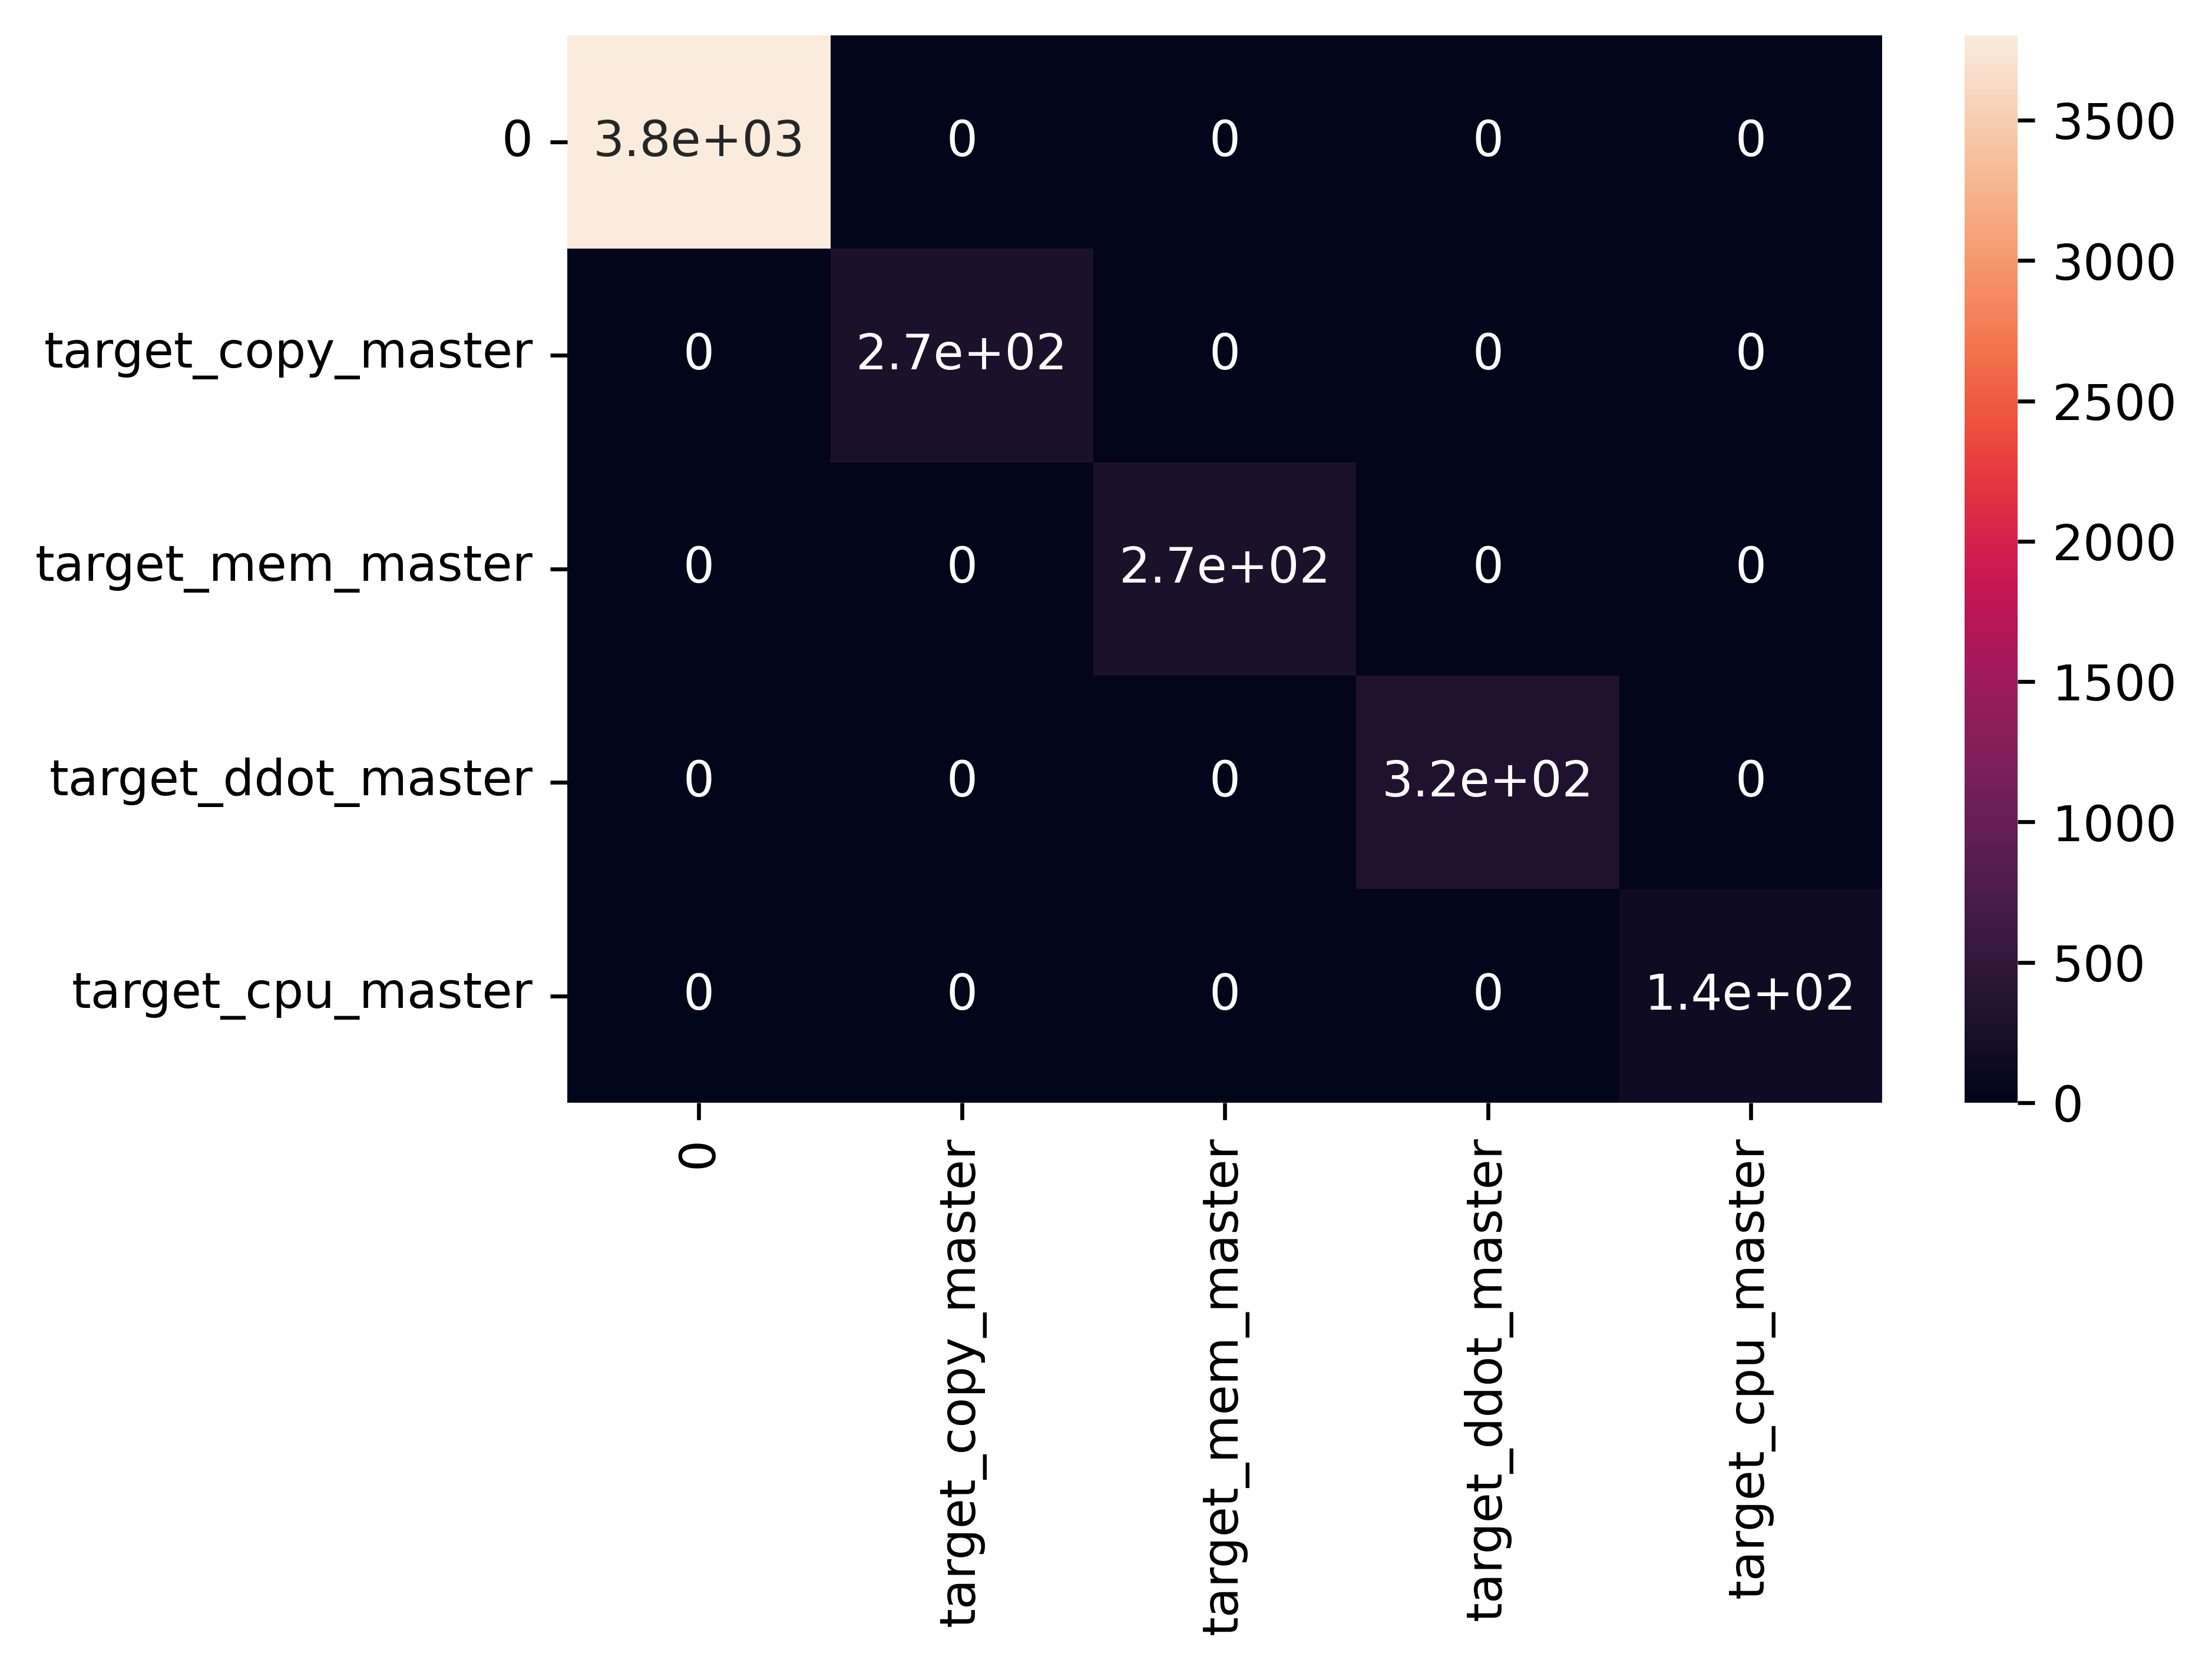

In [63]:
print("Confusion matrix")
cf_matrix = confusion_matrix(y, y_pred)
plt.figure(dpi=600)
sns_cf = sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
cf_fig = "{}_cf.png".format(prefix)
sns_cf.figure.savefig(os.path.join(model_dir, cf_fig), format='pdf',
           bbox_inches='tight', pad_inches=0)

# Extract Feature importance
feat_importances = pd.Series(model.get_feature_importance(), index=list(data.drop('target', axis=1).columns))
featureimp_name = "{}_hpo_best_featureimp.csv".format(prefix)
feat_importances.to_csv(os.path.join(model_dir, featureimp_name), index=True)
# print(feat_importances.head(10))
sorted_feature = feat_importances.sort_values(ascending=True)
# Plot the feature importances of the forest
# plt.figure()
plt.figure(figsize=(10,20), dpi=600)
plt.title("Feature importances")
plt.barh(range(X.shape[1]), sorted_feature,
       color="r", align="center", )
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), sorted_feature.index)
plt.ylim([-1, X.shape[1]])
plt.show()


Scoring on holdout or other dataset

In [64]:
#Creating the dependent variable class
# factor_h = pd.factorize(df_clean['target'])
# df_clean.target = factor_h[0]
# definitions_h = factor_h[1]

In [65]:
# print("Splitting dataset into data and ground truth ...")
# X_h = df_clean.drop('target', axis=1)
# y_h = df_clean['target']

# Scale
# X_h

In [66]:
# X_h = scaler.transform(X_h)


In [67]:
# y_pred_h = cv.best_estimator_.predict(X_h)
#
# custom_scoring_reporting(y_pred_h, y_h, definitions, prefix="rf_holdout")

In [68]:
# y_pred = cv.best_estimator_.predict(X)
# custom_scoring_reporting(y_pred, y, definitions, prefix)

# jaccard_score(y_h, y_pred_h, average='micro')
# y_pred_h